In [4]:
import numpy as np
from numpy import zeros, array, rot90
import random
import matplotlib.pyplot as plt
import math

In [5]:
class Board():
    def __init__(self):
        self.board = zeros((4, 4), dtype=int)
        self.fill_cell()
        self.game_over = False
        self.total_score = 0

    def reset(self):
        self.__init__()

    # Adding a random 2/4 into the board
    def fill_cell(self):
      i, j = (self.board == 0).nonzero()
      if i.size != 0:
          rnd = random.randint(0, i.size - 1)
          self.board[i[rnd], j[rnd]] = 2 * ((random.random() > .9) + 1)

    # Moving tiles in a column to left and merge if possible
    def move_left(self, col):
      new_col = zeros((4), dtype=col.dtype)
      j = 0
      previous = None
      for i in range(col.size):
          if col[i] != 0: # number different from zero
              if previous == None:
                  previous = col[i]
              else:
                  if previous == col[i]:
                      new_col[j] = 2 * col[i]
                      self.total_score += new_col[j]
                      j += 1
                      previous = None
                  else:
                      new_col[j] = previous
                      j += 1
                      previous = col[i]
      if previous != None:
          new_col[j] = previous
      return new_col

    def move(self, direction):
      # 0: left, 1: up, 2: right, 3: down
      rotated_board = rot90(self.board, direction)
      cols = [rotated_board[i, :] for i in range(4)]
      new_board = array([self.move_left(col) for col in cols])
      return rot90(new_board, -direction)

    def is_game_over(self):
      for i in range(self.board.shape[0]):
        for j in range(self.board.shape[1]):
          if self.board[i][j] == 0:
            return False
          if i != 0 and self.board[i - 1][j] == self.board[i][j]:
            return False
          if j != 0 and self.board[i][j - 1] == self.board[i][j]:
            return False
      return True


    def step(self, direction):
      new_board = self.move(direction)
      if not (new_board == self.board).all():
        self.board = new_board
        self.fill_cell()



In [6]:
def main_loop(b, direction):
    new_board = b.move(direction)
    moved = False
    if (new_board == b.board).all():
        # move is invalid
        pass
    else:
        moved = True
        b.board = new_board
        b.fill_cell()
    return moved

In [4]:
def sample_game_random():
  game = Board()
  finish = False
  while not finish:
    direction = np.random.randint(4)
    moved = main_loop(game, direction)
    if not moved:
      # Sample another direction if the move is invalid
      continue
    finish = game.is_game_over()
  total_score = game.total_score
  best_tile = game.board.max()
  return total_score, best_tile

In [5]:
scores_random, best_tiles_random = [], []
for i in range(1000):
  if i % 100 == 0:
    print(f"Iteration {i}")
  total_score, best_tile = sample_game_random()
  scores_random.append(total_score)
  best_tiles_random.append(best_tile)
print("Finish")


Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Finish


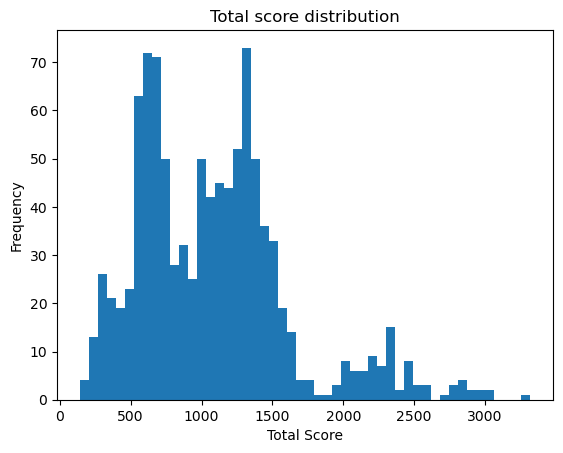

In [10]:
# Plot best score distribution
plt.hist(scores_random, bins = 50)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()


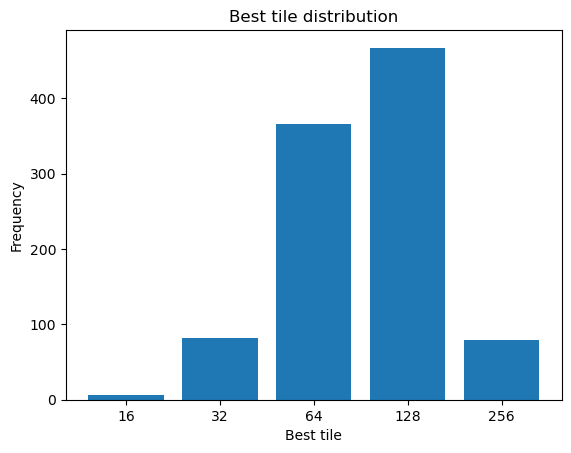

In [11]:
# Plot best score distribution
max_power = int(math.log(max(best_tiles_random), 2)) + 1
min_power = int(math.log(min(best_tiles_random), 2))
unique, counts = np.unique(best_tiles_random, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple, deque
from itertools import count

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
def encode_state(board):
  board_flat = [0 if e == 0 else int(math.log(e, 2)) for e in board.flatten()]
  board_flat = torch.LongTensor(board_flat)
  board_flat = F.one_hot(board_flat, num_classes=16).float().flatten()
  board_flat = board_flat.reshape(1, 4, 4, 16).permute(0, 3, 1, 2)
  return board_flat


In [10]:
# Defining the replay buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvBlock, self).__init__()
        d = output_dim // 4
        self.conv1 = nn.Conv2d(input_dim, d, 1, padding='same')
        self.conv2 = nn.Conv2d(input_dim, d, 2, padding='same')
        self.conv3 = nn.Conv2d(input_dim, d, 3, padding='same')
        self.conv4 = nn.Conv2d(input_dim, d, 4, padding='same')

    def forward(self, x):
        x = x.to(device)
        output1 = self.conv1(x)
        output2 = self.conv2(x)
        output3 = self.conv3(x)
        output4 = self.conv4(x)
        return torch.cat((output1, output2, output3, output4), dim=1)

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = ConvBlock(16, 2048)
        self.conv2 = ConvBlock(2048, 2048)
        self.conv3 = ConvBlock(2048, 2048)
        self.dense1 = nn.Linear(2048 * 16, 1024)
        self.dense6 = nn.Linear(1024, 4)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = nn.Flatten()(x)
        x = F.dropout(self.dense1(x))
        return self.dense6(x)


In [12]:
# Neural Network Initialisation and utilities
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 0.9999
TARGET_UPDATE = 20
n_actions = 4

policy_net = DQN().to(device)
target_net = DQN().to(device)
# target_net.load_state_dict(policy_net.state_dict())
policy_net.load_state_dict(torch.load('./policy_net.pth'))
target_net.load_state_dict(torch.load('./target_net.pth'))
target_net.eval()
policy_net.train()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-5)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
memory = ReplayMemory(50000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = max(EPS_END, EPS_START * (EPS_DECAY ** steps_done))
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [13]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # global steps_done
    # if steps_done % 5000 == 0 and steps_done < 1000000:
    #   print("Learning rate changed.")
    #   scheduler.step()


In [14]:
def same_move(state, next_state, last_memory):
  return torch.eq(state, last_memory.state).all() and torch.eq(next_state, last_memory.next_state).all()

In [28]:
game = Board()
total_scores, best_tile_list = [], []

num_episodes = 5000
for i_episode in range(num_episodes):
    print(f"Episode {i_episode}")
    game.reset()
    state = encode_state(game.board).float()
    duplicate = False
    non_valid_count, valid_count = 0, 0
    for t in count():
        # Select and perform an action
        action = select_action(state)
        old_score = game.total_score
        old_max = game.board.max()
        game.step(action.item())

        done = game.is_game_over()

        reward = (game.total_score - old_score)
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if not done:
            next_state = encode_state(game.board).float()
        else:
            next_state = None

        if next_state != None and torch.eq(state, next_state).all():
          non_valid_count += 1
          reward -= 10
        else:
          valid_count += 1

        # Store the transition in memory
        # if next_state != None and duplicate and not torch.eq(state, next_state).all():
        #   duplicate = False

        # if not duplicate:
        if next_state == None or len(memory) == 0 or not same_move(state, next_state, memory.memory[-1]):
          memory.push(state, action, next_state, reward)

        # if next_state != None:
        #   duplicate = torch.eq(state, next_state).all()

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # optimize_model()

        if done:
          for _ in range(100):
            optimize_model()

          print(game.board)
          print(f"Episode Score: {game.total_score}")
          print(f"Non valid move count: {non_valid_count}")
          print(f"Valid move count: {valid_count}")
          total_scores.append(game.total_score)
          best_tile_list.append(game.board.max())
          if i_episode > 50:
            average = sum(total_scores[-50:]) / 50
            print(f"50 episode running average: {average}")
          break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        policy_net.train()

    if i_episode % 100 == 0:
        torch.save(policy_net.state_dict(), './policy_net.pth')
        torch.save(target_net.state_dict(), './target_net.pth')

print('Complete')

Episode 0


/home/lyarrams/.conda/envs/myENV_pytorch/lib/python3.10/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1739474893324/work/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


[[  4   8   4   2]
 [ 16  32 128  16]
 [  4  64  16   4]
 [  2  16   8   2]]
Episode Score: 1380
Non valid move count: 52
Valid move count: 143
Episode 1
[[ 2  4  2  4]
 [ 8  2  8  2]
 [64  8 64 32]
 [ 4 16  4  2]]
Episode Score: 824
Non valid move count: 14
Valid move count: 98
Episode 2
[[ 4 16  2  4]
 [ 2  4 16 32]
 [ 8 32  8  4]
 [ 2  4 16  2]]
Episode Score: 424
Non valid move count: 7
Valid move count: 70
Episode 3
[[ 2  8  4  2]
 [ 8  4 16  8]
 [ 4 16 32  4]
 [ 2  8  4  2]]
Episode Score: 284
Non valid move count: 6
Valid move count: 55
Episode 4
[[ 2  4  2 32]
 [ 8 32 16  8]
 [ 4 64  8  4]
 [ 2 16  4  2]]
Episode Score: 688
Non valid move count: 19
Valid move count: 91
Episode 5
[[ 2  4  8 16]
 [ 4  8 64  4]
 [ 2 32  2 16]
 [ 4  2 32  2]]
Episode Score: 700
Non valid move count: 8
Valid move count: 95
Episode 6
[[ 2  8  2 16]
 [ 4 16 64  8]
 [ 8 32  8  4]
 [ 4  8  4  2]]
Episode Score: 592
Non valid move count: 17
Valid move count: 82
Episode 7
[[  2  16   4   2]
 [ 16 256   2 

In [29]:
torch.save(policy_net.state_dict(), './policy_net.pth')
torch.save(target_net.state_dict(), './target_net.pth')

In [51]:
def sample_game_DQN():
  game = Board()
  state = encode_state(game.board).float()
  finish = False
  moved = True
  while not finish:
    if not moved:
      direction = np.random.randint(4)
    else:
      direction = select_action(state)

    moved = main_loop(game, direction)
    state = encode_state(game.board).float()

    if not moved:
      continue
      
    finish = game.is_game_over()
  total_score = game.total_score
  best_tile = game.board.max()
  # print("Game Over!, Total Score is {}".format(total_score))
  # print("Best tile: {}".format(best_tile))
  return total_score, best_tile

In [35]:
scores_DQN, best_tiles_DQN = [], []
for i in range(1000):
  if i % 100 == 0:
    print(f"Iteration {i}")
  total_score, best_tile = sample_game_DQN()
  scores_DQN.append(total_score)
  best_tiles_DQN.append(best_tile)
print("Finish")

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Finish


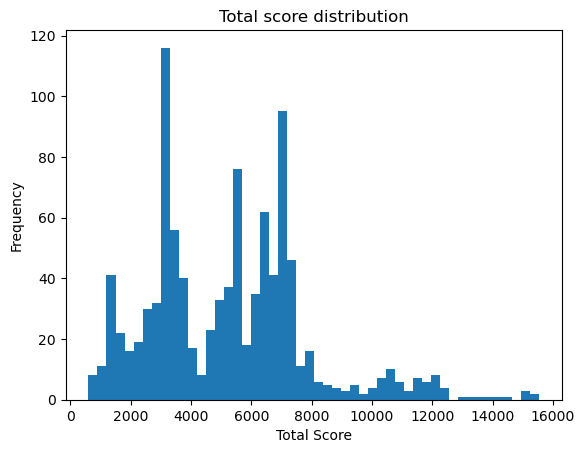

In [36]:
# Plot best score distribution
plt.hist(scores_DQN, bins = 50)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

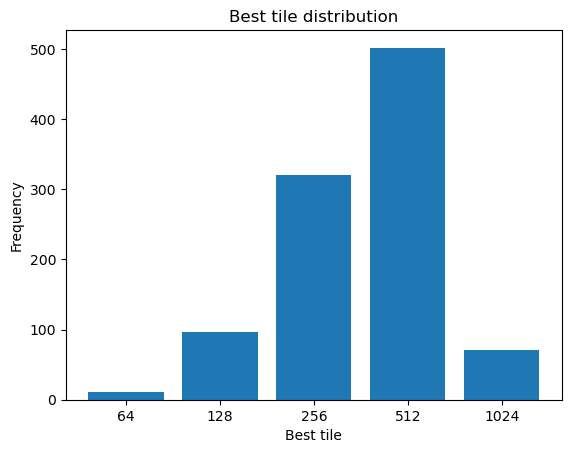

In [38]:
# Plot best score distribution
max_power = int(math.log(max(best_tiles_DQN), 2)) + 1
min_power = int(math.log(min(best_tiles_DQN), 2))
unique, counts = np.unique(best_tiles_DQN, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()

In [45]:
print(total_scores)

[1380, 824, 424, 284, 688, 700, 592, 2716, 624, 2084, 604, 1036, 304, 976, 1920, 960, 480, 2204, 628, 1344, 1496, 1612, 1300, 1136, 1176, 1292, 1148, 1376, 712, 368, 744, 664, 1020, 2448, 1204, 656, 1428, 948, 1272, 1156, 628, 3464, 1996, 856, 396, 1332, 1156, 2292, 1436, 1088, 2016, 1136, 1412, 192, 2424, 1344, 1124, 452, 2336, 620, 1252, 708, 1688, 1460, 1436, 3444, 1436, 1344, 2752, 760, 984, 696, 1580, 1648, 1324, 1360, 1440, 892, 1428, 2216, 676, 1408, 1352, 2884, 1368, 2016, 692, 780, 1060, 2876, 1204, 816, 788, 1192, 952, 1932, 328, 1036, 1740, 3280, 1364, 1324, 2876, 1644, 652, 1256, 472, 1488, 3044, 2688, 1460, 876, 2996, 324, 3208, 1408, 1568, 608, 1364, 2856, 696, 772, 1492, 328, 552, 1600, 1464, 1084, 2360, 1052, 1560, 1312, 1564, 2592, 1368, 1472, 2164, 1168, 1320, 2312, 1028, 1072, 1364, 3232, 1432, 712, 2824, 2176, 2540, 796, 1604, 704, 1456, 1660, 1312, 1000, 1124, 976, 1956, 2476, 736, 1756, 1316, 1376, 1328, 1632, 2928, 3836, 2192, 1540, 1456, 2604, 1312, 1724, 800, 7

In [46]:
print(best_tile_list)

[128, 64, 32, 32, 64, 64, 64, 256, 64, 256, 64, 128, 32, 64, 256, 128, 64, 256, 64, 128, 128, 128, 128, 128, 128, 128, 128, 128, 64, 32, 64, 64, 128, 256, 128, 64, 128, 64, 128, 128, 64, 256, 256, 64, 32, 128, 128, 256, 128, 128, 256, 128, 128, 16, 256, 128, 128, 32, 256, 64, 128, 64, 128, 128, 128, 256, 128, 128, 256, 64, 128, 64, 128, 128, 128, 128, 128, 128, 128, 256, 64, 128, 128, 256, 128, 256, 64, 64, 128, 256, 128, 64, 64, 128, 64, 128, 32, 128, 128, 256, 128, 128, 256, 128, 64, 128, 64, 128, 256, 256, 128, 64, 256, 32, 256, 128, 128, 64, 128, 256, 64, 64, 128, 32, 64, 128, 128, 128, 256, 128, 128, 128, 128, 256, 128, 128, 128, 128, 128, 256, 128, 128, 128, 256, 128, 64, 256, 256, 256, 64, 128, 64, 128, 128, 128, 128, 128, 64, 128, 256, 64, 128, 128, 128, 128, 128, 256, 256, 256, 128, 128, 256, 128, 128, 64, 64, 64, 128, 64, 64, 128, 128, 128, 256, 128, 128, 128, 256, 128, 128, 64, 64, 128, 64, 128, 128, 256, 256, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 64, 128, 64, 25

In [12]:
best_tile_list = [128, 64, 32, 32, 64, 64, 64, 256, 64, 256, 64, 128, 32, 64, 256, 128, 64, 256, 64, 128, 128, 128, 128, 128, 128, 128, 128, 128, 64, 32, 64, 64, 128, 256, 128, 64, 128, 64, 128, 128, 64, 256, 256, 64, 32, 128, 128, 256, 128, 128, 256, 128, 128, 16, 256, 128, 128, 32, 256, 64, 128, 64, 128, 128, 128, 256, 128, 128, 256, 64, 128, 64, 128, 128, 128, 128, 128, 128, 128, 256, 64, 128, 128, 256, 128, 256, 64, 64, 128, 256, 128, 64, 64, 128, 64, 128, 32, 128, 128, 256, 128, 128, 256, 128, 64, 128, 64, 128, 256, 256, 128, 64, 256, 32, 256, 128, 128, 64, 128, 256, 64, 64, 128, 32, 64, 128, 128, 128, 256, 128, 128, 128, 128, 256, 128, 128, 128, 128, 128, 256, 128, 128, 128, 256, 128, 64, 256, 256, 256, 64, 128, 64, 128, 128, 128, 128, 128, 64, 128, 256, 64, 128, 128, 128, 128, 128, 256, 256, 256, 128, 128, 256, 128, 128, 64, 64, 64, 128, 64, 64, 128, 128, 128, 256, 128, 128, 128, 256, 128, 128, 64, 64, 128, 64, 128, 128, 256, 256, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 64, 128, 64, 256, 128, 64, 256, 64, 128, 128, 128, 256, 256, 256, 128, 128, 256, 64, 128, 128, 128, 256, 128, 128, 256, 128, 64, 128, 128, 128, 128, 256, 256, 256, 128, 64, 256, 64, 128, 256, 64, 128, 128, 256, 128, 256, 128, 256, 256, 32, 128, 128, 128, 128, 128, 128, 256, 128, 256, 256, 64, 128, 256, 64, 128, 128, 128, 256, 128, 128, 256, 256, 128, 256, 64, 128, 256, 256, 128, 256, 32, 128, 128, 256, 128, 256, 256, 256, 128, 256, 128, 256, 256, 256, 128, 128, 128, 256, 256, 256, 64, 128, 128, 128, 256, 128, 512, 128, 256, 128, 128, 256, 128, 256, 128, 128, 128, 128, 128, 64, 64, 128, 128, 256, 256, 256, 64, 256, 128, 128, 128, 256, 256, 128, 128, 128, 128, 128, 64, 256, 128, 128, 128, 256, 128, 64, 128, 128, 256, 256, 256, 128, 256, 256, 128, 64, 128, 128, 64, 128, 256, 128, 256, 512, 512, 128, 256, 128, 256, 128, 64, 256, 64, 128, 128, 128, 128, 128, 256, 128, 128, 256, 256, 128, 128, 256, 512, 256, 64, 128, 128, 256, 128, 128, 256, 128, 128, 128, 256, 128, 64, 128, 256, 64, 128, 256, 128, 64, 256, 512, 256, 64, 256, 256, 64, 128, 64, 256, 256, 512, 64, 256, 128, 128, 512, 256, 512, 256, 128, 256, 256, 128, 256, 256, 32, 128, 256, 128, 128, 128, 128, 128, 256, 64, 128, 256, 256, 128, 256, 32, 128, 256, 128, 256, 256, 128, 256, 256, 256, 512, 256, 128, 256, 256, 128, 256, 256, 64, 128, 128, 256, 256, 128, 256, 128, 256, 128, 128, 128, 256, 64, 128, 256, 256, 256, 256, 256, 256, 512, 128, 128, 128, 128, 256, 128, 256, 128, 256, 128, 128, 128, 512, 128, 128, 128, 64, 256, 256, 512, 256, 128, 128, 256, 128, 256, 128, 128, 64, 256, 64, 256, 128, 128, 128, 256, 128, 256, 128, 256, 256, 128, 512, 128, 256, 256, 512, 256, 256, 256, 256, 128, 256, 256, 128, 128, 256, 256, 128, 256, 128, 128, 256, 128, 256, 128, 256, 64, 128, 128, 64, 128, 256, 256, 256, 512, 256, 128, 256, 128, 256, 256, 128, 256, 256, 128, 128, 128, 512, 64, 256, 128, 256, 64, 128, 128, 256, 128, 128, 128, 256, 512, 128, 128, 128, 512, 128, 128, 128, 256, 256, 32, 64, 64, 256, 256, 128, 512, 128, 128, 128, 256, 256, 128, 128, 128, 256, 128, 256, 256, 256, 128, 128, 512, 256, 256, 256, 128, 128, 256, 128, 128, 256, 256, 128, 256, 256, 128, 256, 256, 512, 256, 128, 256, 256, 256, 128, 256, 256, 256, 128, 256, 256, 512, 128, 256, 256, 256, 256, 512, 128, 256, 256, 256, 256, 256, 256, 256, 128, 128, 256, 512, 128, 128, 256, 256, 128, 64, 256, 256, 256, 256, 128, 128, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 256, 128, 256, 64, 256, 128, 128, 256, 256, 128, 256, 256, 256, 256, 128, 512, 512, 256, 256, 256, 256, 128, 256, 64, 512, 256, 256, 128, 256, 256, 256, 256, 256, 256, 256, 256, 128, 256, 256, 256, 256, 256, 256, 128, 64, 128, 128, 128, 256, 128, 128, 256, 128, 128, 128, 256, 512, 256, 256, 128, 256, 256, 64, 256, 512, 256, 256, 512, 256, 128, 128, 128, 256, 256, 256, 256, 128, 256, 64, 128, 256, 256, 128, 128, 128, 128, 128, 64, 256, 256, 256, 256, 128, 128, 256, 256, 128, 128, 256, 512, 512, 128, 256, 128, 128, 256, 256, 64, 256, 256, 512, 256, 256, 64, 128, 512, 64, 128, 256, 256, 256, 256, 128, 128, 256, 512, 128, 128, 128, 512, 256, 128, 512, 128, 256, 256, 256, 256, 256, 128, 256, 128, 256, 256, 128, 128, 256, 32, 256, 512, 256, 512, 64, 512, 128, 256, 256, 128, 256, 512, 256, 128, 512, 256, 512, 128, 256, 256, 128, 128, 256, 256, 128, 256, 256, 256, 256, 256, 256, 256, 128, 256, 256, 128, 256, 256, 256, 256, 64, 256, 128, 128, 256, 128, 64, 128, 256, 256, 256, 64, 256, 256, 256, 128, 128, 128, 256, 128, 512, 128, 128, 128, 128, 64, 256, 256, 64, 256, 64, 512, 64, 256, 512, 512, 128, 256, 256, 128, 64, 128, 128, 128, 64, 256, 128, 256, 256, 256, 128, 128, 128, 128, 256, 256, 256, 128, 128, 256, 256, 128, 128, 256, 256, 128, 256, 256, 256, 128, 128, 256, 256, 128, 256, 128, 128, 256, 256, 128, 128, 128, 256, 128, 128, 128, 256, 256, 256, 128, 128, 256, 128, 256, 256, 256, 128, 128, 256, 256, 128, 128, 128, 256, 256, 64, 256, 128, 256, 128, 256, 128, 256, 256, 256, 128, 256, 128, 256, 128, 256, 128, 256, 256, 256, 128, 256, 256, 128, 64, 256, 256, 128, 128, 256, 256, 256, 128, 128, 256, 512, 256, 256, 128, 64, 256, 128, 128, 256, 64, 256, 256, 128, 256, 256, 128, 128, 256, 256, 128, 128, 512, 256, 512, 256, 256, 128, 64, 256, 256, 512, 128, 256, 128, 256, 256, 256, 512, 256, 256, 512, 128, 128, 256, 256, 128, 256, 512, 128, 128, 256, 128, 256, 512, 256, 256, 128, 128, 256, 256, 128, 128, 256, 256, 128, 128, 128, 256, 512, 128, 256, 256, 128, 64, 128, 128, 256, 256, 128, 128, 256, 256, 256, 256, 128, 128, 128, 128, 256, 256, 128, 128, 128, 128, 128, 256, 64, 128, 256, 512, 256, 512, 128, 256, 128, 128, 256, 128, 256, 128, 512, 128, 256, 256, 128, 256, 256, 64, 128, 128, 128, 256, 256, 128, 256, 128, 256, 128, 64, 256, 256, 128, 256, 128, 128, 128, 256, 256, 128, 256, 128, 512, 256, 256, 128, 128, 256, 256, 256, 256, 128, 256, 128, 256, 64, 128, 256, 128, 256, 256, 128, 256, 512, 256, 256, 128, 256, 256, 128, 256, 256, 256, 256, 512, 256, 64, 128, 256, 128, 256, 256, 256, 256, 128, 64, 256, 128, 256, 256, 128, 128, 256, 256, 256, 128, 128, 256, 256, 256, 512, 256, 256, 128, 256, 256, 128, 256, 128, 256, 512, 256, 256, 256, 256, 256, 64, 256, 128, 256, 256, 256, 64, 128, 256, 256, 128, 256, 64, 128, 128, 256, 128, 256, 256, 128, 256, 256, 256, 128, 128, 256, 256, 512, 256, 256, 128, 128, 128, 256, 256, 256, 128, 64, 256, 256, 256, 128, 512, 256, 128, 128, 256, 128, 256, 256, 512, 256, 256, 256, 256, 256, 64, 256, 128, 128, 256, 32, 256, 256, 256, 256, 512, 256, 64, 128, 256, 256, 256, 256, 256, 128, 128, 128, 512, 256, 256, 128, 128, 256, 256, 512, 64, 256, 64, 256, 256, 512, 256, 256, 256, 256, 512, 256, 256, 128, 64, 128, 128, 256, 256, 128, 256, 512, 256, 128, 128, 256, 256, 256, 256, 256, 512, 512, 128, 256, 256, 256, 256, 256, 128, 256, 256, 256, 256, 128, 256, 256, 128, 256, 256, 128, 256, 256, 256, 512, 256, 256, 256, 128, 128, 256, 256, 256, 256, 256, 128, 256, 128, 256, 256, 128, 256, 256, 256, 128, 128, 256, 128, 128, 128, 128, 256, 256, 256, 256, 256, 128, 256, 256, 512, 128, 256, 256, 256, 256, 256, 256, 512, 256, 256, 256, 32, 256, 128, 256, 256, 256, 256, 256, 512, 64, 256, 256, 128, 512, 256, 128, 128, 256, 256, 256, 32, 128, 128, 256, 256, 512, 256, 256, 256, 128, 256, 128, 256, 256, 256, 256, 128, 256, 128, 256, 128, 256, 64, 256, 256, 128, 128, 256, 256, 256, 256, 256, 256, 256, 256, 256, 128, 256, 256, 128, 128, 512, 256, 256, 128, 256, 256, 256, 512, 128, 128, 256, 128, 128, 512, 128, 128, 128, 256, 256, 256, 256, 128, 256, 256, 256, 256, 512, 32, 128, 256, 512, 256, 512, 128, 256, 256, 64, 256, 128, 256, 128, 256, 256, 256, 256, 128, 256, 256, 256, 256, 256, 128, 256, 512, 256, 128, 128, 256, 256, 256, 256, 256, 256, 128, 256, 128, 256, 256, 128, 256, 256, 256, 128, 64, 512, 256, 256, 64, 64, 256, 128, 256, 512, 512, 128, 64, 64, 128, 128, 256, 128, 128, 128, 256, 64, 64, 256, 128, 128, 256, 256, 256, 256, 256, 256, 256, 256, 128, 256, 128, 128, 64, 256, 256, 256, 256, 512, 256, 256, 128, 256, 256, 512, 256, 256, 128, 256, 256, 256, 256, 128, 256, 256, 256, 256, 128, 256, 256, 256, 512, 256, 128, 256, 64, 128, 256, 256, 256, 128, 128, 256, 256, 128, 512, 256, 256, 256, 256, 64, 128, 256, 256, 512, 128, 128, 256, 256, 512, 256, 128, 256, 128, 128, 256, 512, 256, 256, 256, 256, 256, 128, 128, 256, 256, 256, 512, 256, 128, 512, 512, 256, 256, 256, 256, 128, 128, 256, 256, 128, 128, 256, 128, 256, 128, 128, 128, 64, 256, 128, 256, 256, 128, 128, 128, 256, 128, 256, 128, 64, 256, 128, 128, 128, 64, 256, 256, 128, 256, 256, 256, 64, 128, 256, 256, 256, 256, 128, 64, 256, 256, 256, 256, 128, 256, 128, 256, 512, 256, 256, 256, 128, 512, 256, 128, 128, 128, 256, 128, 256, 256, 256, 256, 256, 128, 256, 128, 256, 256, 128, 128, 128, 128, 256, 256, 128, 256, 128, 256, 128, 256, 128, 128, 256, 256, 256, 256, 256, 128, 256, 128, 128, 512, 256, 128, 256, 128, 128, 128, 256, 256, 128, 512, 128, 64, 256, 256, 256, 256, 256, 128, 256, 256, 256, 256, 128, 256, 128, 256, 64, 256, 256, 256, 256, 256, 64, 128, 256, 256, 512, 512, 128, 512, 256, 64, 256, 256, 256, 256, 128, 256, 512, 128, 256, 512, 256, 256, 256, 128, 128, 128, 512, 256, 256, 256, 512, 256, 128, 256, 128, 512, 128, 256, 256, 256, 256, 256, 256, 256, 256, 256, 512, 512, 64, 256, 256, 512, 256, 256, 256, 256, 128, 128, 256, 256, 512, 256, 512, 256, 128, 128, 128, 64, 512, 256, 512, 512, 128, 512, 256, 512, 512, 256, 256, 128, 128, 256, 256, 512, 256, 256, 256, 512, 256, 128, 256, 512, 512, 128, 256, 256, 128, 128, 256, 256, 256, 256, 256, 128, 128, 256, 256, 128, 256, 256, 256, 256, 512, 256, 512, 256, 256, 512, 128, 128, 128, 256, 256, 256, 128, 128, 128, 64, 256, 256, 256, 256, 512, 256, 256, 64, 256, 128, 128, 128, 256, 64, 512, 256, 128, 512, 256, 512, 256, 256, 256, 256, 512, 128, 256, 256, 256, 256, 256, 256, 128, 128, 128, 128, 128, 128, 128, 64, 256, 128, 256, 256, 256, 128, 256, 256, 512, 256, 512, 256, 128, 256, 128, 128, 512, 256, 64, 256, 256, 512, 128, 256, 512, 256, 256, 128, 256, 64, 256, 256, 256, 128, 256, 256, 512, 256, 256, 256, 128, 256, 512, 512, 256, 128, 256, 512, 256, 256, 256, 256, 512, 512, 512, 512, 512, 512, 128, 256, 512, 128, 128, 256, 64, 256, 128, 512, 256, 64, 256, 256, 128, 256, 512, 256, 128, 256, 512, 256, 256, 256, 256, 256, 128, 128, 128, 256, 256, 256, 256, 256, 256, 128, 256, 512, 256, 128, 256, 128, 128, 256, 256, 512, 256, 512, 128, 128, 128, 256, 256, 256, 512, 128, 256, 128, 256, 256, 256, 256, 512, 256, 128, 512, 512, 128, 256, 128, 256, 256, 256, 256, 256, 256, 128, 512, 512, 256, 512, 512, 256, 128, 256, 256, 256, 128, 256, 256, 128, 256, 256, 512, 256, 256, 128, 256, 512, 512, 256, 256, 128, 128, 128, 256, 256, 256, 256, 128, 512, 256, 128, 128, 64, 128, 128, 256, 64, 512, 256, 64, 512, 128, 256, 256, 256, 64, 512, 256, 256, 256, 256, 256, 128, 512, 512, 512, 256, 256, 256, 512, 256, 256, 256, 256, 128, 64, 128, 512, 512, 256, 256, 512, 256, 256, 256, 256, 256, 256, 256, 32, 128, 512, 128, 256, 128, 256, 256, 256, 256, 32, 256, 256, 256, 512, 128, 512, 256, 256, 512, 256, 256, 256, 256, 512, 128, 256, 128, 256, 256, 128, 256, 256, 128, 256, 128, 256, 512, 128, 256, 512, 256, 128, 512, 256, 256, 256, 256, 64, 256, 128, 256, 256, 256, 512, 512, 64, 512, 128, 256, 512, 128, 512, 256, 256, 256, 128, 256, 256, 256, 256, 512, 512, 256, 256, 128, 128, 128, 512, 256, 128, 128, 512, 256, 256, 64, 256, 256, 128, 64, 512, 256, 256, 256, 256, 512, 256, 128, 512, 128, 256, 256, 256, 256, 128, 256, 64, 256, 128, 256, 128, 256, 128, 512, 128, 512, 128, 512, 512, 256, 256, 256, 256, 256, 512, 128, 256, 128, 512, 256, 128, 512, 256, 256, 256, 128, 128, 512, 512, 512, 512, 512, 128, 256, 256, 256, 256, 256, 128, 128, 128, 512, 128, 256, 256, 256, 256, 256, 256, 512, 256, 512, 128, 256, 128, 256, 256, 512, 256, 128, 256, 128, 256, 128, 512, 256, 128, 256, 128, 256, 256, 256, 256, 128, 256, 256, 256, 512, 512, 128, 128, 256, 256, 512, 256, 512, 256, 256, 512, 256, 256, 512, 512, 256, 256, 512, 256, 512, 256, 256, 128, 128, 512, 256, 256, 256, 256, 256, 256, 128, 256, 256, 256, 128, 64, 256, 256, 256, 512, 512, 256, 256, 128, 256, 256, 512, 256, 256, 256, 256, 256, 256, 512, 128, 256, 128, 256, 256, 128, 256, 128, 128, 64, 256, 256, 256, 256, 512, 256, 256, 256, 512, 256, 256, 512, 512, 128, 256, 256, 256, 128, 256, 128, 256, 256, 256, 128, 256, 256, 256, 256, 512, 256, 128, 256, 128, 128, 64, 32, 512, 256, 128, 256, 512, 128, 256, 256, 128, 512, 256, 128, 256, 64, 512, 512, 256, 256, 256, 256, 128, 512, 128, 256, 512, 256, 256, 512, 512, 32, 512, 256, 128, 256, 512, 512, 128, 512, 128, 128, 256, 128, 256, 512, 256, 512, 256, 512, 512, 256, 128, 512, 256, 256, 256, 128, 256, 256, 256, 256, 512, 256, 256, 512, 256, 256, 256, 256, 256, 256, 128, 512, 256, 256, 256, 256, 512, 128, 256, 512, 256, 256, 64, 128, 512, 256, 256, 256, 256, 512, 256, 512, 256, 64, 256, 128, 256, 512, 128, 512, 512, 256, 512, 64, 256, 128, 256, 128, 128, 256, 512, 256, 128, 512, 512, 256, 512, 256, 256, 256, 128, 256, 256, 256, 64, 64, 256, 256, 256, 256, 256, 128, 256, 256, 512, 256, 256, 256, 256, 512, 256, 256, 128, 256, 512, 256, 256, 128, 256, 512, 512, 128, 256, 512, 256, 256, 256, 256, 512, 256, 512, 256, 64, 512, 256, 512, 512, 128, 256, 512, 512, 256, 256, 256, 512, 256, 128, 256, 128, 256, 128, 512, 256, 256, 512, 128, 256, 256, 512, 128, 128, 256, 256, 128, 512, 512, 256, 512, 256, 256, 128, 256, 256, 512, 128, 512, 256, 256, 256, 128, 256, 512, 512, 256, 256, 256, 512, 512, 512, 256, 128, 512, 512, 512, 256, 512, 256, 256, 256, 256, 256, 256, 256, 512, 128, 256, 256, 256, 256, 256, 64, 256, 512, 256, 256, 256, 256, 128, 256, 128, 512, 128, 512, 512, 256, 256, 256, 256, 256, 512, 512, 256, 128, 256, 128, 256, 256, 512, 256, 512, 128, 128, 256, 512, 512, 256, 512, 256, 128, 256, 256, 256, 128, 512, 256, 256, 256, 512, 256, 512, 128, 256, 512, 256, 256, 256, 256, 256, 512, 256, 256, 512, 512, 256, 256, 512, 512, 128, 256, 256, 128, 256, 512, 256, 256, 256, 512, 128, 256, 64, 256, 128, 256, 256, 512, 256, 256, 256, 256, 256, 512, 256, 256, 512, 128, 256, 512, 512, 128, 512, 512, 512, 256, 256, 128, 512, 256, 256, 256, 512, 128, 512, 256, 256, 128, 512, 256, 256, 64, 512, 512, 128, 128, 128, 512, 512, 256, 128, 256, 128, 256, 256, 64, 256, 64, 128, 256, 256, 256, 256, 256, 512, 256, 256, 256, 256, 256, 128, 256, 256, 256, 256, 128, 128, 256, 256, 512, 256, 256, 128, 512, 256, 256, 512, 256, 512, 256, 128, 512, 512, 256, 512, 128, 256, 128, 256, 256, 512, 128, 256, 256, 256, 512, 1024, 128, 128, 256, 128, 256, 512, 256, 128, 512, 256, 128, 128, 512, 128, 512, 128, 256, 256, 256, 256, 256, 512, 256, 128, 512, 128, 64, 256, 512, 512, 512, 256, 256, 256, 256, 512, 256, 256, 512, 256, 256, 512, 128, 512, 256, 512, 512, 128, 256, 128, 128, 256, 128, 256, 512, 256, 256, 512, 512, 256, 128, 128, 64, 256, 256, 512, 256, 512, 256, 128, 128, 64, 128, 256, 256, 256, 256, 256, 256, 256, 64, 256, 512, 256, 128, 256, 256, 256, 512, 512, 256, 256, 512, 256, 256, 256, 512, 128, 128, 256, 64, 256, 256, 512, 512, 256, 512, 128, 1024, 512, 512, 512, 128, 64, 512, 512, 512, 512, 256, 256, 512, 64, 512, 256, 256, 128, 256, 512, 256, 256, 128, 512, 128, 256, 512, 256, 512, 512, 256, 256, 512, 512, 512, 128, 512, 256, 512, 256, 256, 128, 256, 512, 256, 512, 128, 256, 256, 128, 512, 256, 256, 256, 128, 512, 256, 128, 256, 128, 512, 256, 256, 128, 256, 256, 256, 512, 256, 256, 512, 512, 256, 512, 256, 128, 128, 64, 512, 128, 256, 256, 256, 128, 512, 256, 256, 256, 256, 512, 256, 256, 256, 512, 256, 128, 128, 128, 512, 256, 256, 128, 512, 256, 128, 256, 256, 512, 256, 512, 512, 256, 512, 256, 256, 64, 512, 512, 128, 256, 256, 512, 512, 512, 512, 64, 128, 256, 512, 512, 256, 256, 128, 256, 256, 256, 256, 256, 512, 128, 256, 256, 256, 256, 512, 128, 256, 256, 256, 128, 512, 512, 512, 256, 256, 128, 256, 256, 256, 256, 512, 256, 64, 128, 128, 256, 512, 512, 512, 128, 128, 256, 256, 512, 512, 512, 256, 512, 512, 128, 512, 512, 256, 256, 512, 128, 256, 128, 512, 512, 1024, 256, 256, 256, 256, 256, 512, 256, 256, 256, 256, 128, 256, 256, 512, 256, 512, 512, 256, 256, 256, 256, 1024, 512, 512, 128, 128, 512, 128, 256, 64, 256, 512, 256, 512, 512, 256, 512, 256, 256, 256, 256, 512, 128, 512, 256, 256, 256, 256, 256, 64, 512, 256, 512, 256, 512, 256, 256, 256, 512, 256, 64, 256, 256, 512, 128, 512, 256, 256, 512, 256, 256, 256, 256, 128, 256, 128, 256, 256, 256, 128, 128, 256, 256, 256, 512, 128, 512, 256, 512, 256, 512, 128, 128, 256, 256, 64, 512, 256, 256, 256, 512, 256, 256, 256, 512, 512, 512, 256, 512, 128, 512, 128, 256, 256, 256, 256, 256, 512, 512, 512, 512, 512, 256, 512, 256, 512, 256, 256, 512, 256, 256, 256, 512, 256, 128, 512, 256, 256, 512, 256, 256, 512, 512, 256, 512, 256, 128, 256, 512, 256, 256, 128, 256, 256, 256, 512, 256, 512, 128, 256, 512, 512, 128, 256, 128, 512, 512, 256, 128, 256, 256, 512, 512, 512, 256, 256, 128, 512, 512, 64, 128, 512, 256, 256, 128, 128, 512, 512, 256, 256, 512, 512, 256, 256, 256, 128, 256, 512, 512, 512, 512, 512, 128, 128, 512, 128, 128, 512, 256, 256, 256, 256, 512, 256, 512, 256, 512, 256, 128, 256, 256, 256, 256, 256, 256, 512, 128, 512, 256, 512, 128, 256, 256, 256, 512, 256, 256, 512, 256, 128, 256, 128, 256, 256, 256, 256, 64, 512, 256, 128, 128, 512, 128, 256, 256, 128, 64, 128, 256, 512, 256, 256, 512, 512, 256, 256, 256, 256, 128, 128, 256, 128, 256, 64, 128, 512, 512, 256, 512, 128, 256, 256, 512, 64, 256, 256, 256, 128, 128, 64, 256, 256, 256, 256, 256, 256, 512, 256, 512, 512, 512, 1024, 256, 128, 256, 256, 128, 512, 512, 256, 512, 128, 512, 256, 512, 256, 512, 512, 256, 256, 128, 128, 256, 256, 512, 128, 512, 128, 256, 256, 128, 512, 512, 256, 256, 512, 512, 512, 1024, 128, 256, 512, 256, 256, 128, 256, 256, 128, 128, 256, 128, 512, 512, 512, 256, 1024, 512, 256, 256, 128, 256, 128, 256, 256, 256, 256, 256, 256, 256, 512, 512, 512, 512, 512, 256, 512, 512, 512, 256, 512, 256, 256, 256, 512, 512, 128, 1024, 512, 512, 256, 256, 512, 512, 512, 512, 256, 256, 256, 256, 512, 256, 64, 128, 1024, 512, 256, 512, 256, 256, 64, 512, 128, 256, 256, 512, 128, 64, 256, 256, 128, 256, 256, 256, 512, 256, 128, 256, 512, 256, 512, 256, 256, 256, 128, 128, 1024, 256, 512, 512, 512, 256, 512, 256, 256, 512, 256, 256, 128, 256, 256, 512, 256, 128, 256, 512, 256, 256, 128, 512, 256, 128, 128, 256, 128, 128, 256, 512, 128, 512, 512, 256, 256, 512, 512, 512, 256, 512, 256, 256, 128, 512, 512, 256, 512, 512, 512, 256, 512, 512, 512, 256, 512, 512, 256, 512, 256, 512, 1024, 256, 512, 256, 256, 256, 256, 256, 256, 256, 512, 256, 256, 256, 512, 256, 512, 1024, 512, 1024, 256, 512, 512, 512, 512, 256, 128, 256, 512, 256, 256, 128, 256, 512, 256, 256, 512, 256, 512, 256, 512, 512, 256, 256, 256, 256, 256, 512, 16, 256, 256, 512, 128, 256, 512, 128, 512, 512, 512, 256, 256, 128, 1024, 128, 256, 512, 512, 256, 512, 512, 256, 256, 1024, 512, 512, 512, 256, 128, 256, 512, 512, 256, 256, 512, 512, 256, 512, 256, 512, 512, 256, 512, 512, 512, 512, 512, 512, 256, 256, 128, 512, 256, 1024, 256, 512, 256, 256, 512, 256, 512, 512, 256, 512, 512, 256, 128, 256, 512, 512, 128, 512, 512, 128, 256, 512, 256, 256, 256, 256, 512, 512, 256, 512, 512, 512, 256, 256, 512, 512, 256, 512, 256, 512, 512, 512, 256, 512, 256, 128, 512, 512, 512, 128, 512, 512, 512, 512, 256, 512, 256, 256, 128, 256, 512, 512, 512, 256, 128, 256, 256, 256, 128, 256, 256, 128, 256, 512, 256, 512, 256, 512, 512, 256, 128, 512, 256, 128, 512, 128, 256, 256, 128, 256, 512, 256, 512, 128, 512, 256, 128, 256, 512, 256, 512, 512, 512, 256, 256, 256, 256, 512, 256, 256, 512, 256, 512, 256, 256, 256, 256, 512, 128, 512, 512, 256, 128, 512, 512, 256, 128, 512, 512, 1024, 256, 512, 512, 256, 128, 512, 256, 512, 256, 256, 1024, 512, 256, 128, 512, 512, 128, 256, 512, 64, 256, 512, 512, 256, 256, 256, 512, 512, 128, 256, 512, 256, 256, 256, 1024, 512, 512, 512, 256, 256, 512, 256, 1024, 512, 512, 512, 256, 256, 128, 512, 512, 256, 256, 512, 512, 128, 512, 512, 512, 256, 256, 256, 256, 512, 256, 512, 256, 512, 512, 128, 128, 512, 256, 512, 512, 512, 512, 512, 128, 512, 256, 128, 512, 256, 256, 256, 512, 256, 256, 512, 128, 256, 256, 256, 512, 512, 256, 256, 512, 1024, 128, 64, 128, 256, 256, 128, 256, 512, 128, 512, 1024, 512, 128, 256, 512, 256, 64, 256, 512, 128, 256, 512, 128, 512, 256, 256, 256, 512, 256, 512, 512, 256, 512, 512, 64, 256, 512, 256, 256, 256, 128, 256, 512, 512, 128, 256, 512, 256, 512, 256, 512, 64, 512, 64, 512, 256, 256, 128, 512, 256, 512, 256, 512, 256, 256, 256, 256, 512, 256, 256, 512, 128, 128, 256, 1024, 256, 512, 256, 256, 512, 256, 256, 256, 512, 128, 256, 512, 128, 128, 256, 256, 128, 128, 512, 256, 256, 64, 256, 128, 128, 512, 512, 128, 512, 512, 256, 128, 128, 128, 128, 1024, 512, 512, 512, 1024, 512, 256, 256, 256, 512, 256, 256, 256, 256, 512, 512, 128, 512, 512, 512, 256, 512, 512, 256, 512, 512, 128, 256, 256, 256, 256, 512, 256, 512, 512, 256, 256, 256, 512, 256, 1024, 256, 256, 256, 128, 256, 512, 512, 128, 512, 512, 256, 512, 256, 512, 512, 512, 512, 512, 512, 256, 512, 512, 256, 256, 512, 256, 512, 1024, 256, 256, 256, 512, 256, 128, 512, 128, 128, 512, 512, 256, 512, 1024, 256, 256, 512, 256, 512, 512, 1024, 256, 256, 256, 512, 256, 64, 512, 512, 128, 512, 512, 256, 256, 512, 256, 256, 512, 512, 256, 256, 1024, 512, 512, 512, 64, 256, 512, 128, 512, 256, 256, 512, 512, 128, 128, 512, 512, 512, 256, 256, 64, 512, 512, 256, 512, 512, 256, 256, 256, 512, 512, 512, 256, 256, 128, 512, 256, 256, 256, 512, 256, 512, 256, 512, 256, 256, 256, 256, 128, 512, 1024, 256, 512, 512, 512, 128, 256, 256, 512, 128, 512, 256, 512, 512, 512, 256, 256, 128, 256, 512, 256, 128, 512, 128, 256, 256, 128, 256, 256, 128, 512, 512, 512, 512, 256, 256, 256, 512, 512, 256, 512, 512, 512, 128, 512, 512, 256, 512, 512, 512, 256, 256, 256, 512, 256, 128, 512, 128, 256, 1024, 512, 512, 128, 128, 512, 512, 512, 512, 256, 512, 256, 256, 256, 256, 256, 512, 256, 512, 256, 512, 512, 256, 128, 512, 512, 256, 512, 512, 256, 512, 256, 256, 256, 512, 256, 512, 128, 512, 512, 128, 128, 256, 256, 128, 512, 128, 512, 256, 256, 128, 256, 256, 512, 512, 512, 512, 256, 128, 512, 512, 512, 64, 256, 128, 256, 128, 256, 512, 1024, 1024, 128, 1024, 64, 1024, 512, 512, 64, 256, 512, 1024, 256, 256, 1024, 256, 128, 128, 128, 256, 128, 512, 256, 512, 256, 256, 512, 256, 512, 256, 256, 256, 1024, 1024, 1024, 256, 512, 512, 1024, 512, 256, 256, 256, 512, 256, 128, 512, 256, 512, 256, 128, 512, 512, 512, 1024, 256, 256, 128, 128, 128, 1024, 128, 512, 128, 256, 256, 512, 512, 256, 512, 256, 512, 512, 256, 512, 128, 256, 128, 512, 512, 64, 512, 256, 512, 256, 128, 512, 512, 256, 128, 128, 512, 256, 512, 256, 512, 1024, 512, 512, 512, 128, 512, 256, 512, 256, 512, 128, 512, 512, 256, 256, 256, 256, 512, 256, 256, 256, 256, 512, 512, 128, 512, 512, 512, 256, 512, 512, 512, 256, 64, 256, 32, 512, 64, 256, 256, 256, 512, 512, 512, 128, 512, 512, 512, 128, 256, 256, 1024, 256, 512, 256, 256, 512, 128, 512, 512, 256, 512, 512, 256, 256, 512, 256, 512, 512, 512, 512, 256, 512, 512, 256, 256, 512, 512, 1024, 128, 512, 128, 512, 512, 256, 256, 256, 1024, 256, 512, 256, 512, 512, 512, 512, 256, 256, 512, 256, 512, 128, 512, 256, 256, 512, 512, 512, 256, 256, 512, 256, 256, 512, 512, 256, 512, 256, 256, 256, 256, 256, 256, 256, 256, 128, 512, 512, 512, 256, 512, 512, 512, 512, 256, 256, 256, 512, 256, 512, 512, 512, 256, 128, 512, 512, 128, 512, 1024, 512, 512, 512, 512, 1024, 256, 1024, 512, 512, 1024, 256, 512, 1024, 1024, 128, 512, 128, 128, 256, 256, 256, 512, 512, 512, 512, 1024, 512, 128, 256, 512, 512, 1024, 256, 512, 128, 256, 128, 128, 512, 512, 512, 512, 512, 256, 512, 128, 128, 512, 512, 512, 128, 512, 512, 256, 512, 256, 1024, 512, 512, 256, 256, 512, 512, 1024, 512, 1024, 128, 512, 512, 128, 1024, 1024, 512, 256, 512, 512, 512, 256, 512, 512, 256, 512, 512, 512, 512, 512, 1024, 256, 512, 512, 512, 128, 512, 256, 1024, 256, 1024, 512, 512, 256, 512, 512, 512, 256, 512, 512, 256, 256, 256, 512, 256, 256, 1024, 128, 1024, 128, 512, 1024, 1024, 512, 256, 512, 512, 128, 256, 512, 256, 512, 512, 512, 512, 256, 1024, 128, 512, 256, 512, 512, 512, 1024, 256, 512, 1024, 512, 1024, 1024, 512, 256, 256, 128, 256, 256, 1024, 128, 128, 512, 512, 128, 512, 128, 512, 512, 512, 256, 512, 512, 256, 256, 512, 256, 256, 256, 1024, 256, 512, 512, 512, 512, 256, 256, 512, 512, 512, 512, 512, 64, 512, 512, 512, 256, 256, 512, 128, 256, 128, 512, 256, 256, 512, 512, 256, 512, 1024, 512, 256, 256, 1024, 512, 256, 256, 256, 128, 512, 512, 256, 256, 512, 512, 256, 256, 1024, 512, 512, 1024, 64, 512, 512, 512, 256, 512, 512, 256, 256, 256, 512, 1024, 512, 512, 256, 512, 512, 512, 1024, 1024, 256, 512, 512, 512, 256, 256, 512, 128, 128, 256, 1024, 256, 64, 512, 256, 512, 512, 512, 512, 256, 512, 512, 512, 256, 512, 256, 256, 256, 256, 256, 256, 128, 512, 128, 256, 512, 256, 512, 128, 512, 512, 256, 512, 512, 1024, 512, 128, 512, 256, 512, 1024, 512, 256, 512, 256, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 512, 512, 256, 512, 1024]

In [13]:
total_scores = [1380, 824, 424, 284, 688, 700, 592, 2716, 624, 2084, 604, 1036, 304, 976, 1920, 960, 480, 2204, 628, 1344, 1496, 1612, 1300, 1136, 1176, 1292, 1148, 1376, 712, 368, 744, 664, 1020, 2448, 1204, 656, 1428, 948, 1272, 1156, 628, 3464, 1996, 856, 396, 1332, 1156, 2292, 1436, 1088, 2016, 1136, 1412, 192, 2424, 1344, 1124, 452, 2336, 620, 1252, 708, 1688, 1460, 1436, 3444, 1436, 1344, 2752, 760, 984, 696, 1580, 1648, 1324, 1360, 1440, 892, 1428, 2216, 676, 1408, 1352, 2884, 1368, 2016, 692, 780, 1060, 2876, 1204, 816, 788, 1192, 952, 1932, 328, 1036, 1740, 3280, 1364, 1324, 2876, 1644, 652, 1256, 472, 1488, 3044, 2688, 1460, 876, 2996, 324, 3208, 1408, 1568, 608, 1364, 2856, 696, 772, 1492, 328, 552, 1600, 1464, 1084, 2360, 1052, 1560, 1312, 1564, 2592, 1368, 1472, 2164, 1168, 1320, 2312, 1028, 1072, 1364, 3232, 1432, 712, 2824, 2176, 2540, 796, 1604, 704, 1456, 1660, 1312, 1000, 1124, 976, 1956, 2476, 736, 1756, 1316, 1376, 1328, 1632, 2928, 3836, 2192, 1540, 1456, 2604, 1312, 1724, 800, 712, 988, 1172, 692, 648, 1356, 1716, 1472, 3152, 1636, 1036, 1044, 2444, 1420, 1524, 560, 708, 1320, 728, 1368, 1288, 2700, 3256, 1356, 1580, 1916, 1480, 1236, 1492, 1008, 1244, 1132, 1352, 804, 1304, 736, 2320, 1464, 1048, 2036, 600, 1300, 2132, 1596, 2928, 2408, 2056, 1016, 1256, 2452, 856, 1044, 1620, 1252, 3244, 1772, 1456, 3128, 1424, 580, 1336, 1668, 1460, 1484, 2776, 2584, 2584, 1732, 736, 3156, 1112, 1796, 2484, 616, 1240, 1404, 2444, 1360, 3076, 1596, 2360, 2548, 348, 1288, 1820, 1348, 1608, 1752, 924, 2324, 1612, 2388, 2508, 708, 1372, 3652, 716, 1332, 1796, 1484, 2344, 1296, 1424, 2408, 2884, 1228, 2836, 700, 1324, 2264, 3160, 1604, 3244, 376, 1404, 1456, 2368, 1072, 3060, 2908, 3052, 1468, 3088, 1516, 2944, 2276, 3000, 1164, 1476, 1404, 3084, 3020, 2344, 716, 1308, 1164, 1792, 3104, 1216, 5240, 1180, 3160, 1720, 1424, 3236, 1632, 2212, 1280, 1368, 1388, 1236, 1596, 624, 672, 1192, 2136, 3096, 2716, 2336, 616, 2428, 2000, 1296, 1320, 3276, 2648, 1492, 1444, 1356, 1380, 1448, 592, 3280, 1000, 1420, 1580, 2244, 1408, 604, 1196, 1432, 2192, 3044, 2284, 1268, 2312, 2804, 1460, 632, 1908, 1456, 976, 1364, 2716, 912, 2844, 5364, 4980, 2052, 2044, 1060, 2056, 1212, 624, 2796, 820, 1768, 1388, 1380, 1528, 1560, 3140, 1588, 1712, 2208, 2432, 1376, 1336, 3148, 5396, 3196, 560, 1376, 1616, 3276, 1324, 904, 3340, 1304, 1372, 1828, 2392, 1324, 872, 1304, 2400, 680, 2128, 3068, 1504, 664, 2984, 4628, 3068, 560, 2816, 2352, 664, 1300, 684, 2328, 2184, 4468, 1240, 3144, 996, 1680, 5104, 2744, 5288, 3104, 1600, 2872, 3084, 1616, 3068, 2432, 352, 1340, 3088, 1432, 1220, 1404, 1688, 1336, 3184, 772, 1104, 2392, 2272, 1648, 2848, 304, 1388, 3120, 1100, 3032, 2048, 1276, 2408, 3184, 2636, 5200, 3156, 1428, 2168, 2376, 1348, 3152, 3032, 964, 1468, 1488, 2552, 2792, 1376, 2240, 1492, 2704, 1656, 1352, 1260, 2872, 948, 1616, 2848, 3064, 2832, 2780, 2316, 3056, 5388, 1576, 1668, 1276, 1424, 2296, 1608, 3288, 1188, 3048, 1528, 1468, 1516, 5316, 2100, 2220, 2420, 660, 2780, 1964, 5328, 3296, 1432, 1452, 2284, 1308, 3024, 1300, 1220, 840, 2224, 728, 2316, 1764, 1748, 1696, 3044, 1272, 2920, 1484, 3192, 3336, 1476, 5640, 1388, 2780, 2892, 5044, 3148, 3248, 3120, 3404, 2096, 3088, 2644, 1412, 1360, 3360, 2032, 1568, 3248, 1688, 1512, 3160, 2300, 3508, 1448, 3100, 736, 2160, 1568, 876, 1176, 2248, 2860, 3128, 6112, 2164, 1352, 2348, 1296, 3132, 2224, 1344, 2256, 3180, 1468, 1656, 1532, 5236, 724, 2548, 1176, 3156, 824, 1548, 1316, 2876, 1180, 1336, 1180, 2116, 5364, 1712, 2160, 1652, 4960, 1640, 1348, 1464, 2052, 3092, 508, 824, 712, 2280, 2768, 1576, 6104, 1504, 1504, 1448, 3232, 2936, 1136, 1776, 1552, 2544, 1552, 2856, 3012, 3284, 1424, 1420, 6092, 2588, 3108, 3128, 1052, 1300, 2392, 1644, 1544, 3212, 2832, 1764, 2412, 3160, 1440, 2412, 2796, 4640, 2940, 2100, 2936, 2020, 2904, 1452, 2932, 2424, 3012, 1472, 3504, 2816, 5268, 1320, 2216, 3028, 2856, 2628, 5108, 1808, 3236, 2428, 3160, 3292, 3168, 3224, 3048, 1440, 1440, 3152, 4688, 1508, 1464, 2840, 2996, 1636, 600, 3360, 2816, 2600, 2948, 1284, 1332, 1372, 1696, 1508, 1564, 3208, 2480, 2688, 2944, 3372, 3096, 2724, 1016, 2028, 676, 2920, 1564, 2220, 3592, 2460, 1472, 2428, 2260, 2816, 2932, 1580, 5068, 5760, 2984, 3896, 3160, 2328, 1736, 2632, 568, 5164, 2964, 2860, 1320, 3076, 3472, 2196, 3120, 3168, 2748, 2892, 2320, 1736, 2572, 2400, 2356, 2216, 2480, 3120, 1364, 700, 1364, 2332, 1148, 2152, 1008, 1824, 2324, 1380, 1600, 1476, 3248, 5168, 3096, 2832, 1268, 3268, 2744, 956, 3152, 4876, 2632, 2016, 5224, 2060, 1248, 1640, 1712, 2740, 3188, 2812, 3004, 1464, 3156, 824, 1724, 3064, 2256, 1416, 1424, 1908, 1500, 1348, 672, 3372, 2664, 2296, 2876, 1532, 1352, 3080, 2780, 1192, 1584, 3184, 4544, 5416, 2036, 2796, 1300, 1520, 2672, 2948, 876, 3180, 2436, 5544, 3180, 2280, 992, 1432, 4792, 912, 1704, 2552, 2380, 3140, 3024, 1644, 1000, 2136, 5056, 1468, 1368, 1068, 5560, 2588, 1668, 4436, 1704, 2572, 3068, 3076, 3032, 3096, 1840, 2488, 1360, 3156, 3024, 1432, 1928, 2820, 252, 2256, 4992, 3116, 5412, 640, 5300, 956, 2936, 2180, 2064, 3344, 7104, 3672, 1320, 6712, 2088, 5668, 1264, 3352, 3152, 1292, 1632, 2528, 2572, 1156, 3072, 3520, 3480, 2124, 3036, 3752, 2448, 1612, 2844, 2768, 1832, 2572, 3012, 2348, 2524, 544, 2596, 1324, 1356, 2980, 1500, 728, 2072, 3036, 2736, 2736, 752, 3480, 2280, 2688, 2004, 1372, 2148, 3108, 1932, 4620, 1284, 1260, 1528, 1600, 628, 2308, 2336, 608, 3980, 640, 5228, 792, 2896, 4520, 5684, 1152, 3156, 2620, 1008, 1012, 2112, 1368, 1768, 548, 2524, 1368, 3776, 2780, 3076, 1432, 2048, 1460, 1256, 3068, 2820, 2484, 1324, 1312, 3212, 2376, 1752, 1632, 3084, 3216, 1596, 3032, 2928, 2432, 2212, 1308, 3384, 2756, 1376, 2456, 1572, 1504, 3384, 4304, 1564, 1084, 1416, 2892, 1348, 1704, 1748, 2540, 3256, 3084, 1392, 1784, 2796, 2116, 2452, 2508, 2660, 1732, 2180, 3564, 2424, 1464, 1400, 1036, 2956, 2952, 956, 3156, 1864, 3992, 1552, 3144, 2136, 2488, 2132, 2664, 1340, 3072, 948, 2484, 1352, 3196, 1644, 3148, 3160, 3068, 1608, 2776, 2468, 1328, 672, 2332, 2940, 1092, 1840, 3480, 3748, 2976, 1960, 1552, 2120, 4596, 3120, 3068, 1636, 860, 2244, 1372, 1500, 3112, 796, 2384, 2936, 1176, 2892, 2708, 1644, 1332, 2560, 2988, 1444, 1324, 5056, 3376, 6716, 3120, 3304, 1000, 1120, 4776, 2664, 4844, 1692, 3552, 1432, 3336, 4064, 2336, 6660, 3032, 2528, 5324, 1480, 1328, 2780, 2580, 1944, 3796, 5724, 1584, 1424, 2992, 1524, 3108, 6248, 2300, 2412, 1932, 1368, 2264, 2632, 1416, 1408, 3012, 2324, 1272, 2364, 1724, 2824, 5220, 1320, 2080, 3032, 1444, 1000, 1444, 1412, 2996, 3200, 1620, 1364, 3232, 2784, 2124, 3112, 1688, 1548, 1468, 2484, 3048, 2588, 1132, 1972, 1452, 1116, 1056, 3048, 848, 1476, 2428, 5408, 2360, 5564, 1492, 2068, 1352, 1336, 2176, 1752, 2812, 848, 6780, 1520, 2680, 2988, 1648, 3068, 3196, 756, 1708, 1388, 1440, 3168, 3232, 1596, 2724, 1796, 3728, 1156, 616, 3696, 2576, 1492, 3044, 1460, 1352, 1540, 2396, 2980, 1636, 3788, 2064, 4292, 4156, 2272, 1728, 1132, 2400, 2408, 3160, 2552, 1096, 2652, 1612, 2436, 704, 1560, 2848, 1304, 2844, 2220, 1880, 3136, 5104, 2372, 2708, 1436, 2412, 2900, 1396, 2544, 3220, 2748, 4112, 5768, 2736, 932, 1496, 3144, 1400, 3064, 2892, 3144, 3160, 1724, 728, 3064, 992, 3108, 3124, 1632, 1284, 3508, 2804, 2188, 1768, 1384, 3344, 2468, 3084, 4636, 3408, 2356, 1264, 2460, 2320, 1748, 2228, 2156, 2388, 5340, 2420, 3184, 4244, 2980, 2484, 952, 3176, 1344, 3428, 3084, 3052, 992, 1416, 3168, 2424, 1360, 2656, 756, 1824, 1484, 2144, 1324, 3272, 2676, 1312, 2784, 2412, 3092, 2428, 1340, 2460, 2352, 5372, 3032, 3300, 1152, 1392, 1416, 2840, 2448, 3176, 1448, 780, 2352, 3084, 3052, 1532, 4588, 2844, 2176, 1632, 3060, 1600, 2968, 2164, 5772, 2676, 2884, 2472, 2408, 3220, 752, 3812, 1400, 1644, 2244, 424, 2708, 2484, 3772, 2284, 5336, 2996, 632, 1696, 3188, 2724, 3128, 2208, 2552, 1380, 1356, 1556, 6492, 3040, 2940, 1612, 1424, 2576, 3092, 7088, 860, 4516, 944, 3176, 2440, 7236, 2724, 3064, 2864, 2048, 4668, 3020, 3176, 928, 564, 1496, 2128, 3136, 3108, 2172, 2956, 6328, 3368, 1732, 1472, 2332, 2680, 3188, 3152, 2312, 5720, 4560, 1548, 3084, 2452, 2332, 2396, 2980, 1264, 2340, 2292, 2684, 2816, 1444, 2448, 4628, 1392, 3168, 3172, 2052, 3480, 3268, 3988, 5336, 3156, 3292, 3132, 1732, 1656, 2736, 2468, 3036, 3092, 3188, 1536, 2976, 1476, 3028, 2976, 1436, 3012, 3344, 2972, 2152, 1368, 3084, 1328, 1500, 1600, 1940, 3452, 2256, 3248, 2448, 2996, 2112, 2800, 2908, 5340, 1292, 2180, 3476, 2312, 3016, 3372, 2096, 5364, 3056, 2296, 3064, 284, 3060, 1252, 2840, 3152, 2576, 2320, 2768, 4704, 812, 3412, 2156, 1340, 5124, 2520, 1216, 1792, 3224, 2784, 2908, 412, 1600, 1068, 3236, 2892, 5256, 2432, 2116, 3476, 1444, 2312, 2040, 2628, 2416, 3436, 3136, 1712, 3372, 1376, 2440, 1588, 3136, 960, 3052, 3140, 1300, 1512, 2676, 2480, 2784, 3216, 3152, 2036, 2808, 2756, 2684, 1772, 2332, 2376, 1324, 1340, 5140, 2576, 2668, 2032, 3180, 2732, 3016, 6216, 1200, 1836, 3308, 1372, 1440, 5012, 1292, 1472, 2092, 2424, 3108, 3292, 3032, 1644, 3152, 3160, 2848, 3144, 5496, 472, 1088, 3124, 4708, 3100, 4708, 1312, 2496, 2820, 888, 3008, 1204, 3224, 2004, 2796, 3192, 3764, 4500, 1664, 2856, 2936, 2564, 3048, 2564, 1208, 3132, 5312, 3056, 1656, 1332, 3088, 3192, 2464, 2492, 3004, 2264, 1264, 3016, 1172, 2712, 3064, 1484, 3004, 2752, 2564, 1348, 556, 4996, 2612, 2972, 588, 504, 2508, 2016, 2664, 7556, 5036, 1332, 692, 604, 1340, 1460, 3232, 1972, 1300, 1760, 2288, 948, 1084, 3392, 1356, 1704, 3052, 2252, 4072, 2624, 3572, 3184, 2880, 2144, 2136, 2700, 2372, 1728, 644, 2244, 4156, 3524, 3308, 4960, 2416, 2376, 1512, 2636, 2132, 5432, 3552, 3732, 1336, 2872, 2944, 3184, 3160, 1032, 2728, 3220, 2360, 3048, 1556, 3324, 2596, 3192, 4912, 2512, 1344, 2580, 644, 1428, 3144, 3180, 3172, 1272, 1256, 2496, 2660, 1568, 5908, 3792, 3856, 2768, 3244, 920, 1144, 2660, 2800, 5368, 1220, 1396, 3300, 3044, 4832, 3556, 1416, 2480, 1536, 1628, 3408, 4844, 2776, 4288, 2120, 2908, 2444, 2152, 1424, 2816, 2440, 3200, 4636, 2932, 1384, 5148, 5096, 3180, 3208, 3080, 3044, 1320, 1360, 3168, 2836, 1608, 1472, 3100, 1384, 3692, 1968, 1444, 2068, 928, 3496, 1676, 2448, 2444, 2228, 1232, 1484, 2268, 1696, 3500, 2064, 912, 2656, 2492, 1420, 1340, 620, 3804, 3272, 1784, 2796, 3116, 3056, 1044, 1724, 2884, 3072, 2680, 3412, 2004, 904, 3052, 4080, 3068, 2616, 1744, 3184, 1604, 3196, 5660, 3164, 2688, 2908, 1008, 4924, 3148, 2004, 1316, 1288, 3376, 1348, 2960, 2440, 3172, 3204, 3384, 1336, 3044, 1292, 2956, 3476, 1928, 1792, 1472, 1332, 3512, 3236, 1940, 2288, 1900, 3048, 960, 2932, 2196, 2104, 2136, 3536, 3336, 2032, 2780, 1472, 2916, 1364, 1376, 5308, 2368, 1464, 3008, 1420, 1372, 1336, 3220, 2088, 1800, 5496, 1644, 788, 3072, 3192, 3144, 3084, 2616, 1388, 3224, 2808, 2352, 2692, 1876, 3340, 1088, 3144, 956, 2748, 4044, 2340, 3088, 2448, 1112, 1280, 2836, 2516, 6808, 5892, 1428, 6160, 2352, 728, 2976, 2964, 2924, 3212, 1128, 2992, 6428, 1636, 2608, 5388, 2284, 3024, 3084, 1524, 1316, 2104, 4876, 3152, 3936, 3212, 6444, 3024, 1636, 2532, 1444, 5136, 1316, 2624, 3068, 2576, 2324, 2576, 3124, 3176, 4000, 3392, 5052, 5588, 1016, 3116, 2512, 5644, 3252, 2096, 2388, 3168, 1284, 1300, 2356, 3112, 4980, 3332, 6312, 2496, 1056, 1604, 1516, 600, 5744, 3792, 4464, 5332, 1468, 5092, 2300, 4848, 5420, 2632, 2780, 1348, 2612, 2328, 3508, 6328, 2944, 3712, 3016, 7176, 3172, 1748, 3100, 5132, 4540, 1312, 3336, 3064, 1584, 1392, 2488, 2784, 3224, 3356, 3144, 1984, 1436, 3008, 3088, 1352, 2304, 2440, 2320, 2936, 6568, 2620, 5292, 2844, 3660, 5432, 1388, 1688, 1648, 2884, 3132, 3224, 1440, 1256, 2156, 892, 2876, 2604, 3640, 2328, 4712, 3516, 2784, 904, 4956, 1692, 1824, 1344, 3180, 716, 6424, 3440, 2112, 5132, 2956, 5436, 3340, 3396, 3104, 3048, 5452, 2504, 3032, 3148, 2684, 2968, 2328, 2808, 1884, 1848, 1584, 1972, 1524, 968, 1356, 672, 3588, 1616, 2720, 3188, 2908, 1844, 3260, 4160, 7044, 2928, 5508, 3884, 1360, 3024, 1592, 1340, 5552, 2604, 820, 3084, 4320, 5416, 2104, 3176, 5032, 4060, 3060, 1568, 3116, 1032, 2392, 4144, 2408, 2036, 3344, 3332, 5800, 2364, 2756, 2892, 1720, 2908, 5368, 6600, 3112, 1564, 3204, 6384, 3004, 3068, 3256, 3152, 5204, 4576, 5056, 6212, 5312, 4832, 1292, 3052, 7148, 1412, 1456, 2788, 664, 2720, 2148, 6112, 3112, 744, 3448, 2716, 1476, 2992, 6420, 2372, 1840, 4124, 5132, 3516, 2300, 3124, 2956, 3612, 2100, 1192, 1408, 2472, 2376, 2712, 2584, 2620, 2960, 2028, 2932, 6028, 3360, 1304, 2768, 1400, 1324, 2344, 3244, 6040, 3152, 5020, 2144, 1332, 2252, 3252, 2340, 2844, 5064, 1400, 2720, 1468, 2268, 3320, 3084, 3376, 5344, 2624, 1336, 5164, 5512, 1640, 2892, 1324, 2276, 3528, 2876, 2352, 2868, 2480, 1488, 5404, 6324, 2504, 5188, 5380, 2712, 1860, 3192, 3476, 2396, 1952, 3104, 2112, 1412, 3120, 3328, 4608, 2980, 2344, 1732, 3056, 7120, 6344, 2348, 2520, 1384, 1420, 2032, 2384, 3100, 2912, 3288, 1252, 5468, 3216, 1800, 1716, 1000, 1536, 1440, 2208, 856, 5456, 3780, 588, 5420, 2080, 3160, 3196, 2404, 1012, 5444, 2528, 4000, 3520, 3212, 3020, 1664, 8224, 5712, 5152, 3148, 3156, 2616, 6064, 3600, 3340, 3808, 2788, 1240, 816, 1620, 5436, 6572, 3472, 2432, 6656, 3208, 2892, 2368, 3016, 3796, 2096, 3732, 240, 1456, 5208, 1600, 2828, 1548, 2904, 3472, 3464, 2788, 476, 3100, 3064, 3808, 4604, 1360, 4636, 3084, 2764, 4888, 2892, 3236, 4008, 2336, 5356, 1792, 3080, 2008, 2964, 3772, 1060, 2552, 2616, 1528, 3032, 1548, 3184, 4784, 1528, 3120, 6408, 2356, 1616, 5632, 3120, 4108, 3308, 2632, 416, 3888, 1668, 3048, 2088, 3104, 5664, 5592, 412, 5236, 2236, 3432, 5380, 1332, 4480, 3140, 3212, 2520, 1304, 3052, 2868, 3388, 2436, 4716, 7108, 3252, 2316, 1692, 1432, 1320, 4736, 2052, 1308, 1492, 6720, 3128, 2456, 856, 3592, 3832, 2116, 624, 4748, 2704, 3152, 3204, 3064, 6452, 2460, 1472, 5652, 1480, 3116, 3100, 2760, 2876, 1720, 2452, 864, 3236, 2112, 3172, 1456, 3516, 1748, 5152, 1628, 5152, 1320, 7100, 4772, 2576, 3192, 3252, 3160, 2636, 6060, 2048, 2640, 1740, 5288, 3324, 1356, 6592, 2548, 2868, 3192, 1668, 1364, 5516, 6436, 4480, 4920, 6004, 2276, 2048, 3112, 2572, 3356, 3816, 1692, 1844, 1368, 6636, 1348, 2948, 2328, 3352, 3196, 3124, 2912, 5552, 3208, 4744, 1308, 3184, 1372, 3124, 3152, 6300, 2748, 1436, 3380, 1628, 3464, 1272, 5372, 3172, 1884, 3080, 1004, 2076, 2704, 2980, 3128, 1532, 2856, 3112, 3492, 5268, 5364, 1320, 1736, 3228, 3388, 4700, 2464, 5672, 3380, 3136, 4604, 2824, 3492, 5544, 5164, 3008, 3240, 4980, 2272, 5548, 3852, 2160, 1664, 2264, 5064, 2808, 2928, 2592, 3348, 2824, 3160, 2256, 3112, 2884, 4172, 1204, 856, 3052, 3172, 3096, 5716, 4936, 3432, 2328, 1436, 3808, 2916, 6428, 3092, 3068, 2864, 3128, 2664, 3136, 5360, 1184, 3808, 1236, 2852, 3368, 1412, 3856, 1952, 1608, 816, 2956, 3636, 3220, 2692, 6896, 3192, 3768, 2956, 7184, 2600, 4208, 4868, 5428, 1424, 3280, 2472, 3248, 1708, 2304, 1788, 3076, 3256, 2504, 1328, 3252, 3012, 3768, 2348, 6332, 2804, 1968, 2584, 2124, 1216, 940, 344, 5496, 2572, 1540, 2964, 6700, 1712, 4036, 2996, 1540, 5424, 3120, 2168, 2896, 668, 5328, 7744, 3084, 2300, 3112, 2112, 952, 5396, 1504, 3064, 5208, 3060, 2840, 6200, 5188, 516, 5304, 3876, 1400, 2804, 4604, 5356, 2104, 4660, 2052, 1400, 2796, 2280, 3080, 6260, 2144, 4272, 3336, 5560, 4116, 3320, 1396, 4832, 3200, 3116, 2804, 1660, 3404, 4352, 2516, 3224, 4672, 3816, 2452, 5100, 2776, 2624, 3708, 3928, 3324, 2848, 1476, 4752, 3164, 4036, 3068, 3580, 6360, 2052, 3768, 6180, 2428, 3312, 1008, 1264, 6576, 3016, 2360, 2652, 3144, 6436, 3048, 4840, 2044, 952, 2932, 1436, 3876, 5288, 1384, 5372, 5336, 3344, 5924, 820, 3524, 1132, 3348, 1296, 1048, 2880, 6524, 3164, 916, 5656, 4544, 2460, 5692, 3148, 3424, 3204, 1752, 2960, 3032, 2396, 724, 880, 2500, 4032, 3068, 3512, 2540, 1464, 3148, 2748, 5912, 2812, 3884, 2804, 2808, 4488, 4312, 3060, 1544, 3944, 5008, 3052, 3452, 1688, 4148, 5024, 6368, 1272, 2324, 7324, 3084, 2760, 2308, 3008, 5296, 3068, 4844, 2720, 832, 6644, 2912, 4660, 5276, 1332, 3148, 5448, 6188, 3196, 2672, 4912, 5356, 2868, 1416, 3140, 1636, 2976, 1344, 5376, 2204, 3204, 5584, 2156, 2916, 2532, 4248, 1500, 1324, 3148, 3236, 1724, 5484, 6932, 4176, 6684, 3056, 3372, 2028, 2432, 3184, 5432, 1532, 4964, 3668, 3228, 3452, 1220, 2704, 4756, 4620, 2628, 2520, 3196, 6460, 5476, 5396, 3288, 1144, 4676, 5408, 5456, 3028, 5628, 2456, 2752, 3612, 3684, 3000, 2600, 2796, 5308, 1040, 3392, 2796, 3128, 2832, 2828, 656, 3184, 6092, 3172, 3032, 2492, 2972, 2064, 2424, 2760, 4716, 1496, 6016, 5376, 3364, 3088, 2272, 3464, 2736, 4640, 5452, 3192, 1412, 3292, 2076, 3020, 3184, 4732, 3016, 6504, 1792, 1024, 3700, 7028, 5464, 2680, 7244, 3488, 1428, 3164, 3312, 3108, 2156, 6788, 3148, 3188, 3052, 5376, 3132, 5144, 1264, 3336, 6084, 2892, 3480, 3300, 3220, 3524, 6504, 3440, 2984, 5904, 6336, 2524, 3392, 6048, 7544, 1252, 2692, 2320, 1420, 3752, 4860, 3196, 3140, 3412, 6684, 1684, 3060, 872, 4748, 1316, 3128, 2452, 5464, 3268, 2344, 3076, 2632, 3304, 6252, 4028, 4344, 6076, 1404, 2424, 5128, 5368, 1272, 5436, 4964, 4900, 2336, 3200, 1204, 5604, 3440, 3092, 2584, 6392, 1404, 6224, 3024, 3464, 1792, 5704, 3520, 2920, 1084, 6524, 6992, 1408, 1588, 1448, 7232, 6884, 3096, 1352, 2632, 1632, 3788, 3008, 580, 3200, 900, 2168, 3356, 2412, 2404, 3076, 2732, 5312, 3288, 2692, 2816, 3132, 4032, 1748, 2308, 3796, 2988, 3168, 1604, 2096, 3544, 3064, 4508, 3256, 2688, 1448, 8720, 3792, 3168, 5120, 3376, 6380, 3188, 1368, 4288, 5260, 3648, 5808, 2348, 4544, 1656, 2696, 3272, 7452, 1488, 3708, 3496, 2364, 6304, 10956, 1308, 2072, 3704, 1468, 3448, 6736, 3356, 1576, 5472, 2824, 1308, 2432, 5760, 1388, 7592, 1548, 3836, 3352, 3216, 3132, 2916, 6884, 3536, 2212, 5344, 2060, 592, 2468, 6536, 6312, 7040, 2508, 2764, 3260, 2448, 7264, 2360, 3056, 7896, 3204, 2452, 7496, 1600, 7944, 2172, 6284, 4844, 2464, 3068, 2100, 1872, 2880, 2240, 3720, 4328, 3392, 3456, 5004, 4888, 2968, 1440, 1128, 892, 3960, 3352, 4804, 3152, 6308, 2996, 1552, 1468, 952, 1276, 2948, 3468, 2484, 3940, 3136, 3320, 3432, 812, 2880, 5472, 2868, 1880, 3332, 3060, 2396, 8080, 7300, 3244, 3192, 4360, 3088, 3112, 3480, 8644, 2356, 1876, 3552, 696, 3328, 4296, 6016, 6052, 2900, 6956, 1644, 9968, 7108, 5332, 5764, 1428, 728, 6576, 5292, 5636, 6572, 3052, 2736, 6248, 1060, 8208, 3232, 3008, 2056, 2344, 6128, 3072, 3264, 1468, 5524, 1140, 3952, 5020, 2784, 7156, 7020, 3536, 3472, 6148, 5160, 5328, 1408, 5420, 3108, 7244, 2024, 2312, 2456, 3948, 5432, 3412, 6604, 2204, 4904, 2944, 1336, 7804, 2428, 2244, 3076, 1312, 6784, 2952, 1520, 3616, 1404, 6380, 3048, 2496, 1660, 3408, 4000, 3100, 5540, 3064, 3368, 5756, 7312, 3324, 5776, 2136, 988, 1780, 628, 6448, 1528, 4156, 3100, 3268, 1604, 5332, 2172, 3020, 2588, 3876, 5472, 3200, 3160, 3384, 6056, 2324, 1676, 1356, 1768, 6060, 2820, 3060, 1328, 6076, 3724, 1596, 3564, 2916, 5456, 2316, 5084, 7052, 3456, 5656, 2988, 2484, 844, 5368, 5728, 1588, 3072, 3188, 5236, 6048, 6640, 6572, 680, 1188, 2668, 6848, 5084, 2160, 3748, 2176, 2868, 2900, 3808, 2584, 3068, 6424, 1528, 5036, 3956, 2476, 3172, 5336, 1608, 3596, 3368, 3356, 1432, 6308, 5236, 6028, 3036, 2176, 1212, 3140, 4284, 3908, 3100, 6504, 2124, 928, 1424, 1476, 3152, 6732, 5260, 4816, 1256, 1060, 2152, 2324, 5452, 7124, 6148, 3012, 4880, 5524, 1672, 6924, 5536, 2948, 3404, 6844, 1576, 3188, 1452, 7224, 7308, 11352, 2620, 4120, 2156, 2732, 2832, 7168, 3164, 4180, 3632, 3172, 2064, 3072, 2768, 5368, 4032, 5500, 7860, 2860, 2712, 3664, 2616, 11540, 5276, 5600, 1512, 1476, 6164, 2072, 3512, 728, 3324, 8124, 3540, 7044, 7180, 3280, 8448, 2500, 2836, 3156, 4112, 5944, 1520, 7800, 3872, 2208, 3212, 3080, 2724, 716, 6804, 3516, 5428, 3364, 5100, 3064, 3044, 2244, 6492, 3064, 480, 3072, 2820, 7012, 1628, 6628, 3852, 4764, 5292, 3340, 3532, 3416, 3600, 1488, 3164, 1540, 3408, 4432, 2696, 1504, 1912, 2896, 3136, 3200, 4716, 1628, 6704, 3528, 5676, 2404, 4788, 1360, 1544, 2480, 2320, 900, 5728, 2940, 2764, 2348, 5152, 3368, 3188, 3064, 4760, 4792, 5408, 3104, 4640, 1544, 5620, 1264, 2956, 4476, 4524, 3116, 3172, 4924, 5308, 5456, 5580, 7544, 2776, 5148, 3180, 4572, 3116, 3084, 7064, 3216, 2432, 2936, 5792, 3112, 1756, 7064, 2724, 3348, 6812, 2280, 2964, 6148, 6428, 2576, 5016, 2796, 1160, 3392, 5444, 3084, 3196, 1112, 2432, 2368, 3480, 5100, 3244, 7084, 1480, 3588, 5668, 5632, 2048, 2740, 1688, 6728, 4952, 2852, 1364, 3108, 2396, 5352, 7984, 5264, 2136, 3048, 1096, 6380, 6968, 612, 1352, 4712, 2284, 3072, 2184, 2256, 5088, 4900, 3612, 4196, 6064, 5384, 2564, 2756, 3336, 2008, 2160, 7092, 7972, 4856, 5172, 5348, 1316, 1196, 5560, 1040, 1340, 5116, 3568, 4512, 2952, 2480, 6696, 3172, 7184, 3180, 7204, 3248, 2112, 3072, 2364, 4884, 2984, 5092, 3032, 4808, 980, 6824, 4052, 7092, 2028, 3068, 3256, 3740, 6740, 3068, 2520, 7056, 3012, 1996, 4556, 1060, 3028, 2820, 2724, 3448, 704, 6716, 3084, 1088, 1644, 4968, 1476, 3412, 3476, 1492, 724, 1736, 2504, 5004, 3076, 3264, 5084, 7144, 2776, 2804, 3240, 4812, 1484, 1328, 3676, 1516, 3120, 596, 1412, 8476, 6080, 3040, 6940, 1564, 3140, 3160, 5448, 1168, 2956, 2436, 2744, 1448, 1004, 600, 3488, 3088, 2748, 3104, 3092, 2444, 7856, 2716, 4988, 5344, 5300, 11520, 2704, 1352, 4072, 3776, 1304, 5588, 4796, 2464, 6596, 1788, 6516, 3088, 6488, 2920, 6296, 6544, 3516, 3652, 2208, 1324, 2140, 3084, 6104, 1324, 5376, 1308, 3612, 3188, 1164, 4856, 7168, 3652, 2340, 5496, 7080, 6700, 10184, 2032, 2764, 6520, 2532, 3136, 1712, 4888, 3724, 1268, 1268, 2816, 1484, 7148, 5056, 6720, 4784, 12492, 4476, 4100, 3480, 1644, 3108, 1568, 3244, 2804, 3932, 3272, 2444, 2716, 3408, 7596, 6728, 5964, 7080, 5584, 3476, 7316, 5128, 5540, 3436, 4688, 3240, 3372, 2776, 7212, 6972, 1620, 10408, 5624, 5536, 3036, 4516, 5336, 6668, 4708, 5532, 3048, 4124, 2308, 2984, 5336, 2772, 768, 1328, 9784, 6624, 3432, 5652, 4108, 3128, 968, 7080, 1876, 2968, 3132, 5348, 1360, 1044, 4868, 3124, 1464, 2724, 2764, 4644, 7312, 3760, 1772, 2408, 5108, 3420, 6348, 3108, 3660, 3576, 2048, 1880, 10476, 3036, 7240, 5660, 5628, 2552, 6332, 2472, 3368, 5680, 2508, 2728, 1292, 3472, 3340, 6808, 3280, 1168, 3868, 7040, 3124, 3008, 1560, 6912, 4052, 1124, 1792, 3052, 1648, 1520, 2980, 7372, 1432, 6392, 5368, 3576, 2408, 5964, 7116, 4396, 3560, 7076, 3044, 3004, 1740, 7016, 5096, 4604, 7236, 7700, 6076, 3024, 5396, 5300, 7416, 3436, 5376, 6772, 2488, 7488, 3136, 6960, 11856, 3076, 7564, 3440, 3180, 3076, 3720, 3440, 3472, 2996, 6780, 3216, 4056, 3828, 4612, 3388, 6284, 10532, 5544, 10808, 3168, 5480, 6652, 7512, 9532, 3432, 1492, 3596, 6400, 2452, 3248, 2000, 3236, 4888, 2896, 3124, 7080, 3808, 6700, 2652, 4476, 5768, 2808, 4084, 3232, 2336, 5580, 7204, 152, 2436, 2608, 6708, 1524, 2452, 7180, 1328, 7212, 7208, 5352, 2464, 2288, 1468, 10040, 2168, 4764, 6164, 6600, 3764, 5056, 6328, 2448, 2416, 13888, 6440, 5976, 5540, 4060, 1732, 3148, 5596, 6884, 3084, 3568, 7152, 4688, 3044, 4440, 2992, 7228, 5628, 3068, 5596, 4792, 5616, 6728, 5788, 5436, 2704, 3060, 1472, 9128, 4024, 12672, 3516, 5356, 2584, 3304, 6572, 3456, 6448, 5396, 3188, 5788, 4704, 3588, 2300, 3140, 7012, 6092, 1972, 6344, 7196, 1484, 3948, 6352, 2596, 4208, 4184, 2492, 6424, 6136, 3388, 7204, 7584, 6040, 3200, 3588, 5528, 5260, 3080, 5188, 3320, 8448, 6880, 7244, 3668, 6252, 3076, 2084, 4248, 5348, 6328, 2044, 5276, 5704, 6348, 7204, 2800, 4888, 3756, 2300, 1008, 3096, 5368, 7176, 5252, 3108, 2492, 3164, 3248, 3156, 1440, 3992, 3096, 2284, 2372, 4752, 3652, 7044, 4632, 7392, 6392, 3752, 1364, 5196, 3176, 1508, 5420, 1408, 3236, 2264, 1496, 2448, 8216, 3360, 6424, 1568, 7616, 3040, 1384, 3620, 5480, 4800, 6364, 5192, 6460, 2572, 3316, 4896, 3728, 7272, 3164, 3320, 6840, 4144, 6768, 3272, 3520, 3292, 3124, 7076, 1708, 4984, 5468, 3116, 1488, 6648, 6008, 3748, 1224, 7272, 9140, 11424, 2760, 7176, 6580, 3384, 1276, 6544, 2600, 5484, 3708, 3668, 12356, 7244, 2404, 1584, 7096, 5740, 1716, 3168, 5432, 992, 3876, 7548, 8980, 3372, 3196, 2280, 5132, 5360, 2048, 3052, 5652, 3184, 2964, 2880, 10380, 5988, 7600, 7492, 2276, 3260, 5504, 2896, 12236, 4516, 6328, 6616, 2760, 2352, 1120, 5864, 4992, 4360, 2208, 6132, 4508, 1712, 5540, 6408, 5156, 2652, 3092, 2648, 2996, 6616, 3256, 6448, 3400, 7624, 6280, 1564, 1800, 5724, 3144, 7584, 10036, 6108, 7652, 6424, 1664, 6872, 3080, 1376, 6236, 3232, 3036, 3512, 6264, 3444, 2388, 6852, 1396, 3256, 3908, 3748, 7724, 6264, 2924, 2420, 5540, 11700, 1740, 740, 1600, 3008, 2924, 1468, 2760, 7280, 1756, 6764, 10468, 5472, 1376, 4192, 7508, 3236, 768, 3696, 5356, 1236, 3748, 5448, 1632, 4988, 3216, 3484, 3296, 6480, 3200, 5396, 6752, 2940, 5484, 5708, 756, 3216, 5580, 3328, 3124, 2740, 1496, 3052, 5404, 5004, 1744, 3204, 9676, 4052, 5500, 3472, 6468, 584, 6056, 856, 7164, 3136, 3280, 1320, 6536, 3528, 8800, 2964, 6404, 2740, 2148, 3812, 3304, 5000, 2700, 2916, 7348, 1316, 1224, 2496, 9756, 3980, 7096, 2904, 3100, 5072, 3028, 3024, 3080, 6364, 1444, 2760, 5332, 1396, 1792, 2360, 3416, 2120, 1732, 6132, 3112, 3120, 636, 4196, 1304, 1144, 4980, 8228, 1468, 6424, 5608, 3200, 2224, 1356, 1728, 1608, 10400, 5376, 8628, 6400, 10340, 5320, 3076, 4284, 2360, 6572, 2400, 2180, 2692, 2544, 7048, 7036, 1476, 7984, 5536, 5424, 2744, 7192, 5344, 3092, 6948, 5372, 1928, 3092, 3956, 2408, 3044, 5416, 2176, 7268, 5332, 3212, 3816, 3216, 10316, 3456, 10592, 3308, 2932, 3616, 1560, 3300, 5492, 7300, 1948, 7372, 5696, 3064, 6744, 3292, 5384, 4404, 5304, 7244, 6368, 7024, 4828, 5408, 7660, 3048, 2044, 5484, 3692, 5540, 12272, 3100, 3088, 3372, 6540, 3284, 1936, 5320, 1660, 2488, 5456, 7152, 3440, 7672, 11900, 2932, 2756, 7312, 3016, 6084, 5048, 10136, 3308, 2248, 3060, 5240, 2816, 1232, 8320, 6268, 1848, 6920, 7052, 4136, 2676, 5236, 3100, 3784, 5400, 4612, 3052, 4208, 10400, 6288, 5228, 5372, 768, 3372, 7408, 1416, 4764, 2404, 2400, 7456, 6244, 1520, 2412, 5480, 6576, 5112, 3100, 3328, 592, 7188, 7120, 2680, 6404, 5364, 3324, 3064, 3060, 5004, 5260, 5520, 2708, 2472, 1620, 5684, 3216, 2272, 3740, 5932, 3224, 5076, 3208, 5256, 3980, 4116, 3244, 3748, 1440, 6420, 10408, 3072, 5472, 5208, 7556, 2048, 3292, 2836, 7028, 1396, 6816, 3208, 5188, 7180, 5700, 3124, 3452, 1624, 3120, 6952, 2656, 1628, 6752, 1876, 3200, 4596, 1312, 3196, 3524, 1856, 8184, 6320, 5444, 7264, 2756, 2768, 3152, 5608, 6492, 3232, 4572, 7300, 6372, 2708, 5280, 6540, 3020, 6632, 6352, 5248, 2580, 3260, 3236, 5000, 3160, 1072, 5512, 1332, 2852, 10280, 5400, 5512, 1328, 1972, 6620, 5800, 4760, 6680, 3920, 6388, 2668, 3160, 3644, 4728, 2364, 5412, 3908, 6360, 2884, 5340, 5088, 3184, 1332, 5084, 5064, 3076, 6980, 6936, 3828, 6468, 3144, 3832, 3788, 7384, 3220, 6196, 1380, 5996, 7212, 2060, 1112, 2892, 3088, 2064, 8828, 1480, 6708, 3616, 3124, 1216, 3060, 3780, 6212, 5268, 5540, 5456, 3060, 1412, 5028, 6308, 5196, 584, 3012, 1728, 2672, 1384, 4012, 7032, 10432, 14916, 2036, 15480, 576, 9776, 6432, 7276, 768, 3788, 7760, 10408, 3192, 2436, 11524, 2372, 1432, 1904, 1176, 4436, 1444, 6464, 3176, 7144, 3128, 3456, 5604, 4840, 7008, 3496, 3280, 3404, 13840, 10980, 12176, 4056, 5504, 7460, 9580, 6576, 3036, 2876, 2784, 6824, 3184, 1792, 7224, 3776, 7508, 3152, 1480, 6360, 6392, 6712, 10352, 3040, 3768, 1732, 1320, 1360, 10248, 1916, 7152, 1620, 4752, 4588, 5772, 5456, 2356, 5204, 2824, 5612, 6560, 3320, 5428, 1320, 2600, 1748, 5384, 7160, 900, 5544, 2636, 7384, 3144, 1492, 7128, 6460, 2712, 1752, 1652, 5320, 3044, 5716, 3792, 6572, 12172, 6168, 7420, 7668, 1444, 4640, 2652, 6412, 3200, 6504, 1540, 5496, 6816, 3072, 3000, 3096, 2396, 5068, 3088, 3028, 3100, 3244, 6860, 7000, 1556, 10352, 6780, 6876, 2728, 6996, 6844, 4724, 2364, 940, 3280, 496, 6612, 652, 4080, 3796, 3240, 6512, 4352, 5352, 2208, 6656, 5720, 4552, 1116, 3420, 3416, 11104, 3576, 6288, 2352, 2856, 5752, 1152, 6816, 7904, 3564, 5260, 6468, 3268, 2336, 5740, 2860, 7144, 7192, 5412, 8712, 3068, 6340, 5052, 2724, 3052, 7336, 6116, 9520, 1376, 4592, 1032, 7032, 5264, 3928, 4988, 3436, 9876, 3520, 7752, 3980, 8160, 6272, 7112, 5348, 2956, 4312, 5368, 3784, 6872, 1244, 6092, 3148, 3360, 8976, 7348, 4696, 3756, 3236, 6956, 3484, 2768, 7284, 6332, 3084, 5836, 3052, 4104, 2580, 2648, 3272, 3200, 4724, 3880, 1444, 6424, 5308, 7716, 2980, 8048, 7304, 4832, 5732, 2360, 4144, 3384, 7168, 4392, 7360, 6972, 9200, 3076, 1668, 5352, 7708, 2272, 6760, 12112, 6120, 5040, 4624, 6728, 10084, 2664, 14456, 6620, 4820, 12372, 2576, 5380, 12172, 10068, 1440, 7124, 1292, 2084, 2488, 2368, 2808, 7324, 6348, 7072, 8128, 12056, 4592, 2316, 3908, 7640, 7200, 12204, 3092, 7632, 2068, 4520, 1588, 1464, 5872, 7016, 6336, 7132, 5460, 4684, 9804, 1468, 1312, 6336, 7184, 7272, 1684, 4652, 5152, 4328, 6880, 3608, 11540, 7032, 7256, 3036, 2920, 6880, 5548, 12412, 6992, 10464, 1512, 5448, 5240, 1304, 9904, 10240, 5348, 3148, 7264, 5248, 7220, 3320, 5664, 6884, 4812, 5176, 7000, 5872, 5584, 8952, 11840, 5396, 6460, 5264, 5536, 1920, 5664, 3100, 16176, 3204, 10960, 5580, 7024, 3264, 6512, 5804, 6488, 2988, 7076, 4204, 2756, 3244, 2864, 5332, 3164, 3204, 11096, 1496, 11232, 1452, 6592, 12404, 10616, 6900, 4212, 8888, 5352, 1492, 2560, 7388, 3188, 7440, 4684, 5428, 9572, 2844, 10408, 1992, 7284, 4096, 7076, 7472, 7124, 12156, 2404, 11388, 11432, 6044, 12080, 10920, 5500, 5180, 2664, 1508, 3664, 3136, 12216, 1704, 1436, 5644, 7172, 1320, 5656, 1528, 7868, 6908, 7300, 3164, 6556, 6764, 4216, 3404, 7956, 4700, 3788, 3384, 13848, 2972, 6276, 5740, 7128, 7048, 2808, 3076, 5416, 9360, 5732, 5820, 5712, 576, 7124, 5296, 7916, 2284, 4132, 4680, 1512, 3400, 2204, 4404, 3304, 3132, 8264, 6704, 3660, 6828, 10780, 5628, 3052, 2316, 13724, 6352, 4060, 5180, 3764, 1524, 5124, 7824, 2536, 4080, 6264, 7032, 3416, 3184, 12096, 7324, 4904, 9620, 720, 5432, 5268, 7516, 3416, 7040, 7024, 2980, 3992, 3416, 7160, 12044, 7292, 7032, 4440, 5440, 7280, 7896, 14356, 10748, 2896, 5512, 7836, 9320, 3076, 3744, 5812, 1516, 1548, 2956, 14396, 3048, 696, 7484, 3952, 5044, 7252, 6812, 5056, 3276, 4712, 6380, 6948, 3964, 6828, 2760, 3436, 4028, 3244, 4508, 3080, 1872, 7264, 1456, 3380, 8556, 4484, 6336, 1416, 5344, 6532, 4508, 6248, 4568, 10832, 7944, 1496, 7108, 3392, 7600, 10324, 6736, 3296, 7216, 4016, 4848, 2532, 3956, 6404, 5880, 7104, 5288, 7204, 5292, 7336, 7140, 9328, 3880, 5416, 12884]

In [14]:
game = Board()

num_episodes = 20000
for i_episode in range(num_episodes):
    print(f"Episode {i_episode}")
    game.reset()
    state = encode_state(game.board).float()
    duplicate = False
    non_valid_count, valid_count = 0, 0
    for t in count():
        # Select and perform an action
        action = select_action(state)
        old_score = game.total_score
        old_max = game.board.max()
        game.step(action.item())

        done = game.is_game_over()

        reward = (game.total_score - old_score)
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if not done:
            next_state = encode_state(game.board).float()
        else:
            next_state = None

        if next_state != None and torch.eq(state, next_state).all():
          non_valid_count += 1
          reward -= 10
        else:
          valid_count += 1

        # Store the transition in memory
        # if next_state != None and duplicate and not torch.eq(state, next_state).all():
        #   duplicate = False

        # if not duplicate:
        if next_state == None or len(memory) == 0 or not same_move(state, next_state, memory.memory[-1]):
          memory.push(state, action, next_state, reward)

        # if next_state != None:
        #   duplicate = torch.eq(state, next_state).all()

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # optimize_model()

        if done:
          for _ in range(100):
            optimize_model()

          print(game.board)
          print(f"Episode Score: {game.total_score}")
          print(f"Non valid move count: {non_valid_count}")
          print(f"Valid move count: {valid_count}")
          total_scores.append(game.total_score)
          best_tile_list.append(game.board.max())
          if i_episode > 50:
            average = sum(total_scores[-50:]) / 50
            print(f"50 episode running average: {average}")
          break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        policy_net.train()

    if i_episode % 100 == 0:
        torch.save(policy_net.state_dict(), './policy_net.pth')
        torch.save(target_net.state_dict(), './target_net.pth')

print('Complete')

Episode 0


/home/lyarrams/.conda/envs/myENV_pytorch/lib/python3.10/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1739474893324/work/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


[[  2   4  16   2]
 [ 16 128  32   4]
 [  4   8  64  16]
 [  2   4 128   2]]
Episode Score: 2092
Non valid move count: 38
Valid move count: 198
Episode 1
[[ 2  8  4  2]
 [ 8 32 16  4]
 [16  2  8 16]
 [ 2 16  4  2]]
Episode Score: 356
Non valid move count: 10
Valid move count: 64
Episode 2
[[  2   8   4   2]
 [ 16  32 128  16]
 [  2   4  32   8]
 [  4   8   4   2]]
Episode Score: 1144
Non valid move count: 21
Valid move count: 125
Episode 3
[[  2   8   4  16]
 [  8  32  16   2]
 [  2 128  64  32]
 [ 16   8   4   2]]
Episode Score: 1472
Non valid move count: 22
Valid move count: 153
Episode 4
[[  2   8  32   4]
 [  8 128  64   2]
 [  2   4  16  32]
 [  4   2   8   4]]
Episode Score: 1404
Non valid move count: 12
Valid move count: 146
Episode 5
[[ 4  2 64 16]
 [ 2  4  8  4]
 [ 8 32 16 32]
 [ 2  4  8  2]]
Episode Score: 696
Non valid move count: 12
Valid move count: 93
Episode 6
[[  4  64   4   2]
 [ 32   4   8   4]
 [  4 128   2   8]
 [  2   4  16   2]]
Episode Score: 1268
Non valid move 

KeyboardInterrupt: 

In [52]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
# target_net.load_state_dict(policy_net.state_dict())
policy_net.load_state_dict(torch.load('./policy_net.pth'))
target_net.load_state_dict(torch.load('./target_net.pth'))
target_net.eval()
policy_net.train()

DQN(
  (conv1): ConvBlock(
    (conv1): Conv2d(16, 512, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv2): Conv2d(16, 512, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (conv3): Conv2d(16, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv4): Conv2d(16, 512, kernel_size=(4, 4), stride=(1, 1), padding=same)
  )
  (conv2): ConvBlock(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv2): Conv2d(2048, 512, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (conv3): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv4): Conv2d(2048, 512, kernel_size=(4, 4), stride=(1, 1), padding=same)
  )
  (conv3): ConvBlock(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv2): Conv2d(2048, 512, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (conv3): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv4): Conv2d(2048, 512, kernel_size=(4, 4)

In [54]:
scores_DQN, best_tiles_DQN = [], []
for i in range(1000):
  if i % 100 == 0:
    print(f"Iteration {i}")
  total_score, best_tile = sample_game_DQN()
  scores_DQN.append(total_score)
  best_tiles_DQN.append(best_tile)
print("Finish")

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Finish


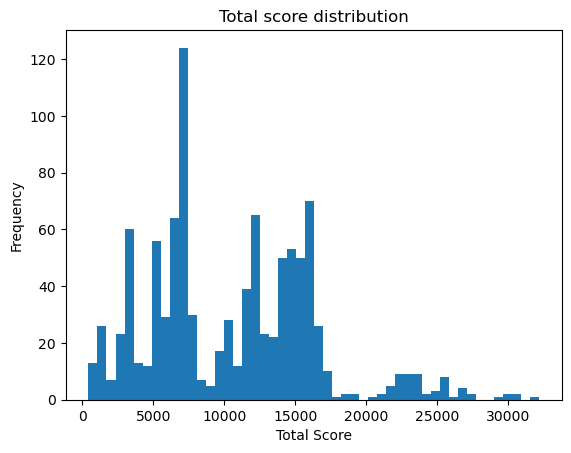

In [55]:
# Plot scores_DQN distribution
plt.hist(scores_DQN, bins = 50)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

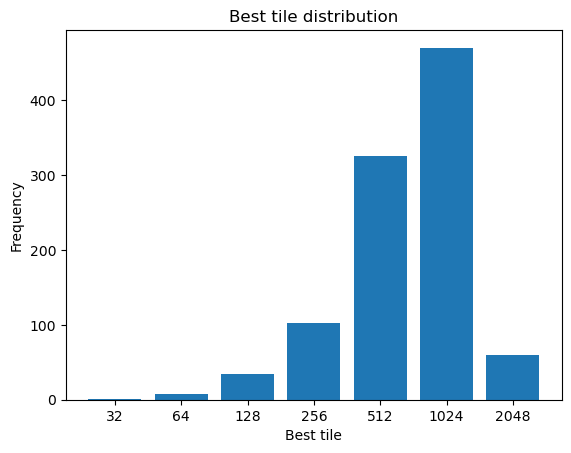

60


In [72]:
# Plot best_tiles_DQN distribution
max_power = int(math.log(max(best_tiles_DQN), 2)) + 1
min_power = int(math.log(min(best_tiles_DQN), 2))
unique, counts = np.unique(best_tiles_DQN, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()
print(best_tiles_DQN.count(2048))

In [57]:
best_tile_list = [128, 64, 32, 32, 64, 64, 64, 256, 64, 256, 64, 128, 32, 64, 256, 128, 64, 256, 64, 128, 128, 128, 128, 128, 128, 128, 128, 128, 64, 32, 64, 64, 128, 256, 128, 64, 128, 64, 128, 128, 64, 256, 256, 64, 32, 128, 128, 256, 128, 128, 256, 128, 128, 16, 256, 128, 128, 32, 256, 64, 128, 64, 128, 128, 128, 256, 128, 128, 256, 64, 128, 64, 128, 128, 128, 128, 128, 128, 128, 256, 64, 128, 128, 256, 128, 256, 64, 64, 128, 256, 128, 64, 64, 128, 64, 128, 32, 128, 128, 256, 128, 128, 256, 128, 64, 128, 64, 128, 256, 256, 128, 64, 256, 32, 256, 128, 128, 64, 128, 256, 64, 64, 128, 32, 64, 128, 128, 128, 256, 128, 128, 128, 128, 256, 128, 128, 128, 128, 128, 256, 128, 128, 128, 256, 128, 64, 256, 256, 256, 64, 128, 64, 128, 128, 128, 128, 128, 64, 128, 256, 64, 128, 128, 128, 128, 128, 256, 256, 256, 128, 128, 256, 128, 128, 64, 64, 64, 128, 64, 64, 128, 128, 128, 256, 128, 128, 128, 256, 128, 128, 64, 64, 128, 64, 128, 128, 256, 256, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 64, 128, 64, 256, 128, 64, 256, 64, 128, 128, 128, 256, 256, 256, 128, 128, 256, 64, 128, 128, 128, 256, 128, 128, 256, 128, 64, 128, 128, 128, 128, 256, 256, 256, 128, 64, 256, 64, 128, 256, 64, 128, 128, 256, 128, 256, 128, 256, 256, 32, 128, 128, 128, 128, 128, 128, 256, 128, 256, 256, 64, 128, 256, 64, 128, 128, 128, 256, 128, 128, 256, 256, 128, 256, 64, 128, 256, 256, 128, 256, 32, 128, 128, 256, 128, 256, 256, 256, 128, 256, 128, 256, 256, 256, 128, 128, 128, 256, 256, 256, 64, 128, 128, 128, 256, 128, 512, 128, 256, 128, 128, 256, 128, 256, 128, 128, 128, 128, 128, 64, 64, 128, 128, 256, 256, 256, 64, 256, 128, 128, 128, 256, 256, 128, 128, 128, 128, 128, 64, 256, 128, 128, 128, 256, 128, 64, 128, 128, 256, 256, 256, 128, 256, 256, 128, 64, 128, 128, 64, 128, 256, 128, 256, 512, 512, 128, 256, 128, 256, 128, 64, 256, 64, 128, 128, 128, 128, 128, 256, 128, 128, 256, 256, 128, 128, 256, 512, 256, 64, 128, 128, 256, 128, 128, 256, 128, 128, 128, 256, 128, 64, 128, 256, 64, 128, 256, 128, 64, 256, 512, 256, 64, 256, 256, 64, 128, 64, 256, 256, 512, 64, 256, 128, 128, 512, 256, 512, 256, 128, 256, 256, 128, 256, 256, 32, 128, 256, 128, 128, 128, 128, 128, 256, 64, 128, 256, 256, 128, 256, 32, 128, 256, 128, 256, 256, 128, 256, 256, 256, 512, 256, 128, 256, 256, 128, 256, 256, 64, 128, 128, 256, 256, 128, 256, 128, 256, 128, 128, 128, 256, 64, 128, 256, 256, 256, 256, 256, 256, 512, 128, 128, 128, 128, 256, 128, 256, 128, 256, 128, 128, 128, 512, 128, 128, 128, 64, 256, 256, 512, 256, 128, 128, 256, 128, 256, 128, 128, 64, 256, 64, 256, 128, 128, 128, 256, 128, 256, 128, 256, 256, 128, 512, 128, 256, 256, 512, 256, 256, 256, 256, 128, 256, 256, 128, 128, 256, 256, 128, 256, 128, 128, 256, 128, 256, 128, 256, 64, 128, 128, 64, 128, 256, 256, 256, 512, 256, 128, 256, 128, 256, 256, 128, 256, 256, 128, 128, 128, 512, 64, 256, 128, 256, 64, 128, 128, 256, 128, 128, 128, 256, 512, 128, 128, 128, 512, 128, 128, 128, 256, 256, 32, 64, 64, 256, 256, 128, 512, 128, 128, 128, 256, 256, 128, 128, 128, 256, 128, 256, 256, 256, 128, 128, 512, 256, 256, 256, 128, 128, 256, 128, 128, 256, 256, 128, 256, 256, 128, 256, 256, 512, 256, 128, 256, 256, 256, 128, 256, 256, 256, 128, 256, 256, 512, 128, 256, 256, 256, 256, 512, 128, 256, 256, 256, 256, 256, 256, 256, 128, 128, 256, 512, 128, 128, 256, 256, 128, 64, 256, 256, 256, 256, 128, 128, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 256, 128, 256, 64, 256, 128, 128, 256, 256, 128, 256, 256, 256, 256, 128, 512, 512, 256, 256, 256, 256, 128, 256, 64, 512, 256, 256, 128, 256, 256, 256, 256, 256, 256, 256, 256, 128, 256, 256, 256, 256, 256, 256, 128, 64, 128, 128, 128, 256, 128, 128, 256, 128, 128, 128, 256, 512, 256, 256, 128, 256, 256, 64, 256, 512, 256, 256, 512, 256, 128, 128, 128, 256, 256, 256, 256, 128, 256, 64, 128, 256, 256, 128, 128, 128, 128, 128, 64, 256, 256, 256, 256, 128, 128, 256, 256, 128, 128, 256, 512, 512, 128, 256, 128, 128, 256, 256, 64, 256, 256, 512, 256, 256, 64, 128, 512, 64, 128, 256, 256, 256, 256, 128, 128, 256, 512, 128, 128, 128, 512, 256, 128, 512, 128, 256, 256, 256, 256, 256, 128, 256, 128, 256, 256, 128, 128, 256, 32, 256, 512, 256, 512, 64, 512, 128, 256, 256, 128, 256, 512, 256, 128, 512, 256, 512, 128, 256, 256, 128, 128, 256, 256, 128, 256, 256, 256, 256, 256, 256, 256, 128, 256, 256, 128, 256, 256, 256, 256, 64, 256, 128, 128, 256, 128, 64, 128, 256, 256, 256, 64, 256, 256, 256, 128, 128, 128, 256, 128, 512, 128, 128, 128, 128, 64, 256, 256, 64, 256, 64, 512, 64, 256, 512, 512, 128, 256, 256, 128, 64, 128, 128, 128, 64, 256, 128, 256, 256, 256, 128, 128, 128, 128, 256, 256, 256, 128, 128, 256, 256, 128, 128, 256, 256, 128, 256, 256, 256, 128, 128, 256, 256, 128, 256, 128, 128, 256, 256, 128, 128, 128, 256, 128, 128, 128, 256, 256, 256, 128, 128, 256, 128, 256, 256, 256, 128, 128, 256, 256, 128, 128, 128, 256, 256, 64, 256, 128, 256, 128, 256, 128, 256, 256, 256, 128, 256, 128, 256, 128, 256, 128, 256, 256, 256, 128, 256, 256, 128, 64, 256, 256, 128, 128, 256, 256, 256, 128, 128, 256, 512, 256, 256, 128, 64, 256, 128, 128, 256, 64, 256, 256, 128, 256, 256, 128, 128, 256, 256, 128, 128, 512, 256, 512, 256, 256, 128, 64, 256, 256, 512, 128, 256, 128, 256, 256, 256, 512, 256, 256, 512, 128, 128, 256, 256, 128, 256, 512, 128, 128, 256, 128, 256, 512, 256, 256, 128, 128, 256, 256, 128, 128, 256, 256, 128, 128, 128, 256, 512, 128, 256, 256, 128, 64, 128, 128, 256, 256, 128, 128, 256, 256, 256, 256, 128, 128, 128, 128, 256, 256, 128, 128, 128, 128, 128, 256, 64, 128, 256, 512, 256, 512, 128, 256, 128, 128, 256, 128, 256, 128, 512, 128, 256, 256, 128, 256, 256, 64, 128, 128, 128, 256, 256, 128, 256, 128, 256, 128, 64, 256, 256, 128, 256, 128, 128, 128, 256, 256, 128, 256, 128, 512, 256, 256, 128, 128, 256, 256, 256, 256, 128, 256, 128, 256, 64, 128, 256, 128, 256, 256, 128, 256, 512, 256, 256, 128, 256, 256, 128, 256, 256, 256, 256, 512, 256, 64, 128, 256, 128, 256, 256, 256, 256, 128, 64, 256, 128, 256, 256, 128, 128, 256, 256, 256, 128, 128, 256, 256, 256, 512, 256, 256, 128, 256, 256, 128, 256, 128, 256, 512, 256, 256, 256, 256, 256, 64, 256, 128, 256, 256, 256, 64, 128, 256, 256, 128, 256, 64, 128, 128, 256, 128, 256, 256, 128, 256, 256, 256, 128, 128, 256, 256, 512, 256, 256, 128, 128, 128, 256, 256, 256, 128, 64, 256, 256, 256, 128, 512, 256, 128, 128, 256, 128, 256, 256, 512, 256, 256, 256, 256, 256, 64, 256, 128, 128, 256, 32, 256, 256, 256, 256, 512, 256, 64, 128, 256, 256, 256, 256, 256, 128, 128, 128, 512, 256, 256, 128, 128, 256, 256, 512, 64, 256, 64, 256, 256, 512, 256, 256, 256, 256, 512, 256, 256, 128, 64, 128, 128, 256, 256, 128, 256, 512, 256, 128, 128, 256, 256, 256, 256, 256, 512, 512, 128, 256, 256, 256, 256, 256, 128, 256, 256, 256, 256, 128, 256, 256, 128, 256, 256, 128, 256, 256, 256, 512, 256, 256, 256, 128, 128, 256, 256, 256, 256, 256, 128, 256, 128, 256, 256, 128, 256, 256, 256, 128, 128, 256, 128, 128, 128, 128, 256, 256, 256, 256, 256, 128, 256, 256, 512, 128, 256, 256, 256, 256, 256, 256, 512, 256, 256, 256, 32, 256, 128, 256, 256, 256, 256, 256, 512, 64, 256, 256, 128, 512, 256, 128, 128, 256, 256, 256, 32, 128, 128, 256, 256, 512, 256, 256, 256, 128, 256, 128, 256, 256, 256, 256, 128, 256, 128, 256, 128, 256, 64, 256, 256, 128, 128, 256, 256, 256, 256, 256, 256, 256, 256, 256, 128, 256, 256, 128, 128, 512, 256, 256, 128, 256, 256, 256, 512, 128, 128, 256, 128, 128, 512, 128, 128, 128, 256, 256, 256, 256, 128, 256, 256, 256, 256, 512, 32, 128, 256, 512, 256, 512, 128, 256, 256, 64, 256, 128, 256, 128, 256, 256, 256, 256, 128, 256, 256, 256, 256, 256, 128, 256, 512, 256, 128, 128, 256, 256, 256, 256, 256, 256, 128, 256, 128, 256, 256, 128, 256, 256, 256, 128, 64, 512, 256, 256, 64, 64, 256, 128, 256, 512, 512, 128, 64, 64, 128, 128, 256, 128, 128, 128, 256, 64, 64, 256, 128, 128, 256, 256, 256, 256, 256, 256, 256, 256, 128, 256, 128, 128, 64, 256, 256, 256, 256, 512, 256, 256, 128, 256, 256, 512, 256, 256, 128, 256, 256, 256, 256, 128, 256, 256, 256, 256, 128, 256, 256, 256, 512, 256, 128, 256, 64, 128, 256, 256, 256, 128, 128, 256, 256, 128, 512, 256, 256, 256, 256, 64, 128, 256, 256, 512, 128, 128, 256, 256, 512, 256, 128, 256, 128, 128, 256, 512, 256, 256, 256, 256, 256, 128, 128, 256, 256, 256, 512, 256, 128, 512, 512, 256, 256, 256, 256, 128, 128, 256, 256, 128, 128, 256, 128, 256, 128, 128, 128, 64, 256, 128, 256, 256, 128, 128, 128, 256, 128, 256, 128, 64, 256, 128, 128, 128, 64, 256, 256, 128, 256, 256, 256, 64, 128, 256, 256, 256, 256, 128, 64, 256, 256, 256, 256, 128, 256, 128, 256, 512, 256, 256, 256, 128, 512, 256, 128, 128, 128, 256, 128, 256, 256, 256, 256, 256, 128, 256, 128, 256, 256, 128, 128, 128, 128, 256, 256, 128, 256, 128, 256, 128, 256, 128, 128, 256, 256, 256, 256, 256, 128, 256, 128, 128, 512, 256, 128, 256, 128, 128, 128, 256, 256, 128, 512, 128, 64, 256, 256, 256, 256, 256, 128, 256, 256, 256, 256, 128, 256, 128, 256, 64, 256, 256, 256, 256, 256, 64, 128, 256, 256, 512, 512, 128, 512, 256, 64, 256, 256, 256, 256, 128, 256, 512, 128, 256, 512, 256, 256, 256, 128, 128, 128, 512, 256, 256, 256, 512, 256, 128, 256, 128, 512, 128, 256, 256, 256, 256, 256, 256, 256, 256, 256, 512, 512, 64, 256, 256, 512, 256, 256, 256, 256, 128, 128, 256, 256, 512, 256, 512, 256, 128, 128, 128, 64, 512, 256, 512, 512, 128, 512, 256, 512, 512, 256, 256, 128, 128, 256, 256, 512, 256, 256, 256, 512, 256, 128, 256, 512, 512, 128, 256, 256, 128, 128, 256, 256, 256, 256, 256, 128, 128, 256, 256, 128, 256, 256, 256, 256, 512, 256, 512, 256, 256, 512, 128, 128, 128, 256, 256, 256, 128, 128, 128, 64, 256, 256, 256, 256, 512, 256, 256, 64, 256, 128, 128, 128, 256, 64, 512, 256, 128, 512, 256, 512, 256, 256, 256, 256, 512, 128, 256, 256, 256, 256, 256, 256, 128, 128, 128, 128, 128, 128, 128, 64, 256, 128, 256, 256, 256, 128, 256, 256, 512, 256, 512, 256, 128, 256, 128, 128, 512, 256, 64, 256, 256, 512, 128, 256, 512, 256, 256, 128, 256, 64, 256, 256, 256, 128, 256, 256, 512, 256, 256, 256, 128, 256, 512, 512, 256, 128, 256, 512, 256, 256, 256, 256, 512, 512, 512, 512, 512, 512, 128, 256, 512, 128, 128, 256, 64, 256, 128, 512, 256, 64, 256, 256, 128, 256, 512, 256, 128, 256, 512, 256, 256, 256, 256, 256, 128, 128, 128, 256, 256, 256, 256, 256, 256, 128, 256, 512, 256, 128, 256, 128, 128, 256, 256, 512, 256, 512, 128, 128, 128, 256, 256, 256, 512, 128, 256, 128, 256, 256, 256, 256, 512, 256, 128, 512, 512, 128, 256, 128, 256, 256, 256, 256, 256, 256, 128, 512, 512, 256, 512, 512, 256, 128, 256, 256, 256, 128, 256, 256, 128, 256, 256, 512, 256, 256, 128, 256, 512, 512, 256, 256, 128, 128, 128, 256, 256, 256, 256, 128, 512, 256, 128, 128, 64, 128, 128, 256, 64, 512, 256, 64, 512, 128, 256, 256, 256, 64, 512, 256, 256, 256, 256, 256, 128, 512, 512, 512, 256, 256, 256, 512, 256, 256, 256, 256, 128, 64, 128, 512, 512, 256, 256, 512, 256, 256, 256, 256, 256, 256, 256, 32, 128, 512, 128, 256, 128, 256, 256, 256, 256, 32, 256, 256, 256, 512, 128, 512, 256, 256, 512, 256, 256, 256, 256, 512, 128, 256, 128, 256, 256, 128, 256, 256, 128, 256, 128, 256, 512, 128, 256, 512, 256, 128, 512, 256, 256, 256, 256, 64, 256, 128, 256, 256, 256, 512, 512, 64, 512, 128, 256, 512, 128, 512, 256, 256, 256, 128, 256, 256, 256, 256, 512, 512, 256, 256, 128, 128, 128, 512, 256, 128, 128, 512, 256, 256, 64, 256, 256, 128, 64, 512, 256, 256, 256, 256, 512, 256, 128, 512, 128, 256, 256, 256, 256, 128, 256, 64, 256, 128, 256, 128, 256, 128, 512, 128, 512, 128, 512, 512, 256, 256, 256, 256, 256, 512, 128, 256, 128, 512, 256, 128, 512, 256, 256, 256, 128, 128, 512, 512, 512, 512, 512, 128, 256, 256, 256, 256, 256, 128, 128, 128, 512, 128, 256, 256, 256, 256, 256, 256, 512, 256, 512, 128, 256, 128, 256, 256, 512, 256, 128, 256, 128, 256, 128, 512, 256, 128, 256, 128, 256, 256, 256, 256, 128, 256, 256, 256, 512, 512, 128, 128, 256, 256, 512, 256, 512, 256, 256, 512, 256, 256, 512, 512, 256, 256, 512, 256, 512, 256, 256, 128, 128, 512, 256, 256, 256, 256, 256, 256, 128, 256, 256, 256, 128, 64, 256, 256, 256, 512, 512, 256, 256, 128, 256, 256, 512, 256, 256, 256, 256, 256, 256, 512, 128, 256, 128, 256, 256, 128, 256, 128, 128, 64, 256, 256, 256, 256, 512, 256, 256, 256, 512, 256, 256, 512, 512, 128, 256, 256, 256, 128, 256, 128, 256, 256, 256, 128, 256, 256, 256, 256, 512, 256, 128, 256, 128, 128, 64, 32, 512, 256, 128, 256, 512, 128, 256, 256, 128, 512, 256, 128, 256, 64, 512, 512, 256, 256, 256, 256, 128, 512, 128, 256, 512, 256, 256, 512, 512, 32, 512, 256, 128, 256, 512, 512, 128, 512, 128, 128, 256, 128, 256, 512, 256, 512, 256, 512, 512, 256, 128, 512, 256, 256, 256, 128, 256, 256, 256, 256, 512, 256, 256, 512, 256, 256, 256, 256, 256, 256, 128, 512, 256, 256, 256, 256, 512, 128, 256, 512, 256, 256, 64, 128, 512, 256, 256, 256, 256, 512, 256, 512, 256, 64, 256, 128, 256, 512, 128, 512, 512, 256, 512, 64, 256, 128, 256, 128, 128, 256, 512, 256, 128, 512, 512, 256, 512, 256, 256, 256, 128, 256, 256, 256, 64, 64, 256, 256, 256, 256, 256, 128, 256, 256, 512, 256, 256, 256, 256, 512, 256, 256, 128, 256, 512, 256, 256, 128, 256, 512, 512, 128, 256, 512, 256, 256, 256, 256, 512, 256, 512, 256, 64, 512, 256, 512, 512, 128, 256, 512, 512, 256, 256, 256, 512, 256, 128, 256, 128, 256, 128, 512, 256, 256, 512, 128, 256, 256, 512, 128, 128, 256, 256, 128, 512, 512, 256, 512, 256, 256, 128, 256, 256, 512, 128, 512, 256, 256, 256, 128, 256, 512, 512, 256, 256, 256, 512, 512, 512, 256, 128, 512, 512, 512, 256, 512, 256, 256, 256, 256, 256, 256, 256, 512, 128, 256, 256, 256, 256, 256, 64, 256, 512, 256, 256, 256, 256, 128, 256, 128, 512, 128, 512, 512, 256, 256, 256, 256, 256, 512, 512, 256, 128, 256, 128, 256, 256, 512, 256, 512, 128, 128, 256, 512, 512, 256, 512, 256, 128, 256, 256, 256, 128, 512, 256, 256, 256, 512, 256, 512, 128, 256, 512, 256, 256, 256, 256, 256, 512, 256, 256, 512, 512, 256, 256, 512, 512, 128, 256, 256, 128, 256, 512, 256, 256, 256, 512, 128, 256, 64, 256, 128, 256, 256, 512, 256, 256, 256, 256, 256, 512, 256, 256, 512, 128, 256, 512, 512, 128, 512, 512, 512, 256, 256, 128, 512, 256, 256, 256, 512, 128, 512, 256, 256, 128, 512, 256, 256, 64, 512, 512, 128, 128, 128, 512, 512, 256, 128, 256, 128, 256, 256, 64, 256, 64, 128, 256, 256, 256, 256, 256, 512, 256, 256, 256, 256, 256, 128, 256, 256, 256, 256, 128, 128, 256, 256, 512, 256, 256, 128, 512, 256, 256, 512, 256, 512, 256, 128, 512, 512, 256, 512, 128, 256, 128, 256, 256, 512, 128, 256, 256, 256, 512, 1024, 128, 128, 256, 128, 256, 512, 256, 128, 512, 256, 128, 128, 512, 128, 512, 128, 256, 256, 256, 256, 256, 512, 256, 128, 512, 128, 64, 256, 512, 512, 512, 256, 256, 256, 256, 512, 256, 256, 512, 256, 256, 512, 128, 512, 256, 512, 512, 128, 256, 128, 128, 256, 128, 256, 512, 256, 256, 512, 512, 256, 128, 128, 64, 256, 256, 512, 256, 512, 256, 128, 128, 64, 128, 256, 256, 256, 256, 256, 256, 256, 64, 256, 512, 256, 128, 256, 256, 256, 512, 512, 256, 256, 512, 256, 256, 256, 512, 128, 128, 256, 64, 256, 256, 512, 512, 256, 512, 128, 1024, 512, 512, 512, 128, 64, 512, 512, 512, 512, 256, 256, 512, 64, 512, 256, 256, 128, 256, 512, 256, 256, 128, 512, 128, 256, 512, 256, 512, 512, 256, 256, 512, 512, 512, 128, 512, 256, 512, 256, 256, 128, 256, 512, 256, 512, 128, 256, 256, 128, 512, 256, 256, 256, 128, 512, 256, 128, 256, 128, 512, 256, 256, 128, 256, 256, 256, 512, 256, 256, 512, 512, 256, 512, 256, 128, 128, 64, 512, 128, 256, 256, 256, 128, 512, 256, 256, 256, 256, 512, 256, 256, 256, 512, 256, 128, 128, 128, 512, 256, 256, 128, 512, 256, 128, 256, 256, 512, 256, 512, 512, 256, 512, 256, 256, 64, 512, 512, 128, 256, 256, 512, 512, 512, 512, 64, 128, 256, 512, 512, 256, 256, 128, 256, 256, 256, 256, 256, 512, 128, 256, 256, 256, 256, 512, 128, 256, 256, 256, 128, 512, 512, 512, 256, 256, 128, 256, 256, 256, 256, 512, 256, 64, 128, 128, 256, 512, 512, 512, 128, 128, 256, 256, 512, 512, 512, 256, 512, 512, 128, 512, 512, 256, 256, 512, 128, 256, 128, 512, 512, 1024, 256, 256, 256, 256, 256, 512, 256, 256, 256, 256, 128, 256, 256, 512, 256, 512, 512, 256, 256, 256, 256, 1024, 512, 512, 128, 128, 512, 128, 256, 64, 256, 512, 256, 512, 512, 256, 512, 256, 256, 256, 256, 512, 128, 512, 256, 256, 256, 256, 256, 64, 512, 256, 512, 256, 512, 256, 256, 256, 512, 256, 64, 256, 256, 512, 128, 512, 256, 256, 512, 256, 256, 256, 256, 128, 256, 128, 256, 256, 256, 128, 128, 256, 256, 256, 512, 128, 512, 256, 512, 256, 512, 128, 128, 256, 256, 64, 512, 256, 256, 256, 512, 256, 256, 256, 512, 512, 512, 256, 512, 128, 512, 128, 256, 256, 256, 256, 256, 512, 512, 512, 512, 512, 256, 512, 256, 512, 256, 256, 512, 256, 256, 256, 512, 256, 128, 512, 256, 256, 512, 256, 256, 512, 512, 256, 512, 256, 128, 256, 512, 256, 256, 128, 256, 256, 256, 512, 256, 512, 128, 256, 512, 512, 128, 256, 128, 512, 512, 256, 128, 256, 256, 512, 512, 512, 256, 256, 128, 512, 512, 64, 128, 512, 256, 256, 128, 128, 512, 512, 256, 256, 512, 512, 256, 256, 256, 128, 256, 512, 512, 512, 512, 512, 128, 128, 512, 128, 128, 512, 256, 256, 256, 256, 512, 256, 512, 256, 512, 256, 128, 256, 256, 256, 256, 256, 256, 512, 128, 512, 256, 512, 128, 256, 256, 256, 512, 256, 256, 512, 256, 128, 256, 128, 256, 256, 256, 256, 64, 512, 256, 128, 128, 512, 128, 256, 256, 128, 64, 128, 256, 512, 256, 256, 512, 512, 256, 256, 256, 256, 128, 128, 256, 128, 256, 64, 128, 512, 512, 256, 512, 128, 256, 256, 512, 64, 256, 256, 256, 128, 128, 64, 256, 256, 256, 256, 256, 256, 512, 256, 512, 512, 512, 1024, 256, 128, 256, 256, 128, 512, 512, 256, 512, 128, 512, 256, 512, 256, 512, 512, 256, 256, 128, 128, 256, 256, 512, 128, 512, 128, 256, 256, 128, 512, 512, 256, 256, 512, 512, 512, 1024, 128, 256, 512, 256, 256, 128, 256, 256, 128, 128, 256, 128, 512, 512, 512, 256, 1024, 512, 256, 256, 128, 256, 128, 256, 256, 256, 256, 256, 256, 256, 512, 512, 512, 512, 512, 256, 512, 512, 512, 256, 512, 256, 256, 256, 512, 512, 128, 1024, 512, 512, 256, 256, 512, 512, 512, 512, 256, 256, 256, 256, 512, 256, 64, 128, 1024, 512, 256, 512, 256, 256, 64, 512, 128, 256, 256, 512, 128, 64, 256, 256, 128, 256, 256, 256, 512, 256, 128, 256, 512, 256, 512, 256, 256, 256, 128, 128, 1024, 256, 512, 512, 512, 256, 512, 256, 256, 512, 256, 256, 128, 256, 256, 512, 256, 128, 256, 512, 256, 256, 128, 512, 256, 128, 128, 256, 128, 128, 256, 512, 128, 512, 512, 256, 256, 512, 512, 512, 256, 512, 256, 256, 128, 512, 512, 256, 512, 512, 512, 256, 512, 512, 512, 256, 512, 512, 256, 512, 256, 512, 1024, 256, 512, 256, 256, 256, 256, 256, 256, 256, 512, 256, 256, 256, 512, 256, 512, 1024, 512, 1024, 256, 512, 512, 512, 512, 256, 128, 256, 512, 256, 256, 128, 256, 512, 256, 256, 512, 256, 512, 256, 512, 512, 256, 256, 256, 256, 256, 512, 16, 256, 256, 512, 128, 256, 512, 128, 512, 512, 512, 256, 256, 128, 1024, 128, 256, 512, 512, 256, 512, 512, 256, 256, 1024, 512, 512, 512, 256, 128, 256, 512, 512, 256, 256, 512, 512, 256, 512, 256, 512, 512, 256, 512, 512, 512, 512, 512, 512, 256, 256, 128, 512, 256, 1024, 256, 512, 256, 256, 512, 256, 512, 512, 256, 512, 512, 256, 128, 256, 512, 512, 128, 512, 512, 128, 256, 512, 256, 256, 256, 256, 512, 512, 256, 512, 512, 512, 256, 256, 512, 512, 256, 512, 256, 512, 512, 512, 256, 512, 256, 128, 512, 512, 512, 128, 512, 512, 512, 512, 256, 512, 256, 256, 128, 256, 512, 512, 512, 256, 128, 256, 256, 256, 128, 256, 256, 128, 256, 512, 256, 512, 256, 512, 512, 256, 128, 512, 256, 128, 512, 128, 256, 256, 128, 256, 512, 256, 512, 128, 512, 256, 128, 256, 512, 256, 512, 512, 512, 256, 256, 256, 256, 512, 256, 256, 512, 256, 512, 256, 256, 256, 256, 512, 128, 512, 512, 256, 128, 512, 512, 256, 128, 512, 512, 1024, 256, 512, 512, 256, 128, 512, 256, 512, 256, 256, 1024, 512, 256, 128, 512, 512, 128, 256, 512, 64, 256, 512, 512, 256, 256, 256, 512, 512, 128, 256, 512, 256, 256, 256, 1024, 512, 512, 512, 256, 256, 512, 256, 1024, 512, 512, 512, 256, 256, 128, 512, 512, 256, 256, 512, 512, 128, 512, 512, 512, 256, 256, 256, 256, 512, 256, 512, 256, 512, 512, 128, 128, 512, 256, 512, 512, 512, 512, 512, 128, 512, 256, 128, 512, 256, 256, 256, 512, 256, 256, 512, 128, 256, 256, 256, 512, 512, 256, 256, 512, 1024, 128, 64, 128, 256, 256, 128, 256, 512, 128, 512, 1024, 512, 128, 256, 512, 256, 64, 256, 512, 128, 256, 512, 128, 512, 256, 256, 256, 512, 256, 512, 512, 256, 512, 512, 64, 256, 512, 256, 256, 256, 128, 256, 512, 512, 128, 256, 512, 256, 512, 256, 512, 64, 512, 64, 512, 256, 256, 128, 512, 256, 512, 256, 512, 256, 256, 256, 256, 512, 256, 256, 512, 128, 128, 256, 1024, 256, 512, 256, 256, 512, 256, 256, 256, 512, 128, 256, 512, 128, 128, 256, 256, 128, 128, 512, 256, 256, 64, 256, 128, 128, 512, 512, 128, 512, 512, 256, 128, 128, 128, 128, 1024, 512, 512, 512, 1024, 512, 256, 256, 256, 512, 256, 256, 256, 256, 512, 512, 128, 512, 512, 512, 256, 512, 512, 256, 512, 512, 128, 256, 256, 256, 256, 512, 256, 512, 512, 256, 256, 256, 512, 256, 1024, 256, 256, 256, 128, 256, 512, 512, 128, 512, 512, 256, 512, 256, 512, 512, 512, 512, 512, 512, 256, 512, 512, 256, 256, 512, 256, 512, 1024, 256, 256, 256, 512, 256, 128, 512, 128, 128, 512, 512, 256, 512, 1024, 256, 256, 512, 256, 512, 512, 1024, 256, 256, 256, 512, 256, 64, 512, 512, 128, 512, 512, 256, 256, 512, 256, 256, 512, 512, 256, 256, 1024, 512, 512, 512, 64, 256, 512, 128, 512, 256, 256, 512, 512, 128, 128, 512, 512, 512, 256, 256, 64, 512, 512, 256, 512, 512, 256, 256, 256, 512, 512, 512, 256, 256, 128, 512, 256, 256, 256, 512, 256, 512, 256, 512, 256, 256, 256, 256, 128, 512, 1024, 256, 512, 512, 512, 128, 256, 256, 512, 128, 512, 256, 512, 512, 512, 256, 256, 128, 256, 512, 256, 128, 512, 128, 256, 256, 128, 256, 256, 128, 512, 512, 512, 512, 256, 256, 256, 512, 512, 256, 512, 512, 512, 128, 512, 512, 256, 512, 512, 512, 256, 256, 256, 512, 256, 128, 512, 128, 256, 1024, 512, 512, 128, 128, 512, 512, 512, 512, 256, 512, 256, 256, 256, 256, 256, 512, 256, 512, 256, 512, 512, 256, 128, 512, 512, 256, 512, 512, 256, 512, 256, 256, 256, 512, 256, 512, 128, 512, 512, 128, 128, 256, 256, 128, 512, 128, 512, 256, 256, 128, 256, 256, 512, 512, 512, 512, 256, 128, 512, 512, 512, 64, 256, 128, 256, 128, 256, 512, 1024, 1024, 128, 1024, 64, 1024, 512, 512, 64, 256, 512, 1024, 256, 256, 1024, 256, 128, 128, 128, 256, 128, 512, 256, 512, 256, 256, 512, 256, 512, 256, 256, 256, 1024, 1024, 1024, 256, 512, 512, 1024, 512, 256, 256, 256, 512, 256, 128, 512, 256, 512, 256, 128, 512, 512, 512, 1024, 256, 256, 128, 128, 128, 1024, 128, 512, 128, 256, 256, 512, 512, 256, 512, 256, 512, 512, 256, 512, 128, 256, 128, 512, 512, 64, 512, 256, 512, 256, 128, 512, 512, 256, 128, 128, 512, 256, 512, 256, 512, 1024, 512, 512, 512, 128, 512, 256, 512, 256, 512, 128, 512, 512, 256, 256, 256, 256, 512, 256, 256, 256, 256, 512, 512, 128, 512, 512, 512, 256, 512, 512, 512, 256, 64, 256, 32, 512, 64, 256, 256, 256, 512, 512, 512, 128, 512, 512, 512, 128, 256, 256, 1024, 256, 512, 256, 256, 512, 128, 512, 512, 256, 512, 512, 256, 256, 512, 256, 512, 512, 512, 512, 256, 512, 512, 256, 256, 512, 512, 1024, 128, 512, 128, 512, 512, 256, 256, 256, 1024, 256, 512, 256, 512, 512, 512, 512, 256, 256, 512, 256, 512, 128, 512, 256, 256, 512, 512, 512, 256, 256, 512, 256, 256, 512, 512, 256, 512, 256, 256, 256, 256, 256, 256, 256, 256, 128, 512, 512, 512, 256, 512, 512, 512, 512, 256, 256, 256, 512, 256, 512, 512, 512, 256, 128, 512, 512, 128, 512, 1024, 512, 512, 512, 512, 1024, 256, 1024, 512, 512, 1024, 256, 512, 1024, 1024, 128, 512, 128, 128, 256, 256, 256, 512, 512, 512, 512, 1024, 512, 128, 256, 512, 512, 1024, 256, 512, 128, 256, 128, 128, 512, 512, 512, 512, 512, 256, 512, 128, 128, 512, 512, 512, 128, 512, 512, 256, 512, 256, 1024, 512, 512, 256, 256, 512, 512, 1024, 512, 1024, 128, 512, 512, 128, 1024, 1024, 512, 256, 512, 512, 512, 256, 512, 512, 256, 512, 512, 512, 512, 512, 1024, 256, 512, 512, 512, 128, 512, 256, 1024, 256, 1024, 512, 512, 256, 512, 512, 512, 256, 512, 512, 256, 256, 256, 512, 256, 256, 1024, 128, 1024, 128, 512, 1024, 1024, 512, 256, 512, 512, 128, 256, 512, 256, 512, 512, 512, 512, 256, 1024, 128, 512, 256, 512, 512, 512, 1024, 256, 512, 1024, 512, 1024, 1024, 512, 256, 256, 128, 256, 256, 1024, 128, 128, 512, 512, 128, 512, 128, 512, 512, 512, 256, 512, 512, 256, 256, 512, 256, 256, 256, 1024, 256, 512, 512, 512, 512, 256, 256, 512, 512, 512, 512, 512, 64, 512, 512, 512, 256, 256, 512, 128, 256, 128, 512, 256, 256, 512, 512, 256, 512, 1024, 512, 256, 256, 1024, 512, 256, 256, 256, 128, 512, 512, 256, 256, 512, 512, 256, 256, 1024, 512, 512, 1024, 64, 512, 512, 512, 256, 512, 512, 256, 256, 256, 512, 1024, 512, 512, 256, 512, 512, 512, 1024, 1024, 256, 512, 512, 512, 256, 256, 512, 128, 128, 256, 1024, 256, 64, 512, 256, 512, 512, 512, 512, 256, 512, 512, 512, 256, 512, 256, 256, 256, 256, 256, 256, 128, 512, 128, 256, 512, 256, 512, 128, 512, 512, 256, 512, 512, 1024, 512, 128, 512, 256, 512, 1024, 512, 256, 512, 256, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 512, 512, 256, 512, 1024, 128, 32, 128, 128, 128, 64, 128, 128, 128, 64, 32, 64, 256, 128, 64, 128, 128, 128, 128, 128, 128, 128, 128, 256, 64, 64, 64, 64, 128, 256, 64, 256, 128, 64, 128, 128, 128, 256, 256, 64, 128, 256, 128, 128, 128, 128, 256, 256, 256, 128, 256, 256, 128, 32, 128, 128, 256, 128, 128, 256, 256, 128, 256, 256, 256, 256, 256, 256, 128, 512, 512, 128, 128, 128, 256, 256, 256, 512, 256, 64, 512, 128, 128, 512, 512, 256, 512, 256, 256, 128, 64, 256, 512, 512, 256, 512, 512, 256, 512, 256, 64, 512, 256, 256, 256, 64, 512, 256, 256, 256, 512, 512, 512, 512, 256, 256, 128, 512, 256, 1024, 512, 512, 512, 128, 256, 512, 512, 512, 512, 256, 256, 256, 256, 256, 256, 128, 512, 512, 128, 512, 512, 1024, 256, 1024, 1024, 512, 512, 256, 256, 128, 256, 512, 512, 64, 512, 512, 512, 256, 256, 512, 256, 256, 512, 512, 512, 512, 128, 512, 256, 1024, 128, 512, 256, 128, 128, 1024, 256, 512, 512, 512, 512, 512, 256, 256, 512, 128, 512, 256, 256, 512, 256, 512, 128, 256, 1024, 256, 512, 512, 64, 256, 256, 256, 64, 512, 1024, 512, 256, 512, 64, 256, 512, 512, 512, 512, 512, 512, 512, 512, 512, 256, 512, 512, 64, 512, 512, 256, 256, 512, 512, 512, 512, 512, 256, 1024, 256, 512, 256, 256, 256, 256, 128, 512, 1024, 512, 512, 512, 512, 512, 512, 256, 512, 256, 512, 128, 512, 512, 512, 256, 256, 512, 512, 256, 256, 256, 512, 256, 256, 256, 1024, 512, 1024, 512, 256, 256, 512, 512, 512, 512, 256, 512, 512, 256, 1024, 128, 512, 512, 128, 512, 512, 512, 256, 512, 256, 128, 512, 512, 512, 1024, 256, 256, 128, 512, 256, 512, 64, 512, 512, 256, 512, 512, 512, 512, 1024, 1024, 256, 512, 1024, 512, 512, 512, 256, 512, 512, 512, 512, 512, 256, 512, 256, 128, 256, 256, 128, 256, 1024, 256, 512, 512, 512, 512, 256, 512, 128, 512, 512, 512, 256, 512, 256, 256, 512, 256, 1024, 256, 256, 256, 256, 512, 512, 256, 128, 512, 256, 256, 1024, 1024, 256, 256, 512, 256, 256, 1024, 512, 512, 512, 256, 128, 512, 128, 512, 256, 512, 512, 1024, 512, 512, 64, 512, 256, 256, 256, 512, 256, 512, 256, 512, 512, 256, 512, 256, 256, 512, 256, 512, 512, 512, 512, 256, 256, 512, 1024, 1024, 512, 256, 512, 1024, 512, 512, 256, 512, 128, 512, 512, 256, 512, 512, 1024, 512, 256, 512, 128, 512, 256, 512, 128, 256, 1024, 512, 512, 256, 256, 1024, 512, 512, 512, 256, 256, 512, 512, 512, 1024, 512, 1024, 512, 512, 256, 256, 512, 256, 512, 256, 256, 128, 128, 512, 512, 64, 512, 256, 256, 512, 512, 512, 32, 1024, 512, 512, 128, 256, 512, 256, 1024, 256, 256, 512, 512, 256, 256, 512, 512, 128, 512, 256, 512, 1024, 512, 512, 256, 256, 256, 256, 256, 1024, 256, 512, 512, 128, 512, 512, 128, 256, 512, 512, 512, 256, 256, 512, 512, 1024, 128, 128, 256, 512, 1024, 512, 512, 128, 512, 256, 128, 512, 256, 512, 512, 1024, 512, 512, 512, 128, 512, 512, 256, 256, 256, 1024, 512, 1024, 1024, 512, 512, 512, 256, 512, 256, 512, 256, 1024, 128, 256, 512, 256, 512, 1024, 512, 256, 512, 512, 512, 512, 512, 512, 128, 128, 1024, 256, 512, 512, 512, 512, 512, 256, 256, 512, 512, 512, 512, 256, 512, 256, 256, 512, 512, 512, 512, 512, 512, 512, 512, 256, 256, 256, 1024, 256, 1024, 512, 512, 256, 1024, 128, 128, 512, 128, 512, 256, 512, 512, 1024, 512, 512, 512, 512, 128, 512, 512, 512, 256, 512, 1024, 512, 512, 512, 256, 512, 512, 512, 512, 256, 512, 1024, 512, 256, 512, 512, 256, 512, 256, 256, 512, 512, 512, 256, 1024, 256, 256, 256, 256, 512, 512, 512, 512, 1024, 1024, 512, 128, 512, 512, 1024, 512, 256, 512, 256, 1024, 512, 512, 1024, 512, 1024, 256, 512, 256, 256, 1024, 1024, 512, 256, 512, 512, 256, 512, 512, 512, 512, 512, 128, 1024, 512, 256, 256, 512, 1024, 1024, 256, 512, 256, 1024, 512, 512, 512, 512, 512, 512, 512, 512, 256, 512, 256, 1024, 1024, 512, 512, 128, 512, 512, 1024, 512, 256, 512, 128, 512, 2048, 256, 512, 256, 512, 512, 512, 512, 512, 512, 256, 1024, 512, 512, 1024, 512, 512, 512, 512, 512, 512, 256, 512, 1024, 512, 512, 512, 512, 512, 512, 256, 256, 1024, 256, 512, 256, 512, 512, 512, 1024, 1024, 512, 256, 512, 256, 512, 512, 512, 512, 512, 256, 512, 1024, 1024, 1024, 512, 512, 256, 128, 512, 256, 512, 256, 512, 256, 256, 1024, 128, 512, 512, 512, 128, 1024, 1024, 64, 128, 512, 1024, 128, 512, 1024, 512, 128, 512, 1024, 512, 256, 128, 64, 1024, 128, 256, 128, 1024, 128, 512, 1024, 256, 128, 256, 256, 1024, 256, 128, 512, 256, 512, 256, 1024, 256, 512, 256, 1024, 512, 256, 128, 256, 1024, 512, 256, 512, 256, 512, 512, 256, 256, 256, 128, 512, 256, 256, 256, 1024, 512, 512, 1024, 256, 512, 256, 128, 512, 1024, 512, 256, 1024, 512, 512, 128, 512, 1024, 512, 512, 512, 256, 512, 512, 256, 256, 256, 128, 512, 512, 512, 256, 512, 128, 1024, 1024, 256, 512, 256, 256, 256, 512, 512, 512, 256, 1024, 512, 128, 512, 256, 512, 512, 512, 1024, 256, 256, 512, 128, 512, 256, 512, 128, 256, 256, 128, 256, 1024, 1024, 64, 512, 512, 512, 128, 512, 512, 512, 256, 512, 512, 256, 512, 1024, 512, 1024, 1024, 1024, 256, 256, 128, 512, 256, 256, 512, 256, 256, 1024, 1024, 512, 512, 512, 512, 1024, 512, 512, 512, 512, 1024, 256, 256, 512, 256, 512, 64, 1024, 512, 512, 512, 256, 512, 512, 512, 512, 256, 128, 1024, 256, 512, 64, 1024, 512, 256, 128, 512, 512, 256, 512, 512, 256, 256, 256, 128, 512, 1024, 128, 512, 512, 64, 512, 256, 1024, 256, 512, 256, 512, 512, 512, 512, 256, 1024, 128, 256, 512, 256, 512, 1024, 1024, 256, 512, 256, 1024, 512, 512, 128, 256, 128, 512, 512, 512, 512, 256, 256, 512, 512, 512, 512, 128, 512, 512, 256, 512, 512, 512, 1024, 256, 256, 1024, 256, 512, 1024, 512, 512, 512, 64, 512, 128, 512, 256, 256, 512, 512, 512, 512, 1024, 256, 1024, 512, 128, 512, 512, 512, 256, 512, 128, 256, 512, 512, 256, 128, 256, 128, 512, 128, 256, 512, 256, 512, 256, 512, 1024, 64, 128, 256, 512, 256, 1024, 512, 128, 512, 256, 256, 512, 128, 512, 512, 512, 1024, 1024, 64, 512, 1024, 512, 512, 512, 512, 512, 1024, 1024, 256, 256, 64, 1024, 256, 1024, 512, 1024, 1024, 1024, 256, 1024, 64, 512, 1024, 1024, 512, 256, 256, 512, 1024, 128, 1024, 512, 1024, 512, 512, 256, 512, 1024, 1024, 1024, 256, 64, 256, 512, 1024, 512, 256, 1024, 1024, 512, 128, 1024, 512, 256, 512, 512, 512, 512, 1024, 512, 512, 256, 256, 1024, 512, 256, 512, 512, 512, 128, 128, 512, 128, 512, 256, 512, 512, 256, 512, 512, 512, 256, 512, 512, 128, 512, 256, 64, 1024, 512, 512, 1024, 256, 512, 128, 256, 512, 256, 512, 512, 512, 512, 1024, 512, 512, 256, 512, 512, 512, 512, 512, 1024, 512, 256, 256, 256, 1024, 512, 512, 256, 256, 256, 512, 256, 512, 512, 512, 256, 512, 512, 512, 512, 512, 128, 1024, 1024, 1024, 256, 128, 256, 256, 512, 512, 1024, 512, 2048, 512, 1024, 128, 1024, 512, 1024, 256, 256, 512, 256, 1024, 256, 512, 512, 512, 1024, 512, 128, 256, 512, 256, 512, 512, 1024, 512, 512, 1024, 512, 512, 512, 512, 256, 512, 128, 512, 512, 512, 256, 256, 256, 1024, 1024, 512, 512, 256, 512, 64, 1024, 1024, 512, 512, 512, 512, 1024, 512, 512, 512, 256, 2048, 128, 256, 512, 512, 256, 1024, 256, 128, 512, 1024, 1024, 64, 512, 512, 128, 512, 1024, 512, 512, 512, 512, 512, 512, 256, 512, 1024, 128, 1024, 128, 512, 512, 512, 1024, 256, 512, 128, 256, 256, 512, 512, 512, 512, 512, 256, 1024, 512, 256, 1024, 512, 512, 512, 256, 128, 512, 256, 256, 1024, 64, 256, 128, 1024, 512, 256, 128, 1024, 512, 512, 512, 512, 64, 256, 512, 256, 512, 256, 512, 512, 256, 256, 128, 512, 256, 1024, 512, 512, 256, 512, 256, 512, 128, 256, 256, 512, 256, 256, 512, 512, 256, 1024, 512, 256, 512, 256, 512, 1024, 32, 512, 512, 256, 512, 512, 256, 512, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 512, 512, 1024, 512, 512, 256, 512, 1024, 1024, 512, 256, 512, 256, 512, 512, 1024, 512, 512, 512, 256, 512, 512, 1024, 512, 512, 1024, 1024, 512, 512, 512, 1024, 512, 512, 512, 512, 512, 1024, 512, 512, 512, 256, 512, 512, 512, 512, 1024, 256, 512, 512, 1024, 512, 512, 1024, 1024, 512, 256, 256, 1024, 512, 512, 1024, 512, 512, 512, 256, 512, 512, 512, 1024, 1024, 512, 512, 512, 256, 512, 1024, 512, 512, 512, 256, 256, 256, 512, 1024, 256, 1024, 1024, 512, 1024, 512, 1024, 512, 256, 512, 128, 256, 512, 1024, 512, 512, 512, 256, 128, 128, 1024, 128, 512, 512, 256, 64, 512, 512, 256, 512, 512, 512, 1024, 512, 128, 512, 512, 64, 256, 512, 1024, 256, 128, 256, 512, 1024, 1024, 256, 512, 512, 512, 512, 512, 512, 512, 512, 1024, 512, 512, 512, 1024, 256, 1024, 512, 1024, 512, 1024, 512, 512, 512, 256, 128, 256, 512, 512, 512, 256, 512, 512, 512, 512, 512, 512, 512, 512, 256, 1024, 1024, 256, 512, 256, 512, 512, 512, 512, 256, 256, 512, 512, 512, 512, 512, 256, 512, 256, 512, 1024, 1024, 512, 512, 1024, 1024, 256, 512, 512, 512, 128, 256, 512, 512, 512, 512, 512, 1024, 512, 512, 256, 512, 256, 256, 256, 512, 1024, 512, 512, 256, 256, 256, 256, 1024, 512, 128, 512, 1024, 512, 512, 512, 1024, 512, 1024, 512, 256, 512, 512, 256, 256, 512, 512, 512, 512, 512, 1024, 512, 512, 1024, 512, 512, 256, 512, 256, 512, 256, 128, 1024, 512, 256, 1024, 256, 512, 1024, 512, 512, 512, 512, 256, 512, 512, 512, 512, 64, 1024, 512, 512, 512, 512, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 128, 1024, 512, 512, 512, 128, 512, 512, 256, 128, 1024, 512, 256, 512, 512, 512, 512, 512, 512, 1024, 512, 512, 512, 256, 512, 512, 512, 512, 1024, 512, 1024, 256, 512, 1024, 128, 1024, 512, 512, 512, 1024, 512, 256, 512, 256, 1024, 512, 512, 512, 512, 512, 256, 1024, 256, 512, 128, 1024, 128, 1024, 512, 128, 1024, 1024, 512, 256, 512, 512, 512, 256, 512, 512, 512, 512, 1024, 512, 1024, 512, 512, 512, 256, 1024, 256, 256, 1024, 256, 128, 512, 256, 256, 512, 256, 512, 256, 512, 512, 256, 512, 1024, 128, 512, 512, 512, 1024, 256, 1024, 256, 256, 256, 512, 512, 512, 256, 512, 512, 1024, 128, 1024, 512, 512, 512, 256, 1024, 512, 512, 512, 512, 256, 1024, 1024, 512, 512, 512, 512, 256, 512, 256, 1024, 256, 512, 512, 256, 256, 512, 1024, 512, 512, 512, 256, 512, 512, 512, 1024, 1024, 512, 512, 512, 512, 512, 512, 512, 1024, 1024, 512, 128, 512, 512, 1024, 512, 1024, 256, 512, 1024, 256, 256, 64, 256, 256, 512, 512, 1024, 512, 1024, 512, 1024, 512, 512, 512, 128, 1024, 1024, 256, 1024, 512, 1024, 256, 512, 512, 1024, 512, 512, 1024, 256, 1024, 1024, 256, 1024, 512, 256, 512, 512, 512, 1024, 1024, 512, 1024, 1024, 512, 256, 512, 1024, 512, 256, 512, 512, 1024, 512, 256, 256, 1024, 1024, 1024, 128, 1024, 1024, 256, 256, 512, 512, 256, 512, 512, 1024, 1024, 1024, 1024, 128, 256, 256, 1024, 512, 1024, 256, 512, 512, 1024, 256, 512, 512, 512, 128, 1024, 512, 1024, 512, 1024, 512, 128, 512, 64, 512, 1024, 1024, 1024, 256, 1024, 512, 1024, 512, 1024, 256, 512, 512, 256, 64, 256, 1024, 512, 256, 512, 1024, 512, 512, 1024, 512, 512, 512, 1024, 512, 512, 1024, 128, 256, 512, 1024, 256, 512, 512, 512, 512, 1024, 1024, 1024, 1024, 512, 512, 256, 1024, 1024, 512, 512, 256, 512, 512, 1024, 256, 512, 1024, 64, 512, 512, 512, 1024, 512, 1024, 1024, 512, 512, 512, 512, 1024, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 256, 512, 1024, 512, 256, 512, 256, 512, 512, 512, 1024, 512, 1024, 512, 512, 512, 1024, 512, 1024, 128, 1024, 512, 1024, 256, 256, 1024, 1024, 512, 128, 512, 512, 1024, 256, 1024, 512, 512, 256, 1024, 512, 512, 256, 256, 512, 512, 1024, 512, 512, 128, 512, 256, 1024, 512, 1024, 512, 512, 512, 256, 512, 512, 512, 512, 512, 512, 256, 1024, 512, 1024, 512, 1024, 256, 128, 512, 1024, 512, 256, 512, 256, 512, 512, 256, 256, 512, 1024, 512, 256, 128, 256, 128, 128, 1024, 1024, 512, 512, 1024, 256, 64, 512, 1024, 512, 512, 256, 512, 1024, 1024, 512, 512, 512, 1024, 256, 512, 1024, 1024, 512, 256, 512, 1024, 1024, 256, 1024, 1024, 1024, 512, 128, 128, 1024, 512, 1024, 512, 1024, 512, 512, 256, 1024, 1024, 1024, 1024, 1024, 512, 1024, 512, 128, 512, 512, 512, 1024, 1024, 512, 512, 256, 512, 1024, 1024, 512, 256, 1024, 512, 512, 1024, 256, 256, 64, 256, 512, 1024, 512, 256, 128, 256, 512, 1024, 512, 128, 512, 2048, 512, 128, 512, 256, 256, 256, 512, 512, 512, 128, 1024, 512, 512, 1024, 512, 1024, 512, 512, 256, 512, 512, 512, 128, 256, 512, 512, 1024, 1024, 512, 1024, 256, 512, 1024, 512, 512, 256, 256, 1024, 256, 512, 512, 512, 1024, 1024, 1024, 512, 512, 1024, 512, 1024, 256, 256, 512, 512, 512, 512, 1024, 256, 512, 1024, 256, 128, 512, 1024, 512, 512, 256, 512, 512, 512, 1024, 512, 512, 512, 256, 512, 512, 128, 512, 256, 512, 1024, 1024, 1024, 256, 1024, 1024, 256, 1024, 512, 512, 256, 1024, 1024, 128, 128, 512, 512, 256, 1024, 128, 512, 512, 256, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 512, 512, 512, 512, 256, 512, 512, 128, 1024, 256, 512, 512, 512, 1024, 512, 256, 1024, 1024, 256, 512, 1024, 256, 512, 1024, 512, 1024, 512, 512, 512, 512, 512, 512, 512, 256, 512, 256, 1024, 512, 1024, 256, 1024, 512, 1024, 512, 256, 256, 128, 128, 1024, 1024, 256, 512, 512, 256, 512, 512, 512, 1024, 1024, 512, 256, 512, 512, 512, 256, 512, 256, 512, 512, 1024, 512, 256, 512, 256, 128, 256, 512, 512, 512, 512, 128, 512, 256, 64, 256, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 256, 512, 512, 1024, 1024, 512, 256, 512, 256, 256, 256, 512, 1024, 512, 256, 1024, 128, 512, 1024, 256, 512, 512, 512, 256, 1024, 256, 512, 1024, 1024, 512, 1024, 512, 512, 1024, 256, 256, 512, 512, 1024, 512, 256, 256, 512, 512, 256, 256, 512, 256, 256, 256, 256, 512, 512, 512, 256, 1024, 512, 1024, 128, 1024, 512, 256, 1024, 512, 512, 1024, 256, 256, 512, 512, 512, 512, 512, 256, 512, 512, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 2048, 256, 128, 1024, 512, 1024, 256, 256, 512, 512, 512, 1024, 512, 1024, 512, 128, 512, 512, 1024, 512, 128, 512, 512, 256, 256, 1024, 512, 1024, 1024, 128, 512, 512, 512, 1024, 256, 512, 512, 512, 1024, 256, 1024, 512, 512, 256, 512, 1024, 512, 512, 512, 32, 256, 512, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 1024, 256, 1024, 256, 1024, 1024, 512, 1024, 512, 512, 256, 512, 512, 64, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 512, 512, 1024, 256, 256, 256, 1024, 512, 512, 256, 512, 256, 512, 512, 1024, 1024, 512, 256, 512, 512, 512, 512, 1024, 512, 512, 512, 1024, 512, 512, 1024, 512, 512, 1024, 128, 1024, 256, 256, 512, 1024, 512, 512, 256, 512, 1024, 512, 64, 512, 512, 512, 1024, 512, 1024, 512, 512, 256, 512, 128, 1024, 1024, 512, 1024, 1024, 256, 1024, 512, 512, 1024, 256, 512, 512, 128, 512, 128, 512, 1024, 1024, 512, 512, 1024, 1024, 512, 1024, 256, 512, 1024, 1024, 64, 512, 512, 512, 1024, 512, 512, 1024, 512, 1024, 1024, 1024, 512, 512, 256, 512, 512, 512, 512, 512, 512, 1024, 1024, 512, 512, 512, 512, 1024, 1024, 256, 1024, 256, 512, 64, 2048, 512, 512, 512, 2048, 128, 1024, 512, 512, 512, 1024, 512, 256, 1024, 256, 256, 1024, 1024, 256, 1024, 512, 256, 1024, 1024, 512, 64, 512, 1024, 1024, 512, 128, 512, 256, 512, 512, 256, 256, 512, 256, 128, 512, 512, 256, 256, 256, 512, 128, 512, 256, 256, 256, 128, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 256, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512, 512, 256, 128, 512, 512, 512, 256, 512, 512, 1024, 1024, 512, 512, 256, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 512, 512, 1024, 512, 512, 512, 512, 512, 512, 1024, 1024, 128, 1024, 1024, 512, 512, 512, 256, 512, 1024, 256, 256, 512, 1024, 256, 1024, 256, 512, 1024, 1024, 512, 256, 512, 512, 512, 512, 512, 512, 512, 512, 1024, 512, 256, 512, 1024, 1024, 1024, 128, 256, 1024, 1024, 512, 512, 1024, 1024, 256, 1024, 512, 512, 256, 1024, 512, 256, 512, 512, 512, 512, 1024, 256, 256, 512, 1024, 512, 512, 128, 256, 1024, 256, 256, 1024, 512, 1024, 512, 256, 1024, 1024, 256, 512, 512, 1024, 512, 512, 1024, 512, 512, 128, 1024, 1024, 1024, 256, 256, 1024, 512, 256, 128, 1024, 1024, 1024, 512, 512, 256, 1024, 128, 512, 512, 128, 1024, 1024, 512, 512, 512, 512, 512, 256, 512, 1024, 512, 512, 256, 256, 512, 1024, 512, 1024, 512, 512, 256, 1024, 512, 1024, 128, 512, 128, 256, 512, 512, 512, 512, 1024, 512, 1024, 128, 512, 1024, 256, 512, 1024, 1024, 256, 256, 512, 1024, 256, 256, 512, 512, 128, 512, 1024, 512, 256, 256, 512, 512, 512, 256, 1024, 256, 1024, 512, 512, 512, 128, 1024, 1024, 512, 512, 2048, 512, 64, 256, 512, 512, 512, 256, 1024, 256, 512, 1024, 256, 256, 512, 128, 128, 256, 1024, 1024, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 128, 512, 256, 256, 1024, 512, 1024, 1024, 128, 256, 256, 1024, 1024, 1024, 256, 512, 128, 512, 512, 1024, 512, 256, 1024, 1024, 512, 512, 512, 1024, 1024, 256, 512, 128, 512, 512, 512, 1024, 1024, 2048, 256, 512, 1024, 512, 64, 256, 512, 512, 64, 512, 1024, 512, 1024, 512, 512, 512, 1024, 512, 1024, 512, 512, 512, 1024, 256, 256, 256, 512, 64, 256, 1024, 512, 1024, 128, 512, 1024, 1024, 256, 256, 256, 256, 512, 512, 1024, 512, 1024, 512, 1024, 1024, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 256, 1024, 1024, 512, 1024, 2048, 512, 1024, 1024, 512, 512, 128, 256, 256, 512, 512, 1024, 512, 1024, 512, 128, 1024, 1024, 512, 512, 512, 512, 1024, 256, 512, 512, 1024, 1024, 512, 256, 512, 512, 1024, 512, 256, 512, 256, 512, 1024, 1024, 256, 1024, 512, 512, 512, 512, 256, 512, 1024, 1024, 1024, 512, 64, 1024, 2048, 512, 128, 512, 512, 512, 2048, 2048, 512, 128, 1024, 512, 512, 512, 1024, 256, 512, 512, 1024, 256, 512, 2048, 256, 1024, 1024, 512, 1024, 256, 512, 2048, 512, 512, 2048, 512, 1024, 512, 1024, 512, 256, 512, 1024, 512, 1024, 2048, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 512, 512, 512, 256, 1024, 1024, 1024, 512, 512, 2048, 512, 512, 512, 128, 512, 512, 256, 256, 128, 512, 1024, 512, 256, 256, 1024, 128, 1024, 512, 512, 512, 256, 256, 128, 256, 256, 128, 1024, 512, 512, 512, 512, 1024, 1024, 512, 256, 512, 1024, 512, 1024, 256, 1024, 1024, 512, 512, 512, 256, 256, 1024, 1024, 512, 1024, 1024, 512, 1024, 512, 256, 1024, 1024, 512, 1024, 512, 512, 1024, 256, 1024, 1024, 512, 256, 512, 256, 512, 256, 512, 1024, 256, 512, 1024, 512, 2048, 1024, 512, 512, 1024, 512, 512, 1024, 512, 256, 1024, 128, 256, 1024, 1024, 1024, 512, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 256, 256, 512, 512, 256, 1024, 512, 1024, 512, 1024, 1024, 1024, 512, 512, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 256, 512, 128, 512, 1024, 1024, 256, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512, 256, 1024, 1024, 256, 1024, 512, 1024, 512, 512, 1024, 1024, 256, 512, 1024, 1024, 512, 512, 512, 512, 128, 512, 512, 512, 256, 512, 1024, 512, 256, 512, 1024, 256, 512, 256, 1024, 512, 512, 1024, 1024, 512, 1024, 256, 1024, 1024, 512, 128, 1024, 512, 1024, 512, 512, 1024, 256, 2048, 512, 512, 512, 512, 512, 512, 256, 1024, 128, 512, 512, 512, 512, 1024, 512, 1024, 256, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 512, 1024, 512, 1024, 512, 256, 1024, 512, 1024, 128, 1024, 512, 512, 512, 1024, 2048, 1024, 512, 128, 512, 512, 512, 128, 512, 1024, 512, 1024, 128, 256, 1024, 1024, 512, 512, 512, 512, 256, 512, 1024, 1024, 512, 512, 512, 512, 256, 512, 512, 256, 512, 512, 1024, 1024, 512, 512, 256, 256, 256, 256, 128, 512, 256, 1024, 512, 512, 1024, 1024, 512, 512, 64, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 128, 512, 256, 256, 256, 256, 1024, 1024, 1024, 512, 512, 1024, 1024, 256, 1024, 512, 1024, 512, 512, 512, 512, 512, 256, 512, 512, 256, 1024, 512, 512, 512, 64, 512, 256, 512, 512, 1024, 512, 256, 1024, 1024, 256, 512, 1024, 1024, 256, 256, 1024, 1024, 512, 1024, 1024, 256, 1024, 1024, 512, 512, 512, 1024, 128, 512, 1024, 1024, 512, 512, 256, 512, 512, 256, 256, 512, 1024, 512, 256, 128, 1024, 1024, 512, 512, 1024, 256, 512, 1024, 256, 128, 256, 512, 512, 256, 1024, 512, 1024, 256, 256, 512, 256, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 512, 256, 512, 512, 512, 512, 256, 512, 512, 1024, 1024, 512, 512, 256, 1024, 256, 256, 512, 512, 1024, 1024, 512, 512, 512, 128, 1024, 512, 512, 512, 1024, 256, 512, 512, 512, 512, 512, 512, 1024, 1024, 256, 256, 512, 512, 1024, 512, 1024, 512, 256, 1024, 1024, 256, 512, 64, 512, 1024, 128, 1024, 256, 512, 256, 1024, 512, 256, 128, 1024, 512, 512, 1024, 1024, 64, 512, 256, 1024, 256, 512, 512, 1024, 256, 64, 2048, 512, 512, 1024, 256, 1024, 512, 256, 1024, 512, 1024, 256, 512, 1024, 128, 512, 512, 1024, 1024, 1024, 1024, 128, 1024, 256, 512, 512, 512, 512, 1024, 256, 1024, 512, 512, 256, 1024, 1024, 512, 128, 512, 512, 1024, 512, 256, 512, 1024, 1024, 512, 1024, 1024, 1024, 128, 512, 1024, 1024, 256, 1024, 512, 512, 128, 128, 256, 512, 1024, 512, 512, 512, 512, 512, 128, 1024, 512, 256, 512, 512, 512, 2048, 1024, 1024, 512, 1024, 512, 1024, 512, 128, 1024, 512, 512, 1024, 1024, 512, 256, 256, 512, 1024, 1024, 1024, 512, 512, 256, 256, 1024, 512, 1024, 1024, 128, 512, 1024, 64, 512, 512, 256, 512, 1024, 512, 128, 512, 512, 512, 512, 1024, 1024, 1024, 1024, 512, 256, 1024, 512, 1024, 512, 512, 1024, 1024, 1024, 512, 1024, 512, 512, 512, 512, 512, 1024, 512, 512, 512, 1024, 512, 1024, 512, 512, 512, 512, 512, 256, 512, 512, 512, 512, 2048, 256, 512, 1024, 1024, 1024, 512, 512, 256, 1024, 1024, 1024, 512, 1024, 256, 512, 1024, 256, 256, 512, 512, 256, 128, 1024, 512, 512, 256, 512, 1024, 256, 1024, 512, 1024, 256, 1024, 1024, 512, 1024, 512, 512, 1024, 512, 1024, 512, 128, 512, 128, 512, 1024, 256, 1024, 256, 256, 256, 256, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 512, 256, 512, 512, 1024, 128, 256, 512, 512, 512, 128, 256, 512, 1024, 256, 512, 256, 256, 1024, 1024, 512, 512, 1024, 512, 512, 512, 256, 512, 512, 512, 512, 1024, 128, 512, 512, 512, 1024, 512, 256, 256, 256, 1024, 1024, 1024, 256, 1024, 512, 2048, 1024, 1024, 512, 512, 256, 512, 1024, 512, 512, 512, 512, 1024, 512, 2048, 512, 1024, 512, 1024, 1024, 512, 256, 256, 512, 256, 1024, 512, 512, 512, 512, 1024, 512, 1024, 1024, 512, 512, 64, 512, 512, 1024, 1024, 512, 512, 256, 512, 1024, 2048, 1024, 128, 1024, 512, 256, 256, 512, 1024, 1024, 512, 512, 256, 512, 256, 256, 512, 1024, 64, 512, 512, 1024, 1024, 256, 512, 512, 256, 512, 512, 1024, 512, 512, 1024, 1024, 256, 1024, 256, 512, 1024, 1024, 512, 256, 512, 512, 1024, 1024, 1024, 1024, 128, 2048, 256, 1024, 1024, 1024, 512, 512, 512, 1024, 256, 1024, 512, 512, 512, 512, 1024, 512, 512, 512, 512, 512, 2048, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 1024, 512, 512, 1024, 512, 1024, 1024, 1024, 512, 128, 256, 512, 1024, 512, 1024, 512, 512, 1024, 1024, 512, 1024, 512, 1024, 1024, 512, 256, 1024, 512, 64, 1024, 512, 1024, 1024, 512, 1024, 1024, 512, 2048, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512, 128, 1024, 1024, 1024, 1024, 128, 1024, 256, 512, 512, 1024, 512, 512, 256, 512, 256, 1024, 1024, 1024, 1024, 512, 512, 256, 512, 256, 1024, 2048, 1024, 1024, 256, 2048, 256, 512, 512, 256, 1024, 256, 256, 256, 1024, 1024, 512, 512, 1024, 1024, 512, 1024, 512, 512, 512, 128, 512, 512, 512, 128, 512, 2048, 1024, 512, 256, 512, 1024, 1024, 512, 256, 1024, 1024, 256, 512, 1024, 1024, 256, 1024, 512, 512, 256, 1024, 512, 1024, 512, 1024, 512, 1024, 512, 512, 512, 1024, 1024, 512, 512, 256, 1024, 512, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 1024, 512, 512, 256, 1024, 1024, 1024, 128, 1024, 256, 512, 512, 512, 512, 1024, 512, 1024, 32, 512, 512, 256, 512, 512, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 256, 1024, 2048, 512, 256, 2048, 512, 1024, 512, 1024, 512, 64, 512, 512, 1024, 1024, 1024, 256, 512, 1024, 512, 1024, 256, 1024, 1024, 256, 512, 512, 256, 512, 512, 1024, 512, 1024, 1024, 512, 512, 1024, 512, 512, 512, 512, 512, 256, 1024, 512, 512, 1024, 1024, 1024, 128, 1024, 1024, 512, 128, 512, 1024, 1024, 1024, 256, 512, 1024, 256, 1024, 1024, 1024, 512, 1024, 1024, 512, 256, 512, 1024, 128, 1024, 512, 2048, 256, 1024, 128, 256, 256, 1024, 128, 512, 512, 256, 1024, 512, 512, 1024, 1024, 256, 1024, 512, 512, 256, 512, 1024, 2048, 1024, 1024, 1024, 256, 1024, 1024, 512, 256, 512, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 512, 512, 512, 1024, 512, 1024, 512, 512, 512, 256, 512, 1024, 1024, 1024, 1024, 512, 512, 128, 1024, 256, 1024, 1024, 512, 256, 512, 256, 256, 1024, 512, 128, 512, 512, 512, 128, 1024, 512, 512, 1024, 512, 512, 512, 1024, 512, 1024, 512, 256, 1024, 1024, 256, 1024, 512, 512, 512, 512, 1024, 512, 1024, 512, 512, 256, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 256, 512, 1024, 1024, 256, 128, 1024, 512, 1024, 1024, 1024, 256, 512, 512, 1024, 1024, 512, 128, 512, 1024, 1024, 1024, 1024, 256, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 256, 512, 2048, 1024, 1024, 256, 512, 512, 512, 1024, 1024, 512, 512, 512, 512, 2048, 512, 1024, 512, 256, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 1024, 1024, 256, 512, 1024, 2048, 512, 1024, 512, 1024, 512, 2048, 256, 512, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 512, 512, 1024, 1024, 512, 1024, 1024, 256, 1024, 512, 1024, 1024, 512, 512, 1024, 1024, 256, 1024, 1024, 512, 512, 512, 512, 1024, 1024, 1024, 512, 1024, 512, 256, 1024, 256, 1024, 512, 512, 512, 512, 512, 512, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 256, 512, 512, 1024, 128, 1024, 256, 256, 512, 512, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 256, 1024, 1024, 256, 1024, 1024, 2048, 1024, 256, 1024, 1024, 512, 512, 1024, 1024, 512, 128, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 1024, 1024, 1024, 256, 256, 1024, 512, 128, 1024, 1024, 1024, 512, 1024, 1024, 512, 512, 1024, 1024, 256, 128, 1024, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 256, 128, 1024, 1024, 256, 512, 128, 1024, 512, 512, 128, 256, 1024, 256, 1024, 1024, 512, 512, 2048, 512, 256, 1024, 512, 512, 128, 1024, 512, 128, 1024, 1024, 512, 256, 1024, 512, 1024, 2048, 256, 512, 1024, 512, 128, 1024, 1024, 1024, 1024, 512, 512, 512, 128, 1024, 512, 1024, 2048, 1024, 1024, 512, 512, 256, 1024, 256, 256, 512, 1024, 1024, 512, 512, 128, 1024, 256, 256, 1024, 512, 512, 1024, 512, 512, 256, 512, 1024, 512, 1024, 256, 1024, 512, 1024, 512, 256, 256, 512, 1024, 1024, 256, 1024, 1024, 256, 512, 256, 512, 256, 1024, 512, 1024, 128, 512, 256, 256, 512, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 256, 1024, 512, 512, 1024, 512, 256, 512, 1024, 1024, 1024, 1024, 1024, 1024, 128, 512, 256, 1024, 128, 512, 1024, 512, 1024, 1024, 512, 256, 512, 1024, 512, 512, 1024, 256, 256, 512, 1024, 512, 256, 1024, 512, 1024, 256, 512, 1024, 128, 512, 128, 64, 512, 1024, 512, 1024, 2048, 256, 128, 1024, 512, 256, 128, 512, 512, 512, 1024, 1024, 2048, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 256, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 512, 512, 512, 1024, 512, 256, 512, 256, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 256, 512, 128, 512, 128, 512, 1024, 1024, 256, 1024, 512, 1024, 256, 1024, 1024, 1024, 512, 512, 1024, 256, 128, 256, 512, 1024, 256, 1024, 512, 512, 1024, 512, 128, 256, 256, 1024, 1024, 128, 512, 512, 512, 1024, 512, 1024, 256, 256, 256, 1024, 512, 256, 512, 256, 1024, 1024, 512, 512, 1024, 1024, 256, 512, 1024, 1024, 1024, 128, 512, 512, 512, 512, 128, 1024, 1024, 128, 128, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 512, 256, 1024, 1024, 512, 1024, 1024, 2048, 512, 256, 512, 512, 1024, 512, 256, 512, 512, 256, 256, 64, 512, 64, 1024, 256, 1024, 256, 512, 512, 2048, 1024, 2048, 1024, 512, 1024, 1024, 2048, 512, 1024, 1024, 512, 256, 1024, 1024, 256, 512, 1024, 256, 1024, 1024, 1024, 1024, 1024, 512, 256, 256, 512, 2048, 1024, 512, 2048, 512, 512, 256, 512, 512, 2048, 1024, 512, 1024, 1024, 1024, 32, 128, 512, 512, 512, 256, 512, 256, 1024, 512, 1024, 1024, 512, 512, 512, 256, 512, 1024, 512, 1024, 1024, 1024, 1024, 512, 256, 256, 512, 512, 512, 1024, 1024, 1024, 512, 512, 1024, 256, 256, 256, 1024, 1024, 512, 512, 1024, 1024, 1024, 512, 256, 256, 1024, 512, 1024, 1024, 256, 1024, 512, 1024, 512, 128, 512, 1024, 512, 256, 1024, 1024, 128, 512, 512, 512, 512, 256, 512, 1024, 512, 512, 512, 1024, 256, 128, 512, 1024, 512, 1024, 1024, 256, 1024, 1024, 1024, 1024, 256, 1024, 512, 1024, 512, 256, 512, 256, 1024, 512, 1024, 512, 512, 512, 512, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 256, 1024, 1024, 512, 2048, 2048, 1024, 128, 256, 128, 512, 512, 1024, 512, 128, 512, 2048, 512, 1024, 2048, 1024, 2048, 2048, 1024, 1024, 256, 1024, 2048, 1024, 512, 512, 1024, 512, 128, 2048, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 256, 512, 256, 128, 1024, 256, 256, 256, 512, 1024, 1024, 256, 256, 256, 1024, 128, 1024, 1024, 1024, 512, 1024, 512, 1024, 512, 256, 512, 1024, 1024, 128, 1024, 512, 1024, 128, 2048, 64, 1024, 512, 1024, 256, 1024, 512, 1024, 512, 512, 128, 1024, 512, 1024, 1024, 256, 256, 512, 1024, 1024, 1024, 256, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 64, 1024, 256, 1024, 512, 1024, 256, 512, 2048, 1024, 512, 512, 512, 1024, 512, 512, 512, 512, 1024, 1024, 256, 1024, 1024, 512, 1024, 512, 512, 1024, 512, 512, 512, 256, 256, 1024, 1024, 512, 512, 512, 1024, 512, 2048, 512, 1024, 512, 512, 512, 1024, 2048, 512, 512, 256, 2048, 2048, 1024, 256, 1024, 1024, 512, 1024, 512, 512, 256, 1024, 512, 2048, 1024, 512, 1024, 512, 1024, 256, 512, 512, 2048, 512, 1024, 1024, 512, 1024, 128, 256, 1024, 2048, 512, 512, 256, 1024, 512, 1024, 2048, 512, 512, 256, 1024, 1024, 1024, 512, 512, 1024, 256, 1024, 2048, 512, 1024, 512, 1024, 1024, 1024, 512, 512, 256, 512, 512, 512, 512, 256, 1024, 256, 1024, 512, 1024, 512, 512, 1024, 1024, 512, 256, 1024, 512, 1024, 512, 512, 256, 256, 256, 256, 1024, 256, 128, 1024, 256, 1024, 512, 512, 512, 1024, 256, 512, 2048, 512, 1024, 512, 1024, 512, 1024, 256, 256, 256, 256, 256, 512, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 256, 512, 1024, 512, 512, 512, 1024, 1024, 512, 512, 256, 256, 512, 512, 2048, 512, 1024, 1024, 512, 512, 512, 1024, 128, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 512, 512, 1024, 128, 1024, 1024, 1024, 512, 512, 512, 512, 512, 256, 128, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 128, 1024, 1024, 1024, 512, 512, 1024, 256, 1024, 128, 512, 1024, 256, 1024, 512, 256, 512, 512, 256, 1024, 512, 512, 256, 256, 1024, 256, 2048, 256, 512, 256, 1024, 1024, 256, 512, 1024, 1024, 1024, 512, 512, 256, 1024, 1024, 512, 512, 512, 512, 1024, 1024, 512, 512, 512, 256, 1024, 512, 1024, 128, 512, 512, 128, 512, 1024, 512, 256, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 256, 256, 512, 64, 512, 1024, 512, 512, 256, 512, 1024, 1024, 512, 256, 1024, 512, 1024, 512, 1024, 512, 1024, 512, 512, 512, 1024, 512, 1024, 1024, 256, 512, 512, 2048, 1024, 512, 256, 512, 256, 512, 512, 1024, 1024, 512, 512, 512, 512, 512, 1024, 1024, 512, 128, 1024, 256, 128, 1024, 512, 1024, 1024, 512, 512, 1024, 512, 1024, 256, 512, 1024, 1024, 256, 512, 256, 1024, 512, 512, 1024, 2048, 512, 1024, 1024, 512, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 1024, 256, 512, 1024, 256, 1024, 512, 512, 256, 1024, 512, 512, 256, 256, 1024, 1024, 1024, 64, 512, 512, 512, 512, 256, 1024, 1024, 512, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 512, 256, 1024, 1024, 256, 1024, 512, 256, 512, 256, 256, 1024, 1024, 256, 1024, 1024, 512, 512, 1024, 1024, 512, 512, 1024, 256, 1024, 1024, 256, 512, 512, 512, 1024, 1024, 512, 1024, 128, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 256, 512, 1024, 512, 512, 1024, 512, 512, 256, 512, 512, 512, 256, 1024, 512, 1024, 512, 1024, 512, 256, 1024, 512, 1024, 512, 512, 512, 256, 512, 512, 256, 2048, 1024, 128, 512, 512, 512, 512, 256, 512, 512, 512, 2048, 512, 1024, 256, 1024, 512, 512, 128, 512, 512, 512, 1024, 1024, 512, 512, 256, 256, 512, 1024, 512, 512, 512, 1024, 512, 2048, 512, 1024, 256, 256, 512, 1024, 1024, 1024, 256, 1024, 1024, 1024, 512, 256, 1024, 512, 1024, 1024, 512, 256, 1024, 1024, 1024, 512, 1024, 128, 256, 512, 512, 512, 1024, 1024, 512, 1024, 1024, 1024, 512, 256, 1024, 2048, 512, 1024, 1024, 512, 256, 2048, 1024, 1024, 512, 1024, 256, 512, 512, 1024, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 512, 512, 1024, 512, 2048, 512, 1024, 1024, 512, 256, 512, 1024, 1024, 128, 512, 256, 512, 512, 512, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 512, 128, 512, 256, 512, 1024, 1024, 512, 256, 512, 128, 1024, 256, 512, 256, 512, 1024, 1024, 1024, 256, 1024, 1024, 256, 1024, 512, 256, 512, 512, 512, 1024, 1024, 512, 1024, 512, 1024, 1024, 512, 1024, 1024, 512, 512, 512, 512, 1024, 1024, 1024, 512, 1024, 256, 512, 1024, 512, 512, 1024, 512, 512, 256, 1024, 1024, 1024, 1024, 512, 256, 1024, 1024, 256, 512, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 512, 512, 512, 512, 512, 1024, 512, 128, 1024, 512, 1024, 512, 512, 1024, 256, 512, 512, 1024, 1024, 512, 256, 1024, 2048, 1024, 256, 1024, 512, 512, 1024, 512, 1024, 256, 512, 1024, 256, 512, 512, 512, 1024, 512, 512, 512, 512, 512, 512, 1024, 2048, 1024, 512, 1024, 512, 1024, 512, 1024, 512, 512, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 512, 256, 1024, 1024, 2048, 256, 1024, 1024, 512, 512, 512, 512, 128, 256, 512, 1024, 1024, 512, 512, 1024, 256, 512, 1024, 512, 512, 1024, 2048, 512, 512, 1024, 512, 512, 512, 512, 512, 512, 512, 128, 1024, 256, 512, 256, 1024, 128, 2048, 512, 1024, 256, 1024, 1024, 512, 512, 512, 1024, 512, 512, 512, 2048, 1024, 512, 512, 1024, 256, 128, 1024, 512, 512, 1024, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 512, 512, 256, 512, 512, 2048, 512, 1024, 256, 256, 512, 1024, 1024, 256, 1024, 128, 1024, 512, 128, 256, 256, 256, 1024, 1024, 1024, 64, 256, 512, 1024, 1024, 1024, 256, 1024, 512, 256, 1024, 1024, 256, 256, 1024, 2048, 1024, 1024, 1024, 512, 2048, 1024, 128, 512, 1024, 1024, 512, 1024, 512, 64, 128, 512, 1024, 512, 512, 512, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 512, 512, 256, 1024, 2048, 512, 64, 1024, 2048, 512, 1024, 512, 1024, 512, 512, 512, 64, 1024, 512, 1024, 1024, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 256, 256, 256, 1024, 1024, 512, 1024, 1024, 256, 512, 256, 512, 1024, 512, 1024, 256, 1024, 1024, 256, 1024, 512, 512, 512, 256, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 1024, 1024, 512, 1024, 1024, 512, 1024, 2048, 512, 256, 64, 512, 1024, 256, 1024, 1024, 512, 512, 1024, 512, 512, 512, 256, 1024, 1024, 64, 512, 512, 512, 512, 512, 2048, 1024, 2048, 512, 512, 128, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 512, 512, 1024, 1024, 512, 512, 1024, 512, 1024, 256, 1024, 2048, 512, 1024, 512, 512, 1024, 1024, 256, 1024, 256, 1024, 1024, 1024, 512, 1024, 256, 512, 1024, 512, 512, 1024, 1024, 512, 512, 1024, 256, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 1024, 1024, 512, 512, 1024, 1024, 1024, 1024, 512, 128, 256, 2048, 512, 2048, 512, 512, 1024, 256, 1024, 512, 1024, 512, 512, 512, 1024, 1024, 512, 512, 256, 512, 1024, 1024, 512, 2048, 512, 512, 512, 512, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 1024, 512, 1024, 1024, 256, 1024, 256, 512, 1024, 512, 1024, 512, 256, 512, 1024, 256, 1024, 1024, 512, 512, 1024, 1024, 1024, 512, 1024, 1024, 1024, 256, 512, 256, 1024, 1024, 256, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 1024, 256, 1024, 256, 512, 1024, 512, 512, 512, 1024, 512, 512, 512, 1024, 1024, 256, 512, 2048, 1024, 256, 512, 256, 256, 1024, 1024, 1024, 512, 2048, 512, 512, 128, 256, 1024, 1024, 1024, 512, 256, 1024, 256, 512, 2048, 2048, 256, 1024, 256, 2048, 1024, 512, 1024, 512, 1024, 2048, 1024, 1024, 1024, 128, 512, 1024, 512, 512, 1024, 256, 1024, 512, 256, 1024, 512, 256, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 256, 1024, 1024, 256, 1024, 1024, 2048, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 512, 128, 512, 1024, 256, 512, 1024, 512, 512, 512, 512, 256, 128, 512, 1024, 1024, 1024, 512, 512, 1024, 1024, 256, 1024, 512, 1024, 1024, 256, 512, 1024, 256, 512, 1024, 1024, 256, 1024, 1024, 1024, 1024, 2048, 1024, 512, 256, 2048, 256, 2048, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 512, 512, 1024, 2048, 64, 512, 512, 1024, 128, 256, 1024, 1024, 512, 128, 1024, 1024, 512, 1024, 256, 1024, 512, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 512, 1024, 256, 512, 512, 1024, 1024, 1024, 256, 256, 1024, 1024, 1024, 1024, 512, 1024, 256, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 256, 256, 512, 256, 1024, 512, 512, 256, 1024, 1024, 512, 1024, 1024, 128, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 64, 512, 2048, 512, 128, 512, 512, 2048, 256, 1024, 512, 512, 1024, 512, 1024, 512, 256, 1024, 1024, 512, 2048, 512, 512, 1024, 512, 256, 1024, 1024, 1024, 1024, 256, 1024, 512, 1024, 1024, 256, 1024, 512, 1024, 512, 512, 512, 256, 2048, 256, 1024, 1024, 1024, 128, 1024, 1024, 1024, 1024, 1024, 128, 1024, 1024, 512, 1024, 512, 2048, 512, 2048, 1024, 128, 256, 1024, 256, 1024, 512, 1024, 512, 512, 2048, 1024, 1024, 256, 512, 1024, 1024, 1024, 512, 512, 1024, 512, 1024, 1024, 512, 1024, 2048, 512, 1024, 512, 256, 512, 1024, 256, 2048, 2048, 1024, 1024, 512, 512, 1024, 512, 1024, 512, 1024, 1024, 1024, 256, 512, 1024, 512, 1024, 512, 512, 128, 256, 1024, 1024, 1024, 256, 512, 128, 1024, 128, 1024, 1024, 256, 1024, 512, 512, 512, 1024, 512, 1024, 256, 1024, 1024, 512, 1024, 512, 128, 512, 512, 1024, 1024, 512, 512, 1024, 512, 2048, 512, 512, 1024, 512, 128, 512, 512, 1024, 1024, 512, 1024, 512, 512, 512, 2048, 1024, 2048, 512, 1024, 1024, 1024, 512, 1024, 512, 1024, 256, 512, 1024, 256, 1024, 512, 1024, 1024, 128, 1024, 512, 1024, 1024, 1024, 512, 1024, 2048, 2048, 1024, 1024, 2048, 1024, 1024, 512, 1024, 128, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 256, 512, 1024, 256, 256, 128, 512, 512, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 256, 1024, 1024, 512, 1024, 512, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 256, 512, 1024, 512, 512, 512, 512, 128, 512, 256, 512, 1024, 1024, 256, 512, 512, 256, 512, 1024, 2048, 2048, 1024, 1024, 1024, 512, 1024, 1024, 1024, 2048, 512, 1024, 1024, 512, 256, 1024, 128, 512, 512, 256, 1024, 1024, 1024, 1024, 512, 512, 1024, 128, 256, 512, 1024, 1024, 1024, 512, 1024, 512, 512, 256, 1024, 512, 1024, 512, 512, 256, 64, 256, 512, 512, 1024, 512, 1024, 512, 512, 256, 1024, 1024, 1024, 512, 1024, 1024, 512, 128, 256, 1024, 256, 1024, 512, 512, 2048, 1024, 128, 512, 512, 2048, 512, 1024, 1024, 512, 1024, 512, 1024, 512, 2048, 1024, 512, 1024, 256, 512, 1024, 256, 512, 512, 1024, 512, 1024, 256, 1024, 512, 2048, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 512, 64, 512, 256, 1024, 1024, 1024, 512, 256, 1024, 512, 1024, 512, 512, 128, 256, 1024, 512, 1024, 1024, 512, 1024, 2048, 512, 1024, 1024, 128, 1024, 512, 1024, 1024, 1024, 1024, 256, 512, 256, 1024, 1024, 2048, 1024, 256, 512, 1024, 512, 512, 512, 1024, 512, 512, 1024, 256, 512, 1024, 512, 512, 256, 1024, 1024, 1024, 512, 1024, 256, 1024, 1024, 512, 512, 1024, 1024, 1024, 512, 256, 512, 512, 1024, 256, 512, 1024, 1024, 1024, 1024, 256, 256, 1024, 512, 512, 1024, 512, 1024, 512, 512, 512, 512, 1024, 1024, 1024, 128, 512, 128, 1024, 1024, 1024, 1024, 1024, 512, 1024, 128, 512, 512, 256, 512, 256, 256, 128, 512, 1024, 512, 1024, 256, 1024, 512, 512, 128, 512, 1024, 1024, 1024, 512, 512, 1024, 512, 1024, 2048, 512, 512, 1024, 512, 512, 1024, 512, 512, 1024, 256, 512, 1024, 512, 1024, 1024, 256, 1024, 256, 64, 1024, 1024, 512, 512, 1024, 128, 1024, 256, 2048, 1024, 1024, 512, 512, 512, 1024, 64, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 512, 1024, 1024, 256, 2048, 1024, 1024, 128, 1024, 128, 1024, 1024, 512, 1024, 512, 1024, 128, 512, 1024, 256, 256, 1024, 512, 128, 512, 128, 512, 1024, 512, 512, 512, 512, 512, 256, 512, 1024, 32, 512, 512, 256, 1024, 256, 2048, 2048, 512, 128, 256, 1024, 1024, 256, 256, 1024, 512, 1024, 512, 1024, 512, 256, 512, 1024, 1024, 256, 512, 512, 128, 128, 256, 1024, 2048, 1024, 512, 512, 1024, 1024, 1024, 1024, 256, 256, 1024, 256, 256, 2048, 1024, 1024, 512, 512, 512, 1024, 256, 512, 512, 512, 1024, 256, 512, 512, 512, 1024, 256, 512, 64, 1024, 1024, 1024, 512, 512, 128, 1024, 512, 1024, 512, 256, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 1024, 512, 1024, 1024, 1024, 1024, 512, 512, 512, 256, 512, 512, 512, 256, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 512, 2048, 1024, 256, 512, 512, 1024, 256, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 64, 2048, 1024, 1024, 256, 1024, 1024, 1024, 1024, 512, 512, 128, 1024, 1024, 256, 128, 256, 1024, 128, 128, 512, 1024, 256, 256, 1024, 1024, 512, 1024, 128, 1024, 128, 512, 512, 1024, 512, 1024, 1024, 128, 512, 512, 256, 512, 2048, 256, 128, 1024, 1024, 256, 1024, 128, 1024, 1024, 1024, 512, 256, 512, 1024, 1024, 128, 256, 128, 256, 512, 512, 512, 1024, 512, 512, 1024, 512, 2048, 1024, 512, 256, 512, 2048, 2048, 1024, 512, 512, 1024, 128, 512, 512, 2048, 256, 1024, 512, 1024, 1024, 512, 1024, 512, 256, 2048, 512, 512, 2048, 1024, 512, 1024, 512, 1024, 512, 1024, 1024, 1024, 256, 128, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 128, 512, 512, 1024, 1024, 256, 1024, 1024, 256, 512, 512, 256, 512, 1024, 1024, 512, 1024, 1024, 256, 512, 128, 1024, 512, 256, 2048, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 512, 256, 1024, 512, 1024, 512, 1024, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 256, 512, 512, 512, 1024, 1024, 2048, 256, 1024, 2048, 512, 1024, 256, 512, 1024, 1024, 128, 1024, 512, 1024, 1024, 1024, 512, 2048, 1024, 1024, 128, 256, 1024, 2048, 512, 1024, 512, 1024, 1024, 512, 256, 1024, 256, 512, 1024, 512, 512, 512, 512, 1024, 512, 1024, 512, 1024, 512, 512, 1024, 512, 512, 512, 256, 256, 512, 512, 1024, 2048, 1024, 1024, 512, 512, 512, 1024, 1024, 512, 1024, 1024, 1024, 1024, 128, 512, 1024, 512, 512, 2048, 512, 1024, 1024, 1024, 512, 1024, 256, 128, 1024, 1024, 256, 1024, 256, 1024, 512, 512, 1024, 256, 128, 512, 256, 1024, 1024, 1024, 512, 128, 512, 1024, 1024, 512, 1024, 512, 512, 512, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 128, 2048, 512, 1024, 1024, 512, 1024, 1024, 1024, 256, 512, 512, 1024, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 128, 1024, 1024, 512, 512, 512, 1024, 512, 512, 256, 512, 1024, 2048, 512, 1024, 256, 1024, 1024, 512, 512, 2048, 1024, 512, 512, 1024, 1024, 256, 512, 1024, 128, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 128, 1024, 1024, 1024, 512, 256, 1024, 2048, 1024, 1024, 1024, 512, 256, 512, 2048, 1024, 512, 1024, 1024, 1024, 1024, 512, 128, 256, 1024, 512, 512, 512, 1024, 512, 512, 512, 256, 1024, 2048, 512, 512, 1024, 1024, 1024, 1024, 512, 256, 128, 256, 1024, 2048, 512, 256, 1024, 512, 256, 1024, 512, 1024, 256, 256, 1024, 256, 512, 256, 1024, 512, 256, 1024, 1024, 512, 256, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 2048, 256, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 128, 512, 1024, 512, 1024, 512, 1024, 1024, 128, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 1024, 256, 1024, 1024, 256, 256, 512, 256, 512, 256, 512, 1024, 512, 1024, 1024, 512, 1024, 512, 128, 2048, 512, 1024, 512, 1024, 512, 1024, 512, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 1024, 512, 1024, 256, 1024, 512, 512, 512, 2048, 512, 1024, 2048, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 2048, 256, 1024, 256, 1024, 256, 2048, 2048, 512, 512, 1024, 1024, 256, 256, 1024, 1024, 512, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 1024, 256, 1024, 256, 512, 512, 1024, 512, 1024, 256, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 512, 512, 128, 2048, 256, 512, 512, 512, 512, 512, 1024, 1024, 2048, 512, 2048, 512, 1024, 1024, 256, 512, 512, 512, 512, 1024, 512, 256, 512, 1024, 1024, 512, 512, 512, 256, 1024, 1024, 1024, 512, 512, 2048, 512, 128, 512, 1024, 1024, 1024, 512, 1024, 512, 512, 1024, 512, 256, 1024, 256, 1024, 1024, 512, 512, 512, 1024, 512, 512, 2048, 512, 512, 512, 1024, 1024, 512, 1024, 512, 1024, 256, 512, 1024, 512, 512, 512, 1024, 512, 1024, 2048, 2048, 1024, 256, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 1024, 2048, 1024, 1024, 1024, 256, 512, 1024, 1024, 1024, 1024, 1024, 256, 256, 1024, 1024, 1024, 128, 1024, 1024, 512, 1024, 512, 1024, 512, 1024, 512, 1024, 1024, 512, 1024, 512, 1024, 1024, 512, 256, 1024, 1024, 2048, 1024, 512, 256, 512, 256, 128, 1024, 1024, 1024, 1024, 1024, 2048, 512, 512, 512, 512, 512, 2048, 1024, 512, 1024, 512, 1024, 1024, 256, 1024, 256, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 128, 1024, 512, 1024, 1024, 512, 1024, 512, 1024, 512, 1024, 1024, 1024, 128, 1024, 1024, 64, 2048, 1024, 1024, 512, 512, 1024, 1024, 2048, 1024, 1024, 1024, 512, 1024, 512, 1024, 256, 256, 256, 1024, 1024, 512, 1024, 512, 512, 1024, 512, 512, 128, 512, 256, 1024, 1024, 2048, 256, 1024, 2048, 512, 1024, 512, 512, 512, 1024, 512, 1024, 512, 1024, 1024, 256, 512, 1024, 1024, 512, 1024, 1024, 256, 1024, 256, 2048, 2048, 512, 1024, 1024, 512, 512, 2048, 1024, 128, 512, 512, 256, 2048, 1024, 512, 512, 512, 1024, 512, 512, 1024, 256, 512, 256, 1024, 2048, 2048, 512, 2048, 128, 512, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 512, 1024, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 1024, 1024, 512, 1024, 512, 512, 256, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 2048, 2048, 1024, 256, 512, 1024, 2048, 1024, 2048, 1024, 1024, 256, 2048, 1024, 256, 1024, 512, 1024, 512, 1024, 2048, 1024, 512, 1024, 512, 1024, 256, 2048, 1024, 256, 1024, 512, 2048, 256, 1024, 512, 2048, 512, 512, 1024, 512, 1024, 256, 256, 1024, 1024, 1024, 1024, 512, 2048, 1024, 1024, 1024, 1024, 1024, 256, 512, 512, 2048, 1024, 256, 512, 1024, 512, 512, 1024, 256, 1024, 512, 256, 1024, 512, 512, 1024, 1024, 1024, 256, 256, 1024, 128, 64, 512, 1024, 1024, 512, 1024, 1024, 1024, 1024, 256, 256, 512, 1024, 1024, 1024, 1024, 512, 256, 1024, 256, 1024, 1024, 1024, 512, 1024, 1024, 512, 256, 512, 512, 512, 2048, 512, 512, 2048, 1024, 512, 512, 1024, 1024, 256, 256, 512, 1024, 1024, 512, 1024, 1024, 512, 1024, 2048, 512, 1024, 1024, 2048, 2048, 1024, 1024, 512, 2048, 512, 256, 1024, 512, 1024, 1024, 1024, 1024, 2048, 1024, 256, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 512, 256, 1024, 128, 512, 1024, 1024, 2048, 1024, 512, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 1024, 2048, 2048, 512, 1024, 1024, 1024, 2048, 1024, 1024, 512, 1024, 1024, 512, 512, 256, 2048, 1024, 256, 512, 128, 1024, 1024, 256, 1024, 1024, 256, 512, 512, 512, 512, 1024, 1024, 1024, 2048, 512, 1024, 128, 1024, 512, 1024, 1024, 1024, 256, 512, 512, 512, 128, 1024, 1024, 512, 256, 1024, 1024, 256, 2048, 512, 512, 512, 1024, 512, 512, 512, 512, 1024, 256, 1024, 1024, 512, 256, 64, 1024, 512, 512, 512, 1024, 256, 1024, 512, 1024, 1024, 512, 256, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 256, 2048, 512, 1024, 1024, 1024, 256, 64, 1024, 256, 1024, 512, 1024, 512, 512, 512, 1024, 256, 1024, 1024, 1024, 512, 2048, 512, 256, 256, 2048, 1024, 2048, 2048, 1024, 1024, 2048, 128, 128, 512, 2048, 1024, 256, 1024, 256, 1024, 256, 2048, 128, 2048, 1024, 128, 512, 128, 512, 64, 1024, 128, 256, 1024, 512, 1024, 1024, 1024, 1024, 512, 1024, 512, 512, 512, 512, 2048, 512, 512, 512, 1024, 1024, 128, 256, 2048, 512, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 256, 1024, 1024, 1024, 512, 512, 256, 512, 1024, 1024, 256, 512, 2048, 256, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 256, 128, 512, 2048, 512, 256, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 2048, 1024, 1024, 1024, 512, 512, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 2048, 2048, 1024, 512, 1024, 128, 512, 1024, 256, 1024, 1024, 2048, 1024, 32, 512, 512, 512, 1024, 512, 1024, 1024, 1024, 1024, 64, 1024, 1024, 1024, 128, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 128, 1024, 1024, 1024, 1024, 512, 1024, 2048, 2048, 1024, 256, 128, 1024, 1024, 512, 1024, 256, 1024, 512, 1024, 1024, 256, 512, 1024, 1024, 512, 512, 1024, 1024, 512, 512, 512, 1024, 512, 1024, 512, 512, 512, 1024, 512, 512, 128, 1024, 1024, 64, 256, 512, 512, 512, 1024, 256, 1024, 512, 2048, 1024, 256, 256, 1024, 2048, 2048, 1024, 1024, 128, 512, 512, 64, 512, 512, 1024, 512, 1024, 512, 2048, 128, 256, 1024, 512, 256, 256, 1024, 512, 1024, 1024, 1024, 256, 512, 256, 512, 2048, 1024, 512, 512, 256, 512, 1024, 1024, 2048, 512, 1024, 512, 1024, 2048, 512, 1024, 512, 1024, 1024, 128, 256, 512, 512, 512, 2048, 512, 512, 1024, 512, 256, 1024, 1024, 512, 1024, 1024, 256, 1024, 512, 1024, 1024, 2048, 256, 1024, 1024, 1024, 1024, 512, 512, 256, 512, 512, 1024, 128, 256, 512, 1024, 1024, 1024, 256, 2048, 1024, 1024, 512, 512, 512, 256, 256, 512, 512, 512, 1024, 1024, 512, 256, 256, 1024, 256, 256, 512, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 128, 512, 1024, 1024, 512, 256, 1024, 2048, 1024, 512, 2048, 512, 2048, 512, 256, 1024, 1024, 1024, 256, 512, 1024, 256, 1024, 512, 256, 128, 1024, 1024, 1024, 256, 1024, 1024, 256, 1024, 512, 1024, 1024, 512, 256, 1024, 1024, 1024, 2048, 256, 512, 1024, 2048, 512, 256, 512, 512, 1024, 512, 1024, 256, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 256, 512, 1024, 1024, 128, 512, 1024, 1024, 1024, 512, 1024, 512, 1024, 512, 512, 1024, 128, 1024, 512, 512, 1024, 1024, 1024, 256, 128, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 512, 1024, 256, 512, 512, 1024, 512, 1024, 512, 256, 128, 512, 512, 1024, 512, 1024, 256, 1024, 1024, 1024, 1024, 256, 512, 1024, 256, 256, 1024, 1024, 256, 512, 1024, 1024, 1024, 1024, 1024, 64, 1024, 256, 512, 512, 1024, 256, 1024, 1024, 256, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 512, 128, 1024, 1024, 1024, 1024, 256, 1024, 1024, 2048, 512, 1024, 1024, 1024, 1024, 512, 1024, 512, 256, 1024, 512, 1024, 1024, 256, 1024, 512, 1024, 1024, 512, 1024, 512, 1024, 1024, 512, 1024, 256, 1024, 1024, 512, 128, 1024, 512, 256, 256, 128, 1024, 2048, 1024, 128, 1024, 512, 1024, 512, 256, 1024, 1024, 1024, 2048, 1024, 512, 512, 1024, 1024, 512, 1024, 1024, 512, 1024, 512, 256, 256, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 512, 2048, 2048, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 1024, 128, 512, 1024, 2048, 256, 512, 1024, 1024, 1024, 2048, 512, 2048, 512, 1024, 512, 1024, 1024, 1024, 128, 2048, 512, 2048, 256, 128, 1024, 256, 512, 256, 1024, 1024, 512, 1024, 512, 1024, 256, 128, 256, 1024, 1024, 1024, 512, 128, 1024, 1024, 2048, 512, 1024, 256, 512, 1024, 256, 512, 512, 512, 512, 1024, 256, 1024, 512, 512, 256, 128, 512, 1024, 1024, 1024, 256, 1024, 2048, 128, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 128, 512, 2048, 256, 1024, 128, 1024, 1024, 512, 1024, 512, 1024, 1024, 256, 512, 1024, 512, 512, 2048, 512, 2048, 1024, 128, 512, 1024, 512, 1024, 1024, 512, 2048, 512, 1024, 128, 1024, 512, 2048, 1024, 2048, 2048, 1024, 256, 1024, 256, 1024, 512, 512, 256, 512, 1024, 1024, 1024, 1024, 512, 2048, 1024, 512, 256, 1024, 1024, 1024, 1024, 2048, 1024, 2048, 512, 1024, 1024, 1024, 256, 1024, 1024, 1024, 512, 1024, 1024, 256, 2048, 1024, 512, 512, 2048, 1024, 512, 1024, 2048, 1024, 256, 2048, 1024, 512, 1024, 256, 512, 256, 2048, 512, 128, 2048, 1024, 512, 1024, 512, 128, 1024, 1024, 1024, 512, 512, 1024, 1024, 2048, 512, 1024, 1024, 1024, 512, 1024, 1024, 2048, 2048, 256, 512, 1024, 512, 1024, 2048, 1024, 512, 128, 128, 1024, 512, 1024, 1024, 512, 1024, 1024, 512, 512, 256, 1024, 512, 1024, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 512, 1024, 1024, 256, 512, 1024, 1024, 2048, 512, 64, 1024, 1024, 2048, 1024, 1024, 128, 512, 512, 1024, 512, 1024, 1024, 1024, 512, 512, 512, 2048, 512, 512, 1024, 512, 512, 256, 512, 2048, 512, 512, 2048, 512, 1024, 512, 256, 512, 1024, 512, 1024, 1024, 512, 1024, 256, 512, 512, 1024, 1024, 512, 1024, 512, 512, 2048, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 512, 256, 512, 2048, 256, 1024, 256, 1024, 2048, 1024, 1024, 1024, 512, 1024, 256, 256, 256, 256, 512, 256, 1024, 512, 64, 1024, 512, 512, 512, 256, 512, 1024, 512, 256, 1024, 1024, 1024, 2048, 1024, 256, 512, 1024, 1024, 512, 512, 256, 1024, 1024, 512, 1024, 512, 512, 2048, 1024, 256, 1024, 512, 1024, 1024, 2048, 1024, 1024, 1024, 512, 512, 512, 512, 1024, 512, 1024, 64, 1024, 1024, 256, 1024, 1024, 1024, 512, 512, 256, 1024, 512, 2048, 1024, 512, 1024, 512, 256, 2048, 512, 1024, 512, 1024, 1024, 256, 1024, 2048, 1024, 2048, 2048, 1024, 1024, 512, 512, 2048, 1024, 1024, 1024, 512, 1024, 128, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 256, 1024, 1024, 512, 512, 2048, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 256, 1024, 2048, 128, 1024, 512, 128, 2048, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 1024, 128, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 512, 1024, 512, 256, 1024, 1024, 2048, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 256, 1024, 1024, 512, 1024, 1024, 1024, 512, 512, 512, 1024, 256, 256, 512, 2048, 512, 1024, 512, 1024, 512, 512, 512, 1024, 256, 2048, 512, 512, 512, 1024, 1024, 512, 512, 256, 512, 1024, 1024, 1024, 512, 1024, 2048, 1024, 512, 512, 512, 512, 1024, 512, 256, 256, 2048, 1024, 512, 1024, 1024, 1024, 512, 256, 2048, 2048, 1024, 1024, 512, 512, 512, 1024, 2048, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 1024, 1024, 1024, 2048, 1024, 512, 1024, 1024, 1024, 2048, 2048, 512, 1024, 512, 1024, 512, 512, 2048, 1024, 2048, 1024, 1024, 512, 1024, 512, 1024, 1024, 512, 1024, 1024, 128, 1024, 1024, 512, 512, 1024, 1024, 512, 2048, 512, 512, 512, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 256, 512, 512, 1024, 512, 512, 512, 1024, 1024, 128, 1024, 1024, 1024, 2048, 512, 2048, 512, 64, 1024, 1024, 512, 1024, 1024, 512, 512, 1024, 1024, 1024, 128, 1024, 2048, 512, 256, 1024, 1024, 1024, 1024, 1024, 512, 128, 1024, 512, 1024, 256, 1024, 1024, 1024, 1024, 256, 1024, 1024, 1024, 256, 512, 512, 512, 1024, 1024, 2048, 512, 2048, 1024, 1024, 1024, 64, 512, 2048, 1024, 1024, 256, 1024, 2048, 2048, 512, 1024, 1024, 1024, 512, 1024, 1024, 2048, 512, 1024, 1024, 1024, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 512, 1024, 1024, 1024, 2048, 2048, 2048, 1024, 256, 2048, 1024, 256, 1024, 1024, 256, 256, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 512, 1024, 1024, 512, 2048, 1024, 512, 64, 1024, 256, 1024, 1024, 2048, 512, 512, 1024, 1024, 1024, 1024, 512, 512, 1024, 256, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 256, 256, 1024, 512, 256, 512, 1024, 256, 512, 512, 128, 1024, 128, 512, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 256, 128, 1024, 1024, 256, 512, 256, 1024, 1024, 2048, 1024, 512, 1024, 1024, 256, 256, 512, 1024, 1024, 2048, 512, 256, 2048, 512, 128, 1024, 64, 2048, 512, 512, 1024, 1024, 1024, 1024, 64, 256, 1024, 1024, 1024, 1024, 512, 1024, 2048, 1024, 512, 512, 1024, 512, 1024, 1024, 512, 1024, 512, 256, 256, 512, 512, 1024, 1024, 1024, 512, 1024, 512, 512, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 2048, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 512, 1024, 128, 1024, 2048, 512, 1024, 2048, 1024, 1024, 1024, 1024, 512, 1024, 512, 256, 1024, 1024, 512, 1024, 1024, 256, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 256, 1024, 1024, 1024, 512, 512, 1024, 512, 512, 512, 2048, 1024, 2048, 2048, 2048, 256, 2048, 256, 512, 1024, 1024, 1024, 1024, 512, 512, 256, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 256, 128, 1024, 512, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 512, 1024, 1024, 512, 1024, 512, 2048, 1024, 512, 512, 1024, 1024, 1024, 1024, 2048, 512, 2048, 512, 1024, 1024, 1024, 1024, 1024, 2048, 512, 1024, 512, 1024, 512, 1024, 1024, 1024, 512, 512, 512, 512, 1024, 256, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 512, 256, 512, 256, 2048, 1024, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 2048, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 256, 1024, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 1024, 2048, 512, 1024, 1024, 1024, 512, 512, 512, 512, 1024, 1024, 1024, 1024, 2048, 1024, 512, 1024, 1024, 512, 1024, 1024, 256, 1024, 1024, 512, 2048, 1024, 1024, 1024, 256, 1024, 512, 512, 1024, 256, 2048, 256, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 2048, 2048, 1024, 512, 2048, 1024, 512, 256, 2048, 512, 2048, 2048, 512, 1024, 512, 512, 1024, 256, 1024, 512, 512, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 256, 512, 2048, 512, 1024, 512, 1024, 2048, 1024, 2048, 512, 1024, 512, 2048, 512, 1024, 512, 512, 2048, 1024, 256, 1024, 1024, 512, 1024, 1024, 512, 1024, 512, 512, 1024, 512, 1024, 512, 2048, 2048, 2048, 1024, 512, 128, 1024, 256, 256, 512, 1024, 2048, 1024, 512, 1024, 512, 1024, 256, 512, 1024, 2048, 512, 1024, 1024, 1024, 512, 1024, 2048, 1024, 1024, 1024, 1024, 512, 1024, 2048, 1024, 1024, 1024, 512, 1024, 512, 1024, 512, 1024, 512, 512, 512, 2048, 1024, 512, 512, 1024, 512, 256, 512, 1024, 1024, 512, 1024, 512, 1024, 256, 512, 2048, 512, 1024, 1024, 256, 1024, 128, 1024, 1024, 1024, 512, 512, 512, 1024, 512, 512, 1024, 512, 512, 512, 1024, 512, 1024, 256, 512, 1024, 512, 1024, 512, 2048, 256, 512, 512, 1024, 128, 512, 256, 512, 512, 1024, 512, 512, 1024, 512, 512, 512, 256, 1024, 1024, 512, 2048, 256, 2048, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 512, 1024, 256, 512, 256, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 256, 512, 1024, 1024, 512, 2048, 1024, 512, 512, 1024, 2048, 128, 256, 1024, 2048, 512, 256, 1024, 2048, 2048, 1024, 1024, 256, 1024, 1024, 2048, 512, 2048, 2048, 1024, 128, 1024, 128, 1024, 1024, 512, 2048, 1024, 1024, 1024, 512, 1024, 256, 2048, 512, 1024, 1024, 256, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 256, 1024, 1024, 1024, 2048, 256, 1024, 1024, 512, 256, 1024, 512, 64, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 512, 1024, 2048, 1024, 256, 1024, 1024, 512, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 512, 1024, 512, 1024, 1024, 2048, 2048, 512, 1024, 1024, 1024, 1024, 1024, 128, 512, 1024, 256, 512, 2048, 1024, 512, 1024, 1024, 512, 256, 1024, 2048, 1024, 512, 1024, 512, 1024, 1024, 2048, 1024, 1024, 2048, 1024, 2048, 512, 1024, 512, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 2048, 512, 1024, 2048, 1024, 1024, 2048, 2048, 512, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 512, 512, 512, 1024, 256, 1024, 256, 1024, 512, 512, 1024, 512, 512, 512, 2048, 512, 512, 1024, 1024, 1024, 1024, 2048, 512, 2048, 1024, 1024, 256, 1024, 1024, 1024, 2048, 512, 1024, 512, 1024, 2048, 128, 1024, 512, 1024, 1024, 2048, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 128, 2048, 1024, 1024, 2048, 1024, 1024, 256, 1024, 1024, 2048, 1024, 1024, 1024, 512, 1024, 256, 512, 2048, 2048, 1024, 256, 1024, 1024, 128, 2048, 512, 512, 512, 1024, 2048, 1024, 512, 1024, 512, 64, 1024, 512, 512, 128, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 512, 1024, 256, 2048, 1024, 512, 1024, 1024, 1024, 128, 1024, 2048, 1024, 1024, 1024, 512, 512, 1024, 1024, 512, 512, 1024, 1024, 2048, 1024, 1024, 512, 1024, 256, 256, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 256, 512, 512, 1024, 1024, 1024, 512, 1024, 256, 512, 1024, 512, 256, 1024, 512, 512, 2048, 2048, 1024, 2048, 1024, 512, 2048, 512, 512, 512, 512, 2048, 256, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 2048, 256, 1024, 512, 512, 512, 512, 256, 2048, 1024, 1024, 1024, 2048, 1024, 512, 1024, 512, 512, 1024, 512, 512, 1024, 1024, 1024, 1024, 512, 512, 256, 2048, 2048, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 256, 512, 1024, 1024, 1024, 2048, 512, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 64, 1024, 1024, 2048, 1024, 1024, 1024, 512, 1024, 1024, 512, 512, 512, 1024, 1024, 1024, 512, 1024, 512, 64, 1024, 512, 1024, 1024, 1024, 1024, 512, 256, 1024, 256, 1024, 2048, 128, 1024, 1024, 1024, 512, 1024, 1024, 2048, 1024, 512, 1024, 512, 1024, 1024, 1024, 1024, 128, 2048, 512, 2048, 1024, 1024, 1024, 512, 1024, 2048, 1024, 1024, 1024, 1024, 512, 1024, 1024, 256, 1024, 1024, 1024, 512, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 2048, 256, 512, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 2048, 512, 1024, 64, 256, 1024, 512, 128, 1024, 64, 512, 512, 256, 1024, 512, 1024, 2048, 128, 1024, 512, 1024, 1024, 2048, 2048, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 128, 512, 1024, 256, 1024, 256, 512, 1024, 512, 512, 1024, 1024, 256, 1024, 256, 32, 1024, 1024, 1024, 256, 2048, 1024, 2048, 1024, 1024, 1024, 512, 1024, 1024, 1024, 512, 2048, 1024, 1024, 1024, 1024, 1024, 512, 1024, 2048, 512, 1024, 512, 512, 2048, 1024, 1024, 1024, 256, 512, 1024, 1024, 2048, 1024, 512, 512, 1024, 128, 1024, 1024, 256, 1024, 512, 1024, 1024, 1024, 512, 256, 1024, 512, 1024, 512, 1024, 1024, 2048, 256, 1024, 256, 1024, 512, 512, 1024, 512, 1024, 1024, 1024, 1024, 512, 512, 1024, 1024, 256, 1024, 1024, 512, 128, 1024, 1024, 256, 1024, 1024, 1024, 2048, 512, 1024, 512, 1024, 1024, 2048, 256, 1024, 2048, 1024, 1024, 1024, 128, 512, 1024, 2048, 512, 64, 512, 1024, 1024, 2048, 1024, 256, 256, 1024, 256, 1024, 1024, 1024, 512, 1024, 1024, 512, 512, 512, 512, 1024, 256, 512, 128, 1024, 1024, 512, 1024, 512, 2048, 1024, 1024, 256, 512, 1024, 1024, 1024, 256, 256, 2048, 512, 128, 256, 256, 1024, 1024, 512, 2048, 1024, 1024, 512, 512, 1024, 1024, 1024, 256, 64, 1024, 1024, 1024, 1024, 1024, 512, 256, 1024, 256, 1024, 2048, 256, 512, 512, 1024, 2048, 512, 1024, 1024, 256, 256, 512, 512, 1024, 2048, 256, 256, 1024, 1024, 1024, 512, 512, 256, 1024, 1024, 2048, 1024, 1024, 128, 256, 1024, 1024, 1024, 2048, 2048, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 128, 1024, 512, 256, 1024, 1024, 512, 512, 1024, 512, 1024, 1024, 1024, 512, 1024, 512, 128, 128, 256, 1024, 2048, 1024, 256, 2048, 512, 1024, 256, 1024, 512, 256, 512, 128, 1024, 1024, 256, 1024, 512, 1024, 512, 1024, 256, 1024, 1024, 1024, 2048, 512, 1024, 1024, 1024, 1024, 1024, 2048, 2048, 512, 512, 1024, 1024, 1024, 128, 2048, 1024, 256, 1024, 512, 512, 512, 1024, 1024, 512, 512, 1024, 512, 256, 256, 1024, 1024, 512, 512, 1024, 256, 512, 512, 1024, 1024, 256, 2048, 1024, 1024, 1024, 1024, 64, 2048, 1024, 1024, 1024, 512, 1024, 2048, 256, 1024, 512, 2048, 512, 2048, 256, 128, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 2048, 2048, 256, 1024, 512, 512, 256, 1024, 512, 512, 256, 512, 2048, 1024, 1024, 1024, 512, 512, 512, 512, 2048, 1024, 1024, 2048, 512, 1024, 512, 512, 2048, 256, 512, 1024, 1024, 256, 2048, 512, 2048, 512, 512, 1024, 512, 1024, 256, 256, 1024, 128, 1024, 1024, 1024, 1024, 1024, 1024, 512, 2048, 1024, 512, 2048, 1024, 1024, 512, 512, 1024, 1024, 512, 512, 512, 1024, 1024, 512, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 2048, 1024, 1024, 1024, 2048, 1024, 1024, 512, 1024, 2048, 512, 1024, 1024, 1024, 1024, 512, 2048, 128, 1024, 512, 512, 512, 2048, 1024, 2048, 2048, 1024, 512, 512, 256, 512, 2048, 2048, 256, 1024, 1024, 1024, 256, 1024, 256, 1024, 1024, 1024, 256, 1024, 128, 1024, 1024, 1024, 1024, 256, 1024, 1024, 512, 512, 1024, 1024, 512, 1024, 2048, 512, 1024, 2048, 512, 1024, 1024, 1024, 1024, 1024, 128, 512, 1024, 1024, 1024, 1024, 2048, 2048, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 2048, 1024, 1024, 512, 1024, 1024, 2048, 2048, 1024, 1024, 2048, 256, 1024, 128, 2048, 1024, 1024, 1024, 512, 1024, 512, 1024, 1024, 512, 2048, 256, 2048, 1024, 256, 512, 512, 512, 1024, 512, 1024, 1024, 1024, 512, 2048, 1024, 512, 1024, 512, 256, 2048, 2048, 2048, 2048, 512, 1024, 1024, 256, 256, 512, 1024, 1024, 512, 512, 2048, 2048, 1024, 256, 1024, 1024, 1024, 256, 2048, 1024, 512, 2048, 2048, 2048, 1024, 1024, 256, 1024, 1024, 2048, 1024, 1024, 128, 2048, 1024, 2048, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 1024, 1024, 512, 1024, 512, 1024, 128, 512, 256, 1024, 1024, 1024, 512, 2048, 512, 1024, 512, 1024, 1024, 1024, 512, 32, 4096, 2048, 128, 256, 1024, 1024, 1024, 512, 1024, 1024, 2048, 1024, 2048, 1024, 1024, 512, 2048, 1024, 1024, 2048, 128, 512, 512, 2048, 1024, 2048, 2048, 1024, 1024, 512, 2048, 64, 1024, 1024, 1024, 1024, 1024, 1024, 64, 1024, 1024, 1024, 256, 128, 128, 512, 256, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 128, 2048, 1024, 1024, 1024, 1024, 256, 128, 1024, 1024, 512, 512, 2048, 1024, 1024, 1024, 512, 512, 512, 512, 256, 512, 1024, 256, 1024, 1024, 1024, 1024, 512, 512, 512, 1024, 2048, 1024, 512, 64, 512, 512, 2048, 1024, 512, 2048, 256, 512, 1024, 1024, 2048, 1024, 512, 1024, 64, 1024, 1024, 512, 1024, 1024, 1024, 2048, 256, 128, 256, 1024, 2048, 512, 1024, 256, 512, 1024, 1024, 1024, 1024, 256, 1024, 2048, 2048, 1024, 512, 1024, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 512, 1024, 512, 2048, 1024, 1024, 1024, 256, 1024, 512, 1024, 128, 256, 1024, 1024, 1024, 512, 1024, 512, 512, 512, 512, 512, 2048, 1024, 1024, 1024, 1024, 1024, 512, 256, 512, 1024, 1024, 1024, 1024, 1024, 256, 512, 2048, 1024, 1024, 1024, 256, 512, 1024, 512, 1024, 512, 512, 1024, 1024, 512, 512, 256, 512, 512, 512, 1024, 512, 256, 2048, 1024, 1024, 128, 512, 1024, 1024, 1024, 1024, 2048, 512, 1024, 512, 1024, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 2048, 1024, 2048, 512, 128, 1024, 1024, 1024, 2048, 1024, 128, 1024, 1024, 1024, 1024, 1024, 512, 512, 2048, 1024, 1024, 1024, 1024, 2048, 512, 512, 1024, 256, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 512, 1024, 1024, 128, 1024, 1024, 1024, 512, 512, 1024, 1024, 256, 2048, 1024, 2048, 1024, 256, 512, 512, 2048, 512, 512, 1024, 2048, 2048, 1024, 1024, 1024, 1024, 512, 256, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 512, 256, 256, 1024, 1024, 1024, 1024, 1024, 1024, 256, 512, 2048, 512, 1024, 512, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 512, 2048, 1024, 1024, 1024, 2048, 1024, 128, 512, 1024, 256, 2048, 1024, 1024, 512, 1024, 512, 512, 1024, 1024, 256, 1024, 256, 1024, 512, 256, 1024, 512, 128, 1024, 1024, 512, 1024, 512, 1024, 2048, 512, 512, 1024, 512, 512, 512, 256, 256, 1024, 2048, 256, 1024, 1024, 1024, 512, 128, 512, 256, 1024, 512, 1024, 1024, 512, 1024, 512, 1024, 512, 1024, 256, 512, 512, 256, 1024, 512, 512, 512, 2048, 1024, 512, 1024, 2048, 1024, 1024, 64, 512, 1024, 512, 256, 1024, 2048, 1024, 1024, 1024, 1024, 512, 256, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 2048, 512, 1024, 1024, 64, 128, 1024, 1024, 256, 1024, 1024, 2048, 1024, 1024, 512, 512, 128, 1024, 1024, 1024, 512, 1024, 1024, 2048, 2048, 2048, 512, 2048, 1024, 512, 1024, 1024, 128, 1024, 512, 1024, 1024, 512, 2048, 2048, 512, 1024, 1024, 2048, 2048, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 256, 2048, 1024, 256, 512, 1024, 1024, 2048, 512, 1024, 1024, 1024, 256, 2048, 1024, 1024, 1024, 512, 1024, 1024, 2048, 256, 1024, 512, 2048, 1024, 2048, 2048, 512, 1024, 512, 1024, 512, 2048, 2048, 2048, 1024, 2048, 1024, 512, 2048, 1024, 256, 256, 1024, 1024, 2048, 2048, 1024, 1024, 1024, 512, 2048, 2048, 1024, 1024, 1024, 1024, 2048, 512, 512, 256, 1024, 2048, 512, 1024, 2048, 1024, 1024, 1024, 512, 512, 512, 512, 2048, 1024, 1024, 1024, 1024, 1024, 2048, 512, 1024, 1024, 1024, 1024, 2048, 1024, 2048, 2048, 1024, 1024, 1024, 256, 256, 1024, 1024, 256, 1024, 512, 512, 512, 512, 512, 512, 2048, 256, 1024, 512, 1024, 1024, 1024, 2048, 256, 2048, 2048, 1024, 256, 1024, 1024, 512, 256, 512, 2048, 1024, 256, 2048, 1024, 1024, 1024, 1024, 512, 256, 512, 1024, 2048, 512, 2048, 1024, 512, 1024, 1024, 512, 512, 2048, 512, 2048, 2048, 512, 512, 1024, 1024, 1024, 1024, 512, 1024, 256, 512, 1024, 1024, 512, 256, 1024, 2048, 64, 1024, 256, 1024, 2048, 1024, 1024, 2048, 1024, 512, 1024, 512, 1024, 256, 1024, 512, 512, 512, 512, 256, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 2048, 1024, 2048, 2048, 1024, 1024, 2048, 1024, 1024, 128, 256, 1024, 256, 1024, 256, 2048, 1024, 1024, 1024, 1024, 512, 1024, 2048, 2048, 1024, 512, 512, 256, 2048, 1024, 1024, 1024, 256, 1024, 1024, 256, 256, 1024, 1024, 64, 1024, 2048, 1024, 1024, 512, 1024, 1024, 2048, 2048, 512, 2048, 512, 1024, 256, 2048, 1024, 1024, 2048, 1024, 1024, 512, 1024, 256, 512, 256, 1024, 512, 2048, 2048, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 2048, 1024, 1024, 1024, 1024, 256, 1024, 1024, 256, 256, 512, 1024, 1024, 1024, 128, 1024, 1024, 2048, 512, 2048, 1024, 512, 1024, 512, 512, 512, 1024, 1024, 512, 1024, 512, 1024, 2048, 128, 256, 1024, 512, 1024, 128, 1024, 1024, 512, 2048, 2048, 512, 512, 512, 1024, 128, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 64, 1024, 512, 1024, 1024, 2048, 4096, 256, 1024, 512, 1024, 1024, 2048, 512, 512, 1024, 512, 1024, 2048, 512, 256, 1024, 1024, 1024, 128, 64, 512, 128, 128, 1024, 256, 512, 1024, 512, 2048, 128, 64, 512, 1024, 1024, 256, 1024, 2048, 256, 256, 2048, 2048, 2048, 1024, 512, 2048, 512, 1024, 256, 512, 1024, 2048, 512, 2048, 256, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 256, 1024, 1024, 512, 512, 1024, 512, 2048, 1024, 1024, 512, 1024, 1024, 512, 512, 1024, 1024, 512, 512, 512, 256, 512, 1024, 1024, 256, 1024, 256, 512, 128, 256, 1024, 2048, 1024, 256, 1024, 1024, 1024, 1024, 256, 1024, 1024, 1024, 1024, 512, 1024, 128, 1024, 1024, 128, 1024, 512, 128, 1024, 512, 1024, 2048, 512, 2048, 1024, 512, 256, 256, 256, 256, 1024, 1024, 512, 512, 128, 256, 1024, 1024, 1024, 128, 1024, 2048, 256, 512, 512, 1024, 512, 1024, 2048, 128, 512, 256, 512, 1024, 2048, 512, 1024, 512, 1024, 256, 1024, 2048, 512, 256, 1024, 512, 512, 256, 1024, 256, 256, 1024, 2048, 512, 1024, 512, 512, 512, 1024, 256, 1024, 128, 1024, 512, 2048, 512, 1024, 512, 2048, 256, 1024, 1024, 1024, 512, 1024, 512, 2048, 1024, 512, 1024, 1024, 256, 256, 2048, 512, 256, 1024, 2048, 2048, 2048, 512, 1024, 256, 512, 1024, 1024, 1024, 128, 512, 512, 1024, 1024, 256, 512, 256, 32, 512, 1024, 512, 1024, 1024, 1024, 256, 1024, 2048, 1024, 512, 2048, 1024, 512, 1024, 128, 256, 1024, 2048, 1024, 1024, 512, 512, 256, 1024, 1024, 512, 512, 1024, 1024, 1024, 512, 128, 1024, 2048, 512, 2048, 1024, 2048, 256, 512, 2048, 128, 1024, 512, 512, 1024, 512, 256, 1024, 256, 1024, 1024, 512, 1024, 1024, 512, 1024, 256, 256, 1024, 512, 512, 2048, 256, 256, 256, 1024, 512, 2048, 1024, 256, 256, 128, 512, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 128, 512, 1024, 256, 1024, 512, 128, 128, 1024, 128, 1024, 512, 256, 512, 512, 1024, 256, 1024, 256, 512, 512, 128, 256, 256, 256, 1024, 1024, 1024, 256, 1024, 512, 1024, 256, 512, 1024, 2048, 512, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 2048, 2048, 1024, 1024, 1024, 512, 1024, 512, 1024, 512, 1024, 1024, 512, 2048, 2048, 1024, 1024, 1024, 256, 512, 512, 256, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 256, 1024, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 512, 512, 512, 2048, 512, 1024, 1024, 1024, 1024, 1024, 512, 128, 2048, 1024, 512, 2048, 1024, 1024, 1024, 2048, 512, 1024, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 512, 1024, 512, 256, 1024, 1024, 1024, 1024, 256, 512, 512, 1024, 1024, 256, 256, 2048, 512, 512, 2048, 1024, 256, 1024, 1024, 128, 512, 128, 1024, 512, 512, 128, 1024, 1024, 1024, 512, 2048, 1024, 512, 64, 512, 128, 2048, 512, 2048, 128, 1024, 2048, 1024, 1024, 2048, 1024, 2048, 256, 512, 256, 1024, 512, 128, 1024, 512, 256, 512, 512, 2048, 1024, 1024, 1024, 512, 1024, 512, 1024, 256, 2048, 512, 1024, 512, 2048, 1024, 2048, 1024, 512, 1024, 512, 1024, 512, 1024, 128, 512, 1024, 2048, 2048, 1024, 1024, 1024, 1024, 256, 1024, 256, 128, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 512, 512, 1024, 2048, 512, 512, 1024, 256, 2048, 512, 1024, 128, 256, 1024, 256, 512, 512, 1024, 1024, 512, 1024, 1024, 1024, 2048, 512, 2048, 512, 1024, 512, 1024, 1024, 1024, 128, 1024, 256, 1024, 256, 1024, 1024, 1024, 1024, 1024, 1024, 512, 512, 128, 1024, 128, 1024, 1024, 1024, 1024, 512, 1024, 2048, 2048, 256, 1024, 512, 1024, 512, 1024, 1024, 1024, 128, 1024, 512, 512, 512, 512, 1024, 256, 1024, 2048, 1024, 256, 512, 1024, 1024, 512, 1024, 2048, 1024, 1024, 512, 512, 1024, 1024, 2048, 128, 512, 128, 1024, 1024, 512, 1024, 2048, 1024, 256, 2048, 512, 512, 2048, 512, 2048, 1024, 128, 512, 512, 512, 64, 2048, 1024, 256, 256, 1024, 2048, 256, 1024, 2048, 2048, 1024, 128, 512, 512, 512, 1024, 1024, 512, 1024, 1024, 128, 1024, 512, 512, 1024, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 256, 256, 2048, 1024, 2048, 1024, 2048, 1024, 512, 256, 512, 1024, 2048, 512, 2048, 1024, 1024, 64, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 1024, 256, 512, 512, 2048, 512, 1024, 1024, 1024, 512, 1024, 1024, 1024, 2048, 1024, 256, 2048, 2048, 2048, 1024, 512, 1024, 512, 512, 1024, 1024, 2048, 1024, 1024, 1024, 2048, 512, 256, 512, 512, 128, 256, 256, 1024, 128, 512, 1024, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 2048, 512, 512, 2048, 256, 1024, 512, 128, 256, 1024, 128, 256, 512, 512, 2048, 1024, 1024, 256, 256, 1024, 2048, 1024, 1024, 2048, 256, 256, 512, 1024, 512, 512, 1024, 2048, 512, 256, 1024, 512, 1024, 512, 1024, 1024, 256, 512, 1024, 256, 1024, 1024, 1024, 2048, 256, 256, 2048, 1024, 1024, 512, 1024, 2048, 1024, 512, 512, 1024, 1024, 512, 1024, 512, 512, 512, 512, 1024, 512, 1024, 1024, 2048, 512, 2048, 512, 1024, 512, 1024, 2048, 1024, 2048, 1024, 2048, 1024, 1024, 1024, 1024, 2048, 512, 512, 512, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 256, 256, 1024, 256, 256, 512, 2048, 512, 512, 1024, 256, 256, 2048, 512, 512, 256, 1024, 1024, 1024, 1024, 1024, 256, 1024, 512, 1024, 512, 2048, 512, 1024, 1024, 2048, 512, 512, 512, 512, 2048, 1024, 1024, 1024, 64, 1024, 512, 512, 256, 2048, 512, 2048, 1024, 512, 1024, 1024, 512, 256, 256, 512, 32, 512, 256, 1024, 2048, 512, 1024, 512, 2048, 512, 1024, 512, 2048, 512, 1024, 1024, 1024, 2048, 512, 512, 1024, 2048, 1024, 2048, 256, 512, 1024, 1024, 1024, 128, 2048, 2048, 1024, 1024, 1024, 512, 1024, 64, 1024, 256, 1024, 1024, 1024, 256, 128, 2048, 256, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 512, 1024, 1024, 256, 1024, 256, 2048, 512, 512, 512, 1024, 512, 1024, 512, 1024, 1024, 2048, 256, 2048, 1024, 1024, 256, 1024, 1024, 1024, 256, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 512, 1024, 1024, 1024, 64, 512, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 512, 256, 1024, 1024, 2048, 512, 2048, 1024, 1024, 2048, 1024, 2048, 1024, 2048, 1024, 1024, 512, 2048, 1024, 512, 1024, 1024, 512, 512, 256, 1024, 1024, 1024, 512, 512, 1024, 1024, 1024, 1024, 128, 1024, 1024, 512, 1024, 512, 2048, 512, 256, 2048, 1024, 512, 1024, 2048, 1024, 1024, 2048, 1024, 1024, 512, 1024, 2048, 1024, 1024, 1024, 512, 512, 256, 256, 1024, 1024, 1024, 2048, 2048, 512, 1024, 512, 1024, 1024, 512, 512, 512, 1024, 256, 1024, 512, 512, 512, 1024, 512, 512, 256, 1024, 256, 256, 1024, 512, 1024, 512, 1024, 1024, 512, 1024, 1024, 1024, 512, 2048, 1024, 512, 256, 1024, 1024, 1024, 2048, 1024, 512, 1024, 1024, 128, 1024, 512, 256, 512, 1024, 1024, 1024, 512, 1024, 2048, 256, 512, 512, 256, 1024, 512, 2048, 1024, 512, 512, 1024, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 2048, 1024, 2048, 256, 1024, 512, 512, 256, 512, 1024, 512, 1024, 256, 1024, 512, 512, 256, 256, 256, 512, 512, 256, 1024, 256, 512, 1024, 16, 256, 1024, 2048, 1024, 128, 512, 256, 1024, 512, 512, 256, 512, 512, 128, 1024, 1024, 512, 512, 512, 2048, 512, 1024, 256, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 512, 1024, 1024, 1024, 512, 1024, 2048, 512, 512, 128, 512, 128, 512, 512, 512, 2048, 1024, 1024, 1024, 512, 1024, 256, 512, 512, 2048, 256, 512, 2048, 1024, 2048, 128, 256, 256, 1024, 1024, 1024, 1024, 1024, 512, 1024, 512, 256, 256, 512, 1024, 256, 1024, 1024, 512, 512, 1024, 512, 512, 512, 256, 1024, 128, 1024, 2048, 1024, 512, 1024, 1024, 1024, 512, 2048, 1024, 1024, 256, 1024, 2048, 512, 512, 512, 512, 256, 1024, 1024, 2048, 1024, 1024, 256, 1024, 512, 2048, 512, 512, 1024, 1024, 2048, 2048, 2048, 512, 256, 1024, 1024, 512, 1024, 512, 1024, 1024, 1024, 1024, 512, 1024, 1024, 1024, 2048, 256, 512, 1024, 1024, 512, 512, 512, 1024, 1024, 256, 256, 1024, 1024, 1024, 1024, 2048, 2048]

In [58]:
total_scores = [1380, 824, 424, 284, 688, 700, 592, 2716, 624, 2084, 604, 1036, 304, 976, 1920, 960, 480, 2204, 628, 1344, 1496, 1612, 1300, 1136, 1176, 1292, 1148, 1376, 712, 368, 744, 664, 1020, 2448, 1204, 656, 1428, 948, 1272, 1156, 628, 3464, 1996, 856, 396, 1332, 1156, 2292, 1436, 1088, 2016, 1136, 1412, 192, 2424, 1344, 1124, 452, 2336, 620, 1252, 708, 1688, 1460, 1436, 3444, 1436, 1344, 2752, 760, 984, 696, 1580, 1648, 1324, 1360, 1440, 892, 1428, 2216, 676, 1408, 1352, 2884, 1368, 2016, 692, 780, 1060, 2876, 1204, 816, 788, 1192, 952, 1932, 328, 1036, 1740, 3280, 1364, 1324, 2876, 1644, 652, 1256, 472, 1488, 3044, 2688, 1460, 876, 2996, 324, 3208, 1408, 1568, 608, 1364, 2856, 696, 772, 1492, 328, 552, 1600, 1464, 1084, 2360, 1052, 1560, 1312, 1564, 2592, 1368, 1472, 2164, 1168, 1320, 2312, 1028, 1072, 1364, 3232, 1432, 712, 2824, 2176, 2540, 796, 1604, 704, 1456, 1660, 1312, 1000, 1124, 976, 1956, 2476, 736, 1756, 1316, 1376, 1328, 1632, 2928, 3836, 2192, 1540, 1456, 2604, 1312, 1724, 800, 712, 988, 1172, 692, 648, 1356, 1716, 1472, 3152, 1636, 1036, 1044, 2444, 1420, 1524, 560, 708, 1320, 728, 1368, 1288, 2700, 3256, 1356, 1580, 1916, 1480, 1236, 1492, 1008, 1244, 1132, 1352, 804, 1304, 736, 2320, 1464, 1048, 2036, 600, 1300, 2132, 1596, 2928, 2408, 2056, 1016, 1256, 2452, 856, 1044, 1620, 1252, 3244, 1772, 1456, 3128, 1424, 580, 1336, 1668, 1460, 1484, 2776, 2584, 2584, 1732, 736, 3156, 1112, 1796, 2484, 616, 1240, 1404, 2444, 1360, 3076, 1596, 2360, 2548, 348, 1288, 1820, 1348, 1608, 1752, 924, 2324, 1612, 2388, 2508, 708, 1372, 3652, 716, 1332, 1796, 1484, 2344, 1296, 1424, 2408, 2884, 1228, 2836, 700, 1324, 2264, 3160, 1604, 3244, 376, 1404, 1456, 2368, 1072, 3060, 2908, 3052, 1468, 3088, 1516, 2944, 2276, 3000, 1164, 1476, 1404, 3084, 3020, 2344, 716, 1308, 1164, 1792, 3104, 1216, 5240, 1180, 3160, 1720, 1424, 3236, 1632, 2212, 1280, 1368, 1388, 1236, 1596, 624, 672, 1192, 2136, 3096, 2716, 2336, 616, 2428, 2000, 1296, 1320, 3276, 2648, 1492, 1444, 1356, 1380, 1448, 592, 3280, 1000, 1420, 1580, 2244, 1408, 604, 1196, 1432, 2192, 3044, 2284, 1268, 2312, 2804, 1460, 632, 1908, 1456, 976, 1364, 2716, 912, 2844, 5364, 4980, 2052, 2044, 1060, 2056, 1212, 624, 2796, 820, 1768, 1388, 1380, 1528, 1560, 3140, 1588, 1712, 2208, 2432, 1376, 1336, 3148, 5396, 3196, 560, 1376, 1616, 3276, 1324, 904, 3340, 1304, 1372, 1828, 2392, 1324, 872, 1304, 2400, 680, 2128, 3068, 1504, 664, 2984, 4628, 3068, 560, 2816, 2352, 664, 1300, 684, 2328, 2184, 4468, 1240, 3144, 996, 1680, 5104, 2744, 5288, 3104, 1600, 2872, 3084, 1616, 3068, 2432, 352, 1340, 3088, 1432, 1220, 1404, 1688, 1336, 3184, 772, 1104, 2392, 2272, 1648, 2848, 304, 1388, 3120, 1100, 3032, 2048, 1276, 2408, 3184, 2636, 5200, 3156, 1428, 2168, 2376, 1348, 3152, 3032, 964, 1468, 1488, 2552, 2792, 1376, 2240, 1492, 2704, 1656, 1352, 1260, 2872, 948, 1616, 2848, 3064, 2832, 2780, 2316, 3056, 5388, 1576, 1668, 1276, 1424, 2296, 1608, 3288, 1188, 3048, 1528, 1468, 1516, 5316, 2100, 2220, 2420, 660, 2780, 1964, 5328, 3296, 1432, 1452, 2284, 1308, 3024, 1300, 1220, 840, 2224, 728, 2316, 1764, 1748, 1696, 3044, 1272, 2920, 1484, 3192, 3336, 1476, 5640, 1388, 2780, 2892, 5044, 3148, 3248, 3120, 3404, 2096, 3088, 2644, 1412, 1360, 3360, 2032, 1568, 3248, 1688, 1512, 3160, 2300, 3508, 1448, 3100, 736, 2160, 1568, 876, 1176, 2248, 2860, 3128, 6112, 2164, 1352, 2348, 1296, 3132, 2224, 1344, 2256, 3180, 1468, 1656, 1532, 5236, 724, 2548, 1176, 3156, 824, 1548, 1316, 2876, 1180, 1336, 1180, 2116, 5364, 1712, 2160, 1652, 4960, 1640, 1348, 1464, 2052, 3092, 508, 824, 712, 2280, 2768, 1576, 6104, 1504, 1504, 1448, 3232, 2936, 1136, 1776, 1552, 2544, 1552, 2856, 3012, 3284, 1424, 1420, 6092, 2588, 3108, 3128, 1052, 1300, 2392, 1644, 1544, 3212, 2832, 1764, 2412, 3160, 1440, 2412, 2796, 4640, 2940, 2100, 2936, 2020, 2904, 1452, 2932, 2424, 3012, 1472, 3504, 2816, 5268, 1320, 2216, 3028, 2856, 2628, 5108, 1808, 3236, 2428, 3160, 3292, 3168, 3224, 3048, 1440, 1440, 3152, 4688, 1508, 1464, 2840, 2996, 1636, 600, 3360, 2816, 2600, 2948, 1284, 1332, 1372, 1696, 1508, 1564, 3208, 2480, 2688, 2944, 3372, 3096, 2724, 1016, 2028, 676, 2920, 1564, 2220, 3592, 2460, 1472, 2428, 2260, 2816, 2932, 1580, 5068, 5760, 2984, 3896, 3160, 2328, 1736, 2632, 568, 5164, 2964, 2860, 1320, 3076, 3472, 2196, 3120, 3168, 2748, 2892, 2320, 1736, 2572, 2400, 2356, 2216, 2480, 3120, 1364, 700, 1364, 2332, 1148, 2152, 1008, 1824, 2324, 1380, 1600, 1476, 3248, 5168, 3096, 2832, 1268, 3268, 2744, 956, 3152, 4876, 2632, 2016, 5224, 2060, 1248, 1640, 1712, 2740, 3188, 2812, 3004, 1464, 3156, 824, 1724, 3064, 2256, 1416, 1424, 1908, 1500, 1348, 672, 3372, 2664, 2296, 2876, 1532, 1352, 3080, 2780, 1192, 1584, 3184, 4544, 5416, 2036, 2796, 1300, 1520, 2672, 2948, 876, 3180, 2436, 5544, 3180, 2280, 992, 1432, 4792, 912, 1704, 2552, 2380, 3140, 3024, 1644, 1000, 2136, 5056, 1468, 1368, 1068, 5560, 2588, 1668, 4436, 1704, 2572, 3068, 3076, 3032, 3096, 1840, 2488, 1360, 3156, 3024, 1432, 1928, 2820, 252, 2256, 4992, 3116, 5412, 640, 5300, 956, 2936, 2180, 2064, 3344, 7104, 3672, 1320, 6712, 2088, 5668, 1264, 3352, 3152, 1292, 1632, 2528, 2572, 1156, 3072, 3520, 3480, 2124, 3036, 3752, 2448, 1612, 2844, 2768, 1832, 2572, 3012, 2348, 2524, 544, 2596, 1324, 1356, 2980, 1500, 728, 2072, 3036, 2736, 2736, 752, 3480, 2280, 2688, 2004, 1372, 2148, 3108, 1932, 4620, 1284, 1260, 1528, 1600, 628, 2308, 2336, 608, 3980, 640, 5228, 792, 2896, 4520, 5684, 1152, 3156, 2620, 1008, 1012, 2112, 1368, 1768, 548, 2524, 1368, 3776, 2780, 3076, 1432, 2048, 1460, 1256, 3068, 2820, 2484, 1324, 1312, 3212, 2376, 1752, 1632, 3084, 3216, 1596, 3032, 2928, 2432, 2212, 1308, 3384, 2756, 1376, 2456, 1572, 1504, 3384, 4304, 1564, 1084, 1416, 2892, 1348, 1704, 1748, 2540, 3256, 3084, 1392, 1784, 2796, 2116, 2452, 2508, 2660, 1732, 2180, 3564, 2424, 1464, 1400, 1036, 2956, 2952, 956, 3156, 1864, 3992, 1552, 3144, 2136, 2488, 2132, 2664, 1340, 3072, 948, 2484, 1352, 3196, 1644, 3148, 3160, 3068, 1608, 2776, 2468, 1328, 672, 2332, 2940, 1092, 1840, 3480, 3748, 2976, 1960, 1552, 2120, 4596, 3120, 3068, 1636, 860, 2244, 1372, 1500, 3112, 796, 2384, 2936, 1176, 2892, 2708, 1644, 1332, 2560, 2988, 1444, 1324, 5056, 3376, 6716, 3120, 3304, 1000, 1120, 4776, 2664, 4844, 1692, 3552, 1432, 3336, 4064, 2336, 6660, 3032, 2528, 5324, 1480, 1328, 2780, 2580, 1944, 3796, 5724, 1584, 1424, 2992, 1524, 3108, 6248, 2300, 2412, 1932, 1368, 2264, 2632, 1416, 1408, 3012, 2324, 1272, 2364, 1724, 2824, 5220, 1320, 2080, 3032, 1444, 1000, 1444, 1412, 2996, 3200, 1620, 1364, 3232, 2784, 2124, 3112, 1688, 1548, 1468, 2484, 3048, 2588, 1132, 1972, 1452, 1116, 1056, 3048, 848, 1476, 2428, 5408, 2360, 5564, 1492, 2068, 1352, 1336, 2176, 1752, 2812, 848, 6780, 1520, 2680, 2988, 1648, 3068, 3196, 756, 1708, 1388, 1440, 3168, 3232, 1596, 2724, 1796, 3728, 1156, 616, 3696, 2576, 1492, 3044, 1460, 1352, 1540, 2396, 2980, 1636, 3788, 2064, 4292, 4156, 2272, 1728, 1132, 2400, 2408, 3160, 2552, 1096, 2652, 1612, 2436, 704, 1560, 2848, 1304, 2844, 2220, 1880, 3136, 5104, 2372, 2708, 1436, 2412, 2900, 1396, 2544, 3220, 2748, 4112, 5768, 2736, 932, 1496, 3144, 1400, 3064, 2892, 3144, 3160, 1724, 728, 3064, 992, 3108, 3124, 1632, 1284, 3508, 2804, 2188, 1768, 1384, 3344, 2468, 3084, 4636, 3408, 2356, 1264, 2460, 2320, 1748, 2228, 2156, 2388, 5340, 2420, 3184, 4244, 2980, 2484, 952, 3176, 1344, 3428, 3084, 3052, 992, 1416, 3168, 2424, 1360, 2656, 756, 1824, 1484, 2144, 1324, 3272, 2676, 1312, 2784, 2412, 3092, 2428, 1340, 2460, 2352, 5372, 3032, 3300, 1152, 1392, 1416, 2840, 2448, 3176, 1448, 780, 2352, 3084, 3052, 1532, 4588, 2844, 2176, 1632, 3060, 1600, 2968, 2164, 5772, 2676, 2884, 2472, 2408, 3220, 752, 3812, 1400, 1644, 2244, 424, 2708, 2484, 3772, 2284, 5336, 2996, 632, 1696, 3188, 2724, 3128, 2208, 2552, 1380, 1356, 1556, 6492, 3040, 2940, 1612, 1424, 2576, 3092, 7088, 860, 4516, 944, 3176, 2440, 7236, 2724, 3064, 2864, 2048, 4668, 3020, 3176, 928, 564, 1496, 2128, 3136, 3108, 2172, 2956, 6328, 3368, 1732, 1472, 2332, 2680, 3188, 3152, 2312, 5720, 4560, 1548, 3084, 2452, 2332, 2396, 2980, 1264, 2340, 2292, 2684, 2816, 1444, 2448, 4628, 1392, 3168, 3172, 2052, 3480, 3268, 3988, 5336, 3156, 3292, 3132, 1732, 1656, 2736, 2468, 3036, 3092, 3188, 1536, 2976, 1476, 3028, 2976, 1436, 3012, 3344, 2972, 2152, 1368, 3084, 1328, 1500, 1600, 1940, 3452, 2256, 3248, 2448, 2996, 2112, 2800, 2908, 5340, 1292, 2180, 3476, 2312, 3016, 3372, 2096, 5364, 3056, 2296, 3064, 284, 3060, 1252, 2840, 3152, 2576, 2320, 2768, 4704, 812, 3412, 2156, 1340, 5124, 2520, 1216, 1792, 3224, 2784, 2908, 412, 1600, 1068, 3236, 2892, 5256, 2432, 2116, 3476, 1444, 2312, 2040, 2628, 2416, 3436, 3136, 1712, 3372, 1376, 2440, 1588, 3136, 960, 3052, 3140, 1300, 1512, 2676, 2480, 2784, 3216, 3152, 2036, 2808, 2756, 2684, 1772, 2332, 2376, 1324, 1340, 5140, 2576, 2668, 2032, 3180, 2732, 3016, 6216, 1200, 1836, 3308, 1372, 1440, 5012, 1292, 1472, 2092, 2424, 3108, 3292, 3032, 1644, 3152, 3160, 2848, 3144, 5496, 472, 1088, 3124, 4708, 3100, 4708, 1312, 2496, 2820, 888, 3008, 1204, 3224, 2004, 2796, 3192, 3764, 4500, 1664, 2856, 2936, 2564, 3048, 2564, 1208, 3132, 5312, 3056, 1656, 1332, 3088, 3192, 2464, 2492, 3004, 2264, 1264, 3016, 1172, 2712, 3064, 1484, 3004, 2752, 2564, 1348, 556, 4996, 2612, 2972, 588, 504, 2508, 2016, 2664, 7556, 5036, 1332, 692, 604, 1340, 1460, 3232, 1972, 1300, 1760, 2288, 948, 1084, 3392, 1356, 1704, 3052, 2252, 4072, 2624, 3572, 3184, 2880, 2144, 2136, 2700, 2372, 1728, 644, 2244, 4156, 3524, 3308, 4960, 2416, 2376, 1512, 2636, 2132, 5432, 3552, 3732, 1336, 2872, 2944, 3184, 3160, 1032, 2728, 3220, 2360, 3048, 1556, 3324, 2596, 3192, 4912, 2512, 1344, 2580, 644, 1428, 3144, 3180, 3172, 1272, 1256, 2496, 2660, 1568, 5908, 3792, 3856, 2768, 3244, 920, 1144, 2660, 2800, 5368, 1220, 1396, 3300, 3044, 4832, 3556, 1416, 2480, 1536, 1628, 3408, 4844, 2776, 4288, 2120, 2908, 2444, 2152, 1424, 2816, 2440, 3200, 4636, 2932, 1384, 5148, 5096, 3180, 3208, 3080, 3044, 1320, 1360, 3168, 2836, 1608, 1472, 3100, 1384, 3692, 1968, 1444, 2068, 928, 3496, 1676, 2448, 2444, 2228, 1232, 1484, 2268, 1696, 3500, 2064, 912, 2656, 2492, 1420, 1340, 620, 3804, 3272, 1784, 2796, 3116, 3056, 1044, 1724, 2884, 3072, 2680, 3412, 2004, 904, 3052, 4080, 3068, 2616, 1744, 3184, 1604, 3196, 5660, 3164, 2688, 2908, 1008, 4924, 3148, 2004, 1316, 1288, 3376, 1348, 2960, 2440, 3172, 3204, 3384, 1336, 3044, 1292, 2956, 3476, 1928, 1792, 1472, 1332, 3512, 3236, 1940, 2288, 1900, 3048, 960, 2932, 2196, 2104, 2136, 3536, 3336, 2032, 2780, 1472, 2916, 1364, 1376, 5308, 2368, 1464, 3008, 1420, 1372, 1336, 3220, 2088, 1800, 5496, 1644, 788, 3072, 3192, 3144, 3084, 2616, 1388, 3224, 2808, 2352, 2692, 1876, 3340, 1088, 3144, 956, 2748, 4044, 2340, 3088, 2448, 1112, 1280, 2836, 2516, 6808, 5892, 1428, 6160, 2352, 728, 2976, 2964, 2924, 3212, 1128, 2992, 6428, 1636, 2608, 5388, 2284, 3024, 3084, 1524, 1316, 2104, 4876, 3152, 3936, 3212, 6444, 3024, 1636, 2532, 1444, 5136, 1316, 2624, 3068, 2576, 2324, 2576, 3124, 3176, 4000, 3392, 5052, 5588, 1016, 3116, 2512, 5644, 3252, 2096, 2388, 3168, 1284, 1300, 2356, 3112, 4980, 3332, 6312, 2496, 1056, 1604, 1516, 600, 5744, 3792, 4464, 5332, 1468, 5092, 2300, 4848, 5420, 2632, 2780, 1348, 2612, 2328, 3508, 6328, 2944, 3712, 3016, 7176, 3172, 1748, 3100, 5132, 4540, 1312, 3336, 3064, 1584, 1392, 2488, 2784, 3224, 3356, 3144, 1984, 1436, 3008, 3088, 1352, 2304, 2440, 2320, 2936, 6568, 2620, 5292, 2844, 3660, 5432, 1388, 1688, 1648, 2884, 3132, 3224, 1440, 1256, 2156, 892, 2876, 2604, 3640, 2328, 4712, 3516, 2784, 904, 4956, 1692, 1824, 1344, 3180, 716, 6424, 3440, 2112, 5132, 2956, 5436, 3340, 3396, 3104, 3048, 5452, 2504, 3032, 3148, 2684, 2968, 2328, 2808, 1884, 1848, 1584, 1972, 1524, 968, 1356, 672, 3588, 1616, 2720, 3188, 2908, 1844, 3260, 4160, 7044, 2928, 5508, 3884, 1360, 3024, 1592, 1340, 5552, 2604, 820, 3084, 4320, 5416, 2104, 3176, 5032, 4060, 3060, 1568, 3116, 1032, 2392, 4144, 2408, 2036, 3344, 3332, 5800, 2364, 2756, 2892, 1720, 2908, 5368, 6600, 3112, 1564, 3204, 6384, 3004, 3068, 3256, 3152, 5204, 4576, 5056, 6212, 5312, 4832, 1292, 3052, 7148, 1412, 1456, 2788, 664, 2720, 2148, 6112, 3112, 744, 3448, 2716, 1476, 2992, 6420, 2372, 1840, 4124, 5132, 3516, 2300, 3124, 2956, 3612, 2100, 1192, 1408, 2472, 2376, 2712, 2584, 2620, 2960, 2028, 2932, 6028, 3360, 1304, 2768, 1400, 1324, 2344, 3244, 6040, 3152, 5020, 2144, 1332, 2252, 3252, 2340, 2844, 5064, 1400, 2720, 1468, 2268, 3320, 3084, 3376, 5344, 2624, 1336, 5164, 5512, 1640, 2892, 1324, 2276, 3528, 2876, 2352, 2868, 2480, 1488, 5404, 6324, 2504, 5188, 5380, 2712, 1860, 3192, 3476, 2396, 1952, 3104, 2112, 1412, 3120, 3328, 4608, 2980, 2344, 1732, 3056, 7120, 6344, 2348, 2520, 1384, 1420, 2032, 2384, 3100, 2912, 3288, 1252, 5468, 3216, 1800, 1716, 1000, 1536, 1440, 2208, 856, 5456, 3780, 588, 5420, 2080, 3160, 3196, 2404, 1012, 5444, 2528, 4000, 3520, 3212, 3020, 1664, 8224, 5712, 5152, 3148, 3156, 2616, 6064, 3600, 3340, 3808, 2788, 1240, 816, 1620, 5436, 6572, 3472, 2432, 6656, 3208, 2892, 2368, 3016, 3796, 2096, 3732, 240, 1456, 5208, 1600, 2828, 1548, 2904, 3472, 3464, 2788, 476, 3100, 3064, 3808, 4604, 1360, 4636, 3084, 2764, 4888, 2892, 3236, 4008, 2336, 5356, 1792, 3080, 2008, 2964, 3772, 1060, 2552, 2616, 1528, 3032, 1548, 3184, 4784, 1528, 3120, 6408, 2356, 1616, 5632, 3120, 4108, 3308, 2632, 416, 3888, 1668, 3048, 2088, 3104, 5664, 5592, 412, 5236, 2236, 3432, 5380, 1332, 4480, 3140, 3212, 2520, 1304, 3052, 2868, 3388, 2436, 4716, 7108, 3252, 2316, 1692, 1432, 1320, 4736, 2052, 1308, 1492, 6720, 3128, 2456, 856, 3592, 3832, 2116, 624, 4748, 2704, 3152, 3204, 3064, 6452, 2460, 1472, 5652, 1480, 3116, 3100, 2760, 2876, 1720, 2452, 864, 3236, 2112, 3172, 1456, 3516, 1748, 5152, 1628, 5152, 1320, 7100, 4772, 2576, 3192, 3252, 3160, 2636, 6060, 2048, 2640, 1740, 5288, 3324, 1356, 6592, 2548, 2868, 3192, 1668, 1364, 5516, 6436, 4480, 4920, 6004, 2276, 2048, 3112, 2572, 3356, 3816, 1692, 1844, 1368, 6636, 1348, 2948, 2328, 3352, 3196, 3124, 2912, 5552, 3208, 4744, 1308, 3184, 1372, 3124, 3152, 6300, 2748, 1436, 3380, 1628, 3464, 1272, 5372, 3172, 1884, 3080, 1004, 2076, 2704, 2980, 3128, 1532, 2856, 3112, 3492, 5268, 5364, 1320, 1736, 3228, 3388, 4700, 2464, 5672, 3380, 3136, 4604, 2824, 3492, 5544, 5164, 3008, 3240, 4980, 2272, 5548, 3852, 2160, 1664, 2264, 5064, 2808, 2928, 2592, 3348, 2824, 3160, 2256, 3112, 2884, 4172, 1204, 856, 3052, 3172, 3096, 5716, 4936, 3432, 2328, 1436, 3808, 2916, 6428, 3092, 3068, 2864, 3128, 2664, 3136, 5360, 1184, 3808, 1236, 2852, 3368, 1412, 3856, 1952, 1608, 816, 2956, 3636, 3220, 2692, 6896, 3192, 3768, 2956, 7184, 2600, 4208, 4868, 5428, 1424, 3280, 2472, 3248, 1708, 2304, 1788, 3076, 3256, 2504, 1328, 3252, 3012, 3768, 2348, 6332, 2804, 1968, 2584, 2124, 1216, 940, 344, 5496, 2572, 1540, 2964, 6700, 1712, 4036, 2996, 1540, 5424, 3120, 2168, 2896, 668, 5328, 7744, 3084, 2300, 3112, 2112, 952, 5396, 1504, 3064, 5208, 3060, 2840, 6200, 5188, 516, 5304, 3876, 1400, 2804, 4604, 5356, 2104, 4660, 2052, 1400, 2796, 2280, 3080, 6260, 2144, 4272, 3336, 5560, 4116, 3320, 1396, 4832, 3200, 3116, 2804, 1660, 3404, 4352, 2516, 3224, 4672, 3816, 2452, 5100, 2776, 2624, 3708, 3928, 3324, 2848, 1476, 4752, 3164, 4036, 3068, 3580, 6360, 2052, 3768, 6180, 2428, 3312, 1008, 1264, 6576, 3016, 2360, 2652, 3144, 6436, 3048, 4840, 2044, 952, 2932, 1436, 3876, 5288, 1384, 5372, 5336, 3344, 5924, 820, 3524, 1132, 3348, 1296, 1048, 2880, 6524, 3164, 916, 5656, 4544, 2460, 5692, 3148, 3424, 3204, 1752, 2960, 3032, 2396, 724, 880, 2500, 4032, 3068, 3512, 2540, 1464, 3148, 2748, 5912, 2812, 3884, 2804, 2808, 4488, 4312, 3060, 1544, 3944, 5008, 3052, 3452, 1688, 4148, 5024, 6368, 1272, 2324, 7324, 3084, 2760, 2308, 3008, 5296, 3068, 4844, 2720, 832, 6644, 2912, 4660, 5276, 1332, 3148, 5448, 6188, 3196, 2672, 4912, 5356, 2868, 1416, 3140, 1636, 2976, 1344, 5376, 2204, 3204, 5584, 2156, 2916, 2532, 4248, 1500, 1324, 3148, 3236, 1724, 5484, 6932, 4176, 6684, 3056, 3372, 2028, 2432, 3184, 5432, 1532, 4964, 3668, 3228, 3452, 1220, 2704, 4756, 4620, 2628, 2520, 3196, 6460, 5476, 5396, 3288, 1144, 4676, 5408, 5456, 3028, 5628, 2456, 2752, 3612, 3684, 3000, 2600, 2796, 5308, 1040, 3392, 2796, 3128, 2832, 2828, 656, 3184, 6092, 3172, 3032, 2492, 2972, 2064, 2424, 2760, 4716, 1496, 6016, 5376, 3364, 3088, 2272, 3464, 2736, 4640, 5452, 3192, 1412, 3292, 2076, 3020, 3184, 4732, 3016, 6504, 1792, 1024, 3700, 7028, 5464, 2680, 7244, 3488, 1428, 3164, 3312, 3108, 2156, 6788, 3148, 3188, 3052, 5376, 3132, 5144, 1264, 3336, 6084, 2892, 3480, 3300, 3220, 3524, 6504, 3440, 2984, 5904, 6336, 2524, 3392, 6048, 7544, 1252, 2692, 2320, 1420, 3752, 4860, 3196, 3140, 3412, 6684, 1684, 3060, 872, 4748, 1316, 3128, 2452, 5464, 3268, 2344, 3076, 2632, 3304, 6252, 4028, 4344, 6076, 1404, 2424, 5128, 5368, 1272, 5436, 4964, 4900, 2336, 3200, 1204, 5604, 3440, 3092, 2584, 6392, 1404, 6224, 3024, 3464, 1792, 5704, 3520, 2920, 1084, 6524, 6992, 1408, 1588, 1448, 7232, 6884, 3096, 1352, 2632, 1632, 3788, 3008, 580, 3200, 900, 2168, 3356, 2412, 2404, 3076, 2732, 5312, 3288, 2692, 2816, 3132, 4032, 1748, 2308, 3796, 2988, 3168, 1604, 2096, 3544, 3064, 4508, 3256, 2688, 1448, 8720, 3792, 3168, 5120, 3376, 6380, 3188, 1368, 4288, 5260, 3648, 5808, 2348, 4544, 1656, 2696, 3272, 7452, 1488, 3708, 3496, 2364, 6304, 10956, 1308, 2072, 3704, 1468, 3448, 6736, 3356, 1576, 5472, 2824, 1308, 2432, 5760, 1388, 7592, 1548, 3836, 3352, 3216, 3132, 2916, 6884, 3536, 2212, 5344, 2060, 592, 2468, 6536, 6312, 7040, 2508, 2764, 3260, 2448, 7264, 2360, 3056, 7896, 3204, 2452, 7496, 1600, 7944, 2172, 6284, 4844, 2464, 3068, 2100, 1872, 2880, 2240, 3720, 4328, 3392, 3456, 5004, 4888, 2968, 1440, 1128, 892, 3960, 3352, 4804, 3152, 6308, 2996, 1552, 1468, 952, 1276, 2948, 3468, 2484, 3940, 3136, 3320, 3432, 812, 2880, 5472, 2868, 1880, 3332, 3060, 2396, 8080, 7300, 3244, 3192, 4360, 3088, 3112, 3480, 8644, 2356, 1876, 3552, 696, 3328, 4296, 6016, 6052, 2900, 6956, 1644, 9968, 7108, 5332, 5764, 1428, 728, 6576, 5292, 5636, 6572, 3052, 2736, 6248, 1060, 8208, 3232, 3008, 2056, 2344, 6128, 3072, 3264, 1468, 5524, 1140, 3952, 5020, 2784, 7156, 7020, 3536, 3472, 6148, 5160, 5328, 1408, 5420, 3108, 7244, 2024, 2312, 2456, 3948, 5432, 3412, 6604, 2204, 4904, 2944, 1336, 7804, 2428, 2244, 3076, 1312, 6784, 2952, 1520, 3616, 1404, 6380, 3048, 2496, 1660, 3408, 4000, 3100, 5540, 3064, 3368, 5756, 7312, 3324, 5776, 2136, 988, 1780, 628, 6448, 1528, 4156, 3100, 3268, 1604, 5332, 2172, 3020, 2588, 3876, 5472, 3200, 3160, 3384, 6056, 2324, 1676, 1356, 1768, 6060, 2820, 3060, 1328, 6076, 3724, 1596, 3564, 2916, 5456, 2316, 5084, 7052, 3456, 5656, 2988, 2484, 844, 5368, 5728, 1588, 3072, 3188, 5236, 6048, 6640, 6572, 680, 1188, 2668, 6848, 5084, 2160, 3748, 2176, 2868, 2900, 3808, 2584, 3068, 6424, 1528, 5036, 3956, 2476, 3172, 5336, 1608, 3596, 3368, 3356, 1432, 6308, 5236, 6028, 3036, 2176, 1212, 3140, 4284, 3908, 3100, 6504, 2124, 928, 1424, 1476, 3152, 6732, 5260, 4816, 1256, 1060, 2152, 2324, 5452, 7124, 6148, 3012, 4880, 5524, 1672, 6924, 5536, 2948, 3404, 6844, 1576, 3188, 1452, 7224, 7308, 11352, 2620, 4120, 2156, 2732, 2832, 7168, 3164, 4180, 3632, 3172, 2064, 3072, 2768, 5368, 4032, 5500, 7860, 2860, 2712, 3664, 2616, 11540, 5276, 5600, 1512, 1476, 6164, 2072, 3512, 728, 3324, 8124, 3540, 7044, 7180, 3280, 8448, 2500, 2836, 3156, 4112, 5944, 1520, 7800, 3872, 2208, 3212, 3080, 2724, 716, 6804, 3516, 5428, 3364, 5100, 3064, 3044, 2244, 6492, 3064, 480, 3072, 2820, 7012, 1628, 6628, 3852, 4764, 5292, 3340, 3532, 3416, 3600, 1488, 3164, 1540, 3408, 4432, 2696, 1504, 1912, 2896, 3136, 3200, 4716, 1628, 6704, 3528, 5676, 2404, 4788, 1360, 1544, 2480, 2320, 900, 5728, 2940, 2764, 2348, 5152, 3368, 3188, 3064, 4760, 4792, 5408, 3104, 4640, 1544, 5620, 1264, 2956, 4476, 4524, 3116, 3172, 4924, 5308, 5456, 5580, 7544, 2776, 5148, 3180, 4572, 3116, 3084, 7064, 3216, 2432, 2936, 5792, 3112, 1756, 7064, 2724, 3348, 6812, 2280, 2964, 6148, 6428, 2576, 5016, 2796, 1160, 3392, 5444, 3084, 3196, 1112, 2432, 2368, 3480, 5100, 3244, 7084, 1480, 3588, 5668, 5632, 2048, 2740, 1688, 6728, 4952, 2852, 1364, 3108, 2396, 5352, 7984, 5264, 2136, 3048, 1096, 6380, 6968, 612, 1352, 4712, 2284, 3072, 2184, 2256, 5088, 4900, 3612, 4196, 6064, 5384, 2564, 2756, 3336, 2008, 2160, 7092, 7972, 4856, 5172, 5348, 1316, 1196, 5560, 1040, 1340, 5116, 3568, 4512, 2952, 2480, 6696, 3172, 7184, 3180, 7204, 3248, 2112, 3072, 2364, 4884, 2984, 5092, 3032, 4808, 980, 6824, 4052, 7092, 2028, 3068, 3256, 3740, 6740, 3068, 2520, 7056, 3012, 1996, 4556, 1060, 3028, 2820, 2724, 3448, 704, 6716, 3084, 1088, 1644, 4968, 1476, 3412, 3476, 1492, 724, 1736, 2504, 5004, 3076, 3264, 5084, 7144, 2776, 2804, 3240, 4812, 1484, 1328, 3676, 1516, 3120, 596, 1412, 8476, 6080, 3040, 6940, 1564, 3140, 3160, 5448, 1168, 2956, 2436, 2744, 1448, 1004, 600, 3488, 3088, 2748, 3104, 3092, 2444, 7856, 2716, 4988, 5344, 5300, 11520, 2704, 1352, 4072, 3776, 1304, 5588, 4796, 2464, 6596, 1788, 6516, 3088, 6488, 2920, 6296, 6544, 3516, 3652, 2208, 1324, 2140, 3084, 6104, 1324, 5376, 1308, 3612, 3188, 1164, 4856, 7168, 3652, 2340, 5496, 7080, 6700, 10184, 2032, 2764, 6520, 2532, 3136, 1712, 4888, 3724, 1268, 1268, 2816, 1484, 7148, 5056, 6720, 4784, 12492, 4476, 4100, 3480, 1644, 3108, 1568, 3244, 2804, 3932, 3272, 2444, 2716, 3408, 7596, 6728, 5964, 7080, 5584, 3476, 7316, 5128, 5540, 3436, 4688, 3240, 3372, 2776, 7212, 6972, 1620, 10408, 5624, 5536, 3036, 4516, 5336, 6668, 4708, 5532, 3048, 4124, 2308, 2984, 5336, 2772, 768, 1328, 9784, 6624, 3432, 5652, 4108, 3128, 968, 7080, 1876, 2968, 3132, 5348, 1360, 1044, 4868, 3124, 1464, 2724, 2764, 4644, 7312, 3760, 1772, 2408, 5108, 3420, 6348, 3108, 3660, 3576, 2048, 1880, 10476, 3036, 7240, 5660, 5628, 2552, 6332, 2472, 3368, 5680, 2508, 2728, 1292, 3472, 3340, 6808, 3280, 1168, 3868, 7040, 3124, 3008, 1560, 6912, 4052, 1124, 1792, 3052, 1648, 1520, 2980, 7372, 1432, 6392, 5368, 3576, 2408, 5964, 7116, 4396, 3560, 7076, 3044, 3004, 1740, 7016, 5096, 4604, 7236, 7700, 6076, 3024, 5396, 5300, 7416, 3436, 5376, 6772, 2488, 7488, 3136, 6960, 11856, 3076, 7564, 3440, 3180, 3076, 3720, 3440, 3472, 2996, 6780, 3216, 4056, 3828, 4612, 3388, 6284, 10532, 5544, 10808, 3168, 5480, 6652, 7512, 9532, 3432, 1492, 3596, 6400, 2452, 3248, 2000, 3236, 4888, 2896, 3124, 7080, 3808, 6700, 2652, 4476, 5768, 2808, 4084, 3232, 2336, 5580, 7204, 152, 2436, 2608, 6708, 1524, 2452, 7180, 1328, 7212, 7208, 5352, 2464, 2288, 1468, 10040, 2168, 4764, 6164, 6600, 3764, 5056, 6328, 2448, 2416, 13888, 6440, 5976, 5540, 4060, 1732, 3148, 5596, 6884, 3084, 3568, 7152, 4688, 3044, 4440, 2992, 7228, 5628, 3068, 5596, 4792, 5616, 6728, 5788, 5436, 2704, 3060, 1472, 9128, 4024, 12672, 3516, 5356, 2584, 3304, 6572, 3456, 6448, 5396, 3188, 5788, 4704, 3588, 2300, 3140, 7012, 6092, 1972, 6344, 7196, 1484, 3948, 6352, 2596, 4208, 4184, 2492, 6424, 6136, 3388, 7204, 7584, 6040, 3200, 3588, 5528, 5260, 3080, 5188, 3320, 8448, 6880, 7244, 3668, 6252, 3076, 2084, 4248, 5348, 6328, 2044, 5276, 5704, 6348, 7204, 2800, 4888, 3756, 2300, 1008, 3096, 5368, 7176, 5252, 3108, 2492, 3164, 3248, 3156, 1440, 3992, 3096, 2284, 2372, 4752, 3652, 7044, 4632, 7392, 6392, 3752, 1364, 5196, 3176, 1508, 5420, 1408, 3236, 2264, 1496, 2448, 8216, 3360, 6424, 1568, 7616, 3040, 1384, 3620, 5480, 4800, 6364, 5192, 6460, 2572, 3316, 4896, 3728, 7272, 3164, 3320, 6840, 4144, 6768, 3272, 3520, 3292, 3124, 7076, 1708, 4984, 5468, 3116, 1488, 6648, 6008, 3748, 1224, 7272, 9140, 11424, 2760, 7176, 6580, 3384, 1276, 6544, 2600, 5484, 3708, 3668, 12356, 7244, 2404, 1584, 7096, 5740, 1716, 3168, 5432, 992, 3876, 7548, 8980, 3372, 3196, 2280, 5132, 5360, 2048, 3052, 5652, 3184, 2964, 2880, 10380, 5988, 7600, 7492, 2276, 3260, 5504, 2896, 12236, 4516, 6328, 6616, 2760, 2352, 1120, 5864, 4992, 4360, 2208, 6132, 4508, 1712, 5540, 6408, 5156, 2652, 3092, 2648, 2996, 6616, 3256, 6448, 3400, 7624, 6280, 1564, 1800, 5724, 3144, 7584, 10036, 6108, 7652, 6424, 1664, 6872, 3080, 1376, 6236, 3232, 3036, 3512, 6264, 3444, 2388, 6852, 1396, 3256, 3908, 3748, 7724, 6264, 2924, 2420, 5540, 11700, 1740, 740, 1600, 3008, 2924, 1468, 2760, 7280, 1756, 6764, 10468, 5472, 1376, 4192, 7508, 3236, 768, 3696, 5356, 1236, 3748, 5448, 1632, 4988, 3216, 3484, 3296, 6480, 3200, 5396, 6752, 2940, 5484, 5708, 756, 3216, 5580, 3328, 3124, 2740, 1496, 3052, 5404, 5004, 1744, 3204, 9676, 4052, 5500, 3472, 6468, 584, 6056, 856, 7164, 3136, 3280, 1320, 6536, 3528, 8800, 2964, 6404, 2740, 2148, 3812, 3304, 5000, 2700, 2916, 7348, 1316, 1224, 2496, 9756, 3980, 7096, 2904, 3100, 5072, 3028, 3024, 3080, 6364, 1444, 2760, 5332, 1396, 1792, 2360, 3416, 2120, 1732, 6132, 3112, 3120, 636, 4196, 1304, 1144, 4980, 8228, 1468, 6424, 5608, 3200, 2224, 1356, 1728, 1608, 10400, 5376, 8628, 6400, 10340, 5320, 3076, 4284, 2360, 6572, 2400, 2180, 2692, 2544, 7048, 7036, 1476, 7984, 5536, 5424, 2744, 7192, 5344, 3092, 6948, 5372, 1928, 3092, 3956, 2408, 3044, 5416, 2176, 7268, 5332, 3212, 3816, 3216, 10316, 3456, 10592, 3308, 2932, 3616, 1560, 3300, 5492, 7300, 1948, 7372, 5696, 3064, 6744, 3292, 5384, 4404, 5304, 7244, 6368, 7024, 4828, 5408, 7660, 3048, 2044, 5484, 3692, 5540, 12272, 3100, 3088, 3372, 6540, 3284, 1936, 5320, 1660, 2488, 5456, 7152, 3440, 7672, 11900, 2932, 2756, 7312, 3016, 6084, 5048, 10136, 3308, 2248, 3060, 5240, 2816, 1232, 8320, 6268, 1848, 6920, 7052, 4136, 2676, 5236, 3100, 3784, 5400, 4612, 3052, 4208, 10400, 6288, 5228, 5372, 768, 3372, 7408, 1416, 4764, 2404, 2400, 7456, 6244, 1520, 2412, 5480, 6576, 5112, 3100, 3328, 592, 7188, 7120, 2680, 6404, 5364, 3324, 3064, 3060, 5004, 5260, 5520, 2708, 2472, 1620, 5684, 3216, 2272, 3740, 5932, 3224, 5076, 3208, 5256, 3980, 4116, 3244, 3748, 1440, 6420, 10408, 3072, 5472, 5208, 7556, 2048, 3292, 2836, 7028, 1396, 6816, 3208, 5188, 7180, 5700, 3124, 3452, 1624, 3120, 6952, 2656, 1628, 6752, 1876, 3200, 4596, 1312, 3196, 3524, 1856, 8184, 6320, 5444, 7264, 2756, 2768, 3152, 5608, 6492, 3232, 4572, 7300, 6372, 2708, 5280, 6540, 3020, 6632, 6352, 5248, 2580, 3260, 3236, 5000, 3160, 1072, 5512, 1332, 2852, 10280, 5400, 5512, 1328, 1972, 6620, 5800, 4760, 6680, 3920, 6388, 2668, 3160, 3644, 4728, 2364, 5412, 3908, 6360, 2884, 5340, 5088, 3184, 1332, 5084, 5064, 3076, 6980, 6936, 3828, 6468, 3144, 3832, 3788, 7384, 3220, 6196, 1380, 5996, 7212, 2060, 1112, 2892, 3088, 2064, 8828, 1480, 6708, 3616, 3124, 1216, 3060, 3780, 6212, 5268, 5540, 5456, 3060, 1412, 5028, 6308, 5196, 584, 3012, 1728, 2672, 1384, 4012, 7032, 10432, 14916, 2036, 15480, 576, 9776, 6432, 7276, 768, 3788, 7760, 10408, 3192, 2436, 11524, 2372, 1432, 1904, 1176, 4436, 1444, 6464, 3176, 7144, 3128, 3456, 5604, 4840, 7008, 3496, 3280, 3404, 13840, 10980, 12176, 4056, 5504, 7460, 9580, 6576, 3036, 2876, 2784, 6824, 3184, 1792, 7224, 3776, 7508, 3152, 1480, 6360, 6392, 6712, 10352, 3040, 3768, 1732, 1320, 1360, 10248, 1916, 7152, 1620, 4752, 4588, 5772, 5456, 2356, 5204, 2824, 5612, 6560, 3320, 5428, 1320, 2600, 1748, 5384, 7160, 900, 5544, 2636, 7384, 3144, 1492, 7128, 6460, 2712, 1752, 1652, 5320, 3044, 5716, 3792, 6572, 12172, 6168, 7420, 7668, 1444, 4640, 2652, 6412, 3200, 6504, 1540, 5496, 6816, 3072, 3000, 3096, 2396, 5068, 3088, 3028, 3100, 3244, 6860, 7000, 1556, 10352, 6780, 6876, 2728, 6996, 6844, 4724, 2364, 940, 3280, 496, 6612, 652, 4080, 3796, 3240, 6512, 4352, 5352, 2208, 6656, 5720, 4552, 1116, 3420, 3416, 11104, 3576, 6288, 2352, 2856, 5752, 1152, 6816, 7904, 3564, 5260, 6468, 3268, 2336, 5740, 2860, 7144, 7192, 5412, 8712, 3068, 6340, 5052, 2724, 3052, 7336, 6116, 9520, 1376, 4592, 1032, 7032, 5264, 3928, 4988, 3436, 9876, 3520, 7752, 3980, 8160, 6272, 7112, 5348, 2956, 4312, 5368, 3784, 6872, 1244, 6092, 3148, 3360, 8976, 7348, 4696, 3756, 3236, 6956, 3484, 2768, 7284, 6332, 3084, 5836, 3052, 4104, 2580, 2648, 3272, 3200, 4724, 3880, 1444, 6424, 5308, 7716, 2980, 8048, 7304, 4832, 5732, 2360, 4144, 3384, 7168, 4392, 7360, 6972, 9200, 3076, 1668, 5352, 7708, 2272, 6760, 12112, 6120, 5040, 4624, 6728, 10084, 2664, 14456, 6620, 4820, 12372, 2576, 5380, 12172, 10068, 1440, 7124, 1292, 2084, 2488, 2368, 2808, 7324, 6348, 7072, 8128, 12056, 4592, 2316, 3908, 7640, 7200, 12204, 3092, 7632, 2068, 4520, 1588, 1464, 5872, 7016, 6336, 7132, 5460, 4684, 9804, 1468, 1312, 6336, 7184, 7272, 1684, 4652, 5152, 4328, 6880, 3608, 11540, 7032, 7256, 3036, 2920, 6880, 5548, 12412, 6992, 10464, 1512, 5448, 5240, 1304, 9904, 10240, 5348, 3148, 7264, 5248, 7220, 3320, 5664, 6884, 4812, 5176, 7000, 5872, 5584, 8952, 11840, 5396, 6460, 5264, 5536, 1920, 5664, 3100, 16176, 3204, 10960, 5580, 7024, 3264, 6512, 5804, 6488, 2988, 7076, 4204, 2756, 3244, 2864, 5332, 3164, 3204, 11096, 1496, 11232, 1452, 6592, 12404, 10616, 6900, 4212, 8888, 5352, 1492, 2560, 7388, 3188, 7440, 4684, 5428, 9572, 2844, 10408, 1992, 7284, 4096, 7076, 7472, 7124, 12156, 2404, 11388, 11432, 6044, 12080, 10920, 5500, 5180, 2664, 1508, 3664, 3136, 12216, 1704, 1436, 5644, 7172, 1320, 5656, 1528, 7868, 6908, 7300, 3164, 6556, 6764, 4216, 3404, 7956, 4700, 3788, 3384, 13848, 2972, 6276, 5740, 7128, 7048, 2808, 3076, 5416, 9360, 5732, 5820, 5712, 576, 7124, 5296, 7916, 2284, 4132, 4680, 1512, 3400, 2204, 4404, 3304, 3132, 8264, 6704, 3660, 6828, 10780, 5628, 3052, 2316, 13724, 6352, 4060, 5180, 3764, 1524, 5124, 7824, 2536, 4080, 6264, 7032, 3416, 3184, 12096, 7324, 4904, 9620, 720, 5432, 5268, 7516, 3416, 7040, 7024, 2980, 3992, 3416, 7160, 12044, 7292, 7032, 4440, 5440, 7280, 7896, 14356, 10748, 2896, 5512, 7836, 9320, 3076, 3744, 5812, 1516, 1548, 2956, 14396, 3048, 696, 7484, 3952, 5044, 7252, 6812, 5056, 3276, 4712, 6380, 6948, 3964, 6828, 2760, 3436, 4028, 3244, 4508, 3080, 1872, 7264, 1456, 3380, 8556, 4484, 6336, 1416, 5344, 6532, 4508, 6248, 4568, 10832, 7944, 1496, 7108, 3392, 7600, 10324, 6736, 3296, 7216, 4016, 4848, 2532, 3956, 6404, 5880, 7104, 5288, 7204, 5292, 7336, 7140, 9328, 3880, 5416, 12884, 2092, 356, 1144, 1472, 1404, 696, 1268, 1660, 1256, 480, 376, 600, 2340, 1376, 884, 1344, 1428, 1344, 1368, 1552, 1016, 1488, 1304, 2356, 892, 744, 556, 576, 2188, 2296, 744, 2748, 1704, 692, 1020, 1304, 1684, 2720, 2452, 716, 1528, 2808, 1340, 1564, 1624, 1364, 3104, 2496, 2724, 1560, 3076, 3856, 1232, 304, 1632, 1332, 3164, 1756, 1852, 2328, 3104, 1268, 2444, 3452, 2108, 2428, 3492, 2436, 1420, 5340, 5212, 1804, 1760, 1448, 3220, 2404, 3012, 5392, 3196, 856, 4948, 1672, 1388, 7140, 5436, 3020, 4648, 3064, 2936, 1408, 616, 2392, 4660, 6132, 2236, 6276, 4868, 3060, 5576, 4512, 660, 4548, 2464, 2768, 4468, 656, 5124, 3164, 2780, 2744, 6344, 5488, 5292, 6748, 3120, 2812, 1468, 5444, 3616, 10352, 5644, 4628, 7128, 2088, 2828, 5372, 6344, 7196, 5436, 2592, 2936, 3432, 3012, 3388, 4288, 1292, 5140, 5908, 2240, 4696, 5148, 10440, 2596, 11048, 12120, 5684, 7052, 3132, 3100, 1332, 3796, 5628, 6900, 684, 7104, 6864, 4664, 3080, 4040, 6760, 4252, 2724, 4988, 7216, 5212, 7368, 1764, 5096, 3264, 12084, 1568, 8360, 4004, 1260, 1472, 14352, 4280, 5996, 8236, 6720, 6328, 6896, 4856, 3832, 7264, 1352, 6044, 5588, 2084, 7092, 3308, 5828, 1448, 3296, 10092, 2832, 6244, 7004, 848, 4848, 3072, 2316, 596, 5264, 11916, 7052, 3116, 11572, 584, 4048, 8940, 7040, 7276, 5332, 6644, 7136, 4488, 6564, 5740, 3068, 5508, 7140, 944, 7368, 8432, 4184, 3184, 5692, 6292, 7472, 5620, 7748, 2900, 12488, 2556, 9516, 3444, 4836, 3400, 3528, 1492, 7176, 11892, 5092, 5596, 5448, 7004, 6196, 5416, 3788, 5736, 3544, 6216, 2020, 7132, 6908, 6432, 4816, 3664, 6556, 5324, 2952, 3308, 2680, 6576, 2952, 3948, 2620, 11848, 4708, 11804, 5060, 2964, 2960, 7060, 10576, 8388, 7388, 2280, 7132, 6716, 3112, 10424, 2276, 6808, 7860, 1456, 7492, 7868, 5864, 3492, 5900, 3172, 1464, 6864, 7368, 4848, 11248, 3248, 3176, 2188, 5484, 3052, 5924, 732, 5676, 6968, 4544, 5992, 5616, 7224, 5248, 9552, 14516, 3648, 6864, 11336, 6364, 5436, 5360, 2784, 5008, 6044, 5252, 5296, 7008, 3188, 5684, 2088, 1624, 2440, 3804, 1384, 2300, 12352, 3168, 7352, 5616, 5640, 6780, 3220, 5176, 1372, 10296, 6096, 7072, 3348, 7024, 3272, 2448, 6584, 3268, 10564, 2792, 3128, 2528, 2508, 5220, 10240, 3436, 1312, 5952, 3168, 3528, 11048, 10372, 3140, 2896, 6068, 2992, 3080, 12816, 5328, 6368, 7328, 2480, 1868, 6392, 1720, 7132, 2068, 6248, 5232, 11504, 5708, 6036, 672, 7768, 3092, 3808, 3580, 7384, 4028, 5448, 3196, 6784, 6728, 3080, 5760, 2668, 2896, 6848, 3984, 5620, 6868, 7432, 7300, 3240, 3824, 4864, 11396, 11844, 6296, 3020, 7112, 15748, 7112, 5604, 4812, 7704, 1416, 7108, 8724, 5084, 6792, 6304, 12316, 7176, 3960, 6336, 1500, 8200, 3380, 5996, 1568, 3156, 12668, 6496, 7076, 3112, 4204, 14088, 5464, 7288, 7500, 3600, 5012, 6604, 5628, 7396, 10340, 7136, 12060, 5948, 5424, 3164, 3316, 5500, 3780, 6788, 4948, 3808, 1272, 1376, 7076, 6276, 932, 7828, 3108, 3292, 7356, 6980, 7292, 404, 12156, 6792, 7304, 1672, 3952, 7216, 3060, 12008, 3068, 3044, 7132, 7008, 4036, 4008, 5048, 5652, 1528, 6276, 4904, 7580, 11436, 7164, 6984, 3184, 3136, 3828, 2748, 3672, 12116, 2848, 6252, 7448, 1576, 9356, 6280, 1792, 3096, 7748, 6680, 6832, 2660, 3536, 6276, 5552, 12228, 1192, 1392, 3096, 4552, 11728, 4832, 6776, 1476, 6744, 3384, 2080, 5636, 4288, 5464, 4924, 10468, 6184, 7200, 8452, 1564, 7036, 7356, 4588, 3388, 3904, 13304, 5492, 11580, 10104, 5720, 6488, 5292, 3200, 7184, 3396, 8016, 2772, 12304, 2156, 3876, 7352, 3072, 7120, 14332, 7680, 2836, 6656, 5136, 7392, 6580, 7340, 7708, 1328, 1520, 10636, 3904, 7184, 6888, 6896, 8716, 7552, 3796, 4512, 6392, 5548, 5884, 8812, 3264, 7164, 3160, 3536, 4952, 5496, 6832, 7088, 8676, 5724, 7216, 7292, 3544, 2312, 3104, 14392, 3548, 14176, 6124, 5056, 3200, 12292, 2000, 1376, 7728, 1436, 4972, 3116, 6484, 7092, 16020, 8036, 7092, 6440, 6480, 1236, 8604, 6948, 7100, 3056, 5588, 12168, 7152, 7376, 8776, 3956, 6484, 6620, 5568, 8736, 3824, 7352, 10308, 7140, 2312, 5460, 4252, 2772, 5500, 4264, 4228, 7036, 7240, 6184, 2500, 12660, 2116, 2832, 3832, 3492, 6876, 5468, 5384, 5808, 10476, 14224, 7016, 1468, 7272, 6808, 12492, 7028, 3232, 5304, 3424, 11992, 5468, 6740, 10240, 7100, 15396, 3936, 6252, 3104, 3360, 16092, 9908, 6076, 5088, 6344, 6472, 3060, 6308, 6560, 4592, 6708, 4828, 1344, 11500, 4592, 3816, 4816, 7112, 11800, 12028, 3748, 7028, 3508, 11336, 5584, 5320, 5360, 7080, 8240, 6328, 7328, 5700, 3888, 6996, 5352, 15324, 15560, 5380, 7072, 1424, 7024, 5356, 13364, 7188, 2364, 7700, 2200, 7092, 23196, 3404, 6436, 3196, 7520, 9352, 8012, 7328, 5800, 6836, 2856, 12268, 6172, 6340, 12548, 6028, 7436, 6936, 4744, 6560, 10916, 2256, 6948, 12040, 8496, 7240, 8592, 7036, 5368, 7388, 3316, 2412, 11688, 3364, 7260, 2396, 7292, 6736, 6244, 12108, 10576, 7336, 3096, 5684, 3880, 6004, 6816, 6388, 7044, 5144, 3480, 5592, 11856, 10048, 11176, 7164, 7672, 4592, 1328, 6888, 3200, 6384, 2804, 6400, 3508, 3216, 16100, 1408, 7528, 5536, 7532, 1472, 14568, 10424, 708, 1512, 6948, 12248, 1340, 7080, 11804, 7380, 1884, 7080, 13288, 7200, 3032, 1468, 548, 16176, 1396, 3424, 1280, 11468, 1304, 5724, 11976, 3212, 1772, 3604, 3244, 11568, 2496, 1708, 7788, 2244, 6672, 3464, 10176, 2924, 6764, 2060, 10812, 6924, 3488, 1604, 3028, 11432, 7604, 3868, 7620, 2640, 6736, 7644, 3160, 3012, 3460, 1432, 6960, 3524, 2300, 2960, 9724, 6680, 9048, 11852, 3536, 7380, 3668, 1488, 7052, 13984, 8252, 3332, 11284, 5736, 6208, 1980, 6876, 12752, 7048, 6700, 5324, 3752, 5608, 5476, 3472, 3444, 3480, 1636, 7120, 5596, 7276, 4092, 5724, 2044, 12356, 11272, 3844, 6312, 3144, 2664, 2572, 7204, 6924, 6500, 2976, 12024, 6116, 2588, 8144, 4052, 7028, 5456, 7020, 15680, 2268, 3396, 7408, 1736, 9320, 4496, 5732, 1748, 3192, 3256, 1440, 3468, 14488, 16308, 1164, 5328, 5428, 5204, 1684, 4308, 5332, 5996, 3304, 6920, 5468, 3808, 7804, 11356, 6468, 11436, 11388, 11736, 3052, 2464, 1128, 6648, 2296, 2952, 5392, 2712, 3180, 15040, 11380, 6288, 7196, 4960, 9236, 12668, 5016, 5288, 5560, 11932, 12392, 3060, 3068, 4440, 3136, 6712, 556, 9304, 7096, 8148, 7120, 3356, 6332, 5288, 6112, 7588, 3076, 1716, 11952, 2972, 5700, 648, 12216, 4560, 5680, 1548, 4948, 6480, 3232, 6532, 5808, 3272, 3344, 2372, 1400, 7596, 12492, 1704, 6996, 5240, 632, 7160, 3540, 12432, 3048, 6920, 2376, 5444, 4736, 6244, 8160, 3504, 10360, 1436, 3120, 5444, 3944, 6896, 10708, 13852, 4904, 4632, 2920, 13172, 7064, 4832, 1388, 3404, 1500, 5140, 6416, 8600, 6952, 2896, 3324, 6832, 5784, 5628, 5600, 1140, 6004, 9076, 3500, 7804, 6584, 4696, 10268, 3976, 3772, 10500, 2700, 9060, 10696, 7168, 7036, 7880, 576, 7228, 1452, 8912, 3408, 3204, 6616, 4876, 6932, 5824, 11480, 3148, 9584, 7468, 1480, 5280, 6928, 7212, 3088, 4560, 1284, 3148, 7180, 7988, 3728, 1328, 3284, 1708, 6384, 1432, 2316, 6876, 2600, 7064, 2336, 6352, 10008, 672, 1436, 2564, 7392, 3168, 12140, 7440, 1792, 6148, 2568, 3100, 8096, 2284, 6336, 5632, 5568, 9976, 11928, 944, 6516, 13328, 7044, 5448, 7776, 4516, 6840, 12308, 12552, 4880, 3072, 872, 14640, 4784, 12488, 7232, 11960, 9812, 11856, 5216, 13624, 952, 7292, 11964, 11320, 6212, 2780, 3156, 6928, 11916, 1740, 12260, 6076, 9972, 7440, 5000, 2632, 6404, 18460, 10512, 14216, 3652, 900, 4804, 7040, 12148, 7028, 2860, 13328, 15308, 5668, 1136, 12096, 7148, 3052, 7824, 5272, 5420, 5532, 11592, 7532, 6048, 2624, 3816, 15376, 4220, 2296, 5596, 8168, 6272, 1308, 1004, 7488, 1400, 5376, 2936, 7120, 5852, 3088, 6288, 7324, 5452, 3648, 5368, 8808, 1608, 8888, 3356, 836, 13780, 7700, 7116, 15316, 3060, 5360, 1664, 3124, 6032, 2424, 8040, 7076, 7388, 6760, 10528, 8944, 7844, 3172, 7312, 7356, 8208, 7064, 7104, 12204, 7096, 3308, 4372, 2348, 14124, 5292, 6080, 3892, 3892, 3992, 7480, 3172, 4780, 6368, 7448, 2760, 5216, 5420, 9396, 5796, 7684, 1076, 10444, 13072, 12128, 3096, 1468, 2908, 3340, 7324, 7380, 11848, 7324, 24920, 6632, 12316, 1428, 12256, 7156, 12172, 3108, 4956, 7340, 3116, 10356, 3424, 7068, 6964, 7164, 14024, 9684, 1700, 2748, 6096, 2564, 6764, 6404, 12092, 7052, 7116, 16332, 7444, 7788, 7104, 4916, 4920, 5736, 1348, 7476, 5912, 7248, 3428, 3052, 4656, 11616, 9840, 5288, 6708, 2516, 8176, 556, 12088, 12024, 7076, 7508, 5372, 6184, 14556, 7192, 7308, 6124, 3028, 21584, 1680, 4200, 6960, 5612, 3460, 16084, 2364, 1484, 5824, 12404, 10820, 716, 7192, 8136, 1700, 7604, 11916, 6736, 6672, 5340, 5576, 7252, 6800, 2824, 5808, 15324, 1440, 9380, 1904, 7352, 4536, 5412, 11120, 3288, 5560, 2384, 4036, 2760, 5584, 7204, 5320, 6980, 6396, 3380, 10388, 7088, 3280, 11900, 6840, 5716, 7072, 2676, 1020, 7040, 3792, 3404, 11148, 572, 2400, 1656, 12272, 4804, 3092, 1624, 10840, 7304, 5332, 7076, 7304, 640, 2220, 5428, 4780, 4876, 3148, 7260, 7040, 3448, 3084, 1288, 4424, 3036, 12064, 6148, 5640, 4676, 6492, 3528, 5524, 2288, 3184, 2200, 6952, 2760, 3280, 5556, 7288, 3448, 10684, 7068, 3936, 6876, 3084, 7032, 11560, 260, 7144, 7276, 2648, 7532, 5464, 3052, 7092, 11664, 7264, 5580, 12196, 8560, 5492, 9760, 14212, 11928, 7232, 7132, 10480, 7364, 9176, 3756, 7224, 12388, 10308, 8024, 3388, 6820, 3040, 6512, 7120, 10384, 6780, 7572, 9224, 3228, 5424, 7316, 12996, 6204, 6424, 14056, 12560, 5252, 4720, 11120, 14184, 5304, 5348, 7892, 7112, 7768, 15336, 7196, 7888, 7236, 3736, 4580, 7192, 11096, 5696, 16520, 3948, 5180, 7088, 10068, 7416, 5352, 12544, 10520, 5172, 2948, 4364, 13776, 9044, 7736, 12488, 6396, 4712, 7344, 3068, 7028, 6524, 6260, 13864, 13996, 6692, 5660, 7920, 2128, 6804, 10680, 7092, 5448, 5428, 4000, 4736, 4204, 5708, 12436, 4988, 14340, 11868, 5328, 14188, 4540, 15384, 5360, 3848, 6852, 2072, 2328, 6408, 14708, 7048, 7040, 7324, 4156, 1048, 1404, 10408, 1592, 5360, 4436, 4736, 1080, 7276, 9208, 2164, 5712, 5432, 6720, 14472, 5584, 1416, 4212, 6240, 720, 3160, 6204, 11316, 5212, 2488, 4168, 7456, 9612, 12060, 3408, 6932, 5436, 6596, 6300, 7132, 4640, 6712, 6348, 10648, 6740, 6692, 7012, 13344, 3072, 11740, 6184, 15372, 5300, 11284, 8616, 6848, 7000, 3912, 1528, 2960, 6740, 8208, 7132, 3300, 6228, 5104, 5304, 7108, 7140, 5312, 5024, 7000, 3744, 15052, 12420, 2968, 6988, 3364, 6996, 10280, 5664, 6260, 2700, 3332, 7064, 5312, 8732, 6736, 6364, 2320, 6772, 3188, 8860, 10452, 10752, 7104, 8312, 12932, 13808, 3384, 8040, 7256, 5456, 2324, 3440, 7020, 6704, 6976, 7104, 8724, 16072, 7404, 7132, 3088, 7840, 3852, 4124, 3572, 7316, 11340, 6676, 5936, 3324, 2928, 3400, 4328, 14648, 4680, 2368, 4392, 10412, 5148, 7224, 6240, 15072, 5888, 12480, 4392, 3508, 5432, 6960, 3948, 3940, 7244, 5784, 6388, 5256, 7448, 15452, 6256, 6368, 10164, 7400, 6448, 3776, 6376, 4780, 7384, 3372, 1236, 11820, 5844, 2896, 14228, 2796, 8972, 15236, 6988, 7028, 7004, 6100, 4144, 6644, 8660, 7168, 4468, 504, 13844, 7536, 7120, 7616, 5424, 10552, 14484, 8708, 12140, 13080, 11048, 11828, 13156, 14488, 1524, 10440, 5036, 7144, 6168, 1484, 7104, 7044, 4184, 1152, 13040, 8752, 3760, 6400, 6412, 6344, 7080, 5392, 6564, 16300, 7300, 5548, 5036, 3244, 7024, 5320, 7696, 5332, 16552, 10080, 14392, 3532, 4968, 14532, 1120, 9504, 6220, 6160, 7336, 10192, 6212, 2844, 6728, 3508, 11296, 8096, 6800, 7156, 6604, 5204, 2996, 13064, 3788, 6280, 1828, 12384, 1880, 11888, 7220, 1500, 11852, 13772, 6820, 2768, 7420, 5440, 7052, 2256, 7356, 7024, 6352, 7876, 16376, 6340, 14420, 8300, 5944, 6540, 3264, 12636, 2976, 3076, 12488, 3080, 1888, 5420, 2448, 2316, 7548, 3900, 8500, 3204, 8796, 5428, 3628, 6344, 14216, 1156, 5648, 6424, 5496, 11940, 2440, 10712, 3140, 3376, 3144, 5448, 6996, 7444, 3056, 5540, 6688, 11284, 1436, 12100, 6460, 7132, 7192, 2852, 15976, 6324, 7572, 5636, 6236, 2312, 13800, 12964, 5648, 7124, 7380, 6636, 3312, 6204, 3780, 15464, 3224, 7360, 7196, 3184, 2844, 7632, 13652, 5700, 6652, 5324, 3796, 6844, 6656, 7204, 15848, 11520, 7532, 5004, 6152, 7092, 6632, 7252, 5556, 16076, 14724, 7768, 1644, 7908, 4396, 12240, 5184, 11996, 2008, 7360, 10028, 2244, 2924, 776, 3124, 3156, 5132, 5644, 12328, 5484, 10300, 7440, 14192, 7212, 5852, 7020, 1820, 11964, 11360, 3640, 10644, 7108, 12504, 5704, 7372, 7464, 12152, 4424, 6820, 16796, 3796, 14420, 12752, 3888, 9956, 5680, 2904, 7080, 7796, 6024, 14408, 13956, 5328, 13816, 12052, 7016, 2340, 7024, 10020, 6748, 2488, 7892, 5348, 11028, 9036, 3468, 3232, 15828, 12052, 14336, 1340, 15320, 15128, 4728, 3120, 5744, 7340, 3360, 6612, 7592, 12288, 14168, 11948, 12660, 1672, 3140, 3372, 12176, 7020, 13124, 3216, 7396, 7212, 15344, 3824, 6888, 7344, 4900, 2172, 10736, 7100, 12904, 6988, 14920, 5620, 1476, 8212, 752, 7852, 16632, 11680, 12768, 3112, 17328, 7280, 10424, 9880, 11400, 3212, 7244, 7340, 3212, 708, 2428, 11984, 7440, 3660, 7024, 11304, 7092, 5160, 9884, 5452, 5376, 6328, 14444, 7484, 7280, 12160, 2384, 5212, 7532, 9940, 3072, 5192, 7232, 5296, 5492, 11676, 13312, 11428, 10564, 7164, 7904, 5764, 14024, 16972, 7456, 7532, 2888, 4632, 7328, 12060, 3004, 7256, 13052, 608, 7112, 8744, 7312, 13808, 6556, 14572, 12964, 6248, 6536, 5044, 6132, 10376, 8472, 9452, 7040, 7400, 5352, 6384, 5400, 7444, 5000, 5040, 3864, 6340, 13316, 6456, 4732, 6472, 4504, 7284, 6448, 5520, 12236, 5968, 12304, 7236, 5296, 5488, 13128, 7200, 10420, 1428, 9600, 6960, 10376, 3128, 3256, 16100, 12176, 7572, 1396, 5580, 7384, 14288, 3152, 10788, 6980, 7152, 3332, 10420, 4688, 7212, 3012, 3360, 7040, 5616, 12452, 8420, 7176, 1488, 7156, 4796, 24016, 7028, 11080, 7380, 5528, 6780, 3320, 6940, 8088, 4696, 7028, 4696, 7184, 3580, 15052, 7048, 13588, 6680, 11428, 3256, 1640, 7232, 14568, 5104, 3788, 6476, 3728, 5176, 7040, 3108, 3744, 4608, 12332, 4580, 3744, 1216, 3856, 1876, 2052, 9776, 15348, 5532, 7316, 12028, 3160, 816, 6988, 13648, 5496, 5644, 2572, 6292, 11240, 12484, 7256, 6048, 8908, 14644, 4652, 5784, 15008, 12216, 5516, 2684, 5476, 14348, 14828, 2760, 14616, 10452, 11956, 4684, 1632, 1580, 16152, 7420, 12136, 5640, 11952, 7388, 5468, 2224, 14352, 12136, 10496, 11420, 15276, 7388, 14772, 6768, 1408, 6856, 6872, 7196, 13608, 12016, 5484, 7656, 2736, 7212, 16620, 14300, 6300, 3748, 12008, 4680, 7376, 13804, 2092, 2124, 992, 2324, 6444, 10364, 7016, 3744, 1612, 2428, 5420, 11172, 6764, 1672, 6972, 21324, 5960, 2076, 5264, 2280, 2904, 3088, 5628, 7420, 6004, 1728, 12596, 9368, 5184, 9768, 5540, 15288, 7284, 7360, 3072, 6900, 7732, 6916, 1664, 3572, 7096, 9528, 13452, 12340, 5704, 15936, 3276, 7248, 13852, 5700, 7080, 3412, 4056, 11376, 3232, 6804, 7500, 5380, 11328, 12100, 16012, 5376, 6528, 12116, 7136, 15392, 4164, 2568, 10420, 7892, 7812, 5396, 14444, 3976, 7768, 14840, 3064, 1420, 6780, 10600, 7076, 5956, 3088, 5640, 7092, 7040, 12412, 5232, 6900, 7084, 3324, 7356, 5948, 1448, 7024, 2792, 4580, 15724, 12012, 11448, 3036, 12144, 16116, 3720, 13876, 7092, 8588, 4384, 10356, 15372, 1936, 1724, 7188, 7024, 4832, 10692, 1572, 7072, 6884, 2516, 11440, 14488, 12192, 16064, 7780, 6916, 10556, 4300, 5300, 5964, 8264, 7488, 3872, 9768, 5316, 1532, 13968, 3388, 5276, 5604, 7056, 12208, 7484, 2832, 12220, 12488, 3904, 4460, 9956, 3152, 6844, 15444, 6128, 16036, 7028, 7612, 8756, 6816, 5324, 6736, 5468, 3340, 5416, 2280, 10772, 5384, 12084, 3476, 12480, 6404, 16100, 7140, 3568, 3640, 1464, 1404, 13352, 14620, 2512, 7144, 6204, 3184, 5800, 7636, 6852, 17388, 12128, 7404, 2388, 5556, 4880, 8116, 2804, 4764, 3420, 5756, 7836, 14280, 7060, 3812, 7280, 3612, 1512, 3624, 7052, 8096, 8472, 6468, 1772, 7264, 4060, 640, 3024, 6668, 6640, 7104, 5284, 5904, 6472, 6260, 6160, 8632, 7148, 4560, 6644, 5480, 12924, 15500, 7080, 3164, 5392, 3500, 3240, 2976, 4864, 12336, 6184, 3636, 14664, 1712, 6704, 13992, 4132, 5184, 8080, 5240, 3868, 9644, 3900, 5508, 12100, 15236, 4652, 11680, 8532, 5456, 14648, 3080, 3232, 7032, 7312, 11780, 5480, 3320, 3348, 7364, 7176, 4708, 3100, 7116, 2408, 5460, 3072, 2544, 5636, 5144, 7112, 3636, 15900, 6640, 9576, 1696, 12148, 4312, 3288, 9588, 7060, 5336, 12116, 3780, 3180, 6328, 8312, 7152, 8452, 6332, 3280, 5352, 6996, 10472, 14340, 11248, 12132, 6508, 5384, 16232, 10848, 23856, 2820, 1476, 10712, 5544, 11964, 3168, 3080, 5392, 6692, 7248, 13768, 6092, 11152, 7072, 1168, 5996, 7680, 12088, 7112, 1672, 7004, 7428, 5072, 3912, 15932, 7456, 15752, 11516, 1616, 8040, 5420, 6000, 15424, 2992, 4832, 7020, 5124, 13796, 3312, 12096, 7192, 6552, 2456, 7088, 12456, 5412, 7028, 6428, 380, 4812, 5628, 3076, 2832, 4028, 6968, 6660, 7080, 5248, 6236, 5480, 5460, 12556, 2320, 14924, 3904, 16136, 11608, 6400, 10928, 6428, 6708, 5108, 5436, 5404, 592, 15940, 10832, 15388, 11248, 10780, 15240, 8788, 14660, 7080, 5596, 12224, 3120, 3028, 2652, 11388, 7268, 8800, 3408, 7956, 3708, 7044, 5136, 10608, 12120, 5456, 3136, 7148, 7188, 7148, 7332, 15244, 5552, 6264, 6404, 16036, 7124, 7120, 14624, 6708, 6832, 14252, 2116, 15484, 3680, 3060, 7344, 16092, 7636, 7208, 6748, 7216, 15384, 6096, 724, 6496, 6344, 7312, 10864, 4960, 12392, 7228, 5844, 3676, 7344, 1416, 11444, 11596, 7540, 11940, 10368, 3548, 11620, 5336, 5524, 11980, 3388, 7080, 5352, 1356, 6508, 1552, 4824, 9548, 11216, 7388, 7956, 11232, 13784, 4848, 11480, 3232, 6044, 14728, 14396, 708, 7392, 7152, 7160, 10952, 8616, 7136, 15416, 6328, 15104, 15120, 11728, 6224, 7052, 3912, 5500, 7140, 9296, 6904, 8272, 8340, 15352, 16452, 7080, 9416, 8320, 5424, 12220, 13880, 3104, 15508, 3096, 6844, 696, 22204, 8980, 6324, 5512, 25376, 2012, 11804, 5700, 9456, 7996, 12064, 5632, 2632, 12272, 2468, 2372, 13100, 15776, 3496, 10524, 7036, 3188, 12964, 12132, 7368, 788, 6400, 14432, 14232, 6380, 1372, 7208, 2140, 6100, 7204, 3884, 2496, 5116, 4168, 1668, 5824, 6128, 3096, 3376, 3212, 7124, 1544, 4672, 3160, 3168, 2736, 1632, 12224, 5364, 5560, 6412, 14944, 16684, 15156, 15600, 4288, 15704, 15796, 9780, 14384, 9680, 7416, 7008, 6676, 6296, 5256, 4108, 1340, 8096, 7200, 6568, 3104, 5244, 7108, 14524, 12184, 5376, 8692, 3660, 12140, 14192, 12360, 13188, 5436, 12164, 10728, 6596, 7900, 8140, 11900, 5516, 7172, 5616, 7092, 7616, 5832, 14436, 10496, 2460, 12656, 11256, 6500, 4860, 5292, 3500, 7500, 10508, 3204, 3064, 4624, 9676, 3564, 15548, 3960, 6232, 14600, 12492, 6348, 3732, 7256, 7076, 7092, 7088, 7404, 7088, 7724, 5520, 15632, 7460, 3172, 5660, 11924, 13660, 15044, 1644, 2384, 15804, 11528, 6352, 6168, 13412, 16028, 3448, 15352, 7196, 6916, 4164, 11796, 6408, 4604, 8164, 7384, 9196, 7792, 12616, 4924, 4400, 5564, 12124, 6728, 5536, 1428, 3036, 16188, 3752, 2984, 16044, 7220, 14764, 7792, 2040, 14068, 16292, 3344, 6752, 7172, 14964, 10604, 7244, 12008, 5916, 6524, 1084, 14784, 14680, 12260, 2720, 3136, 12252, 7060, 3464, 1484, 11928, 15424, 12288, 5416, 6064, 3208, 16216, 1268, 6932, 7304, 1324, 14632, 16280, 7160, 7184, 8692, 5828, 5920, 2464, 5460, 11524, 6584, 4908, 3036, 3060, 6240, 11260, 6384, 13476, 5924, 7444, 4384, 15744, 7404, 12104, 1488, 8416, 1364, 3376, 5676, 7096, 5628, 7168, 14532, 5444, 9664, 1480, 7304, 11368, 2660, 6804, 15356, 12468, 5080, 4076, 4896, 15188, 4836, 3148, 6348, 7296, 1464, 5388, 11556, 7348, 3252, 3904, 7484, 5496, 6240, 3748, 12040, 3336, 12184, 6280, 7192, 6884, 2040, 12976, 15860, 5708, 7064, 21968, 9320, 644, 3020, 7120, 7516, 6192, 2492, 11116, 4576, 7704, 15336, 3272, 3224, 5384, 1660, 1744, 4768, 10412, 12652, 6648, 5668, 15496, 15480, 6968, 6808, 11388, 15832, 1264, 6948, 3116, 3332, 12872, 4708, 12092, 16008, 1620, 2384, 2428, 15228, 16284, 12772, 3176, 8192, 1576, 6700, 7660, 14508, 7564, 2872, 12976, 10764, 4272, 4700, 7072, 16068, 10588, 2532, 7108, 1668, 7420, 8196, 7040, 16576, 12504, 22600, 3048, 5344, 16248, 7168, 748, 2444, 5328, 7392, 832, 5304, 10416, 6948, 15380, 4648, 7024, 6816, 14724, 5484, 11924, 7420, 7044, 6824, 12428, 3476, 3892, 2572, 7984, 620, 3356, 12316, 7092, 12504, 1704, 5104, 9972, 11600, 3076, 3076, 3476, 3140, 7024, 7884, 13116, 6700, 9716, 8984, 14444, 12224, 6128, 14796, 7504, 6304, 5460, 15508, 16352, 13548, 13552, 2916, 9916, 15324, 7960, 11772, 24816, 7024, 11948, 15144, 7128, 7276, 1460, 3172, 4556, 7096, 6120, 13868, 5372, 14536, 6740, 1180, 9600, 12364, 5188, 5612, 5180, 5188, 15284, 3816, 6468, 8984, 16324, 15592, 7168, 2304, 8880, 6980, 16156, 5416, 3604, 8928, 3064, 4716, 9992, 12108, 4044, 10300, 6520, 7052, 8064, 7132, 3252, 7052, 15320, 14156, 12504, 7044, 684, 10188, 27244, 4272, 1360, 5520, 7368, 8632, 22144, 22764, 5560, 1420, 11440, 6732, 7044, 7216, 16444, 3472, 7180, 4732, 18684, 2528, 6436, 32336, 2364, 14408, 10492, 6468, 16176, 2336, 7260, 22484, 6832, 4704, 22956, 7120, 12376, 7084, 17544, 6820, 3280, 6568, 12688, 6148, 12212, 25364, 12116, 9936, 7804, 10256, 10832, 12200, 7032, 10660, 8412, 7064, 9568, 4512, 14028, 10052, 12244, 7196, 8352, 21780, 6948, 7220, 7236, 1744, 7764, 5520, 3380, 2436, 1892, 6828, 14772, 4696, 3072, 2432, 13200, 1636, 11556, 7196, 4952, 7808, 3060, 3576, 2192, 4724, 3360, 1404, 13888, 6660, 7804, 6440, 6504, 16004, 15324, 7044, 3012, 5716, 11524, 7092, 15264, 3156, 12244, 16212, 7448, 8884, 7176, 3604, 3380, 10444, 12836, 5692, 11344, 14080, 7300, 12348, 6760, 4136, 9764, 13184, 6440, 11360, 6568, 5740, 10456, 5996, 14248, 11700, 6500, 4608, 8832, 3392, 7120, 3476, 5480, 12736, 3252, 5732, 10500, 6992, 21444, 12532, 7352, 6840, 10472, 7132, 7192, 16356, 6660, 3816, 15068, 1812, 4528, 9608, 14556, 11972, 7192, 7128, 14796, 7076, 6088, 7260, 11216, 12068, 14416, 2920, 3164, 5300, 7484, 3288, 12336, 6904, 11388, 6240, 15636, 11044, 9468, 6388, 5708, 16532, 16216, 8852, 16264, 16392, 6464, 16036, 16104, 12488, 7212, 10548, 14668, 12260, 14692, 2100, 5668, 1432, 6692, 13524, 14208, 4000, 16296, 13572, 9976, 10384, 6428, 7176, 7116, 6032, 5744, 3036, 12912, 12432, 3040, 11308, 6992, 13748, 7056, 6188, 12380, 15288, 3916, 7992, 12008, 11332, 7464, 7160, 4988, 7356, 1208, 7660, 5348, 7468, 3312, 6492, 16304, 5716, 2660, 7052, 11908, 3576, 7828, 3192, 12600, 7056, 7084, 17700, 11452, 7512, 16060, 3764, 12152, 12044, 7216, 1616, 12508, 6832, 11752, 6948, 6968, 12140, 2916, 26904, 7040, 4800, 5072, 7432, 4592, 5612, 3316, 16032, 1748, 7092, 5744, 5300, 5372, 11944, 8420, 18156, 3256, 5984, 15528, 12196, 14328, 6756, 16112, 12116, 4696, 11400, 6520, 12404, 8684, 15688, 7644, 3824, 15328, 6308, 14388, 1476, 12184, 5416, 6184, 7028, 11832, 21496, 15504, 5040, 976, 5848, 5360, 5388, 1480, 6228, 15084, 6604, 9572, 1496, 3040, 10240, 12488, 6984, 4684, 7028, 7548, 2728, 5360, 14304, 10496, 7000, 9588, 7500, 8012, 2576, 6948, 7032, 3084, 6204, 6364, 9664, 11404, 6308, 7240, 3240, 3364, 2772, 2968, 1060, 6872, 4104, 15484, 5208, 7900, 14560, 14464, 8524, 7428, 748, 11548, 9740, 9940, 12292, 14100, 12132, 15004, 10352, 14464, 12144, 3036, 1656, 6520, 3048, 2460, 3012, 3368, 14224, 14304, 13192, 8940, 5488, 11092, 14360, 4812, 12120, 7052, 12172, 7244, 7064, 7180, 6040, 8228, 3044, 7040, 7152, 2616, 11744, 9300, 6504, 9024, 684, 8660, 3264, 7008, 7432, 12232, 5188, 3788, 11356, 10604, 4972, 7044, 12476, 10488, 2832, 2880, 9848, 16524, 7920, 14916, 19368, 3584, 17032, 16112, 6348, 6332, 4672, 12304, 2192, 6004, 12084, 13296, 4744, 6968, 3432, 4900, 7132, 3216, 3196, 6536, 10368, 4832, 3260, 1360, 12912, 14292, 5456, 7200, 14648, 3200, 5156, 9740, 2868, 1524, 3060, 6996, 7744, 3340, 11204, 5136, 14084, 2760, 2300, 5664, 2684, 8148, 5504, 14160, 10752, 16140, 14628, 10272, 15920, 16376, 5252, 4820, 3092, 6980, 7140, 7400, 8148, 3084, 7064, 6728, 16116, 10496, 5472, 7276, 3152, 15300, 2820, 2396, 7220, 9016, 13524, 14172, 6476, 4772, 7524, 1748, 16008, 8696, 8036, 6020, 12308, 4088, 6988, 6424, 7076, 5632, 8628, 9228, 14840, 11708, 2440, 3276, 8056, 8112, 12792, 5744, 11084, 5472, 3204, 14556, 16208, 3040, 4588, 468, 5744, 13640, 1676, 12772, 3792, 7008, 2388, 16164, 6744, 3456, 1452, 15848, 5428, 7220, 14064, 11176, 656, 6504, 2936, 12108, 3148, 7080, 6632, 16504, 2532, 908, 23416, 7356, 4548, 20080, 4772, 15376, 7352, 3108, 13660, 7184, 15532, 2936, 6176, 14416, 1388, 7352, 6400, 15424, 9592, 12176, 9936, 1776, 16092, 2456, 6472, 6852, 6128, 6428, 16108, 3476, 15928, 7040, 7168, 2520, 11540, 12016, 6072, 1492, 7480, 7324, 11848, 7236, 2644, 6952, 11320, 10952, 6520, 14500, 14576, 11360, 1500, 7204, 14204, 11348, 4416, 11764, 6740, 4720, 1296, 1940, 3060, 7448, 15980, 7156, 5028, 5344, 5344, 6788, 1612, 15740, 7064, 3364, 4600, 8384, 8600, 25252, 14100, 10304, 7548, 13348, 7136, 12304, 7012, 1348, 13812, 8452, 7220, 16256, 12588, 6704, 2328, 3368, 4512, 14296, 14124, 15244, 6116, 6304, 2900, 3192, 9544, 7088, 16632, 16708, 1400, 8076, 14440, 880, 5512, 7048, 3368, 7536, 15756, 7980, 1588, 7012, 9540, 6356, 8104, 15688, 10008, 14564, 14400, 7064, 3480, 15096, 6968, 15344, 5436, 5792, 15968, 15360, 10256, 5244, 15416, 8080, 7848, 5992, 5332, 6908, 9800, 7084, 7156, 5680, 10592, 5092, 11688, 7008, 6708, 7068, 7188, 7056, 3196, 5060, 7708, 7128, 5364, 26240, 2664, 6808, 10584, 10568, 13584, 7508, 6432, 3752, 9700, 10360, 10384, 7168, 16224, 3052, 6308, 11328, 2492, 3024, 7148, 7864, 3368, 1544, 12556, 4368, 6280, 3240, 4936, 10776, 5376, 12400, 6476, 10588, 3112, 12988, 14496, 5752, 11804, 7336, 4804, 14112, 7408, 12516, 7400, 1356, 5360, 1468, 6648, 12048, 3180, 12348, 2944, 3316, 3144, 2160, 10460, 7976, 12968, 11696, 15436, 11988, 12472, 15988, 7080, 3164, 6328, 4536, 15476, 1716, 3464, 6688, 7804, 7176, 1476, 2288, 5360, 11184, 3576, 7072, 3016, 3852, 13784, 12784, 8544, 5244, 12716, 6156, 7600, 7120, 3704, 8288, 7132, 6300, 5464, 10808, 1424, 5972, 5084, 5772, 11024, 6056, 5292, 3048, 2808, 13572, 11408, 11448, 3292, 15472, 6972, 20760, 10492, 14484, 6808, 7188, 3816, 10188, 10400, 6384, 5460, 8724, 5280, 14464, 6136, 25804, 5360, 10064, 7184, 9348, 14832, 7092, 4064, 2592, 8424, 3908, 19420, 6836, 7508, 5340, 7124, 15472, 5608, 14040, 15292, 8264, 6984, 628, 7068, 5144, 12120, 16400, 7812, 5624, 3428, 5432, 14556, 22640, 15252, 1004, 11092, 6288, 3108, 2340, 8408, 17024, 10368, 7324, 6816, 3268, 6704, 5180, 5324, 7084, 15956, 672, 6480, 7604, 11684, 11772, 4280, 7060, 5324, 3252, 7220, 6652, 13004, 6976, 8920, 11596, 15960, 4028, 12092, 2752, 5356, 10516, 11724, 7500, 3236, 5808, 7404, 12912, 14340, 12344, 12208, 1416, 27552, 2296, 10076, 11872, 11996, 5468, 6116, 6844, 11144, 2960, 16120, 6388, 7164, 4748, 7124, 10752, 6920, 6788, 5356, 7540, 8412, 24836, 7176, 14272, 9760, 11344, 7272, 12540, 13040, 5380, 12232, 10796, 9592, 10788, 11416, 11444, 7448, 5316, 6776, 14324, 6732, 5320, 12232, 8276, 9620, 16340, 12740, 8032, 1808, 2944, 7192, 12388, 7348, 12320, 7368, 5324, 14096, 12216, 6920, 10668, 5640, 14356, 11856, 8280, 3824, 11264, 6928, 964, 10240, 6416, 10936, 11932, 4812, 12064, 12928, 9912, 24360, 12112, 15780, 17760, 10636, 6460, 6080, 10328, 5252, 6984, 1332, 11456, 12180, 12208, 16332, 1352, 17792, 3700, 5484, 4692, 10424, 6124, 4720, 4564, 6820, 3884, 15852, 12180, 14568, 14496, 7556, 4424, 3360, 7164, 2812, 14372, 24704, 12236, 10788, 4216, 22360, 3188, 4708, 6368, 3200, 12536, 3508, 3516, 3384, 10388, 14120, 5148, 7876, 17204, 16160, 8420, 9908, 6432, 6976, 8548, 1364, 7680, 7096, 7108, 1680, 7120, 22308, 17004, 5712, 3056, 7504, 16104, 16788, 4576, 2372, 10320, 11132, 3276, 5500, 16340, 11688, 2988, 14064, 6708, 7744, 3192, 15480, 7140, 14852, 5040, 15544, 8188, 10980, 6252, 7212, 6728, 10108, 13940, 7108, 8284, 3344, 16652, 5724, 16100, 16020, 6272, 16352, 7468, 13508, 15064, 14212, 12144, 6000, 7156, 3208, 11132, 15864, 16884, 1544, 16544, 3184, 5948, 6644, 7064, 7416, 15144, 8516, 11640, 532, 6272, 7644, 3052, 7876, 8368, 12116, 12020, 5556, 5912, 16424, 7380, 6380, 10544, 2720, 16308, 25436, 9320, 3248, 26512, 5128, 11952, 6476, 16212, 7108, 708, 9424, 6792, 12280, 11936, 14124, 3876, 5324, 14592, 6092, 15620, 4560, 10544, 12432, 4468, 8592, 8912, 2532, 7868, 5064, 12372, 8216, 14412, 13944, 7036, 7272, 12168, 6548, 5124, 6280, 5560, 5712, 3200, 16152, 6344, 7156, 11884, 12688, 11280, 1808, 12092, 13556, 6176, 1908, 6764, 12148, 12328, 15624, 4088, 5544, 14260, 3476, 14064, 16940, 11908, 6096, 15868, 11692, 5612, 3088, 7092, 11940, 1716, 16424, 7360, 22696, 2892, 12516, 2036, 2652, 3692, 12080, 1788, 7028, 7500, 4084, 10944, 6640, 7688, 11652, 15816, 3332, 13348, 7204, 5452, 3192, 5368, 16044, 28064, 16916, 16068, 12796, 2736, 12232, 12268, 6944, 3192, 8948, 10232, 16532, 6744, 11564, 14716, 13600, 7212, 12276, 16136, 7436, 5428, 5656, 7276, 15560, 7160, 12744, 6288, 4952, 7560, 3840, 6364, 11680, 16028, 12468, 11280, 7040, 7356, 1240, 13756, 3804, 10852, 17608, 7200, 3748, 6480, 3964, 3160, 10740, 4364, 1424, 7416, 5252, 6904, 1268, 16148, 8956, 7748, 12468, 5796, 6876, 6444, 14044, 6324, 10976, 8336, 3876, 12304, 15968, 2780, 13952, 4836, 6456, 5596, 6756, 15368, 5348, 14464, 6356, 6208, 2424, 10584, 12060, 16008, 12344, 7088, 7364, 10728, 7252, 6960, 15168, 11172, 3332, 7168, 18832, 15552, 3104, 1484, 14012, 6280, 12056, 15236, 14476, 3060, 4664, 6164, 16132, 15960, 5856, 1320, 7300, 11116, 12916, 12536, 10292, 2848, 14168, 12964, 14848, 7216, 15812, 15776, 6756, 11504, 4148, 7632, 26700, 14928, 10432, 2428, 5396, 7472, 7900, 15332, 10300, 5312, 7472, 7112, 7464, 27160, 7044, 18136, 8884, 3616, 16068, 11308, 12192, 16316, 10336, 16224, 16288, 6304, 6616, 9148, 13720, 13688, 3660, 9620, 14252, 25008, 7172, 12384, 8408, 16132, 5576, 23420, 3264, 6292, 11372, 15336, 6880, 13476, 7368, 9792, 12076, 15324, 6836, 7088, 12152, 12092, 5524, 10852, 13056, 4904, 16536, 7008, 15452, 16092, 5584, 7024, 11928, 19116, 4832, 14048, 12120, 6508, 7784, 5376, 6412, 12308, 11984, 11648, 6100, 13180, 5408, 3816, 10200, 3120, 12468, 8268, 6584, 5688, 7048, 7700, 5328, 12060, 14764, 16248, 7188, 12100, 11232, 15892, 15252, 14316, 7104, 4780, 14324, 7720, 3940, 7144, 6152, 15392, 1412, 14536, 3220, 4040, 6956, 5468, 5124, 7264, 10364, 8476, 7104, 11360, 12180, 10476, 3096, 14264, 14200, 3424, 10448, 11924, 21560, 10428, 3112, 16428, 12408, 6328, 5212, 16376, 11544, 8144, 1164, 14072, 11808, 7508, 15260, 16012, 11320, 14464, 14684, 7088, 7360, 5500, 6240, 13724, 10664, 15328, 3416, 2268, 12000, 7724, 2004, 12240, 16152, 14040, 6272, 12252, 10472, 7008, 5768, 12136, 14468, 3404, 1472, 18128, 5720, 10292, 7668, 6700, 7000, 16036, 12464, 12084, 12312, 2180, 1172, 10980, 15984, 3252, 7256, 1460, 10236, 7080, 5620, 2160, 3592, 15908, 2316, 10564, 13912, 6900, 8992, 23004, 7252, 3960, 15056, 6964, 6948, 1448, 11640, 7808, 1404, 10580, 15356, 5408, 2296, 11468, 5772, 15332, 20788, 3236, 7096, 11680, 7216, 1628, 13496, 18956, 14552, 10568, 7560, 7288, 8000, 1472, 12192, 6320, 15912, 21640, 10392, 10580, 7064, 6016, 2956, 12148, 3476, 3100, 7016, 12156, 15208, 7108, 6296, 2688, 15788, 2844, 2160, 11832, 6232, 7344, 14436, 6700, 5484, 4748, 5308, 14460, 5636, 12556, 3428, 11204, 5572, 12144, 7092, 3056, 3324, 5988, 15988, 12008, 2984, 12836, 12044, 4164, 7052, 2744, 6312, 4940, 12464, 10408, 12040, 1628, 7356, 3960, 3596, 5728, 12440, 15588, 11636, 15964, 7244, 12492, 10396, 10368, 3872, 12200, 6012, 5952, 10396, 5320, 3196, 5236, 14392, 10516, 14448, 16080, 16228, 11688, 2040, 6756, 2520, 11652, 1400, 6280, 12764, 8968, 16040, 15212, 5800, 2208, 6448, 15368, 8056, 5044, 14316, 3052, 2660, 5788, 9624, 5876, 3164, 13600, 6940, 12032, 3160, 7696, 15636, 1448, 6536, 1576, 640, 7080, 11380, 7308, 15336, 29856, 2492, 1456, 15644, 6272, 3100, 1468, 7372, 7128, 7040, 11080, 16116, 20712, 11476, 7196, 10740, 10384, 10196, 5412, 12412, 14384, 2352, 11368, 14484, 14420, 14420, 11516, 14552, 15044, 15584, 14304, 12256, 9608, 12168, 7420, 15720, 4592, 11416, 13172, 7024, 7260, 12468, 5732, 7228, 15608, 6716, 5408, 7156, 12356, 6588, 3148, 7088, 4020, 15064, 7104, 6164, 5480, 13464, 13940, 12144, 16004, 14576, 14328, 3196, 7740, 1512, 5600, 1344, 7000, 10184, 14444, 3128, 16120, 7228, 12088, 3176, 10120, 15204, 13848, 6728, 5596, 13776, 2536, 1320, 2368, 6360, 13516, 3404, 15700, 6856, 6364, 18652, 6016, 2144, 4544, 2260, 13344, 10664, 1404, 7460, 7256, 4972, 13868, 6380, 14092, 3572, 4032, 2280, 17268, 7160, 4056, 6928, 2928, 13180, 15108, 6396, 7608, 10492, 16084, 3112, 4560, 14760, 10400, 14140, 1272, 6408, 6152, 6768, 8052, 1288, 14752, 16356, 1508, 1856, 7084, 10076, 11984, 14804, 8768, 5364, 10488, 11656, 6512, 3940, 16012, 13876, 7012, 11588, 14420, 25048, 7404, 4312, 4552, 5456, 16020, 7024, 3212, 8240, 6136, 3476, 2864, 632, 7308, 696, 11384, 3456, 9376, 4688, 7196, 5364, 22684, 19000, 23224, 12148, 7896, 13360, 16164, 25100, 7156, 12084, 15336, 7032, 3516, 11528, 11288, 2816, 5480, 13320, 2280, 10304, 10732, 16196, 10420, 12488, 6420, 3276, 3104, 9208, 26168, 13824, 7060, 25620, 6372, 7916, 2688, 7264, 9320, 31432, 13640, 5472, 15636, 12776, 12216, 360, 1376, 7112, 7636, 7740, 2180, 6396, 2872, 11904, 11104, 11020, 12272, 5692, 8420, 5392, 3172, 7356, 11656, 7480, 13568, 13804, 11312, 15824, 7816, 2968, 4500, 6300, 6772, 6516, 13732, 13008, 13844, 7268, 6412, 10768, 3812, 3068, 3024, 12112, 11164, 5876, 7772, 15124, 11028, 10100, 6300, 3028, 3968, 14468, 6320, 16056, 11644, 4440, 9776, 7136, 14464, 7384, 2548, 7044, 14208, 6640, 3140, 16172, 16020, 1796, 7336, 7524, 6964, 5608, 3140, 4744, 16416, 7728, 6080, 7728, 12160, 2984, 1140, 7004, 15696, 4900, 14388, 12424, 4848, 15452, 16188, 16152, 11404, 2096, 14184, 6792, 16912, 6408, 3468, 4384, 3432, 14888, 7844, 12100, 7332, 6420, 7368, 6328, 14552, 7048, 7156, 14900, 5620, 6292, 14428, 12264, 3192, 10832, 11940, 7008, 24984, 25304, 13924, 1276, 3384, 1508, 7148, 5516, 15500, 7116, 2152, 7744, 23124, 5348, 15696, 23188, 14952, 25500, 23156, 16500, 13236, 3156, 13724, 27136, 11468, 9492, 7300, 12276, 7104, 1252, 24972, 12088, 12524, 14032, 15312, 14504, 6608, 6528, 6620, 3960, 8196, 2940, 1408, 11688, 3212, 3452, 3112, 4784, 10996, 12668, 4088, 2644, 3752, 20776, 1288, 12120, 10488, 12080, 7092, 11260, 6312, 15932, 5324, 2928, 7084, 15392, 10292, 1892, 11820, 5364, 16596, 1628, 22992, 736, 15304, 6132, 11920, 2424, 9628, 4636, 13980, 7376, 6708, 1252, 10676, 4812, 10600, 14412, 3104, 3060, 6520, 14408, 11960, 15432, 2972, 10512, 15336, 13872, 16004, 13832, 9708, 12208, 2468, 772, 14504, 3132, 12456, 6512, 11480, 3200, 6688, 25432, 18088, 4728, 7540, 7240, 9816, 7708, 6708, 7200, 7340, 10444, 15376, 3220, 11668, 10148, 10204, 11696, 5448, 7036, 14152, 5380, 6452, 6684, 3188, 4072, 13624, 14236, 5480, 6432, 7092, 12260, 7340, 25380, 5272, 15476, 7384, 5676, 6868, 11464, 23932, 7016, 6836, 3712, 26796, 27672, 15848, 3480, 10508, 16152, 7168, 12104, 7376, 5460, 3348, 15372, 8176, 26804, 15068, 7040, 12424, 7164, 10604, 3560, 9452, 7184, 23316, 7124, 14892, 12984, 6864, 11544, 1448, 2984, 15096, 23460, 7132, 6728, 3844, 15068, 7284, 12084, 24808, 6808, 8712, 3216, 16268, 12664, 12176, 6596, 7084, 12412, 3084, 14348, 25280, 5416, 15056, 6916, 11744, 12224, 13920, 5776, 7280, 3788, 5244, 10716, 5252, 7236, 2556, 10528, 3316, 14408, 7184, 11948, 8472, 5584, 15284, 12536, 5128, 2356, 15656, 7308, 13460, 5424, 7676, 3248, 3220, 4868, 3220, 11992, 3144, 1284, 15356, 2452, 16912, 5656, 7788, 6816, 11252, 2940, 7176, 22748, 7104, 12412, 5692, 10340, 5680, 12068, 3160, 2408, 2980, 4096, 3960, 7824, 6392, 7096, 14448, 5276, 5364, 11436, 19080, 11592, 14472, 12352, 11252, 15452, 14480, 5312, 3372, 6312, 15348, 7108, 7212, 6828, 14328, 14032, 6576, 6964, 2800, 2140, 6260, 5076, 25504, 7284, 11960, 10476, 6576, 8984, 7064, 10692, 2008, 10656, 19036, 5368, 15892, 11636, 16776, 7764, 13496, 7260, 7072, 10552, 1364, 16388, 16476, 16100, 8404, 5644, 5420, 7000, 9324, 4552, 1272, 5296, 7856, 7428, 16212, 14760, 18532, 11040, 12588, 1472, 13104, 15840, 14904, 7056, 6588, 9964, 4136, 10476, 1400, 5496, 13956, 1988, 12300, 6808, 3092, 4884, 7296, 3140, 10208, 7084, 7068, 3908, 3008, 16604, 3408, 26972, 3732, 4548, 3044, 10868, 16260, 3040, 6968, 11784, 14172, 12188, 6284, 7276, 3464, 15996, 12228, 10104, 7276, 5696, 8936, 15944, 12160, 6020, 7028, 7384, 3320, 12156, 6352, 12568, 1028, 7472, 6776, 1340, 8604, 16144, 7140, 3480, 11936, 7412, 7300, 7188, 15540, 20496, 15024, 14520, 15036, 13816, 2220, 4768, 8056, 980, 7100, 12172, 7296, 7204, 3304, 7276, 9704, 16204, 6904, 3748, 13968, 7040, 14672, 8040, 15420, 7260, 10308, 4692, 7048, 7556, 9736, 7488, 9604, 10500, 3212, 7660, 7248, 23316, 10508, 6584, 3280, 5008, 3276, 7372, 7088, 10592, 15072, 7664, 7972, 7196, 6868, 8628, 13688, 11448, 6860, 1172, 14208, 3504, 1384, 14660, 7860, 16172, 16232, 5624, 8532, 18716, 5652, 10484, 3120, 6976, 14820, 12164, 3060, 8264, 3112, 15576, 7168, 7308, 12032, 25816, 6416, 13916, 15604, 6796, 16216, 16476, 12640, 15884, 6664, 14396, 7368, 10400, 14756, 2548, 7668, 10512, 4032, 11340, 7372, 6320, 3996, 12188, 7964, 7340, 3180, 3356, 11044, 15712, 19352, 788, 7080, 7956, 7916, 7036, 2368, 11056, 12228, 7176, 16512, 10708, 14964, 23684, 14620, 15664, 12116, 6636, 2956, 12060, 12704, 2728, 10352, 7504, 2460, 5108, 3432, 2824, 12008, 14584, 3560, 10428, 14736, 5472, 6336, 16024, 13136, 5344, 9016, 13512, 2448, 12204, 12168, 2948, 5404, 7108, 7232, 16892, 12780, 9184, 9620, 1696, 13044, 16248, 11900, 14812, 11148, 7020, 7756, 12564, 7072, 3060, 8096, 15228, 7200, 7288, 9584, 6836, 6808, 3324, 5616, 7016, 9736, 2196, 11272, 6472, 12360, 7116, 9988, 6900, 2456, 16224, 5496, 15692, 7984, 7432, 7196, 2372, 4820, 8108, 3788, 28052, 14532, 1728, 5508, 8576, 5876, 10116, 3376, 7180, 6700, 6112, 25388, 5448, 16608, 2988, 15328, 6224, 6184, 1444, 9720, 5792, 4908, 12192, 12096, 7164, 7176, 2416, 3824, 4512, 12252, 7984, 6424, 9728, 16220, 7004, 27232, 6536, 16748, 3500, 3180, 7192, 12220, 14068, 11292, 3136, 15536, 16252, 12268, 6500, 3672, 12072, 7588, 16900, 13076, 7540, 2312, 14580, 15968, 11320, 6800, 12240, 1144, 3632, 7716, 8228, 7232, 14492, 16004, 5684, 10784, 14736, 11372, 8696, 2276, 11788, 20776, 6572, 15992, 10440, 7276, 2448, 30000, 14556, 12156, 6940, 10516, 3684, 6180, 5348, 15060, 8704, 13612, 15892, 14444, 10032, 14140, 5332, 14204, 16280, 7300, 7420, 5600, 11148, 7116, 26840, 5584, 10692, 10784, 6388, 3124, 5012, 15228, 16260, 1440, 8820, 3372, 4964, 9632, 7184, 5464, 15380, 7028, 7236, 5496, 16064, 11216, 11992, 12612, 7724, 1436, 6904, 2924, 4876, 14676, 15440, 7048, 4052, 5364, 1384, 13944, 3152, 8504, 3392, 4508, 15464, 15488, 12336, 3744, 16136, 15652, 3828, 10308, 7012, 3120, 7180, 9580, 7720, 10280, 10440, 7272, 10368, 6912, 16020, 14404, 6048, 15396, 12084, 7956, 8640, 8064, 7368, 14636, 14352, 11412, 6708, 11560, 2800, 6252, 12220, 4680, 7148, 16108, 8060, 8672, 3360, 15036, 14916, 17392, 15524, 7200, 3492, 15268, 20516, 3752, 7176, 12664, 17904, 16556, 14196, 16112, 10824, 26812, 7804, 6428, 7272, 7216, 10360, 12224, 4596, 1368, 11620, 6160, 14176, 5892, 10660, 10716, 3336, 4228, 6496, 15404, 11408, 6408, 4332, 11352, 27368, 11708, 3120, 11740, 8024, 7180, 11464, 7116, 12152, 5468, 7676, 11472, 3332, 10480, 5944, 7680, 10768, 7596, 4656, 6500, 4976, 7512, 5696, 15332, 25680, 14360, 8364, 12704, 5556, 12800, 10388, 16532, 6596, 4524, 12476, 6132, 12332, 12200, 14504, 14728, 12872, 13100, 5516, 3100, 12392, 16116, 32304, 3840, 16044, 12144, 8192, 7884, 6412, 10496, 1636, 3132, 9288, 15752, 14388, 10416, 6556, 16796, 2824, 7848, 9724, 5280, 7240, 17124, 24972, 5632, 5444, 16976, 6312, 7180, 7028, 7572, 5372, 10296, 5224, 1324, 15476, 3284, 4720, 2308, 14380, 1452, 23800, 7032, 15912, 3132, 16348, 11500, 7376, 5404, 11688, 13972, 5336, 7988, 7956, 22164, 15460, 7496, 8592, 17496, 3032, 1464, 15716, 6944, 7116, 16780, 7296, 10296, 7284, 9088, 7644, 12344, 11056, 15824, 16232, 6624, 5324, 3036, 6940, 7332, 21344, 4516, 11500, 5036, 2928, 6848, 12328, 14500, 3612, 12452, 1016, 15984, 5340, 1452, 3284, 3388, 3296, 14536, 11300, 12708, 624, 2196, 6264, 9620, 16164, 12396, 4172, 13512, 6784, 3288, 11756, 14060, 3952, 2968, 15464, 20364, 15368, 9680, 12640, 4708, 27280, 12796, 1520, 6556, 12212, 10912, 7324, 11264, 7004, 900, 1808, 6336, 15408, 5800, 9144, 7496, 16396, 10924, 5728, 6804, 15396, 7524, 9308, 12876, 7272, 7708, 3932, 15620, 23112, 8048, 876, 10740, 25748, 8020, 14640, 7636, 12064, 6100, 5664, 6284, 548, 10160, 5148, 16488, 12128, 7272, 15124, 4700, 10248, 7364, 15900, 12072, 14252, 3152, 3216, 2592, 12068, 10704, 4716, 12472, 12280, 4884, 7844, 3124, 7412, 10380, 8084, 10492, 3268, 10432, 11120, 3012, 16032, 6928, 6956, 8932, 3344, 12976, 10348, 11696, 10376, 15036, 12124, 7348, 11260, 16120, 13444, 6308, 6948, 4984, 14836, 11224, 14452, 15004, 11388, 11596, 5292, 7152, 15808, 15580, 7132, 12732, 16432, 6936, 11844, 21140, 5288, 2556, 688, 9448, 10940, 3224, 14176, 11640, 6428, 5140, 13648, 7300, 7908, 7956, 3444, 13696, 12488, 1060, 7388, 7144, 6984, 7112, 7188, 23304, 10404, 30040, 7404, 8744, 1528, 14024, 14384, 12036, 6000, 10748, 10432, 10448, 5352, 5904, 7132, 14700, 16728, 8004, 5696, 15480, 5604, 11688, 2536, 12516, 26752, 4420, 10300, 5464, 6036, 12108, 17352, 3060, 14424, 4876, 15300, 12764, 10284, 7672, 16496, 3708, 6396, 9328, 4276, 6956, 15248, 16460, 7044, 5700, 13628, 2604, 10116, 12368, 18280, 12228, 9352, 9072, 16408, 6464, 17024, 12180, 7776, 7288, 15916, 15476, 16212, 16280, 6280, 1428, 3088, 21704, 7372, 31292, 8072, 7472, 18640, 3092, 12080, 7192, 10324, 9092, 7452, 7996, 11808, 15508, 7488, 7260, 2440, 5624, 16252, 13656, 6568, 21772, 7492, 5452, 5360, 7332, 15312, 16032, 7500, 11172, 5936, 15476, 10688, 16184, 13796, 7076, 10056, 15844, 4936, 16204, 3908, 7444, 12152, 6988, 14368, 7400, 2848, 9868, 15992, 3352, 13256, 11460, 6068, 6304, 13344, 10672, 15788, 6868, 14484, 14052, 15476, 3144, 5356, 3020, 9480, 16936, 2340, 14676, 16396, 16936, 5764, 6388, 16920, 18660, 16932, 16012, 2952, 16348, 3116, 7708, 12164, 7896, 6444, 6308, 11980, 7108, 6312, 7152, 14368, 14608, 3116, 5196, 23184, 16052, 3840, 6164, 2484, 2744, 14756, 14804, 16048, 5048, 27216, 7456, 7072, 1112, 3160, 10324, 12064, 12132, 4648, 3068, 10656, 3396, 5448, 23092, 21596, 3220, 16308, 2632, 25124, 10488, 7036, 16128, 6140, 10156, 30440, 16812, 15964, 13784, 1600, 8584, 12044, 6888, 7344, 11976, 3516, 16220, 7000, 3200, 10376, 6652, 3844, 9708, 16208, 15276, 7868, 14928, 14420, 6348, 15612, 10540, 12776, 2400, 13792, 16968, 3076, 14972, 16056, 27064, 14564, 7080, 14424, 18924, 16220, 10980, 15876, 14372, 6596, 11464, 10508, 4936, 1312, 5516, 15896, 2348, 7232, 14952, 7412, 6000, 5972, 7176, 3088, 1752, 6320, 15504, 11408, 18268, 4772, 8284, 14080, 16936, 5244, 13148, 9088, 13312, 14548, 2396, 5220, 12080, 4808, 6996, 15184, 14340, 3600, 15360, 16096, 11576, 9996, 24960, 16212, 7028, 2856, 25844, 3040, 21392, 14076, 14540, 6072, 12220, 6396, 9716, 11288, 10360, 10360, 7180, 16336, 27264, 592, 6324, 6768, 16372, 1024, 2436, 9676, 13376, 8764, 1300, 12060, 12316, 6096, 11684, 3224, 13344, 7076, 5644, 13680, 7228, 7068, 5884, 15444, 9288, 14624, 11048, 12188, 11952, 14552, 3060, 7008, 16116, 5136, 7056, 6364, 12456, 13792, 14632, 3584, 4520, 15040, 9664, 12116, 11480, 11352, 16012, 2320, 12640, 11384, 18728, 9652, 5316, 15256, 10660, 7440, 3120, 3248, 6312, 2284, 12064, 10416, 6580, 3000, 13500, 15124, 6900, 9648, 12160, 1292, 5640, 7044, 16188, 15476, 13452, 11328, 15476, 6976, 16200, 660, 6120, 25480, 4656, 1620, 7304, 7180, 21504, 3144, 12572, 7092, 6264, 11484, 5564, 15720, 7772, 2640, 15688, 13008, 6748, 30904, 7004, 5276, 11080, 6828, 4984, 16024, 14060, 16116, 10660, 3016, 15420, 5656, 11508, 11644, 2912, 9668, 6316, 12360, 5764, 5892, 7764, 3352, 23224, 2292, 10668, 17228, 12180, 1356, 14324, 11656, 12432, 11536, 15968, 1396, 16312, 10552, 6836, 10352, 5420, 26936, 6928, 26304, 15404, 924, 2996, 11708, 4940, 13824, 6544, 15436, 5468, 7164, 20836, 14072, 14144, 2704, 7112, 15740, 10476, 15356, 7200, 6372, 15896, 7108, 16188, 11428, 7296, 12080, 25212, 7056, 10548, 5424, 3072, 7776, 12244, 3636, 23344, 23336, 13936, 16192, 6120, 7276, 11928, 6876, 16396, 8292, 10156, 16140, 15720, 3176, 6404, 14644, 7320, 15828, 5152, 6360, 2128, 3168, 12336, 12432, 15888, 3164, 7660, 1796, 15472, 1436, 14360, 14108, 3264, 12448, 7752, 5436, 7228, 15472, 5268, 16120, 4088, 14804, 15452, 6176, 15896, 7144, 1344, 7048, 8820, 10556, 15776, 5356, 7176, 16228, 6972, 28676, 6452, 7064, 15644, 8416, 1612, 7300, 7492, 12128, 12196, 6380, 11524, 4468, 5452, 7240, 23276, 15884, 27044, 7256, 13236, 15584, 15384, 5924, 15380, 7000, 15852, 3420, 5516, 15628, 3332, 15884, 6604, 13124, 11508, 1480, 12220, 7128, 16284, 12240, 13708, 7956, 13936, 20540, 27200, 10792, 12828, 22756, 12032, 13964, 5364, 10048, 1668, 7140, 12096, 17448, 13684, 15424, 12156, 5436, 9560, 12680, 15828, 7036, 2200, 6364, 16004, 3212, 3132, 1684, 4528, 4672, 12076, 23100, 16332, 15084, 16044, 16372, 12212, 10292, 9632, 16112, 6168, 12188, 2864, 14488, 14328, 5356, 18316, 5308, 6008, 7384, 5604, 15316, 16100, 12744, 14464, 16140, 12104, 12392, 7056, 3116, 6476, 12288, 5444, 6132, 5784, 6432, 1296, 6028, 2416, 4272, 12884, 12072, 3388, 5576, 7940, 2068, 6704, 10520, 24744, 26592, 16696, 15500, 15740, 5324, 15952, 17852, 12392, 26408, 5112, 12648, 15492, 5456, 4564, 14784, 2088, 7096, 8184, 3388, 13704, 13888, 12216, 14228, 8064, 8776, 10028, 1316, 3536, 6804, 13576, 14304, 14352, 7072, 11984, 7272, 7512, 2984, 11488, 7336, 11648, 7140, 5148, 5096, 660, 2516, 5500, 6608, 16160, 6456, 10512, 6816, 5472, 2496, 16292, 11772, 11548, 7884, 13028, 16064, 5960, 1372, 4008, 14352, 2456, 16352, 8252, 7192, 24680, 12308, 1112, 5088, 10324, 27244, 5276, 15904, 13628, 5292, 13628, 7236, 13688, 7212, 23188, 10368, 5264, 15392, 3332, 5284, 14420, 3688, 7200, 7160, 10348, 6584, 14260, 3828, 15836, 8048, 22612, 12584, 15040, 7240, 6884, 10940, 6528, 9128, 9456, 10428, 16004, 8268, 5152, 12168, 15900, 12028, 5276, 1068, 5896, 4792, 11196, 10960, 10460, 7112, 3028, 14320, 7452, 15576, 6604, 7136, 1364, 2384, 15820, 7808, 14172, 11388, 7268, 14632, 27204, 7192, 16768, 10840, 1740, 12056, 7520, 14848, 14408, 9568, 12212, 3904, 6780, 3668, 14728, 17112, 21516, 12320, 2568, 5832, 16072, 7236, 7744, 5620, 14400, 7160, 5560, 16940, 3516, 7208, 10196, 6320, 8096, 3224, 13824, 14376, 11396, 8836, 12852, 3192, 11464, 12512, 6680, 6604, 15732, 14064, 14412, 9724, 3332, 4396, 7324, 13668, 2488, 7964, 14380, 10400, 14484, 16552, 2960, 3620, 12036, 7488, 6724, 12024, 6364, 15256, 6044, 4940, 7032, 7204, 13424, 16364, 12256, 2228, 4848, 1416, 14596, 10524, 11908, 11908, 11368, 7440, 11072, 1060, 6952, 7396, 4936, 5480, 2184, 3028, 1476, 5916, 10784, 8928, 14392, 2908, 14116, 7332, 7160, 2284, 8396, 12436, 11564, 15836, 7212, 7248, 10252, 5572, 13776, 23468, 11004, 7440, 12316, 6640, 5492, 11188, 6956, 6764, 9808, 4508, 6752, 11088, 6084, 15424, 15336, 3376, 12092, 2560, 1016, 12692, 16144, 5164, 7348, 11452, 2000, 15128, 3104, 22136, 16104, 14364, 5344, 7084, 8872, 17864, 660, 13732, 12836, 16164, 10656, 11336, 6368, 7592, 6220, 11560, 6380, 6840, 11804, 7768, 7188, 9884, 14464, 11104, 7412, 11220, 11416, 3464, 27196, 14500, 14516, 2224, 16296, 1240, 12024, 13836, 5664, 10152, 7164, 15060, 1312, 6748, 11792, 3296, 5560, 13880, 6400, 1488, 7520, 1276, 7532, 10568, 8436, 7044, 7160, 6428, 7436, 2640, 6116, 14244, 280, 6768, 7176, 3036, 9532, 2924, 24736, 20808, 5360, 1200, 3300, 15524, 12052, 2260, 1980, 9852, 7248, 12180, 7248, 10972, 5672, 3040, 4400, 17548, 11100, 3528, 5748, 7060, 1468, 1360, 2380, 15912, 25712, 13528, 6988, 7172, 16300, 16140, 17048, 11992, 3116, 3352, 12380, 3160, 2904, 25532, 11176, 11292, 4692, 7172, 5456, 19400, 2524, 7012, 7640, 5840, 14524, 3380, 6148, 4724, 9068, 17016, 4088, 7144, 708, 10424, 14132, 15464, 7364, 6044, 1592, 13592, 7084, 16504, 5940, 2432, 7428, 5004, 16492, 4912, 7120, 12232, 13536, 12040, 13636, 10180, 6284, 11060, 12040, 6680, 9664, 7132, 11800, 12016, 12364, 10664, 7080, 5120, 7460, 3008, 7520, 4888, 5352, 4044, 7068, 16180, 11740, 10784, 15856, 12524, 7144, 7160, 16464, 5392, 4736, 14284, 4572, 24876, 14996, 4212, 6196, 7064, 16460, 2940, 16676, 7176, 15400, 10332, 13464, 14528, 12408, 10492, 25240, 696, 27008, 15804, 16100, 2756, 15748, 15772, 16268, 16048, 5624, 7036, 1292, 10652, 14388, 2460, 1444, 3880, 10456, 1664, 1728, 5332, 15860, 3024, 3596, 11996, 16528, 5412, 13964, 1420, 16128, 1392, 7116, 7116, 14512, 5420, 16012, 11044, 1572, 7292, 6332, 3348, 6956, 23648, 2852, 2056, 14144, 16964, 3144, 10408, 1156, 12544, 15316, 12228, 5020, 3200, 7184, 15408, 15156, 1404, 2276, 1280, 4976, 5528, 6144, 7812, 14272, 7996, 7336, 18480, 7804, 27128, 10400, 7172, 1984, 6900, 23544, 26212, 15752, 6412, 7468, 14464, 2224, 7060, 6984, 20880, 4256, 16000, 5272, 15972, 15320, 4520, 15484, 4420, 3068, 22984, 5848, 8772, 34528, 15220, 7052, 17560, 5388, 16096, 5480, 10328, 15636, 10344, 4392, 1504, 27292, 16200, 14460, 10736, 10732, 12400, 15632, 1596, 7056, 5964, 12076, 14404, 3040, 16212, 12432, 3072, 5476, 6988, 3748, 7144, 12552, 15772, 7100, 15268, 10436, 3008, 5312, 1832, 11228, 6004, 2996, 21400, 16092, 13484, 9872, 13720, 7004, 17896, 5736, 11992, 15968, 13572, 5560, 2832, 15340, 7596, 16100, 7020, 16388, 6124, 7036, 14336, 12164, 6256, 6312, 10380, 13988, 4884, 7304, 5512, 7740, 15456, 15876, 24084, 2716, 12124, 26812, 6636, 11220, 3076, 7208, 14076, 13240, 904, 13920, 6328, 12012, 12732, 14084, 5456, 26384, 16080, 14624, 1792, 3352, 14384, 25548, 7864, 11612, 5056, 9404, 15356, 4684, 3436, 14376, 3292, 5980, 10320, 7436, 5328, 7532, 5336, 14348, 7080, 15888, 7040, 15780, 7460, 6952, 12192, 8752, 8080, 7276, 2852, 3072, 7552, 5152, 12204, 28588, 12352, 16164, 6324, 5608, 6424, 16084, 14432, 5400, 10500, 10508, 17924, 9828, 1424, 8372, 15152, 7252, 7140, 22832, 7420, 14176, 12360, 15372, 7120, 13620, 2436, 1672, 11024, 12228, 3780, 13580, 2884, 12596, 5348, 8336, 10280, 3044, 1096, 7008, 2304, 10800, 10968, 14220, 7664, 896, 7812, 17492, 14752, 7216, 12120, 5988, 7724, 7852, 16060, 6200, 14544, 14132, 16072, 16152, 19008, 11368, 15560, 4952, 1656, 26804, 6392, 9752, 16072, 6464, 12472, 13764, 14304, 4212, 7060, 7412, 11604, 5072, 7256, 15852, 10340, 9192, 5748, 14412, 11152, 1128, 15732, 10320, 7244, 5328, 6332, 12312, 6648, 5292, 2444, 8220, 13760, 28204, 7216, 11480, 3440, 15368, 14384, 6364, 6040, 21312, 12488, 6856, 7208, 15384, 15012, 3048, 5740, 16360, 1428, 13808, 9856, 11876, 14620, 13924, 16264, 14340, 15808, 1384, 9288, 15444, 12032, 7000, 3348, 14728, 25472, 13764, 11232, 16092, 9384, 3248, 5336, 23188, 18476, 4760, 16524, 15364, 16724, 16696, 6764, 2052, 2528, 15172, 7184, 5352, 4852, 15380, 8376, 5372, 8764, 2396, 14360, 21460, 6116, 6940, 10596, 16376, 12120, 16788, 7620, 3888, 1812, 2196, 11484, 27240, 6856, 2596, 15764, 6488, 3160, 15336, 9192, 16212, 2796, 3008, 14040, 3060, 5452, 3188, 14732, 6908, 3100, 10664, 14392, 6056, 3068, 16124, 15716, 10284, 5272, 7248, 16168, 11916, 15860, 13096, 14212, 22960, 14600, 26392, 3056, 10468, 14976, 6620, 7364, 14424, 5080, 4764, 9552, 1372, 6808, 11800, 11180, 10640, 5040, 10236, 11332, 1488, 12036, 11404, 10460, 7240, 5344, 12204, 15796, 13664, 12192, 3216, 12840, 12104, 1948, 3956, 7896, 3020, 7052, 3060, 6076, 14780, 7152, 15996, 15204, 6064, 12256, 7308, 2064, 23512, 7012, 9596, 5036, 11824, 10488, 12192, 6952, 10444, 13248, 6504, 5000, 11996, 4700, 7288, 12232, 15992, 12284, 16028, 5972, 15148, 3096, 11912, 7192, 8820, 8416, 23540, 7476, 15484, 25436, 7108, 6740, 8480, 11992, 11516, 12368, 16672, 12476, 7664, 14468, 7180, 14448, 25208, 3176, 11276, 3228, 16264, 2708, 22924, 34884, 8604, 7336, 12084, 12476, 2324, 3112, 13580, 12972, 7104, 7324, 7464, 7760, 9284, 14044, 11340, 14500, 10340, 16492, 16084, 23160, 15472, 7780, 12088, 13868, 6456, 15524, 15472, 10288, 16424, 3008, 12092, 4316, 6760, 6896, 13508, 4752, 11488, 2428, 6712, 15568, 7176, 7936, 5288, 15212, 15628, 19136, 16240, 5416, 4700, 1376, 24880, 3120, 8460, 9004, 7508, 6796, 7188, 16180, 15952, 23176, 6852, 25664, 5788, 11372, 15996, 3168, 7200, 6952, 4216, 6700, 16848, 7676, 2772, 7016, 16096, 15972, 7224, 7132, 7024, 2444, 15524, 18136, 14832, 7492, 7384, 26160, 5268, 1328, 7032, 12100, 16888, 11080, 5428, 16024, 6652, 6864, 16088, 7120, 2328, 13648, 3344, 15320, 13524, 5404, 6292, 7948, 13716, 8920, 6824, 27224, 9076, 5732, 6072, 11440, 10196, 6348, 11824, 6920, 15928, 3360, 7008, 11436, 6308, 7124, 4548, 12344, 10680, 16832, 21416, 27936, 12268, 3304, 15900, 9624, 9716, 18556, 14380, 14004, 14932, 15944, 17832, 14496, 3076, 16484, 29256, 11828, 11372, 12416, 3132, 7036, 16008, 16056, 14116, 13532, 17064, 3328, 3180, 11448, 16344, 15744, 1496, 15432, 15516, 7312, 13068, 6884, 10500, 5444, 14532, 7352, 10148, 16200, 8172, 13364, 6612, 10552, 12044, 7252, 3128, 16076, 15856, 27448, 11980, 6848, 2284, 5568, 3024, 1180, 14420, 14496, 14520, 12944, 15296, 25772, 8060, 5324, 7164, 5932, 10564, 23124, 12116, 6100, 14712, 6896, 13616, 18612, 3224, 13812, 2992, 16156, 11388, 11128, 12916, 5452, 12048, 11396, 8612, 14628, 1432, 9508, 6988, 11672, 15048, 6328, 15880, 6904, 12188, 6972, 15052, 18400, 19616, 1388, 14764, 15904, 720, 21148, 16924, 10332, 5560, 6332, 12476, 13752, 28336, 11944, 11112, 12420, 7060, 16504, 7320, 12160, 3484, 3060, 3108, 13692, 18692, 8332, 11724, 7408, 5252, 10392, 5484, 4232, 1436, 8064, 2944, 12308, 11352, 25124, 3312, 12080, 27608, 4684, 14388, 5432, 5228, 7192, 14420, 5560, 12148, 7120, 20920, 12192, 3060, 9228, 9888, 19188, 6508, 11476, 13612, 3296, 14176, 3120, 23576, 27372, 6712, 12156, 12224, 7404, 8280, 28524, 16188, 1320, 7224, 4944, 3364, 25252, 12664, 6364, 8556, 7004, 15080, 5612, 8528, 13300, 2988, 7364, 3128, 10660, 25328, 25724, 5492, 21824, 1412, 5380, 12264, 15968, 15184, 7980, 5344, 12156, 12096, 15232, 16392, 14588, 7556, 7476, 8804, 12580, 7608, 7884, 12200, 14304, 10592, 7028, 11524, 3088, 6892, 8112, 6024, 13660, 15332, 12528, 14344, 13836, 7260, 7352, 12064, 5364, 19620, 21368, 5364, 16040, 7188, 7052, 3316, 13612, 16128, 7004, 11832, 16096, 12096, 12412, 14964, 21504, 27712, 12316, 2868, 7280, 19376, 23608, 15128, 31440, 15900, 12468, 3168, 22216, 11732, 3332, 15704, 8900, 12444, 5116, 14332, 23424, 12548, 7136, 14136, 6468, 14156, 2576, 25988, 13536, 4044, 12436, 7404, 23808, 3560, 16072, 7288, 23176, 5204, 7152, 10536, 6292, 14996, 4188, 2700, 14260, 11816, 14492, 12832, 5664, 27568, 16048, 14156, 12484, 16708, 14480, 4048, 7340, 7044, 25344, 16252, 2364, 7240, 15464, 7256, 6552, 16036, 3548, 12056, 5396, 3032, 15228, 5436, 7076, 15800, 10276, 12408, 3240, 2820, 16244, 1156, 868, 6032, 15264, 16036, 7064, 12208, 15996, 13780, 15312, 3288, 2276, 5808, 16268, 17752, 19392, 16476, 8816, 3300, 11400, 5092, 9624, 14120, 11432, 6060, 12076, 12592, 7544, 2652, 5156, 7036, 6760, 26784, 6888, 5636, 23948, 14192, 4912, 4584, 15316, 12280, 2964, 3388, 5456, 12020, 14916, 5660, 12788, 15752, 8456, 12276, 23032, 7512, 14180, 9520, 23256, 23404, 15868, 10656, 6852, 21472, 6752, 3776, 10340, 5500, 15360, 16108, 12244, 16528, 23624, 15876, 3380, 12636, 15108, 13356, 16124, 24720, 16056, 16912, 6568, 3052, 12276, 1524, 7124, 9664, 14436, 27800, 12636, 7212, 16440, 15956, 12196, 12200, 7480, 16492, 15184, 14648, 5020, 16020, 15296, 14992, 22248, 27764, 6316, 12332, 12172, 11348, 23544, 10036, 16708, 6732, 12032, 15796, 8024, 8268, 3188, 29916, 11244, 2780, 6500, 1328, 16132, 16332, 2312, 11320, 10516, 3384, 7044, 5328, 8500, 4680, 12616, 14000, 9720, 31064, 8120, 14060, 1768, 16232, 7088, 15136, 15644, 14552, 2308, 5480, 8708, 7272, 2076, 13620, 9356, 6424, 3116, 14240, 12412, 3608, 29412, 7528, 5640, 7048, 15076, 7356, 6816, 5436, 10044, 12212, 2404, 15692, 10928, 7296, 3900, 540, 15660, 6944, 5524, 4704, 18632, 2812, 16024, 7028, 13596, 13872, 9508, 3016, 8172, 7780, 10732, 15860, 14756, 17596, 13004, 8012, 10496, 2888, 26424, 8036, 15660, 12204, 15408, 3120, 616, 15396, 2636, 16080, 4356, 14748, 5436, 6888, 7104, 12916, 3020, 16352, 12092, 14784, 6972, 25228, 6728, 3148, 3076, 30252, 11340, 27156, 25244, 12380, 14492, 27332, 1352, 1492, 7004, 22928, 9652, 3828, 10520, 3184, 13288, 3084, 22568, 1140, 27244, 11648, 1112, 4864, 1268, 7192, 536, 13580, 1912, 3344, 15392, 5380, 13284, 14560, 9676, 15756, 7048, 13084, 4940, 5308, 5604, 4700, 23316, 6748, 7168, 7112, 16048, 12196, 1396, 3060, 22448, 6664, 19336, 14040, 7236, 14524, 14172, 12248, 6516, 16060, 3032, 12088, 16300, 14484, 5480, 8020, 3908, 5628, 15268, 14440, 3276, 7124, 24232, 2436, 17712, 12216, 16920, 11532, 15344, 16276, 13628, 2756, 3508, 1536, 6200, 32100, 4576, 4152, 12436, 12260, 12448, 13680, 6992, 9644, 11392, 5144, 15084, 25012, 11140, 14152, 13760, 7304, 8084, 12816, 13380, 7952, 10680, 11128, 5204, 10812, 14184, 18188, 24776, 23340, 15824, 6700, 16224, 1256, 5100, 11076, 3560, 15796, 10412, 34764, 9544, 276, 6976, 7588, 7472, 12164, 7284, 14464, 16872, 12140, 17632, 772, 14892, 16244, 16520, 1444, 5352, 13820, 16348, 11388, 16444, 11440, 11432, 14408, 10240, 2204, 12972, 11344, 11064, 14400, 6544, 10464, 27448, 21844, 9792, 3372, 1984, 15028, 15716, 7768, 16116, 2488, 10484, 7352, 17756, 16116, 2656, 8464, 13652, 13264, 7636, 6448, 13616, 15588, 5864, 5272, 7052, 9996, 7104, 15436, 5800, 4636, 4612, 15392, 8828, 7108, 1528, 15344, 16184, 1012, 2476, 9328, 4540, 5564, 15844, 2872, 18308, 6636, 20832, 15756, 3844, 3188, 11100, 27616, 22132, 15856, 15368, 2120, 7164, 6720, 824, 6556, 5612, 14268, 7812, 16984, 7476, 21580, 2028, 2444, 15120, 5796, 3376, 4948, 12284, 5716, 16140, 18496, 15992, 3508, 7052, 3340, 6320, 22756, 14280, 6444, 6316, 3068, 6832, 13708, 10692, 23176, 5428, 16364, 5148, 15120, 21440, 7252, 16164, 7112, 15908, 16152, 1196, 3060, 5512, 5240, 7408, 25400, 8080, 6396, 16316, 6364, 3204, 11696, 15408, 7060, 11940, 17136, 3228, 12156, 7604, 12096, 19576, 29236, 3452, 10112, 15336, 11336, 12188, 7536, 7180, 3200, 7804, 7008, 14108, 1472, 3212, 5420, 15976, 10588, 12532, 3664, 22328, 10028, 16200, 7448, 7212, 8032, 2980, 3404, 7372, 5772, 6444, 12396, 11184, 5608, 3064, 2128, 14308, 4064, 2776, 7296, 27164, 12116, 10372, 9424, 10484, 11744, 11728, 8120, 14400, 14476, 7108, 15012, 1660, 6596, 14228, 9872, 6592, 4844, 15800, 30208, 10768, 9408, 27816, 6280, 21432, 6460, 3240, 13832, 15776, 14580, 3320, 5440, 13492, 2360, 16524, 7192, 3212, 1160, 10316, 10408, 13512, 2164, 12764, 11820, 3368, 12352, 6300, 12088, 15792, 7136, 3152, 15004, 16440, 15444, 22180, 3072, 4964, 11932, 22428, 5340, 2652, 9020, 6736, 14492, 7856, 12456, 3492, 7808, 7172, 12804, 14416, 15340, 15384, 11084, 7592, 14364, 3980, 5704, 9664, 10392, 1296, 5300, 12444, 14328, 16140, 5656, 11720, 7368, 16108, 6940, 7920, 12104, 1472, 10464, 7704, 4908, 13840, 12244, 13724, 3236, 1500, 9316, 24860, 10676, 15700, 15468, 12148, 9492, 6316, 16156, 3356, 7080, 7640, 11764, 6384, 14256, 7256, 2096, 1428, 5932, 7592, 14260, 6336, 13576, 2584, 14556, 12432, 12688, 15928, 3208, 6428, 16208, 3148, 2904, 15816, 12220, 5144, 6260, 10408, 16076, 12128, 11752, 13484, 624, 14368, 3336, 6604, 6188, 16128, 2924, 14844, 15940, 3304, 10088, 15296, 12128, 12664, 9748, 11616, 7496, 10436, 15708, 6100, 12896, 7908, 1432, 10208, 15528, 13816, 12304, 3336, 13528, 12500, 21916, 7080, 15820, 14340, 10392, 9660, 5508, 13480, 10404, 3336, 9600, 5440, 15244, 11100, 3928, 12192, 7156, 16224, 10432, 5264, 11516, 7036, 14028, 13656, 6148, 12096, 3452, 12136, 16292, 5124, 1452, 11620, 5072, 3156, 2668, 1328, 16012, 28740, 11296, 1496, 15940, 7648, 10040, 5548, 2152, 14876, 12056, 14284, 31620, 15028, 7372, 8812, 16004, 10336, 7216, 12084, 14488, 7156, 12080, 5384, 4808, 2864, 11452, 10528, 11520, 4716, 15404, 15792, 10044, 12480, 17932, 6412, 23864, 26572, 8104, 4428, 16024, 17576, 12172, 10472, 12324, 6028, 7524, 7804, 10892, 1336, 6368, 13568, 25616, 3112, 7044, 11504, 14212, 10784, 25612, 5228, 21748, 7196, 15244, 9380, 10480, 16264, 16160, 1624, 21900, 6560, 25228, 3152, 1732, 10556, 3156, 6944, 3672, 17012, 11628, 5132, 11424, 6416, 13532, 3280, 1184, 3552, 10240, 10020, 14288, 7048, 1420, 12216, 10556, 27536, 8456, 15784, 3272, 5364, 14608, 3528, 7516, 6728, 6140, 6356, 10652, 2704, 13836, 6964, 5160, 2296, 1704, 5512, 15416, 14956, 15928, 3944, 15856, 26460, 1740, 14200, 14088, 15320, 10780, 14804, 11672, 17304, 988, 7352, 27448, 3144, 13744, 2056, 12684, 15844, 7476, 15944, 7248, 16312, 15264, 3112, 7788, 15516, 7072, 5808, 26900, 6052, 21704, 15984, 1592, 7356, 12128, 6652, 15792, 14288, 7784, 25820, 7220, 15836, 1268, 14304, 5364, 21044, 14876, 23236, 22524, 16304, 2476, 15416, 3816, 16228, 7068, 6356, 3248, 7196, 9984, 12104, 9588, 15388, 5792, 31976, 12544, 6904, 3920, 12336, 15184, 17332, 13356, 23468, 16160, 21628, 8620, 15996, 9288, 10984, 3544, 12116, 15696, 14228, 7036, 12236, 13724, 3088, 23368, 15464, 7016, 4956, 26576, 15872, 8724, 11880, 27208, 15480, 3336, 23492, 16436, 7368, 12068, 3904, 5756, 3264, 25996, 6964, 1232, 24860, 16164, 7436, 12052, 7404, 1616, 12164, 10400, 15104, 6380, 6768, 16036, 16024, 27908, 6752, 15384, 13728, 11152, 5916, 10436, 15932, 26564, 23832, 3112, 7424, 11168, 4644, 14536, 23196, 10708, 7260, 1456, 1444, 15296, 7100, 16088, 14576, 7140, 12548, 11640, 7724, 6416, 3144, 17160, 6348, 16648, 5368, 4560, 10484, 15144, 7360, 7116, 15440, 15224, 7068, 16004, 12244, 3912, 6676, 16216, 18888, 23952, 7024, 884, 16056, 9512, 23544, 12104, 12084, 2176, 5476, 7024, 14640, 4476, 16772, 11508, 16844, 7464, 6460, 6220, 21172, 5692, 5596, 13664, 6592, 6688, 3708, 7304, 23172, 6332, 7112, 23400, 5144, 12480, 8808, 3032, 6944, 13712, 5532, 15424, 11476, 4700, 15976, 3100, 6328, 5704, 12208, 12140, 7112, 14480, 8036, 7364, 29684, 13400, 12044, 23284, 14516, 15660, 14396, 18580, 16776, 4960, 3128, 6196, 28656, 3132, 14348, 3348, 15368, 23488, 15468, 12256, 16196, 7344, 14372, 2948, 3044, 3376, 3308, 7496, 3104, 13856, 5388, 940, 16224, 5444, 6400, 7004, 3232, 6440, 16076, 6504, 4460, 14360, 9708, 11608, 23844, 15380, 3300, 8020, 16472, 12992, 7144, 7136, 3116, 13764, 15588, 6496, 12520, 7108, 7172, 23916, 15528, 2324, 14832, 8488, 16184, 14448, 23648, 12072, 14324, 15796, 4580, 8408, 7252, 6584, 15156, 6488, 13368, 844, 12052, 14420, 3696, 10836, 10360, 16152, 6576, 7464, 2452, 16100, 6248, 23412, 16512, 7144, 12192, 6348, 3104, 25820, 8448, 16328, 7124, 16044, 13884, 2984, 19640, 22072, 10352, 22888, 25384, 14124, 10396, 6456, 8188, 28812, 15072, 15848, 11116, 6284, 15912, 1432, 15248, 11336, 17684, 7672, 13524, 12312, 4932, 11996, 3032, 13572, 15380, 6176, 6848, 23812, 6796, 6680, 16104, 12436, 7028, 4480, 12096, 11584, 3124, 11308, 26196, 1864, 14084, 7404, 1596, 28288, 14596, 14192, 12072, 11352, 7148, 16864, 7444, 14224, 15156, 1072, 16200, 10508, 16112, 6900, 12064, 16788, 12272, 16048, 7272, 12292, 5536, 4140, 12240, 13748, 30520, 6132, 14512, 13156, 12308, 17700, 16132, 6064, 6996, 4920, 16120, 18440, 5320, 12612, 16084, 12320, 7044, 7340, 9428, 13572, 2416, 3116, 7264, 27472, 8812, 15928, 4936, 15128, 7132, 8716, 5232, 13088, 3528, 23836, 6144, 6948, 6736, 16012, 10904, 7324, 5552, 2332, 6984, 17552, 15392, 13636, 7832, 15924, 25056, 16380, 5824, 7376, 7012, 6128, 16364, 6960, 3020, 3828, 25304, 17144, 6112, 16524, 21928, 12228, 7768, 3332, 22932, 22836, 15356, 14436, 5316, 5524, 8188, 14776, 25492, 13960, 9660, 7460, 7880, 13032, 16176, 16188, 14460, 15328, 15620, 12088, 15976, 15132, 3388, 16900, 12064, 9696, 21004, 16820, 6444, 16124, 12788, 13936, 24748, 23256, 9092, 9992, 9012, 11032, 5032, 7420, 23420, 11264, 25580, 10312, 15216, 7436, 15604, 7292, 17052, 16640, 6828, 12180, 15756, 1424, 17032, 15408, 9292, 5896, 17352, 20428, 4836, 27584, 9280, 5676, 7436, 12380, 10628, 6396, 15344, 16072, 16076, 6532, 13864, 10220, 9624, 16296, 3952, 5460, 6880, 15988, 8816, 7052, 7064, 19572, 15664, 1492, 16672, 12372, 9652, 21480, 6320, 26160, 7176, 724, 14212, 13532, 6892, 12004, 10072, 9236, 7992, 14008, 16048, 17516, 1780, 14476, 23052, 5180, 4112, 13544, 15588, 11388, 12300, 16068, 8864, 1412, 14600, 7400, 12232, 3056, 23000, 15932, 15972, 13300, 2540, 15420, 16232, 15068, 4284, 7120, 7652, 7156, 14776, 15716, 23324, 6464, 22508, 15228, 16072, 18292, 692, 7280, 20636, 12864, 13736, 2784, 16580, 22520, 33804, 7472, 16124, 11908, 18040, 7040, 16064, 17496, 26488, 7208, 15752, 12260, 14200, 5276, 6132, 16036, 15496, 6972, 7140, 16024, 15596, 9216, 15152, 14372, 16096, 23128, 34316, 30280, 14360, 2992, 22608, 15720, 3104, 13960, 14476, 3372, 3088, 15408, 10580, 14480, 16048, 21648, 13608, 13548, 7524, 16068, 14060, 5540, 23244, 12136, 5476, 1008, 15096, 3164, 15940, 10384, 23232, 7396, 6596, 15140, 16584, 12896, 18392, 5712, 5312, 14092, 3028, 13900, 14520, 11300, 15408, 15544, 5624, 16148, 12764, 7080, 14128, 3172, 3508, 15976, 5428, 2724, 7020, 14692, 2796, 6064, 5244, 1652, 10920, 1328, 7192, 16084, 15880, 6132, 13056, 15424, 14340, 16036, 10308, 3692, 1048, 17380, 10544, 2280, 7452, 2588, 15368, 10464, 30840, 15908, 5020, 11332, 14876, 3652, 2492, 5276, 11856, 10112, 23148, 7324, 3144, 27432, 5260, 1348, 14416, 600, 22420, 7168, 6940, 19936, 10192, 16908, 9756, 956, 3300, 16680, 10540, 12488, 16444, 7340, 15160, 26856, 13352, 6780, 5196, 10176, 4880, 14936, 14456, 5780, 15444, 7316, 3852, 5020, 7408, 5820, 14556, 14768, 10656, 5132, 12100, 7272, 5900, 15320, 11896, 5308, 15892, 8680, 10776, 15780, 13880, 14420, 5500, 16048, 12044, 12936, 5216, 12812, 12188, 7092, 24888, 7804, 12024, 9088, 7080, 6424, 15536, 11940, 12216, 5808, 15096, 2048, 10328, 27148, 7888, 16624, 25740, 11880, 11696, 12252, 12880, 6724, 10068, 5872, 3116, 16052, 9656, 5836, 14772, 15072, 4044, 12248, 13368, 5596, 16268, 7252, 15776, 16116, 12780, 4980, 15648, 15460, 16840, 7024, 6064, 16416, 7572, 6276, 7272, 25576, 14640, 21624, 25544, 21404, 2756, 21552, 4940, 7136, 12756, 16648, 12048, 14124, 6788, 7144, 2200, 16888, 12072, 11172, 7852, 14372, 13852, 12100, 7356, 18388, 3920, 2128, 15544, 11704, 10116, 14896, 7396, 8152, 14124, 7116, 8004, 16180, 15752, 5596, 14332, 15456, 6940, 18332, 7144, 23232, 12520, 7956, 6860, 12108, 12092, 9776, 16336, 23872, 6164, 21900, 6128, 13864, 12520, 10444, 12196, 10476, 31912, 5336, 20332, 6664, 9968, 7408, 14516, 12164, 15480, 7272, 7352, 7276, 5180, 14272, 3020, 7232, 10468, 11740, 10780, 15172, 10412, 17320, 12864, 13608, 32344, 6312, 3496, 7180, 3432, 26428, 12192, 6896, 11832, 12108, 14532, 14476, 12480, 7492, 16148, 27216, 6928, 7600, 11208, 11376, 15372, 14168, 14480, 9780, 21496, 2972, 13164, 14068, 5400, 6464, 12212, 6896, 6436, 12776, 15772, 13512, 15240, 24372, 8700, 12044, 14176, 10404, 7140, 7052, 7928, 7492, 10380, 16192, 14748, 16028, 22132, 13688, 7444, 12976, 16176, 6976, 10308, 16012, 2164, 10620, 14288, 6508, 27504, 12540, 13752, 15396, 2332, 11372, 7256, 6452, 15060, 3360, 24836, 3228, 13800, 27524, 16492, 15308, 15052, 11900, 15064, 26312, 16064, 12524, 15680, 15052, 16180, 24924, 24520, 14192, 8520, 23592, 14036, 7196, 3312, 27344, 6904, 27372, 25600, 4600, 16212, 6956, 7004, 16012, 3292, 15520, 9884, 6872, 12196, 16136, 19036, 16660, 16156, 26396, 13804, 3316, 8008, 26432, 7052, 13972, 7352, 17492, 21492, 16540, 21096, 7860, 16048, 6372, 25768, 7136, 16592, 6900, 5360, 26264, 14472, 3908, 15080, 10684, 5260, 18684, 12128, 4992, 16056, 7168, 5096, 13728, 4996, 16172, 7356, 29744, 32020, 26612, 14276, 7792, 1380, 14028, 2968, 3036, 6908, 14288, 24780, 10800, 5100, 14872, 5348, 12480, 3420, 5192, 16132, 30420, 6732, 13412, 14924, 16008, 6396, 14620, 26412, 10500, 9824, 10304, 14896, 6920, 12228, 26092, 14224, 11716, 11400, 8072, 16736, 5380, 16616, 5440, 15444, 7188, 8676, 6392, 30584, 15440, 7152, 8400, 12836, 6676, 3484, 7204, 14424, 12160, 5708, 16048, 5324, 12536, 3188, 7200, 34424, 7844, 12556, 12020, 2912, 20076, 1980, 14532, 11440, 12084, 6740, 6424, 6888, 15392, 6976, 6956, 15840, 5304, 5340, 7040, 15380, 6340, 15080, 2644, 5584, 10512, 7236, 12116, 5332, 25392, 2780, 7232, 6788, 12048, 1680, 7088, 3488, 5156, 6284, 16092, 8828, 5768, 13380, 7152, 4568, 6944, 4008, 12388, 12488, 7064, 21852, 3132, 23796, 11188, 12128, 16356, 15556, 14256, 8572, 14312, 10112, 18232, 12076, 15080, 24984, 13672, 11852, 4688, 15988, 2344, 6936, 2992, 7088, 11092, 12096, 10364, 5568, 15128, 11968, 7372, 13764, 15060, 2744, 5468, 15664, 9688, 6144, 26392, 16124, 6968, 7184, 12704, 33988, 1440, 3012, 16528, 22576, 5904, 2788, 17692, 23316, 24104, 14496, 16164, 3028, 12080, 16100, 26420, 5600, 27448, 25488, 13116, 2160, 16180, 1380, 15608, 16040, 6316, 27108, 14184, 17368, 16192, 6972, 12544, 3600, 30192, 7060, 13840, 14448, 3196, 16104, 29244, 10384, 12164, 10640, 12076, 12852, 14508, 8592, 11352, 16328, 7100, 2596, 12640, 11140, 15900, 36416, 2980, 12552, 14412, 6956, 2900, 15456, 7432, 740, 14704, 11384, 14440, 11392, 14816, 11620, 31352, 10336, 7112, 16064, 25928, 11372, 2944, 11592, 12140, 7116, 5340, 16172, 14640, 12004, 6072, 9396, 14700, 7780, 10596, 5216, 14372, 7304, 14352, 14468, 20444, 21708, 7148, 10308, 14604, 16620, 14604, 15780, 996, 6888, 15424, 3568, 7332, 20524, 13804, 7404, 15956, 13704, 4524, 3296, 17204, 26592, 15372, 5792, 12044, 7948, 11940, 16164, 26436, 15348, 11876, 27484, 14096, 23220, 6804, 16408, 8044, 7392, 7296, 12828, 16204, 7252, 7032, 13872, 15900, 6944, 7176, 8060, 12156, 15700, 19408, 15956, 23256, 7428, 16020, 35092, 15792, 15472, 28852, 27644, 7712, 10440, 16212, 13756, 15784, 7104, 15096, 15896, 15944, 16076, 15860, 27156, 12272, 7348, 6720, 7820, 12448, 3400, 15568, 3376, 18416, 7436, 7260, 12496, 6540, 8732, 7020, 24532, 6380, 8964, 17904, 16020, 15504, 13404, 26400, 5292, 31116, 14016, 12272, 2636, 17772, 11856, 15460, 27564, 8964, 14704, 7152, 15008, 21572, 1336, 14264, 7156, 16348, 13472, 34776, 12824, 7404, 15396, 15608, 16060, 7288, 17120, 16544, 10328, 5644, 12216, 18028, 15448, 10492, 15948, 1484, 32052, 14740, 14480, 23336, 12032, 14696, 2848, 14440, 16136, 32204, 14444, 12148, 12228, 6096, 15788, 3544, 5024, 21444, 25532, 17148, 4080, 16420, 15480, 1068, 28004, 7188, 7456, 7216, 15064, 26436, 12384, 5320, 12496, 7988, 556, 11324, 7296, 6928, 1348, 17012, 10392, 16056, 9560, 7728, 12216, 15504, 7144, 12204, 7060, 16760, 3068, 27060, 16116, 7188, 11920, 17668, 15832, 2336, 16280, 22236, 18636, 15112, 11940, 7216, 5736, 14644, 11264, 8304, 7428, 14272, 15476, 23208, 9808, 12560, 7136, 12648, 3500, 3420, 11488, 14104, 7044, 14604, 16096, 6936, 14124, 17312, 16148, 5608, 16328, 15868, 6772, 14724, 2600, 6976, 7252, 16256, 12024, 14288, 7308, 13424, 3160, 8252, 20068, 7112, 3900, 13852, 10016, 5532, 24624, 26464, 16056, 31872, 16272, 7220, 23388, 5376, 7948, 6568, 5280, 22976, 3720, 16200, 12052, 15924, 16072, 8148, 18292, 12288, 13356, 6676, 22992, 2112, 11616, 6564, 7060, 7268, 7172, 4920, 23564, 15668, 14812, 15660, 31540, 16464, 6032, 16452, 5376, 5364, 12036, 5488, 7216, 16412, 15980, 12016, 13216, 8068, 6832, 3432, 22560, 27004, 16812, 15092, 12248, 25664, 16152, 16076, 13260, 14708, 16080, 3420, 7148, 12448, 16388, 14076, 21744, 7060, 11164, 16428, 16088, 15900, 27592, 12264, 12140, 16064, 760, 12924, 10236, 30632, 15300, 15920, 14312, 7244, 11988, 15432, 5720, 6720, 4832, 12324, 13948, 15928, 7332, 13632, 7216, 684, 13704, 7436, 12288, 16124, 17368, 10896, 7292, 4924, 13548, 4472, 19432, 24564, 1184, 16564, 9932, 14636, 6112, 12212, 14232, 25464, 16784, 7276, 14120, 10792, 12176, 14736, 16076, 12252, 1720, 22652, 7740, 20460, 14036, 17836, 12124, 5332, 14704, 24708, 15876, 15888, 11896, 14152, 7168, 16044, 12396, 3588, 15168, 14124, 13672, 6332, 11168, 15916, 15176, 25756, 11356, 15972, 17544, 6420, 10648, 13708, 12676, 7052, 7072, 12580, 15688, 14112, 27200, 3204, 7084, 12364, 19444, 10908, 5464, 13932, 14152, 7204, 16320, 12044, 12816, 35036, 7352, 13452, 996, 3820, 11488, 7804, 1428, 14008, 688, 6136, 7012, 2852, 16068, 7084, 16144, 23256, 1044, 14600, 11184, 18124, 16492, 27384, 24520, 4976, 16476, 6992, 6776, 6296, 14468, 12664, 19432, 1808, 7304, 14624, 3496, 16328, 5244, 7064, 13872, 7152, 4780, 12064, 9808, 3492, 14380, 3192, 432, 12252, 10572, 17580, 3184, 28624, 15376, 29824, 16112, 15648, 15324, 7572, 14740, 10368, 11404, 5696, 25148, 10400, 15956, 11068, 11996, 9944, 6468, 15096, 21300, 6528, 14212, 6504, 5588, 21364, 14788, 12304, 14036, 3064, 7256, 18608, 16116, 24600, 11640, 7596, 7376, 14656, 1328, 11220, 15248, 3028, 11376, 6048, 12232, 10788, 14360, 6060, 2560, 16248, 7528, 16012, 7108, 14852, 14360, 21692, 3032, 11432, 3060, 12748, 6868, 5008, 13552, 7676, 12108, 15640, 14676, 16056, 7172, 5656, 10644, 16396, 3084, 12888, 12044, 6164, 1500, 13680, 14460, 4004, 12136, 16148, 13788, 26792, 7184, 13788, 6152, 12096, 18300, 25664, 2332, 12504, 26824, 15984, 12384, 16148, 2380, 9356, 15876, 31560, 6928, 604, 7976, 15848, 14416, 20284, 12028, 4052, 2760, 13704, 3264, 12404, 13768, 14456, 6840, 15192, 11036, 10528, 7056, 7684, 5412, 15436, 2344, 6340, 1568, 16104, 11864, 7084, 17452, 6212, 29740, 9668, 12156, 3432, 6716, 10332, 15960, 15404, 2988, 2820, 33572, 7016, 1372, 2740, 3100, 15080, 11480, 5096, 21536, 16096, 11192, 5736, 5420, 12116, 13996, 15340, 3216, 656, 12028, 10632, 14292, 14600, 16084, 7748, 2760, 12092, 2892, 11136, 22092, 2924, 6728, 6700, 15772, 20336, 5308, 16464, 11644, 3216, 2988, 5196, 6268, 14580, 22376, 2908, 3100, 9608, 14612, 12344, 7076, 5456, 2364, 10344, 16044, 24888, 16280, 10676, 1416, 4800, 19048, 10652, 19648, 23220, 20880, 11172, 11376, 12080, 15084, 21504, 14220, 12012, 11908, 14308, 1792, 18760, 7248, 3084, 16072, 19072, 5384, 7124, 15968, 7440, 14576, 16076, 14052, 7056, 14624, 7204, 1564, 1800, 3972, 15232, 23296, 15796, 2432, 24752, 5064, 14312, 3360, 14788, 4360, 3496, 6528, 1740, 19592, 16212, 2308, 16824, 7232, 14536, 6084, 16128, 3248, 14484, 14188, 14348, 22332, 6300, 16088, 10476, 17832, 15328, 15468, 33040, 30740, 7644, 7300, 12172, 12372, 11788, 1104, 21752, 15896, 2584, 15056, 5032, 7280, 6376, 14416, 13472, 5240, 7332, 12348, 8340, 2848, 2156, 13540, 10604, 6908, 7000, 10488, 3988, 5924, 6448, 15712, 15472, 3124, 28808, 12200, 15088, 14804, 12724, 856, 31944, 9544, 12152, 14604, 8132, 9356, 29216, 3908, 9864, 7188, 27276, 6016, 24224, 3320, 1368, 13952, 16580, 11804, 15840, 14492, 15156, 11608, 14704, 5316, 10292, 18532, 8856, 11068, 32072, 23704, 3168, 15812, 6756, 6856, 4824, 12276, 7064, 7024, 2588, 7176, 27176, 10576, 16644, 9636, 7328, 7348, 7028, 7152, 29964, 9572, 12680, 30164, 6384, 12504, 6048, 6608, 35316, 2332, 8512, 16484, 15416, 3188, 20888, 7724, 21652, 8568, 7040, 15844, 6780, 9484, 3136, 2388, 16496, 1516, 19144, 10560, 15724, 15924, 11340, 12384, 7936, 25260, 12716, 6420, 33748, 16812, 17064, 4980, 5296, 16076, 16300, 7056, 5432, 7520, 15808, 16136, 7064, 16080, 14540, 27328, 12340, 16152, 16912, 15356, 15360, 13652, 24428, 13704, 7676, 16368, 21124, 16356, 10468, 15060, 10072, 14596, 24224, 15188, 16024, 13636, 32096, 11704, 15492, 6616, 12056, 23252, 6368, 12152, 16200, 20660, 15988, 7164, 32308, 1752, 17296, 4392, 7208, 6952, 20952, 13488, 26380, 30284, 14396, 7448, 9872, 3168, 7016, 20432, 24404, 3156, 14576, 15432, 16084, 3728, 16348, 3792, 16080, 16012, 14300, 3404, 12752, 1688, 16380, 15996, 12072, 12048, 2660, 13528, 12084, 5616, 4820, 14332, 14292, 6500, 14312, 25260, 7176, 16756, 25492, 6780, 15528, 16208, 16136, 12340, 12696, 1340, 7540, 13336, 12280, 17568, 15612, 31804, 24864, 12168, 16276, 7740, 17668, 5752, 9484, 16172, 14596, 22620, 16416, 16128, 5852, 15960, 14200, 23136, 24436, 16116, 15268, 23156, 4092, 14360, 1384, 22896, 16504, 12768, 13580, 5316, 15032, 6560, 16120, 13988, 7808, 23956, 3308, 26468, 12104, 3076, 7096, 7880, 6640, 15356, 7064, 13108, 22964, 18988, 7040, 21320, 15844, 5344, 15828, 5296, 3224, 21464, 29944, 24696, 27400, 7704, 10484, 14804, 3520, 3064, 8212, 12076, 16520, 7332, 5444, 23148, 27336, 10428, 3092, 15440, 16012, 14136, 3256, 23260, 16452, 7116, 31432, 27868, 27248, 15668, 13864, 3332, 10560, 15356, 23876, 10444, 13688, 1932, 25592, 11808, 26408, 10080, 15456, 10496, 15056, 15688, 15524, 10384, 14440, 2804, 12216, 16148, 7280, 14332, 8012, 16116, 2388, 7224, 4796, 12788, 12328, 10912, 5356, 30408, 5796, 15928, 8144, 12136, 13524, 14956, 6396, 396, 46596, 21764, 1212, 2804, 16096, 15816, 16360, 6444, 14216, 18636, 25872, 11948, 26876, 15292, 16108, 6048, 25708, 11952, 14368, 26968, 1120, 8064, 5936, 22380, 15880, 27072, 23168, 15284, 16080, 6944, 23440, 1024, 11288, 11076, 15712, 12528, 10548, 11372, 600, 11848, 15888, 12432, 3452, 2128, 1044, 6424, 4064, 16180, 16832, 15160, 13972, 6300, 16252, 12044, 16732, 1744, 22480, 13432, 16052, 15092, 11612, 3348, 1452, 11788, 14564, 7120, 7252, 24208, 12336, 16016, 15472, 8204, 4700, 5268, 7136, 3464, 7200, 14288, 3660, 16196, 16096, 14532, 11688, 6556, 6352, 5188, 9656, 22444, 16180, 7012, 556, 7156, 5616, 26700, 16512, 7176, 22948, 3792, 6820, 14324, 24848, 23560, 16144, 7456, 15796, 808, 18300, 11452, 6780, 20576, 15720, 14484, 23192, 2784, 1736, 2756, 14700, 23524, 7332, 15684, 3060, 5740, 15440, 15708, 11696, 14352, 2556, 15816, 25276, 30440, 12224, 7328, 11884, 14396, 14348, 11364, 7132, 4960, 15936, 16144, 12120, 6696, 14528, 10736, 23268, 10352, 16096, 15444, 3540, 14532, 8856, 12092, 1472, 3052, 12268, 13648, 16980, 6356, 15940, 6356, 7060, 6172, 7320, 7240, 26992, 9872, 16416, 15524, 10504, 11388, 6656, 3376, 5376, 11340, 13108, 12112, 13716, 19664, 2408, 7144, 28048, 15332, 16128, 10628, 3456, 6996, 16052, 7524, 16300, 5020, 4720, 16200, 14352, 5428, 8672, 3936, 7156, 6328, 6920, 11368, 6184, 2280, 22864, 14676, 15340, 1272, 7024, 16440, 13648, 14316, 12088, 25976, 6368, 9924, 8164, 15868, 10468, 7772, 6744, 7528, 14164, 12344, 21004, 13268, 9716, 8092, 7248, 9236, 15836, 16828, 24896, 15932, 31660, 5400, 1324, 16404, 12516, 10996, 25368, 15372, 1732, 12108, 15248, 13720, 13268, 16072, 4684, 7372, 23972, 10120, 16888, 19544, 13640, 21440, 7304, 7784, 12424, 3656, 12184, 16352, 12228, 10940, 11836, 7252, 17008, 15068, 7732, 11816, 12072, 1676, 15680, 12164, 15432, 7096, 7544, 9404, 16744, 3456, 26220, 10448, 23092, 15984, 4856, 6756, 5496, 31516, 7172, 7708, 14416, 24988, 27260, 10696, 11376, 15804, 14220, 9680, 2868, 14320, 9816, 17200, 16192, 14692, 15520, 5164, 12148, 6312, 16152, 10072, 15568, 15276, 16088, 13104, 7132, 4940, 3452, 13584, 15424, 14776, 14280, 12292, 15356, 3940, 8112, 31364, 6216, 10476, 7596, 12092, 14464, 24224, 12448, 15376, 15480, 11608, 7940, 22360, 12020, 10664, 15056, 27516, 15868, 1256, 6688, 16012, 3104, 21540, 16420, 15812, 5284, 15976, 8628, 5564, 12088, 16188, 3176, 16576, 3108, 12472, 5404, 3352, 16208, 7160, 2232, 16456, 16236, 6036, 11784, 6912, 12156, 22928, 6412, 6968, 12260, 8600, 7716, 6952, 3084, 3356, 15824, 28620, 3356, 16692, 15708, 14680, 7164, 1388, 7600, 3124, 11380, 6360, 14204, 9848, 5504, 12336, 6972, 12592, 5696, 15840, 3244, 5416, 7048, 2960, 18348, 7164, 5340, 7160, 23732, 13364, 7736, 16448, 26816, 12168, 16200, 760, 5476, 15056, 5440, 2084, 10088, 22084, 12392, 15468, 16016, 16144, 7380, 3224, 17500, 10804, 14972, 9952, 11924, 10036, 13580, 15452, 16104, 12288, 7340, 16220, 7008, 14368, 16040, 15416, 21568, 7372, 15992, 16720, 720, 1052, 16128, 15180, 4180, 11988, 10388, 22324, 14568, 13840, 5756, 6608, 1704, 11096, 16344, 11276, 7840, 12064, 15388, 25724, 31284, 22228, 5088, 25544, 11932, 5120, 11296, 14416, 1540, 14292, 7068, 15504, 15480, 7436, 30556, 24724, 5324, 14376, 14648, 21332, 33588, 13472, 6792, 16344, 15940, 16008, 16140, 11276, 12848, 15484, 16008, 12368, 11444, 3072, 3020, 23568, 13988, 3012, 6928, 16924, 12100, 24384, 7612, 16772, 12144, 14488, 3032, 27020, 16948, 15328, 11052, 4972, 17884, 13872, 23268, 4012, 14356, 6460, 26796, 9704, 23904, 27564, 6432, 15280, 7032, 13632, 6084, 34480, 27432, 26968, 16480, 30064, 16052, 6264, 27264, 15388, 3180, 3116, 15356, 11956, 23252, 27792, 15952, 15816, 12164, 7236, 25148, 24676, 12204, 16180, 14936, 12032, 33156, 7092, 5180, 2860, 13764, 22300, 6512, 20392, 30652, 15928, 19380, 16280, 5036, 8460, 7336, 7056, 26648, 15968, 14488, 12292, 16272, 12460, 34592, 6572, 12264, 10492, 20284, 9696, 26904, 15656, 27420, 24652, 11364, 16408, 15492, 5424, 2648, 16344, 15236, 3388, 15424, 5344, 7324, 6372, 7096, 6884, 6692, 23204, 2916, 14588, 6460, 16224, 14404, 16064, 26268, 3388, 23260, 23168, 14804, 3124, 14656, 11824, 7236, 3200, 6408, 24840, 10092, 4940, 21696, 12196, 12168, 10508, 11996, 6624, 2764, 5780, 11220, 27244, 7024, 29484, 12436, 8776, 15296, 11724, 6344, 6412, 22468, 7104, 35512, 25920, 6960, 8932, 15952, 13416, 12296, 15204, 6928, 10728, 3664, 5272, 15960, 10220, 5064, 3328, 9892, 27240, 592, 13748, 2136, 10088, 21484, 16340, 11400, 23040, 13556, 7792, 11968, 5608, 16412, 3040, 16100, 7300, 6620, 7048, 5420, 2636, 21328, 7476, 11996, 13592, 6760, 15348, 11376, 15796, 23500, 11068, 34284, 27344, 16080, 12300, 32312, 15960, 11920, 1440, 2992, 12420, 2436, 16228, 3408, 29708, 12256, 15184, 11328, 12724, 7732, 14356, 31232, 27160, 11816, 5812, 8624, 3052, 23904, 16132, 12028, 9800, 3172, 16156, 13656, 2476, 3056, 15296, 10068, 672, 15684, 25588, 16136, 13464, 6680, 11508, 15696, 21616, 21608, 7572, 27144, 4596, 16012, 3200, 31820, 15088, 11520, 25276, 14048, 11828, 5352, 14856, 3168, 7080, 2960, 11892, 4692, 27164, 22832, 16180, 6284, 15780, 12204, 10836, 11860, 16128, 14452, 5688, 6664, 11476, 26052, 9680, 16784, 13084, 13476, 3200, 10180, 17680, 2916, 2872, 7304, 10316, 16124, 15556, 1552, 15780, 11532, 23364, 5356, 25424, 12180, 6840, 9592, 7232, 4608, 7576, 12088, 15352, 7524, 12116, 6332, 12020, 27280, 1180, 3032, 14464, 6364, 16128, 1204, 16580, 15936, 7012, 30420, 25876, 7140, 7444, 6928, 15404, 1568, 13480, 6344, 16676, 10548, 15304, 14352, 16152, 12316, 572, 15872, 7784, 10588, 16072, 23256, 46768, 3040, 12600, 6248, 16152, 13696, 27240, 4332, 7064, 12048, 6056, 11644, 32228, 7028, 3164, 10600, 15280, 13884, 1136, 616, 5416, 1540, 1804, 11228, 3304, 5336, 9600, 7164, 22948, 980, 1004, 6076, 15724, 12752, 2804, 15368, 22572, 3140, 3296, 22248, 22616, 25640, 11728, 6492, 31116, 7176, 14156, 2784, 6344, 14744, 34536, 5572, 28532, 3200, 5548, 12256, 12408, 12068, 18388, 10924, 6592, 12152, 15972, 3036, 13932, 12076, 5312, 6308, 10660, 6516, 29104, 16940, 12416, 7368, 13764, 12496, 7256, 7244, 10024, 16380, 7460, 6200, 5400, 3436, 5036, 13124, 16040, 2936, 12308, 2680, 7056, 2388, 3072, 14036, 25200, 11916, 3104, 10496, 14752, 11976, 12420, 3428, 10816, 14992, 18696, 15140, 7172, 15896, 2116, 11772, 9764, 2072, 15880, 5112, 1628, 12200, 7196, 15688, 22408, 6252, 26392, 14448, 6716, 3464, 3132, 3108, 2388, 9736, 15844, 6080, 7404, 1464, 3760, 12212, 13576, 16172, 1308, 16276, 23272, 4236, 5020, 6328, 10408, 7280, 12256, 23084, 1292, 5200, 2444, 6352, 16164, 26168, 5084, 16824, 6416, 9388, 2900, 12192, 28348, 7072, 3172, 15116, 5840, 7072, 3192, 16372, 4652, 3204, 16316, 24288, 6212, 13856, 5436, 5396, 6864, 11788, 2280, 16832, 1316, 16700, 6864, 21568, 7188, 15468, 6324, 26912, 3048, 10428, 13732, 16680, 8092, 12196, 8544, 23224, 15532, 4596, 16844, 15468, 3108, 3180, 21640, 8612, 3064, 15776, 36304, 28420, 25740, 7544, 11716, 2596, 7352, 15348, 14280, 13716, 1416, 4616, 7244, 16124, 15456, 2628, 7452, 3016, 480, 6448, 14172, 6992, 9656, 11836, 14032, 3088, 16184, 22864, 15864, 7144, 31884, 12392, 5020, 9628, 928, 2472, 12056, 23116, 10452, 16840, 7036, 7072, 2976, 12204, 15920, 7196, 6664, 10352, 11396, 15296, 7264, 1504, 15820, 26764, 6836, 27176, 10972, 25388, 3156, 7564, 21648, 1680, 12392, 5316, 7092, 16260, 7088, 2588, 14348, 2344, 15324, 11780, 7080, 15352, 12604, 7528, 18588, 3608, 3164, 13088, 6352, 6108, 23484, 2324, 2800, 2780, 11872, 7960, 32832, 11468, 2004, 3192, 1340, 8772, 27368, 11152, 16220, 11984, 14044, 14552, 11348, 1132, 7848, 10708, 2904, 16364, 6136, 1412, 1588, 14668, 1528, 9764, 7460, 3224, 7500, 7116, 10764, 2376, 9808, 2292, 7048, 7404, 1360, 4896, 3064, 2860, 12736, 11284, 14372, 3016, 11424, 5492, 13636, 3256, 5140, 15988, 27592, 7788, 14644, 11904, 12356, 26900, 10476, 15948, 11940, 24528, 23220, 16216, 16164, 11348, 7200, 15916, 7452, 11088, 7188, 15640, 13552, 6564, 26500, 22356, 12664, 13284, 15692, 3392, 7868, 6932, 3028, 7648, 14144, 12568, 16768, 15320, 10384, 4680, 10632, 2024, 14380, 16144, 7108, 13728, 10296, 16076, 13896, 14116, 14672, 16012, 15976, 6136, 8156, 5996, 21204, 6320, 14988, 11212, 11892, 14316, 16092, 5624, 1336, 25568, 14200, 5524, 25300, 15276, 15920, 14656, 22780, 6772, 16052, 7044, 16484, 16116, 12140, 16020, 15112, 6728, 14324, 5740, 16360, 6136, 4748, 16184, 10512, 16084, 12316, 3108, 5492, 6992, 15872, 14532, 3012, 2212, 22568, 8016, 5600, 26076, 16068, 3400, 15228, 16804, 1536, 7408, 1752, 15964, 7664, 7284, 1156, 14408, 11668, 16672, 6728, 22912, 10472, 5396, 676, 6152, 1544, 27572, 5040, 34656, 1388, 15828, 25360, 11856, 16068, 23084, 16044, 25492, 3192, 7140, 3080, 17464, 4432, 2244, 14732, 6836, 2068, 6732, 7476, 26572, 15732, 16440, 14436, 4612, 12844, 4496, 10444, 3232, 22420, 8024, 16780, 5628, 22496, 16816, 25196, 12340, 7040, 14444, 7060, 10384, 4464, 12044, 1516, 6560, 11564, 25256, 27576, 14076, 13780, 14880, 12168, 3272, 11360, 3632, 1432, 16412, 14204, 12644, 13580, 14580, 27116, 15940, 16504, 6092, 7452, 15752, 30012, 7184, 7716, 13056, 3328, 23860, 8104, 14024, 1552, 2716, 11712, 3948, 5328, 5380, 13788, 11120, 7048, 16248, 18740, 15880, 31452, 7392, 25440, 7184, 9328, 7424, 12788, 15316, 15964, 1336, 14680, 3396, 12948, 2608, 14656, 10860, 13672, 16544, 12564, 16164, 6672, 7344, 1552, 15424, 1340, 14708, 15924, 16060, 13900, 7112, 14472, 23752, 29012, 2864, 13664, 6400, 12160, 7420, 16064, 11408, 12456, 2080, 13668, 7944, 6456, 6416, 9672, 10452, 2196, 14572, 32856, 10344, 3700, 7084, 14156, 11768, 6816, 16048, 29572, 16148, 15076, 6424, 6348, 15856, 12440, 21660, 1304, 7736, 1204, 11136, 17548, 7356, 10320, 24932, 14432, 3064, 27100, 7108, 6360, 23228, 7124, 23324, 14120, 1472, 5256, 7384, 5336, 652, 22856, 11412, 2888, 2664, 11336, 27016, 3584, 16208, 21736, 27156, 12772, 1400, 7988, 6960, 7048, 16780, 12068, 5492, 18172, 15948, 1712, 15100, 8672, 5596, 16032, 19020, 12192, 6248, 14552, 8108, 11460, 11792, 15360, 3104, 3108, 21628, 20028, 21560, 16448, 31392, 12044, 5588, 3248, 7108, 15996, 27592, 6128, 22624, 9872, 16092, 1100, 23012, 14560, 14548, 15980, 14700, 16400, 16704, 7348, 15908, 18040, 11512, 12144, 3084, 5024, 7168, 23312, 5260, 14076, 10748, 12172, 6640, 11500, 14456, 14904, 27300, 9692, 3172, 29760, 27140, 27224, 13508, 7676, 10832, 7440, 7172, 12096, 16112, 24872, 10152, 15212, 15776, 28060, 5424, 2888, 7156, 5752, 1484, 3056, 2432, 16636, 1344, 7068, 16104, 8872, 6352, 5492, 14392, 13584, 12068, 13852, 16612, 26620, 6108, 7040, 22128, 3088, 12336, 5344, 1320, 3500, 12240, 1744, 2872, 6772, 7152, 21284, 14756, 18108, 3148, 2640, 12620, 23620, 15048, 15384, 30292, 2880, 2556, 7088, 16280, 6884, 7764, 12236, 23284, 7208, 3028, 16092, 5884, 11372, 7124, 16220, 14220, 3064, 7196, 14508, 3084, 16476, 15892, 14632, 26820, 2536, 3224, 22244, 12192, 19308, 7736, 16552, 30484, 16236, 6436, 7484, 11080, 13508, 7556, 15308, 7000, 8484, 5384, 4976, 15980, 5396, 11436, 16712, 25676, 7972, 27160, 6096, 17020, 6652, 16384, 25040, 14536, 25520, 12316, 23392, 17340, 10912, 13000, 12104, 26480, 7096, 5416, 7164, 11032, 14760, 19388, 5232, 7360, 17520, 9884, 15152, 10800, 13708, 7548, 14656, 14292, 15268, 2940, 5492, 12140, 2456, 3364, 5444, 29444, 7228, 7164, 14460, 2312, 3116, 27816, 7020, 5336, 3204, 10044, 10456, 18640, 17536, 9676, 3308, 12384, 6304, 10356, 7256, 23992, 6332, 16136, 13296, 30548, 7272, 7404, 7040, 8508, 25472, 18316, 10504, 14288, 620, 10436, 6844, 7640, 3100, 24364, 5132, 24684, 15168, 7088, 13736, 15896, 5688, 3084, 2836, 10248, 344, 7004, 2772, 16144, 21920, 6716, 9556, 6760, 27616, 5312, 14300, 5364, 27116, 7224, 14140, 12100, 12340, 28216, 5796, 7160, 16164, 29788, 15356, 22156, 4080, 6720, 16180, 10508, 14568, 1548, 22956, 26300, 12412, 16172, 16180, 7632, 15332, 996, 16056, 2928, 14324, 12432, 12128, 4856, 1476, 22748, 2312, 14120, 12300, 15928, 22080, 10528, 15644, 14740, 15516, 6080, 12500, 12356, 3048, 11356, 3528, 21788, 7376, 5388, 6492, 12232, 6640, 16848, 7444, 15880, 14612, 27984, 3080, 23800, 16964, 19796, 3988, 17204, 11548, 12224, 2840, 12116, 15784, 16172, 27532, 16840, 14080, 11164, 5392, 15360, 15888, 19296, 724, 5616, 15632, 16000, 15836, 15848, 16580, 6104, 5368, 13664, 6876, 3060, 15516, 14052, 25096, 7120, 27484, 11204, 15684, 28016, 15452, 27808, 16468, 24672, 17908, 15468, 6992, 29740, 13712, 7132, 10620, 11568, 7268, 7036, 2904, 16156, 15844, 16300, 7112, 7244, 10508, 16724, 10768, 16720, 1304, 16040, 12116, 6432, 12416, 5544, 21648, 7140, 2332, 34464, 14048, 7144, 10040, 24812, 14368, 16784, 26800, 13272, 15496, 6264, 15584, 30844, 12968, 18636, 14344, 5500, 4700, 3208, 3372, 14012, 13868, 11432, 30716, 23304, 5352, 11348, 6896, 16200, 12220, 6956, 4972, 5240, 15768, 2604, 17684, 5712, 7720, 7108, 16212, 7396, 7252, 3028, 13656, 3056, 2960, 18284, 6248, 12172, 6828, 16176, 16828, 5352, 14680, 16212, 14644, 7088, 30784, 12708, 7164, 3540, 16224, 13656, 14096, 22540, 12236, 7160, 15716, 16196, 1028, 15904, 6120, 3532, 6668, 14164, 15768, 12064, 5764, 9764, 23412, 3100, 7192, 5448, 2408, 12356, 7012, 23208, 11980, 5996, 7084, 14504, 7512, 12076, 15376, 11772, 10468, 10800, 15816, 15488, 16148, 3124, 23356, 14724, 26096, 2432, 13068, 5176, 4268, 2616, 5576, 12092, 7068, 13672, 3060, 14448, 5456, 4620, 2272, 3464, 3308, 7404, 5312, 2836, 12208, 2272, 7172, 16144, 164, 3620, 15924, 24772, 13240, 932, 6460, 3448, 16104, 5364, 8596, 3064, 7108, 5684, 1936, 11964, 10452, 4808, 5284, 7228, 28508, 7172, 16972, 3236, 13648, 15712, 15652, 15220, 15432, 11468, 27956, 15348, 13424, 4632, 16100, 12092, 16112, 7104, 11636, 21976, 7116, 7032, 1500, 7084, 1228, 7388, 7056, 8012, 22608, 13380, 12260, 14412, 7916, 15664, 3872, 8088, 7340, 22916, 2256, 5864, 23164, 19196, 26476, 1008, 2304, 3256, 11868, 16980, 15292, 15376, 10472, 8064, 12076, 5360, 2448, 2492, 7368, 14508, 2420, 14540, 16308, 6852, 7128, 16524, 7048, 6716, 4976, 4932, 20832, 1468, 13728, 22800, 16208, 7064, 18584, 15836, 16316, 8440, 24432, 16148, 14804, 3184, 16228, 22220, 7336, 6372, 9020, 7772, 2628, 11768, 15352, 23164, 15892, 13744, 3092, 11820, 5652, 27184, 8900, 5556, 16384, 16084, 23180, 25104, 27588, 5572, 3096, 13952, 16468, 5624, 14484, 5364, 12152, 18324, 15544, 11064, 6436, 13736, 12972, 12104, 25404, 2340, 7364, 13312, 12152, 7796, 7440, 6692, 16108, 9796, 2308, 3368, 12240, 15636, 16152, 13704, 23208, 23612]

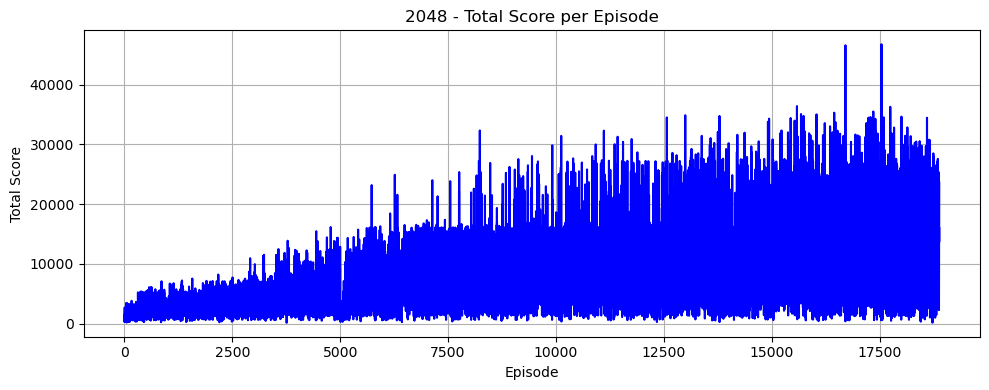

In [59]:
# Plot Total Scores
plt.figure(figsize=(10, 4))
plt.plot(total_scores, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Score')
plt.title('2048 - Total Score per Episode')
plt.grid(True)
plt.tight_layout()
plt.show()

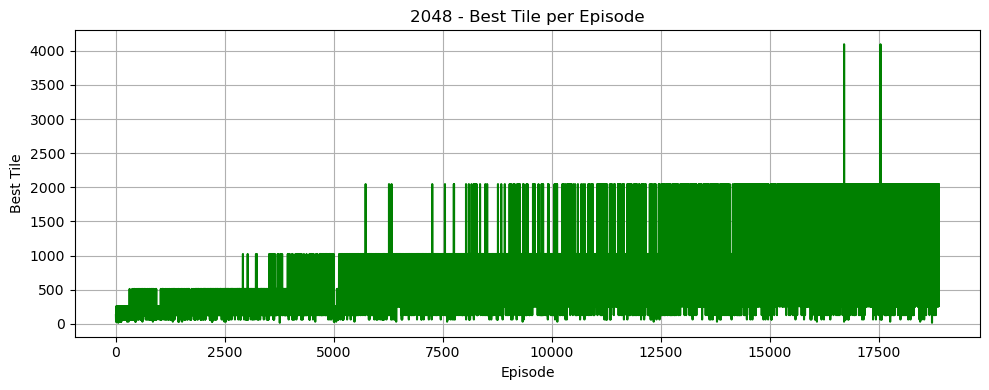

In [60]:
# Plot Best Tiles
plt.figure(figsize=(10, 4))
plt.plot(best_tile_list, color='green')
plt.xlabel('Episode')
plt.ylabel('Best Tile')
plt.title('2048 - Best Tile per Episode')
plt.grid(True)
plt.tight_layout()
plt.show()

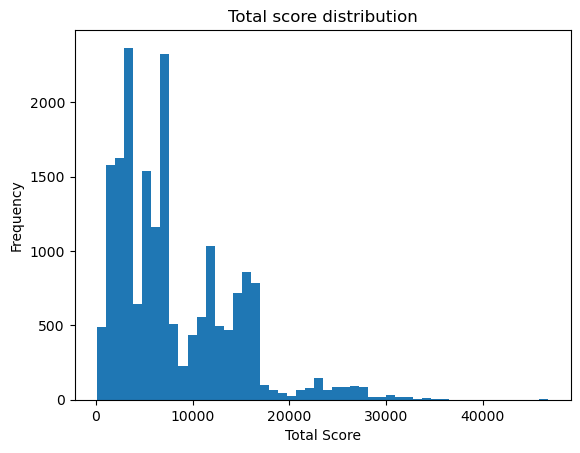

In [61]:
# Plot total_scores distribution
plt.hist(total_scores, bins = 50)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

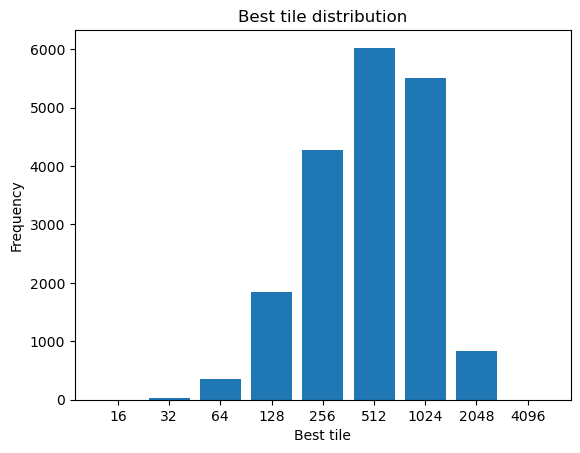

In [62]:
# Plot Best Tile Distribution
max_power = int(math.log(max(best_tile_list), 2)) + 1
min_power = int(math.log(min(best_tile_list), 2))
unique, counts = np.unique(best_tile_list, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()

In [63]:
len(total_scores)

18881

In [64]:
len(best_tile_list)

18881

In [74]:
best_tile_list.count(1024)

5513

In [65]:
game = Board()

num_episodes = 5000
policy_net_ddqn = DQN().to(device)
target_net_ddqn = DQN().to(device)
# target_net.load_state_dict(policy_net.state_dict())
target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
target_net_ddqn.eval()
policy_net_ddqn.train()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-5)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
memory = ReplayMemory(50000)

steps_done = 0

def select_action_ddqn(state):
    global steps_done
    sample = random.random()
    eps_threshold = max(EPS_END, EPS_START * (EPS_DECAY ** steps_done))
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net_ddqn(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [66]:
def optimize_model_ddqn():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net_ddqn(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    with torch.no_grad():
        # Select best action in next state using policy network
        next_actions = policy_net_ddqn(non_final_next_states).argmax(1, keepdim=True)

        # Evaluate that action using the target network
        next_q_values = target_net_ddqn(non_final_next_states).gather(1, next_actions).squeeze(1)

        next_state_values[non_final_mask] = next_q_values
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # global steps_done
    # if steps_done % 5000 == 0 and steps_done < 1000000:
    #   print("Learning rate changed.")
    #   scheduler.step()

In [67]:
total_scores_ddqn, best_tile_list_ddqn = [], []

for i_episode in range(num_episodes):
    print(f"Episode {i_episode}")
    game.reset()
    state = encode_state(game.board).float()
    duplicate = False
    non_valid_count, valid_count = 0, 0
    for t in count():
        # Select and perform an action
        action = select_action_ddqn(state)
        old_score = game.total_score
        old_max = game.board.max()
        game.step(action.item())

        done = game.is_game_over()

        reward = (game.total_score - old_score)
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if not done:
            next_state = encode_state(game.board).float()
        else:
            next_state = None

        if next_state != None and torch.eq(state, next_state).all():
          non_valid_count += 1
          reward -= 10
        else:
          valid_count += 1

        # Store the transition in memory
        # if next_state != None and duplicate and not torch.eq(state, next_state).all():
        #   duplicate = False

        # if not duplicate:
        if next_state == None or len(memory) == 0 or not same_move(state, next_state, memory.memory[-1]):
          memory.push(state, action, next_state, reward)

        # if next_state != None:
        #   duplicate = torch.eq(state, next_state).all()

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # optimize_model()

        if done:
          for _ in range(100):
            optimize_model_ddqn()

          print(game.board)
          print(f"Episode Score: {game.total_score}")
          print(f"Non valid move count: {non_valid_count}")
          print(f"Valid move count: {valid_count}")
          total_scores_ddqn.append(game.total_score)
          best_tile_list_ddqn.append(game.board.max())
          if i_episode > 50:
            average = sum(total_scores_ddqn[-50:]) / 50
            print(f"50 episode running average: {average}")
          break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
        policy_net_ddqn.train()

    if i_episode % 100 == 0:
        torch.save(policy_net_ddqn.state_dict(), './policy_net_ddqn.pth')
        torch.save(target_net_ddqn.state_dict(), './target_net_ddqn.pth')

Episode 0
[[  2   8   4   2]
 [  8  32 128  16]
 [  2   8   2   4]
 [  4  64   4   2]]
Episode Score: 1272
Non valid move count: 27
Valid move count: 130
Episode 1
[[ 2  8  2  8]
 [ 4 16  4 16]
 [ 8  2 16  8]
 [ 2 16 32  2]]
Episode Score: 360
Non valid move count: 0
Valid move count: 64
Episode 2
[[  2   4  16   4]
 [128   8 128  16]
 [  4  64   2   8]
 [  2  32   4   2]]
Episode Score: 2060
Non valid move count: 31
Valid move count: 194
Episode 3
[[ 2  4  8  4]
 [ 4 16  2 16]
 [32 64  4  2]
 [ 4  2  8  4]]
Episode Score: 568
Non valid move count: 24
Valid move count: 79
Episode 4
[[ 2 32  2  8]
 [ 4 64 16  2]
 [16  4  2 16]
 [ 4  2  4  8]]
Episode Score: 600
Non valid move count: 9
Valid move count: 82
Episode 5
[[ 4  2  8  2]
 [ 2  8 16  4]
 [ 8 32 64  2]
 [ 2 16  2  8]]
Episode Score: 588
Non valid move count: 11
Valid move count: 82
Episode 6
[[ 2  4  8  4]
 [ 4 16  4 32]
 [64 32  8  4]
 [ 2 16  4  2]]
Episode Score: 704
Non valid move count: 20
Valid move count: 96
Episode 7
[[  

KeyboardInterrupt: 

In [68]:
def sample_game_DDQN():
  game = Board()
  state = encode_state(game.board).float()
  finish = False
  moved = True
  while not finish:
    if not moved:
      direction = np.random.randint(4)
    else:
      direction = select_action_ddqn(state)

    moved = main_loop(game, direction)
    state = encode_state(game.board).float()

    if not moved:
      continue
      
    finish = game.is_game_over()
  total_score = game.total_score
  best_tile = game.board.max()
  # print("Game Over!, Total Score is {}".format(total_score))
  # print("Best tile: {}".format(best_tile))
  return total_score, best_tile

In [69]:
scores_DDQN, best_tiles_DDQN = [], []
for i in range(1000):
  if i % 100 == 0:
    print(f"Iteration {i}")
  total_score, best_tile = sample_game_DDQN()
  scores_DDQN.append(total_score)
  best_tiles_DDQN.append(best_tile)
print("Finish")

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Finish


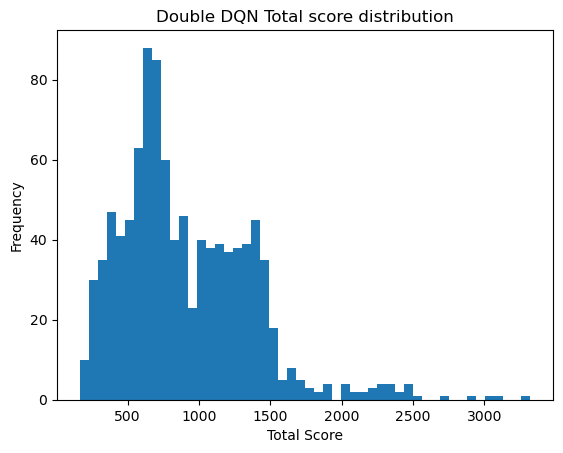

In [70]:
# Plot scores_DDQN distribution
plt.hist(scores_DDQN, bins = 50)
plt.title("Double DQN Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

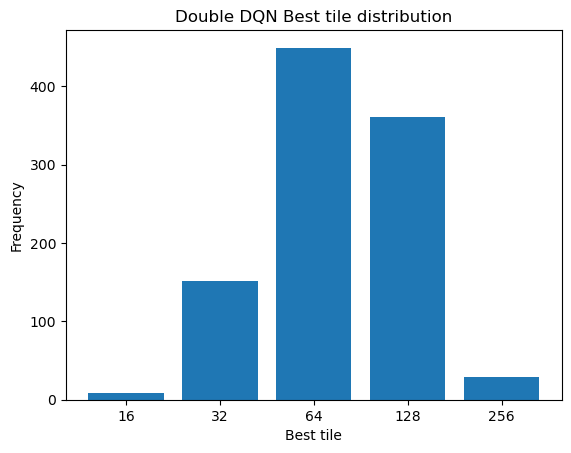

In [71]:
# Plot best_tiles_DDQN distribution
max_power = int(math.log(max(best_tiles_DDQN), 2)) + 1
min_power = int(math.log(min(best_tiles_DDQN), 2))
unique, counts = np.unique(best_tiles_DDQN, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Double DQN Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()